# load

This loads data from the individual files and calculates a fitness mean and variance.

In [5]:
using CSV
using DataFrames
#names = ["HK68", "Bk79", "Bei89", "Mos99", "Bris07P194", "Bris07L194", "NDako16"]
names = ["HK68", "Bk79", "Bei89", "Mos99", "Bris07L194", "NDako16"]
#wt = ["KGSESV", "EESENV", "EEYENV", "KESDNA", "HKFDFA", "HNSDFA", "HKFDFA"]
wt = ["KGSESV", "EESENV", "EEYENV", "KESDNA", "HNSDFA", "HKFDFA"]
pos = [156, 158, 159, 190, 193, 196]
# 4 x 4 x 3 x 2 x 3 x 2 = 576
# nic said Mos99 has no wt, background four is QKYDST, but that doesn't appear either
# chose one with largest selected count
function read(n) 
    d = CSV.read("EpiB_Index_$n.tsv", delim="\t", copycols=true)
    sort!(d, :ID)
    d.strain = n
    d.selected = d.Rep1Count .+ d.Rep2Count
    d.v = 1 ./(1 .+d.selected) .+ 1 ./(1 .+d.InputCount)
    d.f = log.((d.selected .+1)./(d.InputCount.+1))
    return d
end
#data[:f] = log.(data[:Rep1Count] .+ data[:Rep2Count])./(2*data[:InputCount])
data = map(read, names)
dall = reduce(vcat, data)
using RCall
R"""
library(dplyr)
library(ggplot2)
library(cowplot)
options(device = function(filename=getOption('rcalljl_filename'),...) png(filename, width=800, height=800, ...))
""";

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1273
┌ Warning: `setproperty!(df::DataFrame, col_ind::Symbol, v)` is deprecated, use `df[!, col_ind] .= v` instead.
│   caller = read(::String) at In[5]:14
└ @ Main ./In[5]:14
┌ Info: Precompiling RCall [6f49c342-dc21-5d91-9882-a32aef131414]
└ @ Base loading.jl:1273
┌ Warning: RCall.jl: 
│ Attaching package: ‘dplyr’
│ 
│ The following objects are masked from ‘package:stats’:
│ 
│     filter, lag
│ 
│ The following objects are masked from ‘package:base’:
│ 
│     intersect, setdiff, setequal, union
│ 
└ @ RCall /Users/jakub/.julia/packages/RCall/g7dhB/src/io.jl:113
┌ Warning: RCall.jl: 
│ ********************************************************
│ Note: As of version 1.0.0, cowplot does not change the
│   default ggplot2 theme anymore. To recover the previous
│   behavior, execute:
│   theme_set(theme_cowplot())
│ ********************************************************
│ 
└ @ RCall /Users/jakub/.julia/pa

In [9]:
#CSV.write("data_all.csv", dall)

CSV.Sink{Void,DataType}(    CSV.Options:
        delim: ','
        quotechar: '"'
        escapechar: '\\'
        missingstring: ""
        dateformat: nothing
        decimal: '.'
        truestring: 'true'
        falsestring: 'false'
        internstrings: true, IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1), "data_all.csv", 129, true, String["ID", "InputCount", "Rep1Count", "Rep2Count", "Rep1Fitness", "Rep2Fitness", "Fitness", "Rep1_Preference", "Rep2_Preference", "Preference", "strain", "selected", "v", "f"], 14, false, Val{false})

## overdispersion

We find evidence of overdispersion in the plot of mean vs variance. The slope should be 1 for a poisson. We infer an overdispersion parameter r from a negative binomial fit. This is then used to modify the estimate of the fitness variance.

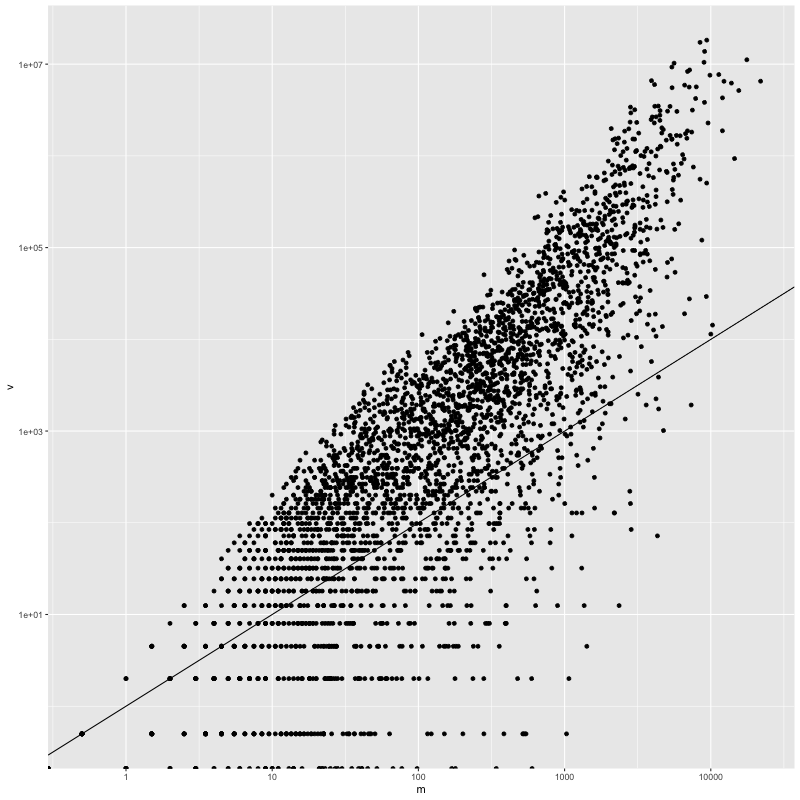

RObject{VecSxp}


┌ Warning: RCall.jl: Warning: Transformation introduced infinite values in continuous x-axis
│ Warning: Transformation introduced infinite values in continuous y-axis
└ @ RCall /Users/jakub/.julia/packages/RCall/g7dhB/src/io.jl:113


In [6]:
using RCall
R"""
library(dplyr)
library(ggplot2)
library(cowplot)
qplot(data=$dall %>% mutate(m = (Rep1Count+Rep2Count)/2, v = (Rep1Count-m)^2+(Rep2Count-m)^2),
    x=m, y=v, log="xy") + geom_abline(slope=1)
"""

### inference of overdispersion with negative binomial max likelihood

In [9]:
using Optim
using SpecialFunctions
# using Statistics
function negbopt(k)
    m = vec(sum(k, dims=2))./2
    ll(r) = begin
        r1 = exp(r[1])
        -(sum(loggamma.(k.+r1) .- loggamma(r1) .- (k.+r1).*log.(m.+r1) .+ r1*r[1]))
    end
    dll(s, r) = begin 
        r1 = exp(r[1])
        s[1] = -r1*(sum(digamma.(k.+r1) .- digamma(r1) .- (k.+r1)./(m.+r1) .- log.(m.+r1) .+ 1 .+ r[1])) 
    end
    res = Optim.optimize(ll, dll, [5.0], LBFGS())
    display(res)
    return exp(Optim.minimizer(res)[1])
end

r = negbopt(hcat(dall.Rep1Count, dall.Rep2Count))

 * Status: success

 * Candidate solution
    Minimizer: [3.17e+00]
    Minimum:   4.212997e+06

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [5.00e+00]

 * Convergence measures
    |x - x'|               = 3.63e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.14e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.31e-10 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.21e-16 ≰ 0.0e+00
    |g(x)|                 = 3.46e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    5
    f(x) calls:    17
    ∇f(x) calls:   17


23.787115054281465

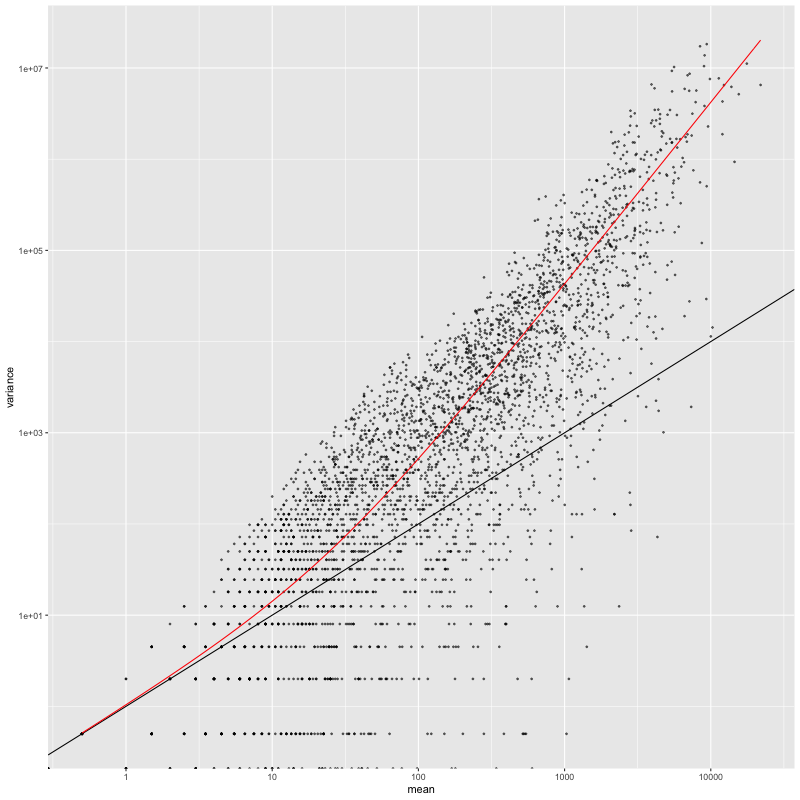

RObject{VecSxp}


┌ Warning: RCall.jl: Warning: Transformation introduced infinite values in continuous x-axis
│ Warning: Transformation introduced infinite values in continuous y-axis
└ @ RCall /Users/jakub/.julia/packages/RCall/g7dhB/src/io.jl:113


In [45]:
using RCall
R"""
library(dplyr)
library(ggplot2)
library(cowplot)
p.overdisp = qplot(data=$dall %>% mutate(m = (Rep1Count+Rep2Count)/2, v = (Rep1Count-Rep2Count)^2/2),
    x=m, y=v, log="xy", alpha=I(0.5), size = I(0.5)) + geom_abline(slope=1) + 
    stat_function(fun= ~ .x+.x^2/23.8, inherit.aes = FALSE, color="red") + 
    labs(x="mean", y="variance")
"""

In [11]:
for d in data
    d.v2 = d.v .+ 2 ./r
end
dall.v2 = dall.v .+ 2 ./r

3456-element Array{Float64,1}:
 0.08825939058073358
 0.08882391128842831
 0.08725907215171468
 0.08677023514146136
 0.08963679894162968
 0.08737889698463847
 0.08646731972082171
 0.0854988965642738 
 0.085900017842679  
 0.08555259704310592
 0.086762729565916  
 0.08572264543059667
 0.09146455685474887
 ⋮                  
 0.08855398535997125
 0.09298904555612642
 0.08686241376673695
 0.08750128512559485
 0.08747402290110129
 0.08807238921847974
 0.08858691874163366
 0.09272693130764963
 0.08690656867495918
 0.08846590674120365
 0.0875831058466353 
 0.08969781943419813

# define model

first there is some complex code to produce a design matrix, or encoding of sequences as categorical variables into numbers. We use "effects coding". I should have used the implementation in https://juliastats.org/StatsModels.jl/stable/contrasts/#StatsModels.EffectsCoding
but I think it was not available at the time. Much of the complexity comes from implementing pairwise interaction terms.

The second block of code defines the rest of the model, the non-linear function as a generalized logistic curve, and the weighted sum of squares loss function. There are options to choose a linear or nonlinear function, and to have additive or additive+pairwise effects.

In [15]:
function dx(si, sil, gauge)
    c = Dict(map(s ->(s,transpose((s.==sil)*1)), sil))
    cwt = ifelse(gauge == :sum, -transpose(ones(length(sil))), transpose(zeros(length(sil))))
    mapreduce(x -> get(c, x, cwt), vcat , si)
end

function lev(s, wt)
    su = unique(s)
    su[su .!= wt]
end

using IterTools
function designmatrix(seq, wt, gauge, order)
    s(i) = map(x -> x[i], seq)
    i = 1:length(seq[1])
    ss = map(s, i)
    l = map(lev, ss, wt)
    xn = map((w, l, i) -> w.*string(pos[i]).*l, wt, l, i)
    xn = reduce(vcat, xn)
    x = map(dx, ss, l, repeat([gauge], inner=length(ss)))
    x = reduce(hcat, x)
    x = hcat(ones(length(seq)), x)
    xn = ["Intercept"; xn]
    l2f(ij) = vec(map( a -> a[1]*a[2], Iterators.product(l[ij[1]], l[ij[2]])))
    if order == 2
        l2 = map(l2f, subsets(i, 2))
        ss2 = map(ij -> ss[ij[1]].*ss[ij[2]], subsets(i, 2))
        x2 = map(dx, ss2, l2, repeat([gauge], inner=length(ss2)))
        x = hcat(x, reduce(hcat, x2))
        xn2 = map((ij,l2) -> wt[ij[1]]*wt[ij[2]].*l2.*'-'.*string(pos[ij[1]]).*'-'.*string(pos[ij[2]]), subsets(i, 2), l2)
        xn2 = reduce(vcat, xn2)
        xn2 = map(x -> x[1]*x[6:8]*x[3]*'-'*x[2]*x[10:12]*x[4], xn2)
        xn = vcat(xn, xn2)
    end
    return (x, xn)
end

x, xn = designmatrix(data[1].ID, wt[1], :sum, 2)

┌ Info: Precompiling IterTools [c8e1da08-722c-5040-9ed9-7db0dc04731e]
└ @ Base loading.jl:1273


([1.0 1.0 … 1.0 0.0; 1.0 1.0 … -1.0 -1.0; … ; 1.0 0.0 … -1.0 -1.0; 1.0 0.0 … -1.0 -1.0], ["Intercept", "K156E", "K156H", "K156Q", "G158E", "G158K", "G158N", "S159F", "S159Y", "E190D"  …  "S159Y-S193F", "S159F-S193N", "S159Y-S193N", "S159F-V196A", "S159Y-V196A", "E190D-S193F", "E190D-S193N", "E190D-V196A", "S193F-V196A", "S193N-V196A"])

In [17]:
using Optim
using Statistics

function train(y, v, seq, wt, order, model; delim = '-')
    #x, code, xn, code2 = designmatrix(seq, kind, wt, order, delim = delim)
    x, xn = designmatrix(seq, wt, :sum, order)
    w = (1.0./v)
    nx = size(x,2)
    er = 1:nx
    init_p = zeros(nx)
    yhat_ne(p) = x*p
    #yhat_glog(p) = p[nx+1] + exp(p[nx+2])*(exp(p[nx+4])+exp.(x*view(p,er))).^-exp(p[nx+3])
    yhat_glog(p) = p[nx+1] .+ exp(p[nx+2])*(1 .+exp.(x*view(p,er))).^-exp(p[nx+3])
    if model == :linear
        yhat = yhat_ne
    elseif model == :glog
        yhat = yhat_glog
        #m0 = train(y, v, seq, kind, wt, 1, :linear)
        #init_p[er] = m0[:energies].e
        append!(init_p, zeros(3))
    end
    
    sw = sum(w)
    loss(p) = sum(w.*(y.-yhat(p)).^2)/sw #+ exp(p[2]*2)/100
    od = OnceDifferentiable(loss, init_p; autodiff = :forward)
    res = optimize(od, init_p, LBFGS(), Optim.Options(iterations=10000))
    #res = optimize(loss, init_p, BFGS())
    display(res)
    p = Optim.minimizer(res)
    
    effects = DataFrame(e = p[er], n = xn)[2:end, :]
    #singles = effects[.!ismatch.(r"\-", effects.n),:]
    singles = effects[length.(effects.n).==5, :]
    singles.pos = map(n->parse(Int64, n[2:end-1]), singles.n)
    singles.aa = map(n->n[end], singles.n)
    sx = by(singles, :pos, d -> DataFrame(aa = d.n[1][1], e=-sum(d.e)))
    select!(singles, Not(:n))
    singles = [singles; sx]
    sort!(singles, :pos)
        
    m = Dict(:singles => singles, :phi => x*p[er],
        :yhat => yhat(p), :rho => cor(y, yhat(p)), :p => [p[1];p[nx+1:end]])
    if order == 2
        #doubles = effects[ismatch.(r"\-", effects.n),:]
        doubles = effects[length.(effects.n).>5, :]
        doubles.n = split.(doubles.n, '-')
        doubles.pos1 = map(n->parse(Int64, n[1][2:end-1]), doubles.n)
        doubles.pos2 = map(n->parse(Int64, n[2][2:end-1]), doubles.n)
        doubles.aa1 = map(n->n[1][end], doubles.n)
        doubles.aa2 = map(n->n[2][end], doubles.n)
        dx1 = by(doubles, [:pos1, :pos2], d -> DataFrame(aa1 = d.n[1][1][1], aa2 = d.n[1][2][1], e= -sum(d.e)))
        dx2 = by(doubles, [:pos1, :pos2, :aa2], d -> DataFrame(aa1 = d.n[1][1][1], e= -sum(d.e)))
        dx3 = by(doubles, [:pos1, :pos2, :aa1], d -> DataFrame(aa2 = d.n[1][2][1], e= -sum(d.e)))
        select!(doubles, Not(:n))
        doubles = [doubles; dx1; dx2; dx3]
        sort!(doubles, [:pos1, :pos2, :aa1, :aa2])
        m[:doubles] = doubles
    end
    return m
end 



train (generic function with 1 method)

## linear g and additive effects

In [18]:
train1(d) = train(d.f, d.v2, d.ID, wt[1], 1, :linear)
m_lin_add = map(train1, data)

 * Status: success

 * Candidate solution
    Minimizer: [7.52e-01, -3.93e-01, 1.46e-01,  ...]
    Minimum:   4.096294e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.76e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.79e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.94e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.74e-13 ≰ 0.0e+00
    |g(x)|                 = 3.90e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    10
    f(x) calls:    26
    ∇f(x) calls:   26


 * Status: success

 * Candidate solution
    Minimizer: [-1.05e+00, 1.30e+00, 2.27e-01,  ...]
    Minimum:   5.893319e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.85e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.63e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 7.62e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    12
    f(x) calls:    32
    ∇f(x) calls:   32


 * Status: success

 * Candidate solution
    Minimizer: [-5.50e-01, 7.67e-01, 7.02e-01,  ...]
    Minimum:   2.742666e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.06e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.12e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.84e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.72e-14 ≰ 0.0e+00
    |g(x)|                 = 5.13e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    12
    f(x) calls:    32
    ∇f(x) calls:   32


 * Status: success

 * Candidate solution
    Minimizer: [-9.41e-01, -2.69e-01, -9.61e-02,  ...]
    Minimum:   9.114699e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.91e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.89e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.11e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.51e-15 ≰ 0.0e+00
    |g(x)|                 = 1.74e-15 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    13
    f(x) calls:    33
    ∇f(x) calls:   33


 * Status: success

 * Candidate solution
    Minimizer: [-1.44e+00, -6.27e-01, 4.83e-01,  ...]
    Minimum:   1.226262e+00

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.86e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.99e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.62e-16 ≰ 0.0e+00
    |g(x)|                 = 4.67e-16 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    13
    f(x) calls:    34
    ∇f(x) calls:   34


 * Status: success

 * Candidate solution
    Minimizer: [2.14e-01, -5.14e-01, 3.15e-01,  ...]
    Minimum:   2.194490e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.07e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.75e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.54e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.61e-12 ≰ 0.0e+00
    |g(x)|                 = 2.74e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    10
    f(x) calls:    26
    ∇f(x) calls:   26


6-element Array{Dict{Symbol,Any},1}:
 Dict(:p => [0.7520203337139203],:rho => 0.8390275650957827,:singles => 18×3 DataFrame
│ Row │ e          │ pos   │ aa   │
│     │ Float64    │ Int64 │ Char │
├─────┼────────────┼───────┼──────┤
│ 1   │ -0.393358  │ 156   │ 'E'  │
│ 2   │ 0.146344   │ 156   │ 'H'  │
│ 3   │ 0.331158   │ 156   │ 'Q'  │
│ 4   │ -0.0841429 │ 156   │ 'K'  │
│ 5   │ 0.611725   │ 158   │ 'E'  │
│ 6   │ -0.993061  │ 158   │ 'K'  │
│ 7   │ 0.379192   │ 158   │ 'N'  │
│ 8   │ 0.00214351 │ 158   │ 'G'  │
│ 9   │ -0.334847  │ 159   │ 'F'  │
│ 10  │ -0.278688  │ 159   │ 'Y'  │
│ 11  │ 0.613534   │ 159   │ 'S'  │
│ 12  │ -0.208171  │ 190   │ 'D'  │
│ 13  │ 0.208171   │ 190   │ 'E'  │
│ 14  │ -0.754507  │ 193   │ 'F'  │
│ 15  │ 0.481444   │ 193   │ 'N'  │
│ 16  │ 0.273063   │ 193   │ 'S'  │
│ 17  │ -0.0962401 │ 196   │ 'A'  │
│ 18  │ 0.0962401  │ 196   │ 'V'  │,:phi => [-0.42337715728323505, -0.2308969469014352, 0.812574022621579, 1.0050542330033787, 0.6041924688991063, 0.7966726

### inferred vs measured fitness

6-element Array{Float64,1}:
 0.8390275650957827
 0.9172108003416823
 0.9543242059667684
 0.869754828260966 
 0.8296353672692492
 0.9232554159754777

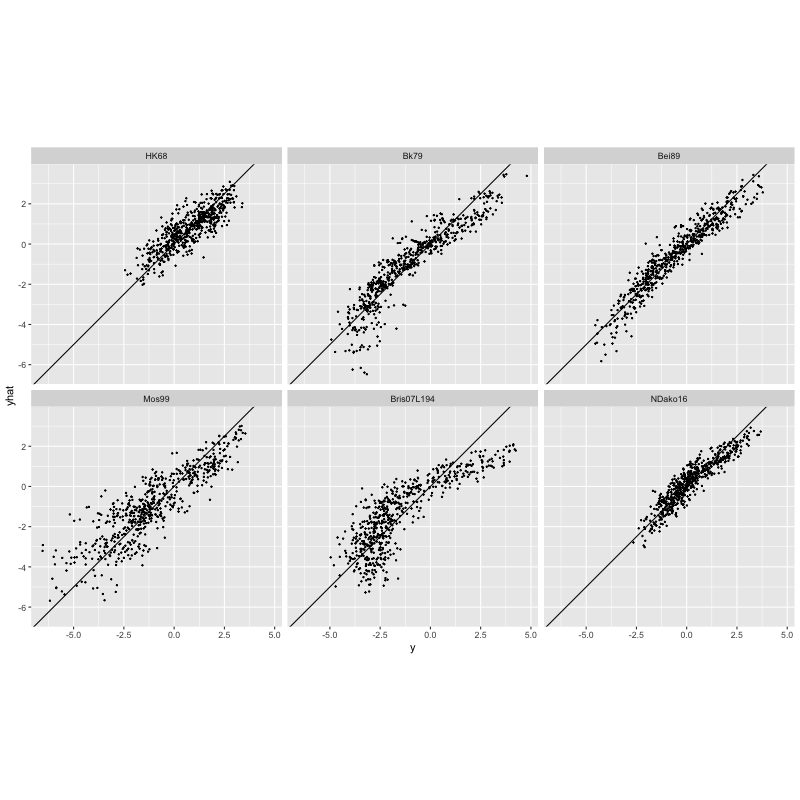

RObject{VecSxp}


In [19]:
display(map(m -> m[:rho], m_lin_add))
mpred = map((m, s, d) -> DataFrame(y = d.f, yhat = m[:yhat], phi=m[:phi], 
                             seq = d.ID, strain = s), m_lin_add, names, data)
mpred = reduce(vcat, mpred)
R"""
qplot(data=$mpred %>% mutate(strain = factor(strain, levels=$names)), x=y, y=yhat, geom="point", size=I(.3)) + 
    coord_fixed() + facet_wrap(~strain) + geom_abline()

"""

## non-linear g and additive

In [20]:
train1(d) = train(d.f, d.v2, d.ID, wt[1], 1, :glog)
m_nonlin_add = map(train1, data)

 * Status: success

 * Candidate solution
    Minimizer: [1.24e+00, 5.85e-01, -2.34e-01,  ...]
    Minimum:   4.027608e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.89e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.05e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.51e-16 ≰ 0.0e+00
    |g(x)|                 = 7.33e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    90
    f(x) calls:    250
    ∇f(x) calls:   250


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.11e-01, -6.78e-01, -2.11e-01,  ...]
    Minimum:   3.268422e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.33e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.88e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.70e-16 ≰ 0.0e+00
    |g(x)|                 = 1.71e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    102
    f(x) calls:    282
    ∇f(x) calls:   282


 * Status: success

 * Candidate solution
    Minimizer: [1.65e+00, -4.56e-01, -4.24e-01,  ...]
    Minimum:   2.412662e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.27e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.44e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.04e-15 ≰ 0.0e+00
    |g(x)|                 = 9.67e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    115
    f(x) calls:    308
    ∇f(x) calls:   308


 * Status: success

 * Candidate solution
    Minimizer: [5.04e+00, 5.11e-01, 9.62e-02,  ...]
    Minimum:   7.991051e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.59e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.13e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 9.33e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    111
    f(x) calls:    300
    ∇f(x) calls:   300


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.21e+01, 1.49e+00, -1.57e+00,  ...]
    Minimum:   4.803829e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.65e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.69e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.31e-16 ≰ 0.0e+00
    |g(x)|                 = 1.22e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    170
    f(x) calls:    477
    ∇f(x) calls:   477


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [6.41e+00, 1.28e+00, -7.40e-01,  ...]
    Minimum:   1.812253e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.67e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.60e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.06e-16 ≰ 0.0e+00
    |g(x)|                 = 1.50e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    211
    f(x) calls:    556
    ∇f(x) calls:   556


6-element Array{Dict{Symbol,Any},1}:
 Dict(:p => [1.2358878161416418, -2.684586077091722, 1.6996209499171644, -1.1648552950476283],:rho => 0.8418994409712031,:singles => 18×3 DataFrame
│ Row │ e           │ pos   │ aa   │
│     │ Float64     │ Int64 │ Char │
├─────┼─────────────┼───────┼──────┤
│ 1   │ 0.58549     │ 156   │ 'E'  │
│ 2   │ -0.234049   │ 156   │ 'H'  │
│ 3   │ -0.469405   │ 156   │ 'Q'  │
│ 4   │ 0.117964    │ 156   │ 'K'  │
│ 5   │ -0.828421   │ 158   │ 'E'  │
│ 6   │ 1.38875     │ 158   │ 'K'  │
│ 7   │ -0.561031   │ 158   │ 'N'  │
│ 8   │ 0.000704195 │ 158   │ 'G'  │
│ 9   │ 0.478868    │ 159   │ 'F'  │
│ 10  │ 0.402502    │ 159   │ 'Y'  │
│ 11  │ -0.88137    │ 159   │ 'S'  │
│ 12  │ 0.287052    │ 190   │ 'D'  │
│ 13  │ -0.287052   │ 190   │ 'E'  │
│ 14  │ 1.04337     │ 193   │ 'F'  │
│ 15  │ -0.65786    │ 193   │ 'N'  │
│ 16  │ -0.385512   │ 193   │ 'S'  │
│ 17  │ 0.136178    │ 196   │ 'A'  │
│ 18  │ -0.136178   │ 196   │ 'V'  │,:phi => [2.9384260395515978, 2.6660703

### inferred vs measured fitness

6-element Array{Float64,1}:
 0.8418994409712031
 0.9576055885640503
 0.9618708267100113
 0.8787907766749542
 0.933047321299793 
 0.9370246646644546

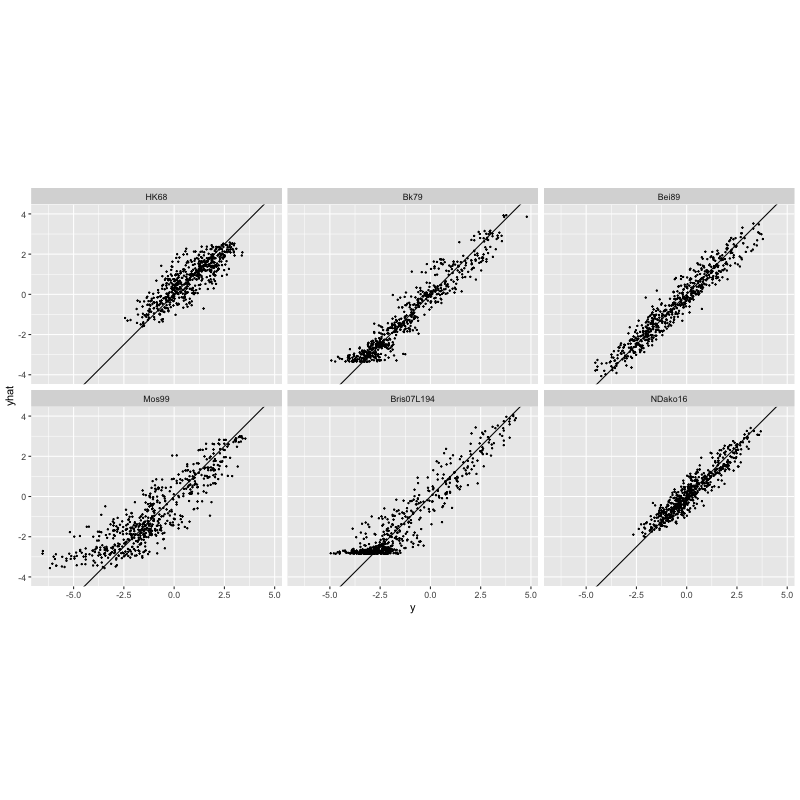

RObject{VecSxp}


In [21]:
display(map(m -> m[:rho], m_nonlin_add))
mpred = map((m, s, d) -> DataFrame(y = d.:f, yhat = m[:yhat], phi=m[:phi], 
                             seq = d.:ID, strain = s), m_nonlin_add, names, data)
mpred = reduce(vcat, mpred)
R"""
qplot(data=$mpred %>% mutate(strain = factor(strain, levels=$names)), x=y, y=yhat, geom="point", size=I(.3)) + 
    coord_fixed() + facet_wrap(~strain) + geom_abline()

"""

### inferred non-linearity

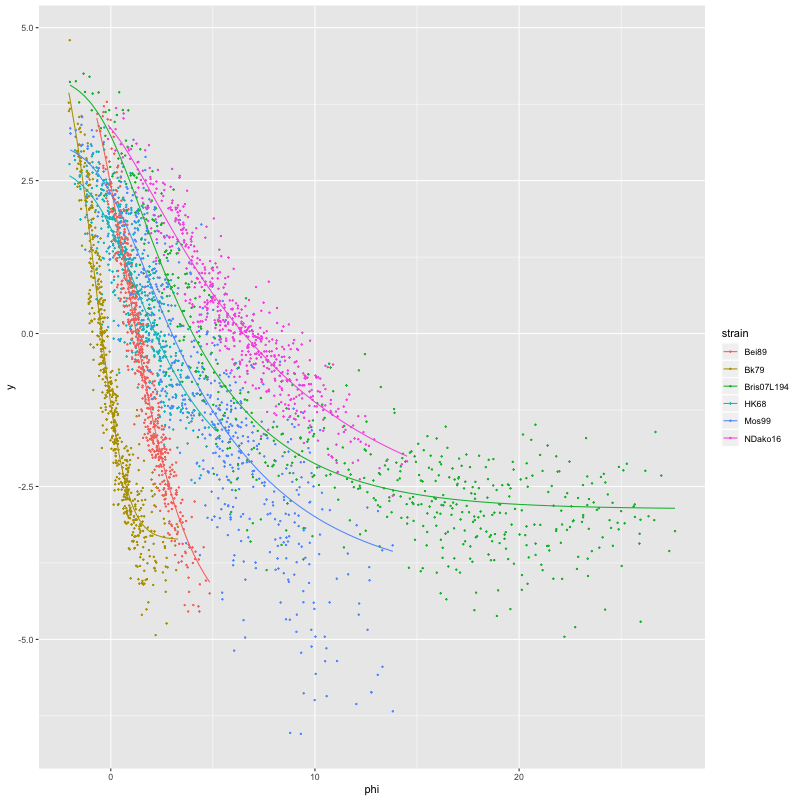

RObject{VecSxp}


In [22]:
R"""
#qplot(data=$mpred %>% filter(strain != "Bris07P194"), x=phi, y=y, geom="point", size=I(.3)) + 
#    geom_line(aes(y=yhat), color="red") + facet_wrap(~strain, scale="free")
qplot(data=$mpred %>% filter(strain != "Bris07P194"), x=phi, y=y, geom="point", color=strain, size=I(.3)) + 
    geom_line(aes(y=yhat))
"""

## non-linear g and pairwise

In [32]:
train1(d) = train(d.f, d.v2, d.ID, wt[1], 2, :glog)
m_nonlin_pair = map(train1, data)
map(m -> m[:rho], m_nonlin_pair)


 * Status: success

 * Candidate solution
    Minimizer: [2.34e+00, -1.61e-01, -1.77e-01,  ...]
    Minimum:   7.035509e-02

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.77e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.76e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.97e-15 ≰ 0.0e+00
    |g(x)|                 = 9.01e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    812
    f(x) calls:    2395
    ∇f(x) calls:   2395


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.25e+00, -1.42e+00, -1.70e-01,  ...]
    Minimum:   9.771498e-02

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.58e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.66e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.16e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.26e-16 ≰ 0.0e+00
    |g(x)|                 = 2.71e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   14  (vs limit Inf)
    Iterations:    1942
    f(x) calls:    5772
    ∇f(x) calls:   5772


 * Status: success

 * Candidate solution
    Minimizer: [2.02e+00, -8.93e-01, -2.69e-01,  ...]
    Minimum:   4.630329e-02

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.59e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.95e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.00e-16 ≰ 0.0e+00
    |g(x)|                 = 9.28e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   14  (vs limit Inf)
    Iterations:    2237
    f(x) calls:    6613
    ∇f(x) calls:   6613


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.78e+00, 8.36e-01, 3.43e-01,  ...]
    Minimum:   2.101306e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.45e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.51e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.94e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.25e-16 ≰ 0.0e+00
    |g(x)|                 = 2.94e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   42  (vs limit Inf)
    Iterations:    6307
    f(x) calls:    18780
    ∇f(x) calls:   18780


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.72e+00, 1.40e+00, 5.39e-02,  ...]
    Minimum:   1.753873e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.74e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.41e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.58e-16 ≰ 0.0e+00
    |g(x)|                 = 1.73e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   15  (vs limit Inf)
    Iterations:    1982
    f(x) calls:    5926
    ∇f(x) calls:   5926


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.06e+01, 2.30e-01, -4.50e-02,  ...]
    Minimum:   5.079076e-02

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.83e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.26e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.41e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.77e-14 ≰ 0.0e+00
    |g(x)|                 = 6.12e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   34  (vs limit Inf)
    Iterations:    4926
    f(x) calls:    13470
    ∇f(x) calls:   13470


6-element Array{Float64,1}:
 0.974548121898605 
 0.984534607892802 
 0.9903985551995892
 0.96694028751335  
 0.9727527817657631
 0.9825872340149056

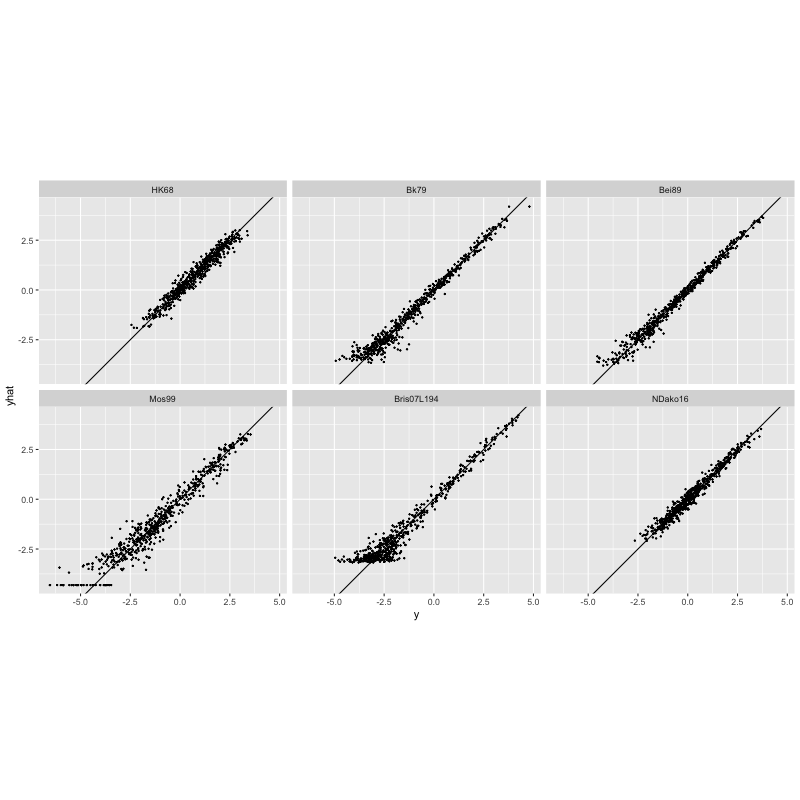

RObject{VecSxp}


In [33]:
mpred = map((m, s, d) -> DataFrame(y = d.f, yhat = m[:yhat], phi=m[:phi], 
                             seq = d.ID, strain = s), m_nonlin_pair, names, data)
mpred = reduce(vcat, mpred)
R"""
qplot(data=$mpred %>% mutate(strain = factor(strain, levels=$names)), x=y, y=yhat, geom="point", size=I(.3)) + 
    coord_fixed() + facet_wrap(~strain) + geom_abline()

"""

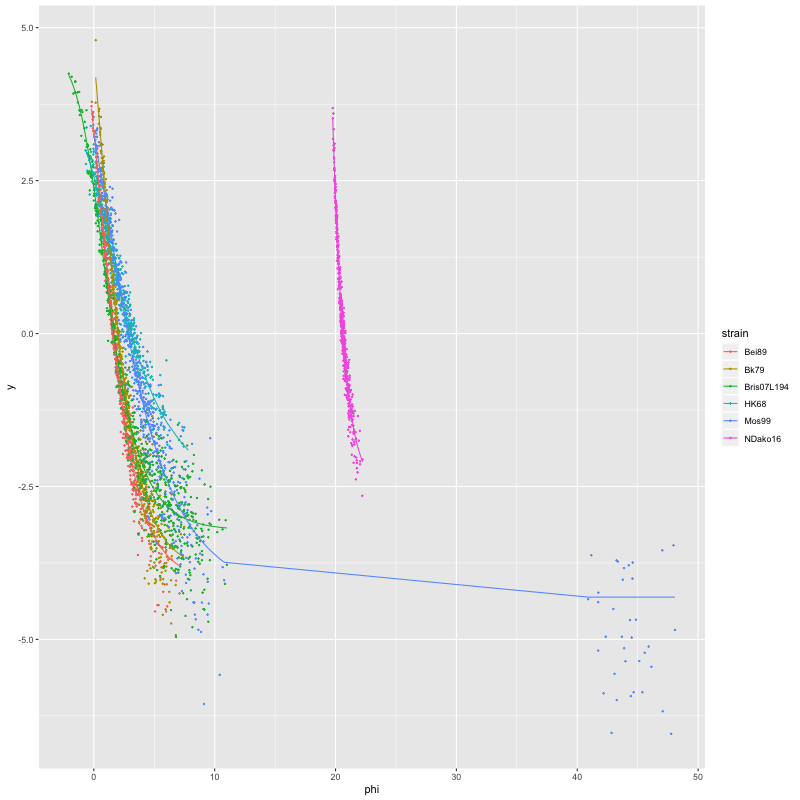

RObject{VecSxp}


In [34]:
R"""
#qplot(data=$mpred %>% filter(strain != "Bris07P194"), x=phi, y=y, geom="point", size=I(.3)) + 
#    geom_line(aes(y=yhat), color="red") + facet_wrap(~strain, scale="free")
qplot(data=$mpred %>% filter(strain != "Bris07P194"), x=phi, y=y, geom="point", color=strain, size=I(.3)) + 
    geom_line(aes(y=yhat))
"""

### plot coefs

┌ Warning: `setproperty!(df::DataFrame, col_ind::Symbol, v)` is deprecated, use `df[!, col_ind] .= v` instead.
│   caller = top-level scope at In[35]:17
└ @ Core In[35]:17
┌ Warning: `setproperty!(df::DataFrame, col_ind::Symbol, v)` is deprecated, use `df[!, col_ind] .= v` instead.
│   caller = top-level scope at In[35]:23
└ @ Core In[35]:23


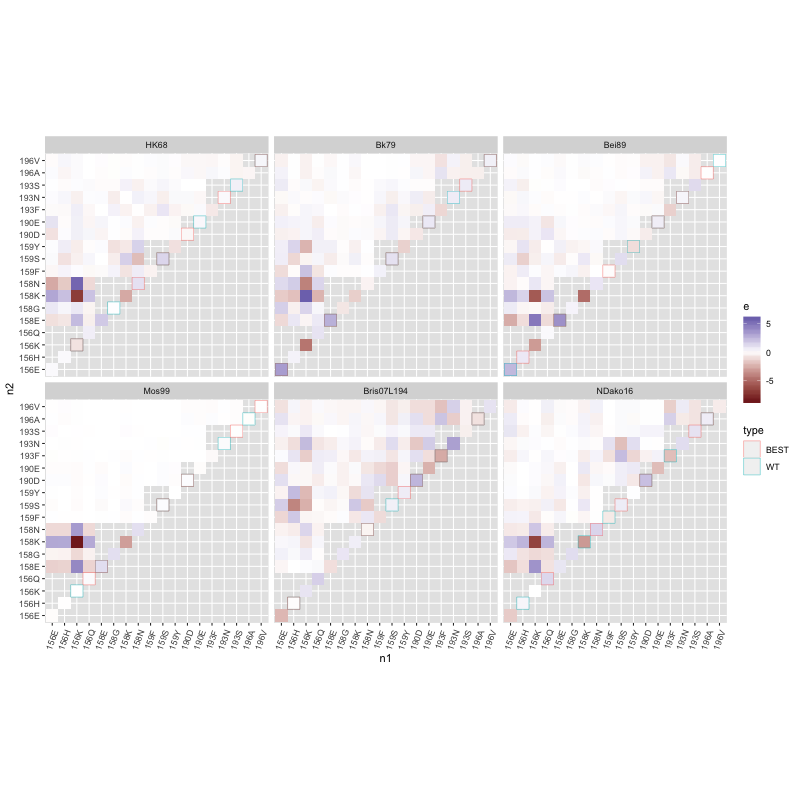

RObject{VecSxp}


In [35]:
m = m_nonlin_pair
doubles = map((m, s) -> DataFrame(e = m[:doubles].e, 
        n1 = ["$p$a" for (p,a) in zip(m[:doubles].pos1, m[:doubles].aa1)],
        n2 = ["$p$a" for (p,a) in zip(m[:doubles].pos2, m[:doubles].aa2)], strain = s), m, names)
doubles = reduce(vcat, doubles)

singles = map((m, s) -> DataFrame(e = m[:singles].e, 
        n = ["$p$a" for (p,a) in zip(m[:singles].pos, m[:singles].aa)], strain = s), m, names)
singles = reduce(vcat, singles)
singles.n2 = singles.n
rename!(singles, :n => :n1)
doubles = [doubles; singles]

wtc = map( (w,s) -> DataFrame(strain = s, n1 = map(i->string(pos[i])*w[i], 1:6)), wt, names)
wtc = reduce(vcat, wtc)
wtc.n2 = wtc.n1
wtc.type = "WT"

smax = map(d -> d.ID[argmax(d.f)], data)
smaxd = map( (w,s) -> DataFrame(strain = s, n1 = map(i->string(pos[i])*w[i], 1:6)), smax, names)
smaxd = reduce(vcat, smaxd)
smaxd.n2 = smaxd.n1
smaxd.type = "BEST"

wtc = [wtc; smaxd]
R"""
qplot(data=$doubles %>% mutate(strain = factor(strain, levels=$names)) %>%
    group_by(strain) %>% mutate(e =-e/sd(e)), 
    y=n2, x=n1, fill=e, geom="tile") + coord_fixed() + 
    scale_fill_gradient2() + facet_wrap(~strain) +
    geom_tile(aes(x=n1,y=n2, color=type), size=.2, fill="black",alpha=0, inherit.aes=FALSE,data=$wtc%>% mutate(strain = factor(strain, levels=$names))) +
    theme(axis.text.x = element_text(angle=70, vjust=0.5), 
        panel.background = element_rect(fill="grey90"))
"""


In [593]:
#using CSV
#CSV.write("pairwiseparameters.csv", doubles)

CSV.Sink{Void,DataType}(    CSV.Options:
        delim: ','
        quotechar: '"'
        escapechar: '\\'
        missingstring: ""
        dateformat: nothing
        decimal: '.'
        truestring: 'true'
        falsestring: 'false', IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1), "pairwiseparameters.csv", 15, true, String["e", "n1", "n2", "strain"], 4, false, Val{false})

### bootstrap parameter values  

In [36]:
using Distributed 
booty(y, v) = randn(length(y)).*sqrt.(v) .+ y
train1b(d) = train(booty(d.f, d.v2), d.v2, d.ID, wt[1], 2, :glog)
m_nonlin_pair_boot = pmap(d -> [train1b(d) for i = 1:100], data)

 * Status: success

 * Candidate solution
    Minimizer: [1.43e+00, -1.27e-01, -8.68e-02,  ...]
    Minimum:   1.461164e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.14e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.06e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.05e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.22e-15 ≰ 0.0e+00
    |g(x)|                 = 9.32e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    799
    f(x) calls:    2357
    ∇f(x) calls:   2357


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.10e+00, -8.44e-02, -4.68e-02,  ...]
    Minimum:   1.589157e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.18e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.13e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.73e-16 ≰ 0.0e+00
    |g(x)|                 = 1.77e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   8  (vs limit Inf)
    Iterations:    1267
    f(x) calls:    3764
    ∇f(x) calls:   3764


 * Status: success

 * Candidate solution
    Minimizer: [2.85e+00, -2.76e-01, -2.11e-01,  ...]
    Minimum:   1.521809e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.57e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.99e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.38e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.19e-15 ≰ 0.0e+00
    |g(x)|                 = 9.07e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    985
    f(x) calls:    2918
    ∇f(x) calls:   2918


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.12e+01, -2.89e-02, -6.83e-04,  ...]
    Minimum:   1.474951e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.37e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.00e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.50e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.37e-11 ≰ 0.0e+00
    |g(x)|                 = 3.40e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   48  (vs limit Inf)
    Iterations:    7089
    f(x) calls:    20811
    ∇f(x) calls:   20811


 * Status: success

 * Candidate solution
    Minimizer: [2.07e+02, -6.03e+00, -1.53e+01,  ...]
    Minimum:   1.560005e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.55e-15 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.43e-17 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.59e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   8  (vs limit Inf)
    Iterations:    1113
    f(x) calls:    3253
    ∇f(x) calls:   3253


 * Status: success

 * Candidate solution
    Minimizer: [2.75e+00, -1.19e-01, -2.99e-01,  ...]
    Minimum:   1.454153e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.17e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.41e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.47e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.01e-14 ≰ 0.0e+00
    |g(x)|                 = 8.18e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    682
    f(x) calls:    2004
    ∇f(x) calls:   2004


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.23e+00, -1.92e-01, -2.68e-02,  ...]
    Minimum:   1.544479e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.91e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.12e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.59e-16 ≰ 0.0e+00
    |g(x)|                 = 1.43e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1070
    f(x) calls:    3163
    ∇f(x) calls:   3163


 * Status: success

 * Candidate solution
    Minimizer: [3.94e+00, -6.12e-01, -1.03e-01,  ...]
    Minimum:   1.310941e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.38e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.57e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.27e-14 ≰ 0.0e+00
    |g(x)|                 = 8.71e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   8  (vs limit Inf)
    Iterations:    1241
    f(x) calls:    3630
    ∇f(x) calls:   3630


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.13e+00, -1.12e-01, -1.21e-01,  ...]
    Minimum:   1.416041e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.55e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.67e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.84e-16 ≰ 0.0e+00
    |g(x)|                 = 2.99e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    647
    f(x) calls:    1880
    ∇f(x) calls:   1880


 * Status: success

 * Candidate solution
    Minimizer: [5.66e+00, -3.45e-01, -2.34e-01,  ...]
    Minimum:   1.441868e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.40e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.77e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.54e-15 ≰ 0.0e+00
    |g(x)|                 = 9.38e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    945
    f(x) calls:    2794
    ∇f(x) calls:   2794


 * Status: success

 * Candidate solution
    Minimizer: [1.44e+00, -6.42e-02, -7.36e-02,  ...]
    Minimum:   1.678063e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.18e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.60e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.96e-16 ≰ 0.0e+00
    |g(x)|                 = 9.14e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1033
    f(x) calls:    3087
    ∇f(x) calls:   3087


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.02e-01, -5.20e-02, -7.87e-02,  ...]
    Minimum:   1.414846e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.97e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.33e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.85e-16 ≰ 0.0e+00
    |g(x)|                 = 1.50e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1455
    f(x) calls:    4317
    ∇f(x) calls:   4317


 * Status: success

 * Candidate solution
    Minimizer: [3.87e+00, -4.24e-01, -2.08e-01,  ...]
    Minimum:   1.492743e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.19e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.08e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.60e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.76e-15 ≰ 0.0e+00
    |g(x)|                 = 8.90e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    777
    f(x) calls:    2276
    ∇f(x) calls:   2276


 * Status: success

 * Candidate solution
    Minimizer: [3.70e+00, -1.84e-01, -2.45e-01,  ...]
    Minimum:   1.494805e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.36e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.87e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.03e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.87e-15 ≰ 0.0e+00
    |g(x)|                 = 8.22e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    643
    f(x) calls:    1883
    ∇f(x) calls:   1883


 * Status: success

 * Candidate solution
    Minimizer: [1.91e+00, -1.49e-01, -2.00e-01,  ...]
    Minimum:   1.486062e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.11e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.36e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.99e-15 ≰ 0.0e+00
    |g(x)|                 = 9.78e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   15  (vs limit Inf)
    Iterations:    2001
    f(x) calls:    5809
    ∇f(x) calls:   5809


 * Status: success

 * Candidate solution
    Minimizer: [7.35e+00, -9.87e-01, -4.53e-01,  ...]
    Minimum:   1.516429e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.75e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.69e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.80e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.14e-14 ≰ 0.0e+00
    |g(x)|                 = 8.82e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    666
    f(x) calls:    1948
    ∇f(x) calls:   1948


 * Status: success

 * Candidate solution
    Minimizer: [1.94e-01, -1.78e-02, -9.91e-02,  ...]
    Minimum:   1.591968e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.28e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.34e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.49e-16 ≰ 0.0e+00
    |g(x)|                 = 9.57e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1058
    f(x) calls:    3113
    ∇f(x) calls:   3113


 * Status: success

 * Candidate solution
    Minimizer: [6.83e-01, -6.31e-02, -8.97e-02,  ...]
    Minimum:   1.446681e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.35e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.29e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.59e-16 ≰ 0.0e+00
    |g(x)|                 = 9.74e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    889
    f(x) calls:    2606
    ∇f(x) calls:   2606


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.96e+00, -8.65e-02, -1.13e-01,  ...]
    Minimum:   1.602048e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.29e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.68e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.47e-16 ≰ 0.0e+00
    |g(x)|                 = 5.06e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   14  (vs limit Inf)
    Iterations:    2174
    f(x) calls:    6479
    ∇f(x) calls:   6479


 * Status: success

 * Candidate solution
    Minimizer: [2.17e+00, -2.32e-01, -7.52e-02,  ...]
    Minimum:   1.524486e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.60e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.54e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.55e-15 ≰ 0.0e+00
    |g(x)|                 = 9.82e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   8  (vs limit Inf)
    Iterations:    1338
    f(x) calls:    3923
    ∇f(x) calls:   3923


 * Status: success

 * Candidate solution
    Minimizer: [6.01e+00, -3.70e-01, -4.06e-01,  ...]
    Minimum:   1.405874e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.26e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.88e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.55e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.82e-14 ≰ 0.0e+00
    |g(x)|                 = 7.92e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    811
    f(x) calls:    2404
    ∇f(x) calls:   2404


 * Status: success

 * Candidate solution
    Minimizer: [1.04e+00, -1.41e-01, 1.00e-02,  ...]
    Minimum:   1.549508e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.75e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.71e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.66e-15 ≰ 0.0e+00
    |g(x)|                 = 9.13e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    591
    f(x) calls:    1742
    ∇f(x) calls:   1742


 * Status: success

 * Candidate solution
    Minimizer: [5.33e-01, -8.68e-03, -1.38e-01,  ...]
    Minimum:   1.473823e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.80e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.80e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.16e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.82e-15 ≰ 0.0e+00
    |g(x)|                 = 9.78e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1026
    f(x) calls:    3014
    ∇f(x) calls:   3014


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.52e+00, -1.57e-01, -2.01e-01,  ...]
    Minimum:   1.573401e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.90e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.78e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.76e-16 ≰ 0.0e+00
    |g(x)|                 = 1.36e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    946
    f(x) calls:    2812
    ∇f(x) calls:   2812


 * Status: success

 * Candidate solution
    Minimizer: [1.60e+00, -2.53e-01, -1.92e-01,  ...]
    Minimum:   1.524177e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.01e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.50e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.19e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.83e-15 ≰ 0.0e+00
    |g(x)|                 = 9.06e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    559
    f(x) calls:    1636
    ∇f(x) calls:   1636


 * Status: success

 * Candidate solution
    Minimizer: [1.62e+00, -5.19e-02, -1.93e-01,  ...]
    Minimum:   1.535177e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.04e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.09e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.62e-16 ≰ 0.0e+00
    |g(x)|                 = 8.12e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1297
    f(x) calls:    3828
    ∇f(x) calls:   3828


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.49e+00, -1.70e-01, -1.18e-01,  ...]
    Minimum:   1.608395e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.39e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.22e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.45e-16 ≰ 0.0e+00
    |g(x)|                 = 4.17e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    905
    f(x) calls:    2660
    ∇f(x) calls:   2660


 * Status: success

 * Candidate solution
    Minimizer: [2.49e+00, -1.30e-01, -2.25e-01,  ...]
    Minimum:   1.632010e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.21e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.19e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.99e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.12e-15 ≰ 0.0e+00
    |g(x)|                 = 9.14e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    607
    f(x) calls:    1771
    ∇f(x) calls:   1771


 * Status: success

 * Candidate solution
    Minimizer: [5.52e+00, -4.65e-01, -3.68e-01,  ...]
    Minimum:   1.468195e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.77e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.18e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.75e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.19e-14 ≰ 0.0e+00
    |g(x)|                 = 9.94e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   8  (vs limit Inf)
    Iterations:    1133
    f(x) calls:    3368
    ∇f(x) calls:   3368


 * Status: success

 * Candidate solution
    Minimizer: [4.76e+00, -3.63e-02, -8.25e-02,  ...]
    Minimum:   1.422536e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.92e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.95e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.17e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.19e-15 ≰ 0.0e+00
    |g(x)|                 = 9.56e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    666
    f(x) calls:    1933
    ∇f(x) calls:   1933


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.21e+00, -2.47e-01, -6.44e-02,  ...]
    Minimum:   1.386582e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.07e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.66e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.00e-16 ≰ 0.0e+00
    |g(x)|                 = 2.10e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    919
    f(x) calls:    2713
    ∇f(x) calls:   2713


 * Status: success

 * Candidate solution
    Minimizer: [1.37e+00, -1.18e-01, -1.12e-01,  ...]
    Minimum:   1.543528e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.45e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.09e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.96e-15 ≰ 0.0e+00
    |g(x)|                 = 9.75e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    921
    f(x) calls:    2707
    ∇f(x) calls:   2707


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.44e+00, -2.00e-01, -2.75e-01,  ...]
    Minimum:   1.551783e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.43e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.06e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.37e-16 ≰ 0.0e+00
    |g(x)|                 = 1.78e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1041
    f(x) calls:    3089
    ∇f(x) calls:   3089


 * Status: success

 * Candidate solution
    Minimizer: [8.87e+00, -1.05e-01, -1.00e+00,  ...]
    Minimum:   1.500760e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.59e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.02e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.13e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.55e-14 ≰ 0.0e+00
    |g(x)|                 = 9.47e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    910
    f(x) calls:    2686
    ∇f(x) calls:   2686


 * Status: success

 * Candidate solution
    Minimizer: [2.90e+00, -1.20e-01, -1.81e-01,  ...]
    Minimum:   1.510429e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.40e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.27e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.55e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.03e-14 ≰ 0.0e+00
    |g(x)|                 = 8.01e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    873
    f(x) calls:    2547
    ∇f(x) calls:   2547


 * Status: success

 * Candidate solution
    Minimizer: [3.37e+00, -1.27e-02, -1.94e-01,  ...]
    Minimum:   1.566257e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.40e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.82e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.48e-15 ≰ 0.0e+00
    |g(x)|                 = 9.35e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   15  (vs limit Inf)
    Iterations:    2165
    f(x) calls:    6355
    ∇f(x) calls:   6355


 * Status: success

 * Candidate solution
    Minimizer: [2.51e+00, -1.38e-01, -2.46e-01,  ...]
    Minimum:   1.546335e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.43e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.70e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.79e-15 ≰ 0.0e+00
    |g(x)|                 = 7.87e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1078
    f(x) calls:    3190
    ∇f(x) calls:   3190


 * Status: success

 * Candidate solution
    Minimizer: [3.58e+00, -2.31e-01, -2.99e-01,  ...]
    Minimum:   1.509457e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.59e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.12e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.00e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.31e-15 ≰ 0.0e+00
    |g(x)|                 = 8.76e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    853
    f(x) calls:    2491
    ∇f(x) calls:   2491


 * Status: success

 * Candidate solution
    Minimizer: [2.86e+00, -2.13e-01, -3.09e-01,  ...]
    Minimum:   1.401697e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.22e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.40e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.27e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.76e-15 ≰ 0.0e+00
    |g(x)|                 = 8.63e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    590
    f(x) calls:    1738
    ∇f(x) calls:   1738


 * Status: success

 * Candidate solution
    Minimizer: [3.02e+00, -2.82e-01, -2.63e-01,  ...]
    Minimum:   1.323158e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.78e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.38e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.14e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.13e-14 ≰ 0.0e+00
    |g(x)|                 = 9.63e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    722
    f(x) calls:    2121
    ∇f(x) calls:   2121


 * Status: failure (reached maximum number of iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.71e+01, -5.90e-02, -2.80e-02,  ...]
    Minimum:   1.570569e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.50e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.26e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.36e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.50e-13 ≰ 0.0e+00
    |g(x)|                 = 1.80e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   63  (vs limit Inf)
    Iterations:    10000
    f(x) calls:    27179
    ∇f(x) calls:   27179


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-2.24e-01, -2.17e-02, -5.73e-02,  ...]
    Minimum:   1.489707e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.39e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.10e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.86e-16 ≰ 0.0e+00
    |g(x)|                 = 1.94e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1563
    f(x) calls:    4570
    ∇f(x) calls:   4570


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.24e+00, -1.30e-01, -1.70e-01,  ...]
    Minimum:   1.456459e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.48e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.81e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.62e-16 ≰ 0.0e+00
    |g(x)|                 = 2.37e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1112
    f(x) calls:    3310
    ∇f(x) calls:   3310


 * Status: success

 * Candidate solution
    Minimizer: [1.93e+00, -1.37e-01, -1.69e-01,  ...]
    Minimum:   1.492011e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.59e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.39e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.61e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.42e-15 ≰ 0.0e+00
    |g(x)|                 = 5.25e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    703
    f(x) calls:    2076
    ∇f(x) calls:   2076


 * Status: success

 * Candidate solution
    Minimizer: [4.99e+00, -6.11e-01, -4.86e-01,  ...]
    Minimum:   1.468179e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.13e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.90e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.11e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.44e-14 ≰ 0.0e+00
    |g(x)|                 = 7.52e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    808
    f(x) calls:    2354
    ∇f(x) calls:   2354


 * Status: success

 * Candidate solution
    Minimizer: [3.78e+00, -1.40e-01, -2.98e-01,  ...]
    Minimum:   1.475359e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.23e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.26e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.26e-15 ≰ 0.0e+00
    |g(x)|                 = 9.72e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    1596
    f(x) calls:    4721
    ∇f(x) calls:   4721


 * Status: success

 * Candidate solution
    Minimizer: [6.33e+00, -6.73e-01, -3.56e-01,  ...]
    Minimum:   1.358280e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.59e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.14e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.55e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.14e-14 ≰ 0.0e+00
    |g(x)|                 = 9.43e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    729
    f(x) calls:    2144
    ∇f(x) calls:   2144


 * Status: success

 * Candidate solution
    Minimizer: [3.17e+00, -1.77e-01, -4.05e-01,  ...]
    Minimum:   1.501096e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.58e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.88e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.96e-15 ≰ 0.0e+00
    |g(x)|                 = 8.70e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   8  (vs limit Inf)
    Iterations:    863
    f(x) calls:    2509
    ∇f(x) calls:   2509


 * Status: success

 * Candidate solution
    Minimizer: [1.91e+02, -1.17e+01, -1.39e+01,  ...]
    Minimum:   1.639499e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.42e-14 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.17e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1207
    f(x) calls:    3893
    ∇f(x) calls:   3893


 * Status: success

 * Candidate solution
    Minimizer: [1.59e+00, -1.75e-01, -7.31e-02,  ...]
    Minimum:   1.536560e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.94e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.98e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.63e-15 ≰ 0.0e+00
    |g(x)|                 = 9.71e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    1023
    f(x) calls:    3005
    ∇f(x) calls:   3005


 * Status: success

 * Candidate solution
    Minimizer: [2.38e+00, -2.71e-01, -4.95e-02,  ...]
    Minimum:   1.471092e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.27e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.24e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.15e-15 ≰ 0.0e+00
    |g(x)|                 = 8.71e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1062
    f(x) calls:    3146
    ∇f(x) calls:   3146


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.21e+00, -8.88e-02, -1.03e-01,  ...]
    Minimum:   1.548857e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.49e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.45e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.38e-16 ≰ 0.0e+00
    |g(x)|                 = 3.05e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    1954
    f(x) calls:    5710
    ∇f(x) calls:   5710


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [7.90e-02, -6.97e-02, -5.57e-02,  ...]
    Minimum:   1.272651e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.17e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.86e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.36e-16 ≰ 0.0e+00
    |g(x)|                 = 1.41e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1366
    f(x) calls:    4032
    ∇f(x) calls:   4032


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.44e+00, -6.97e-02, -2.80e-01,  ...]
    Minimum:   1.498385e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.41e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.23e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.70e-16 ≰ 0.0e+00
    |g(x)|                 = 1.10e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    832
    f(x) calls:    2439
    ∇f(x) calls:   2439


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.60e+00, -1.13e-01, -1.60e-01,  ...]
    Minimum:   1.426724e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.91e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.40e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.95e-16 ≰ 0.0e+00
    |g(x)|                 = 2.06e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1361
    f(x) calls:    4024
    ∇f(x) calls:   4024


 * Status: success

 * Candidate solution
    Minimizer: [2.28e+00, -2.30e-01, -3.68e-01,  ...]
    Minimum:   1.608096e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.08e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.84e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.25e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.77e-15 ≰ 0.0e+00
    |g(x)|                 = 9.45e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    565
    f(x) calls:    1653
    ∇f(x) calls:   1653


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-6.36e-01, -4.85e-02, -8.37e-02,  ...]
    Minimum:   1.645514e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.04e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.94e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.06e-16 ≰ 0.0e+00
    |g(x)|                 = 1.61e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1148
    f(x) calls:    3334
    ∇f(x) calls:   3334


 * Status: success

 * Candidate solution
    Minimizer: [1.41e+00, 6.49e-03, -1.44e-01,  ...]
    Minimum:   1.486721e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.86e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.86e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.72e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.17e-15 ≰ 0.0e+00
    |g(x)|                 = 9.47e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    996
    f(x) calls:    2943
    ∇f(x) calls:   2943


 * Status: success

 * Candidate solution
    Minimizer: [1.36e+00, -2.13e-01, -1.69e-01,  ...]
    Minimum:   1.370144e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.44e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.62e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.05e-16 ≰ 0.0e+00
    |g(x)|                 = 9.66e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    823
    f(x) calls:    2427
    ∇f(x) calls:   2427


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.22e+00, -1.81e-01, -1.30e-01,  ...]
    Minimum:   1.464681e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.26e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.97e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.79e-16 ≰ 0.0e+00
    |g(x)|                 = 3.18e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    864
    f(x) calls:    2562
    ∇f(x) calls:   2562


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.88e+00, -1.86e-01, 4.24e-02,  ...]
    Minimum:   1.542261e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.04e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.17e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.60e-16 ≰ 0.0e+00
    |g(x)|                 = 9.04e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    901
    f(x) calls:    2663
    ∇f(x) calls:   2663


 * Status: success

 * Candidate solution
    Minimizer: [2.37e+00, -1.35e-01, -1.31e-01,  ...]
    Minimum:   1.517694e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.51e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.17e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.83e-15 ≰ 0.0e+00
    |g(x)|                 = 7.75e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1370
    f(x) calls:    4089
    ∇f(x) calls:   4089


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [5.65e+00, -4.83e-01, -7.10e-01,  ...]
    Minimum:   1.498837e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.33e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.91e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.85e-16 ≰ 0.0e+00
    |g(x)|                 = 2.56e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    848
    f(x) calls:    2489
    ∇f(x) calls:   2489


 * Status: success

 * Candidate solution
    Minimizer: [2.96e+00, -2.74e-01, -1.56e-01,  ...]
    Minimum:   1.490877e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.65e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.04e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.27e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.54e-15 ≰ 0.0e+00
    |g(x)|                 = 9.66e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    764
    f(x) calls:    2240
    ∇f(x) calls:   2240


 * Status: success

 * Candidate solution
    Minimizer: [3.57e+00, -3.14e-01, -2.28e-02,  ...]
    Minimum:   1.418304e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.27e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.36e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.44e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.02e-14 ≰ 0.0e+00
    |g(x)|                 = 9.25e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    1003
    f(x) calls:    2940
    ∇f(x) calls:   2940


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.05e+00, -3.42e-02, -1.81e-01,  ...]
    Minimum:   1.486523e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.51e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.71e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.47e-16 ≰ 0.0e+00
    |g(x)|                 = 1.53e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    2178
    f(x) calls:    6492
    ∇f(x) calls:   6492


 * Status: success

 * Candidate solution
    Minimizer: [1.82e+00, -1.23e-01, -1.27e-01,  ...]
    Minimum:   1.380311e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.44e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.64e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.01e-15 ≰ 0.0e+00
    |g(x)|                 = 8.89e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    1854
    f(x) calls:    5546
    ∇f(x) calls:   5546


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.26e+02, -2.19e+01, -9.28e+00,  ...]
    Minimum:   1.725675e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.53e-14 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.77e-16 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.83e-16 ≰ 0.0e+00
    |g(x)|                 = 2.19e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    929
    f(x) calls:    2723
    ∇f(x) calls:   2723


 * Status: success

 * Candidate solution
    Minimizer: [1.91e+00, -1.05e-01, -1.45e-01,  ...]
    Minimum:   1.427209e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.91e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.87e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.27e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.70e-15 ≰ 0.0e+00
    |g(x)|                 = 7.61e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    902
    f(x) calls:    2658
    ∇f(x) calls:   2658


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.12e+00, -8.79e-02, -6.81e-02,  ...]
    Minimum:   1.578267e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.02e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.47e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.94e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.23e-15 ≰ 0.0e+00
    |g(x)|                 = 1.77e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   14  (vs limit Inf)
    Iterations:    2370
    f(x) calls:    6898
    ∇f(x) calls:   6898


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.44e+00, -7.94e-02, -1.34e-01,  ...]
    Minimum:   1.567476e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.41e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.30e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.77e-16 ≰ 0.0e+00
    |g(x)|                 = 1.47e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   8  (vs limit Inf)
    Iterations:    1297
    f(x) calls:    3857
    ∇f(x) calls:   3857


 * Status: success

 * Candidate solution
    Minimizer: [4.24e+00, -5.24e-01, -5.08e-01,  ...]
    Minimum:   1.324786e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.26e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.20e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.03e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.75e-15 ≰ 0.0e+00
    |g(x)|                 = 9.98e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    795
    f(x) calls:    2306
    ∇f(x) calls:   2306


 * Status: success

 * Candidate solution
    Minimizer: [1.38e+00, -1.89e-01, -3.96e-01,  ...]
    Minimum:   1.557711e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.35e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.05e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.14e-15 ≰ 0.0e+00
    |g(x)|                 = 7.72e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    800
    f(x) calls:    2378
    ∇f(x) calls:   2378


 * Status: success

 * Candidate solution
    Minimizer: [2.12e+00, -1.03e-01, -2.13e-01,  ...]
    Minimum:   1.569178e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.19e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.53e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.31e-16 ≰ 0.0e+00
    |g(x)|                 = 9.03e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    841
    f(x) calls:    2461
    ∇f(x) calls:   2461


 * Status: success

 * Candidate solution
    Minimizer: [3.57e+00, -2.24e-01, -2.05e-01,  ...]
    Minimum:   1.443226e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.85e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.35e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.22e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.46e-15 ≰ 0.0e+00
    |g(x)|                 = 9.93e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    756
    f(x) calls:    2211
    ∇f(x) calls:   2211


 * Status: success

 * Candidate solution
    Minimizer: [3.02e+00, -2.23e-01, -3.71e-01,  ...]
    Minimum:   1.518847e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.50e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.39e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.05e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.33e-14 ≰ 0.0e+00
    |g(x)|                 = 8.80e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    1043
    f(x) calls:    3093
    ∇f(x) calls:   3093


 * Status: success

 * Candidate solution
    Minimizer: [2.46e+00, -1.44e-01, -2.14e-01,  ...]
    Minimum:   1.535582e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.25e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.65e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.22e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.95e-15 ≰ 0.0e+00
    |g(x)|                 = 7.26e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1184
    f(x) calls:    3470
    ∇f(x) calls:   3470


 * Status: success

 * Candidate solution
    Minimizer: [3.76e+00, -4.77e-01, -2.54e-03,  ...]
    Minimum:   1.404910e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.80e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.41e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.75e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.24e-14 ≰ 0.0e+00
    |g(x)|                 = 8.93e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    606
    f(x) calls:    1780
    ∇f(x) calls:   1780


 * Status: success

 * Candidate solution
    Minimizer: [1.27e+00, -6.48e-02, -1.13e-01,  ...]
    Minimum:   1.370732e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.48e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.08e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.83e-15 ≰ 0.0e+00
    |g(x)|                 = 6.36e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1143
    f(x) calls:    3342
    ∇f(x) calls:   3342


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.89e+00, -1.65e-01, -3.00e-01,  ...]
    Minimum:   1.513552e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.34e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.71e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.34e-16 ≰ 0.0e+00
    |g(x)|                 = 5.64e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    679
    f(x) calls:    1993
    ∇f(x) calls:   1993


 * Status: success

 * Candidate solution
    Minimizer: [2.47e+00, -2.35e-01, -1.51e-01,  ...]
    Minimum:   1.462523e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.30e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.96e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.89e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.29e-14 ≰ 0.0e+00
    |g(x)|                 = 9.60e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    639
    f(x) calls:    1862
    ∇f(x) calls:   1862


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.77e-01, -3.34e-02, -1.04e-01,  ...]
    Minimum:   1.594114e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.99e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.87e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.39e-15 ≰ 0.0e+00
    |g(x)|                 = 2.37e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    987
    f(x) calls:    2903
    ∇f(x) calls:   2903


 * Status: success

 * Candidate solution
    Minimizer: [4.29e+00, -5.54e-02, -4.81e-01,  ...]
    Minimum:   1.573896e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.35e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.48e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.29e-15 ≰ 0.0e+00
    |g(x)|                 = 6.64e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    905
    f(x) calls:    2653
    ∇f(x) calls:   2653


 * Status: success

 * Candidate solution
    Minimizer: [9.59e+00, -3.71e-01, -7.13e-01,  ...]
    Minimum:   1.483150e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.31e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.46e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.87e-15 ≰ 0.0e+00
    |g(x)|                 = 9.98e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    1045
    f(x) calls:    3044
    ∇f(x) calls:   3044


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-3.60e-01, -1.31e-02, -9.19e-02,  ...]
    Minimum:   1.450856e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.83e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.89e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.83e-16 ≰ 0.0e+00
    |g(x)|                 = 2.99e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   14  (vs limit Inf)
    Iterations:    2130
    f(x) calls:    6299
    ∇f(x) calls:   6299


 * Status: success

 * Candidate solution
    Minimizer: [2.26e+00, -3.37e-02, -3.33e-01,  ...]
    Minimum:   1.463222e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.85e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.72e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.66e-15 ≰ 0.0e+00
    |g(x)|                 = 9.56e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   15  (vs limit Inf)
    Iterations:    2092
    f(x) calls:    6174
    ∇f(x) calls:   6174


 * Status: success

 * Candidate solution
    Minimizer: [1.31e+00, -1.44e-01, -1.49e-01,  ...]
    Minimum:   1.381106e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.26e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.80e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.72e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.42e-15 ≰ 0.0e+00
    |g(x)|                 = 8.08e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    893
    f(x) calls:    2652
    ∇f(x) calls:   2652


 * Status: success

 * Candidate solution
    Minimizer: [2.59e+00, -9.31e-02, -2.90e-01,  ...]
    Minimum:   1.411625e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.83e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.29e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.97e-15 ≰ 0.0e+00
    |g(x)|                 = 9.63e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    797
    f(x) calls:    2301
    ∇f(x) calls:   2301


 * Status: success

 * Candidate solution
    Minimizer: [3.85e+00, -1.69e-01, -3.96e-01,  ...]
    Minimum:   1.536754e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.23e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.03e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.22e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.95e-15 ≰ 0.0e+00
    |g(x)|                 = 9.85e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    740
    f(x) calls:    2147
    ∇f(x) calls:   2147


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.91e-02, -6.62e-02, -7.85e-02,  ...]
    Minimum:   1.478196e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.72e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.91e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.51e-16 ≰ 0.0e+00
    |g(x)|                 = 4.55e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   14  (vs limit Inf)
    Iterations:    2046
    f(x) calls:    6040
    ∇f(x) calls:   6040


 * Status: success

 * Candidate solution
    Minimizer: [1.99e+00, -1.38e-01, -1.01e-01,  ...]
    Minimum:   1.462284e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.84e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.63e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.94e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.33e-15 ≰ 0.0e+00
    |g(x)|                 = 8.03e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1354
    f(x) calls:    3967
    ∇f(x) calls:   3967


 * Status: success

 * Candidate solution
    Minimizer: [1.87e+00, -2.41e-01, -1.49e-01,  ...]
    Minimum:   1.507758e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.44e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.52e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.66e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.42e-15 ≰ 0.0e+00
    |g(x)|                 = 9.31e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1541
    f(x) calls:    4564
    ∇f(x) calls:   4564


 * Status: success

 * Candidate solution
    Minimizer: [1.85e+00, -1.52e-01, -1.67e-01,  ...]
    Minimum:   1.408156e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.78e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.24e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.91e-15 ≰ 0.0e+00
    |g(x)|                 = 9.26e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    1011
    f(x) calls:    2975
    ∇f(x) calls:   2975


 * Status: success

 * Candidate solution
    Minimizer: [1.18e+00, 2.80e-03, -1.22e-01,  ...]
    Minimum:   1.575695e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.94e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.75e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.05e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.11e-15 ≰ 0.0e+00
    |g(x)|                 = 9.72e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    793
    f(x) calls:    2340
    ∇f(x) calls:   2340


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.76e+00, -1.29e-01, -3.27e-01,  ...]
    Minimum:   1.448507e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.66e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.06e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.94e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.34e-15 ≰ 0.0e+00
    |g(x)|                 = 2.49e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    1986
    f(x) calls:    5789
    ∇f(x) calls:   5789


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.15e+00, 2.49e-02, -1.55e-01,  ...]
    Minimum:   1.427282e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.35e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.63e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.17e-15 ≰ 0.0e+00
    |g(x)|                 = 1.58e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    745
    f(x) calls:    2212
    ∇f(x) calls:   2212


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.66e+02, -1.72e+01, -3.67e+00,  ...]
    Minimum:   1.398453e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.42e-14 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.25e-17 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.97e-16 ≰ 0.0e+00
    |g(x)|                 = 1.06e-03 ≰ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    662
    f(x) calls:    2058
    ∇f(x) calls:   2058


 * Status: success

 * Candidate solution
    Minimizer: [9.96e-01, -7.23e-02, -9.38e-02,  ...]
    Minimum:   1.513205e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.64e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.06e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.47e-15 ≰ 0.0e+00
    |g(x)|                 = 9.42e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    844
    f(x) calls:    2495
    ∇f(x) calls:   2495


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.75e+00, -7.41e-02, -1.63e-02,  ...]
    Minimum:   1.507263e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.38e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.58e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.37e-16 ≰ 0.0e+00
    |g(x)|                 = 1.81e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1274
    f(x) calls:    3694
    ∇f(x) calls:   3694


 * Status: success

 * Candidate solution
    Minimizer: [1.11e+00, -3.73e-01, 5.22e-02,  ...]
    Minimum:   1.520431e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.81e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.37e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.00e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.29e-15 ≰ 0.0e+00
    |g(x)|                 = 8.77e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    719
    f(x) calls:    2128
    ∇f(x) calls:   2128


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-6.65e+00, -2.18e-01, -2.65e-02,  ...]
    Minimum:   1.874379e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.55e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.18e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.00e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.20e-14 ≰ 0.0e+00
    |g(x)|                 = 1.31e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   38  (vs limit Inf)
    Iterations:    5933
    f(x) calls:    17335
    ∇f(x) calls:   17335


 * Status: failure (reached maximum number of iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.56e+00, -1.51e-01, -2.32e-02,  ...]
    Minimum:   2.070107e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.27e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.04e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.73e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.70e-12 ≰ 0.0e+00
    |g(x)|                 = 1.01e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   62  (vs limit Inf)
    Iterations:    10000
    f(x) calls:    29352
    ∇f(x) calls:   29352


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.67e+00, -1.66e+00, -1.86e-01,  ...]
    Minimum:   2.036590e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.69e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.99e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.73e-16 ≰ 0.0e+00
    |g(x)|                 = 1.90e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    1690
    f(x) calls:    4998
    ∇f(x) calls:   4998


 * Status: success

 * Candidate solution
    Minimizer: [7.22e+00, -3.32e+00, -3.29e-01,  ...]
    Minimum:   1.784705e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.34e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.86e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.36e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.62e-15 ≰ 0.0e+00
    |g(x)|                 = 9.60e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    1593
    f(x) calls:    4716
    ∇f(x) calls:   4716


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.17e+00, -1.46e+00, -1.74e-01,  ...]
    Minimum:   1.759602e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.39e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.98e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.58e-16 ≰ 0.0e+00
    |g(x)|                 = 3.67e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   8  (vs limit Inf)
    Iterations:    1198
    f(x) calls:    3546
    ∇f(x) calls:   3546


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [5.65e+00, -2.74e+00, -3.35e-01,  ...]
    Minimum:   2.025180e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.15e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.11e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.11e-16 ≰ 0.0e+00
    |g(x)|                 = 5.65e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1321
    f(x) calls:    3904
    ∇f(x) calls:   3904


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [6.71e+00, -3.24e+00, -4.06e-01,  ...]
    Minimum:   1.921226e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.86e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.32e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.22e-16 ≰ 0.0e+00
    |g(x)|                 = 3.09e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1395
    f(x) calls:    4129
    ∇f(x) calls:   4129


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.41e+00, -1.92e+00, -8.64e-02,  ...]
    Minimum:   1.798100e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.78e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.62e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.17e-16 ≰ 0.0e+00
    |g(x)|                 = 2.21e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    1348
    f(x) calls:    4017
    ∇f(x) calls:   4017


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-2.49e+01, -1.47e-01, -2.67e-02,  ...]
    Minimum:   1.858423e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.52e-01 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.30e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.37e-07 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.36e-07 ≰ 0.0e+00
    |g(x)|                 = 1.44e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   26  (vs limit Inf)
    Iterations:    3913
    f(x) calls:    11348
    ∇f(x) calls:   11348


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-4.83e+00, -2.37e-01, -3.26e-02,  ...]
    Minimum:   1.689181e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.53e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.73e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.47e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.05e-14 ≰ 0.0e+00
    |g(x)|                 = 5.57e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   59  (vs limit Inf)
    Iterations:    9197
    f(x) calls:    27097
    ∇f(x) calls:   27097


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.95e+00, -1.53e+00, -2.75e-01,  ...]
    Minimum:   1.814834e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.61e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.08e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.59e-16 ≰ 0.0e+00
    |g(x)|                 = 1.37e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   19  (vs limit Inf)
    Iterations:    2657
    f(x) calls:    7929
    ∇f(x) calls:   7929


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.54e+00, -1.27e+00, -1.24e-01,  ...]
    Minimum:   1.914754e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.80e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.50e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.45e-16 ≰ 0.0e+00
    |g(x)|                 = 2.53e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    1899
    f(x) calls:    5505
    ∇f(x) calls:   5505


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.88e+00, -2.06e+00, -1.59e-01,  ...]
    Minimum:   1.825085e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.94e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.01e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.12e-16 ≰ 0.0e+00
    |g(x)|                 = 1.22e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1521
    f(x) calls:    4526
    ∇f(x) calls:   4526


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.77e+00, -1.40e+00, -1.99e-01,  ...]
    Minimum:   1.833433e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.09e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.58e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.03e-16 ≰ 0.0e+00
    |g(x)|                 = 1.29e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    1711
    f(x) calls:    5049
    ∇f(x) calls:   5049


 * Status: failure (reached maximum number of iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.52e+00, -7.18e-02, -1.40e-02,  ...]
    Minimum:   1.907928e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.09e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.09e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.77e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.45e-11 ≰ 0.0e+00
    |g(x)|                 = 4.41e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   61  (vs limit Inf)
    Iterations:    10000
    f(x) calls:    28780
    ∇f(x) calls:   28780


 * Status: success

 * Candidate solution
    Minimizer: [-2.88e+01, -2.75e-01, -2.24e-02,  ...]
    Minimum:   2.060413e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.90e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   14  (vs limit Inf)
    Iterations:    2151
    f(x) calls:    6656
    ∇f(x) calls:   6656


 * Status: success

 * Candidate solution
    Minimizer: [3.66e+00, -1.80e+00, -2.34e-01,  ...]
    Minimum:   1.803094e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.57e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.98e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.08e-15 ≰ 0.0e+00
    |g(x)|                 = 9.88e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1264
    f(x) calls:    3771
    ∇f(x) calls:   3771


 * Status: success

 * Candidate solution
    Minimizer: [4.36e+00, -2.03e+00, -2.59e-01,  ...]
    Minimum:   1.966064e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.27e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.91e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.27e-15 ≰ 0.0e+00
    |g(x)|                 = 9.16e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    1647
    f(x) calls:    4857
    ∇f(x) calls:   4857


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-8.66e+00, -3.94e-01, -2.31e-02,  ...]
    Minimum:   1.887348e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.46e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.52e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.33e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.83e-13 ≰ 0.0e+00
    |g(x)|                 = 2.32e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   54  (vs limit Inf)
    Iterations:    8611
    f(x) calls:    25386
    ∇f(x) calls:   25386


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.72e+00, -1.19e+00, -1.22e-01,  ...]
    Minimum:   1.809490e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.03e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.69e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.07e-16 ≰ 0.0e+00
    |g(x)|                 = 2.10e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   14  (vs limit Inf)
    Iterations:    2101
    f(x) calls:    6299
    ∇f(x) calls:   6299


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.79e+00, -1.80e+00, -2.45e-01,  ...]
    Minimum:   1.757836e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.09e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.88e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.58e-16 ≰ 0.0e+00
    |g(x)|                 = 1.78e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1557
    f(x) calls:    4608
    ∇f(x) calls:   4608


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.61e+00, -2.15e+00, -1.91e-01,  ...]
    Minimum:   1.878777e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.94e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.07e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.95e-16 ≰ 0.0e+00
    |g(x)|                 = 2.78e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1403
    f(x) calls:    4188
    ∇f(x) calls:   4188


 * Status: success

 * Candidate solution
    Minimizer: [5.66e+00, -2.62e+00, -3.07e-01,  ...]
    Minimum:   1.890212e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.42e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.51e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.61e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.91e-15 ≰ 0.0e+00
    |g(x)|                 = 9.08e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1271
    f(x) calls:    3732
    ∇f(x) calls:   3732


 * Status: failure (reached maximum number of iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.68e+00, -1.47e-01, -2.07e-02,  ...]
    Minimum:   1.958201e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.96e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.15e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.75e-10 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.95e-10 ≰ 0.0e+00
    |g(x)|                 = 1.44e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   67  (vs limit Inf)
    Iterations:    10000
    f(x) calls:    28985
    ∇f(x) calls:   28985


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.61e+00, -1.38e+00, -2.07e-01,  ...]
    Minimum:   2.015438e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.21e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.17e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.75e-16 ≰ 0.0e+00
    |g(x)|                 = 5.14e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   15  (vs limit Inf)
    Iterations:    1997
    f(x) calls:    5896
    ∇f(x) calls:   5896


 * Status: success

 * Candidate solution
    Minimizer: [4.64e+00, -2.27e+00, -1.65e-01,  ...]
    Minimum:   1.787662e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.98e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.50e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.05e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.50e-15 ≰ 0.0e+00
    |g(x)|                 = 9.78e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1499
    f(x) calls:    4434
    ∇f(x) calls:   4434


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.13e+00, -1.06e+00, -1.08e-01,  ...]
    Minimum:   1.683852e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.63e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.02e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.95e-16 ≰ 0.0e+00
    |g(x)|                 = 4.36e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   18  (vs limit Inf)
    Iterations:    2533
    f(x) calls:    7525
    ∇f(x) calls:   7525


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.76e+00, -1.40e+00, -2.19e-01,  ...]
    Minimum:   1.881963e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.67e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.64e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.47e-16 ≰ 0.0e+00
    |g(x)|                 = 1.79e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   14  (vs limit Inf)
    Iterations:    2080
    f(x) calls:    6102
    ∇f(x) calls:   6102


 * Status: failure (reached maximum number of iterations) (line search failed)

 * Candidate solution
    Minimizer: [-4.44e+00, -2.67e-01, -2.45e-02,  ...]
    Minimum:   2.009446e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.78e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.73e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.62e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.29e-13 ≰ 0.0e+00
    |g(x)|                 = 1.78e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   61  (vs limit Inf)
    Iterations:    10000
    f(x) calls:    29438
    ∇f(x) calls:   29438


 * Status: success

 * Candidate solution
    Minimizer: [4.48e+00, -1.90e+00, -2.29e-01,  ...]
    Minimum:   1.954651e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.26e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.04e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.61e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.85e-15 ≰ 0.0e+00
    |g(x)|                 = 7.90e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1125
    f(x) calls:    3355
    ∇f(x) calls:   3355


 * Status: success

 * Candidate solution
    Minimizer: [3.85e+00, -1.58e+00, -1.29e-01,  ...]
    Minimum:   1.939003e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.41e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.60e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.27e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.72e-15 ≰ 0.0e+00
    |g(x)|                 = 8.57e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    2023
    f(x) calls:    6036
    ∇f(x) calls:   6036


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.65e+00, -1.49e+00, -2.09e-01,  ...]
    Minimum:   1.804438e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.18e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.53e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.54e-16 ≰ 0.0e+00
    |g(x)|                 = 3.41e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   15  (vs limit Inf)
    Iterations:    2372
    f(x) calls:    7081
    ∇f(x) calls:   7081


 * Status: failure (reached maximum number of iterations) (line search failed)

 * Candidate solution
    Minimizer: [-4.26e+00, -2.21e-01, -1.85e-02,  ...]
    Minimum:   1.807306e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.83e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.82e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.35e-09 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.30e-08 ≰ 0.0e+00
    |g(x)|                 = 3.25e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   72  (vs limit Inf)
    Iterations:    10000
    f(x) calls:    29783
    ∇f(x) calls:   29783


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.11e+00, -1.54e+00, -1.80e-01,  ...]
    Minimum:   1.791914e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.17e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.68e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.94e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.08e-15 ≰ 0.0e+00
    |g(x)|                 = 1.38e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   14  (vs limit Inf)
    Iterations:    2023
    f(x) calls:    5799
    ∇f(x) calls:   5799


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.32e+00, -1.42e+00, -2.12e-01,  ...]
    Minimum:   2.000568e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.50e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.54e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.77e-16 ≰ 0.0e+00
    |g(x)|                 = 2.95e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1318
    f(x) calls:    3928
    ∇f(x) calls:   3928


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-7.72e+00, -2.86e-01, -4.74e-02,  ...]
    Minimum:   1.774112e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.38e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.06e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.30e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.32e-14 ≰ 0.0e+00
    |g(x)|                 = 1.99e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   22  (vs limit Inf)
    Iterations:    3004
    f(x) calls:    8833
    ∇f(x) calls:   8833


 * Status: failure (reached maximum number of iterations) (line search failed)

 * Candidate solution
    Minimizer: [-3.44e+00, -1.26e-01, -2.22e-02,  ...]
    Minimum:   1.798350e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.37e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.08e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.00e-08 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.67e-07 ≰ 0.0e+00
    |g(x)|                 = 1.60e-03 ≰ 1.0e-08

 * Work counters
    Seconds run:   76  (vs limit Inf)
    Iterations:    10000
    f(x) calls:    29329
    ∇f(x) calls:   29329


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [9.51e-01, -5.50e-01, -5.07e-02,  ...]
    Minimum:   1.906846e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.16e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.99e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.91e-16 ≰ 0.0e+00
    |g(x)|                 = 6.11e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   19  (vs limit Inf)
    Iterations:    2752
    f(x) calls:    8178
    ∇f(x) calls:   8178


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.87e+01, -2.36e-01, -2.82e-02,  ...]
    Minimum:   2.016691e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.97e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.48e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.28e-09 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.13e-08 ≰ 0.0e+00
    |g(x)|                 = 5.61e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   21  (vs limit Inf)
    Iterations:    2933
    f(x) calls:    8437
    ∇f(x) calls:   8437


 * Status: success

 * Candidate solution
    Minimizer: [8.98e+00, -4.42e+00, -2.31e-01,  ...]
    Minimum:   1.842905e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.24e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.18e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.03e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.57e-15 ≰ 0.0e+00
    |g(x)|                 = 7.09e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    1589
    f(x) calls:    4680
    ∇f(x) calls:   4680


 * Status: success

 * Candidate solution
    Minimizer: [7.04e+00, -3.16e+00, -4.07e-01,  ...]
    Minimum:   1.950122e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.38e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.21e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.85e-15 ≰ 0.0e+00
    |g(x)|                 = 9.26e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   14  (vs limit Inf)
    Iterations:    2089
    f(x) calls:    6220
    ∇f(x) calls:   6220


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.33e+00, -1.33e+00, -1.02e-01,  ...]
    Minimum:   1.807792e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.46e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.08e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.14e-16 ≰ 0.0e+00
    |g(x)|                 = 2.61e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   16  (vs limit Inf)
    Iterations:    2461
    f(x) calls:    7286
    ∇f(x) calls:   7286


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.87e+00, -2.49e+00, -2.28e-01,  ...]
    Minimum:   1.789077e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.60e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.34e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.55e-16 ≰ 0.0e+00
    |g(x)|                 = 3.29e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1325
    f(x) calls:    3941
    ∇f(x) calls:   3941


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.52e+00, -1.48e+00, -2.88e-01,  ...]
    Minimum:   1.875742e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.80e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.32e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.92e-16 ≰ 0.0e+00
    |g(x)|                 = 3.29e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    1702
    f(x) calls:    5076
    ∇f(x) calls:   5076


 * Status: success

 * Candidate solution
    Minimizer: [4.91e+00, -2.17e+00, -3.20e-01,  ...]
    Minimum:   2.026380e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.05e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.18e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.00e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.47e-15 ≰ 0.0e+00
    |g(x)|                 = 9.83e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   14  (vs limit Inf)
    Iterations:    1966
    f(x) calls:    5849
    ∇f(x) calls:   5849


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [5.26e+00, -2.34e+00, -2.74e-01,  ...]
    Minimum:   1.867497e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.46e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.67e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.46e-16 ≰ 0.0e+00
    |g(x)|                 = 2.45e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   17  (vs limit Inf)
    Iterations:    2206
    f(x) calls:    6541
    ∇f(x) calls:   6541


 * Status: success

 * Candidate solution
    Minimizer: [8.30e+00, -4.18e+00, -2.80e-01,  ...]
    Minimum:   2.004070e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.00e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.40e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.25e-15 ≰ 0.0e+00
    |g(x)|                 = 9.56e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   25  (vs limit Inf)
    Iterations:    3437
    f(x) calls:    10079
    ∇f(x) calls:   10079


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [6.78e+00, -3.58e+00, -2.78e-01,  ...]
    Minimum:   1.840742e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.07e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.34e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.52e-16 ≰ 0.0e+00
    |g(x)|                 = 5.27e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1285
    f(x) calls:    3841
    ∇f(x) calls:   3841


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.28e+00, -1.57e+00, -1.74e-01,  ...]
    Minimum:   1.881354e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.32e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.43e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.48e-16 ≰ 0.0e+00
    |g(x)|                 = 3.09e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1406
    f(x) calls:    4156
    ∇f(x) calls:   4156


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.85e+01, -2.34e-01, -1.90e-02,  ...]
    Minimum:   2.009752e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.89e-01 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.49e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.45e-09 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.71e-08 ≰ 0.0e+00
    |g(x)|                 = 3.66e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   20  (vs limit Inf)
    Iterations:    3232
    f(x) calls:    9270
    ∇f(x) calls:   9270


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [5.01e+00, -1.90e+00, -3.99e-01,  ...]
    Minimum:   1.995193e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.45e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.88e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.39e-16 ≰ 0.0e+00
    |g(x)|                 = 2.98e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   14  (vs limit Inf)
    Iterations:    2281
    f(x) calls:    6777
    ∇f(x) calls:   6777


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.82e+00, -1.73e+00, -2.63e-01,  ...]
    Minimum:   1.789308e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.26e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.54e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.65e-16 ≰ 0.0e+00
    |g(x)|                 = 5.87e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    1805
    f(x) calls:    5376
    ∇f(x) calls:   5376


 * Status: success

 * Candidate solution
    Minimizer: [3.59e+00, -1.53e+00, -2.99e-01,  ...]
    Minimum:   1.869617e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.66e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.41e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.34e-15 ≰ 0.0e+00
    |g(x)|                 = 9.86e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    1619
    f(x) calls:    4826
    ∇f(x) calls:   4826


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.06e+00, -8.11e-01, -1.19e-01,  ...]
    Minimum:   1.724702e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.40e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.66e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.22e-16 ≰ 0.0e+00
    |g(x)|                 = 3.36e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   30  (vs limit Inf)
    Iterations:    4733
    f(x) calls:    14066
    ∇f(x) calls:   14066


 * Status: success

 * Candidate solution
    Minimizer: [4.85e+00, -2.43e+00, -3.11e-01,  ...]
    Minimum:   1.849325e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.80e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.72e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.94e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.05e-15 ≰ 0.0e+00
    |g(x)|                 = 6.65e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    1734
    f(x) calls:    5101
    ∇f(x) calls:   5101


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.13e+00, -1.87e+00, -2.24e-01,  ...]
    Minimum:   1.729802e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.24e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.03e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.81e-16 ≰ 0.0e+00
    |g(x)|                 = 5.99e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    1780
    f(x) calls:    5320
    ∇f(x) calls:   5320


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.79e+00, -1.80e+00, -3.10e-01,  ...]
    Minimum:   1.992816e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.95e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.72e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.79e-16 ≰ 0.0e+00
    |g(x)|                 = 5.56e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    1712
    f(x) calls:    5080
    ∇f(x) calls:   5080


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.55e+01, -1.75e-01, -8.87e-03,  ...]
    Minimum:   1.843421e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.97e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.75e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.82e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.24e-11 ≰ 0.0e+00
    |g(x)|                 = 1.21e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   36  (vs limit Inf)
    Iterations:    5703
    f(x) calls:    16661
    ∇f(x) calls:   16661


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.28e-02, -7.18e-01, 1.39e-03,  ...]
    Minimum:   1.879954e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.71e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.62e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.48e-16 ≰ 0.0e+00
    |g(x)|                 = 1.43e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1537
    f(x) calls:    4500
    ∇f(x) calls:   4500


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [5.27e+00, -2.19e+00, -2.32e-01,  ...]
    Minimum:   1.890185e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.69e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.27e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.47e-16 ≰ 0.0e+00
    |g(x)|                 = 1.16e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   14  (vs limit Inf)
    Iterations:    2184
    f(x) calls:    6454
    ∇f(x) calls:   6454


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [5.76e+00, -2.06e+00, -3.67e-01,  ...]
    Minimum:   2.024586e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.12e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.69e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.23e-16 ≰ 0.0e+00
    |g(x)|                 = 2.12e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   23  (vs limit Inf)
    Iterations:    3277
    f(x) calls:    9633
    ∇f(x) calls:   9633


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.94e+01, -2.67e-01, -2.02e-02,  ...]
    Minimum:   1.802405e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.39e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.61e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.66e-09 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.14e-08 ≰ 0.0e+00
    |g(x)|                 = 5.66e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   23  (vs limit Inf)
    Iterations:    3457
    f(x) calls:    10049
    ∇f(x) calls:   10049


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.02e+00, -1.55e+00, -1.35e-01,  ...]
    Minimum:   1.998721e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.04e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.05e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.55e-16 ≰ 0.0e+00
    |g(x)|                 = 3.27e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   18  (vs limit Inf)
    Iterations:    2243
    f(x) calls:    6659
    ∇f(x) calls:   6659


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.47e+00, -7.35e-01, -9.53e-02,  ...]
    Minimum:   1.763654e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.99e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.13e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.15e-16 ≰ 0.0e+00
    |g(x)|                 = 5.32e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   25  (vs limit Inf)
    Iterations:    3560
    f(x) calls:    10588
    ∇f(x) calls:   10588


 * Status: failure (reached maximum number of iterations) (line search failed)

 * Candidate solution
    Minimizer: [-3.08e+00, -1.55e-01, -1.89e-02,  ...]
    Minimum:   1.882442e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.38e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.74e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.38e-11 ≰ 0.0e+00
    |g(x)|                 = 3.32e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   67  (vs limit Inf)
    Iterations:    10000
    f(x) calls:    29270
    ∇f(x) calls:   29270


 * Status: success

 * Candidate solution
    Minimizer: [3.57e+00, -1.95e+00, -1.24e-01,  ...]
    Minimum:   1.872906e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.96e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.17e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.49e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.00e-15 ≰ 0.0e+00
    |g(x)|                 = 7.60e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   8  (vs limit Inf)
    Iterations:    1270
    f(x) calls:    3799
    ∇f(x) calls:   3799


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-7.65e+00, -3.48e-01, -4.78e-02,  ...]
    Minimum:   1.887569e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.12e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.44e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.10e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.29e-14 ≰ 0.0e+00
    |g(x)|                 = 1.78e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   18  (vs limit Inf)
    Iterations:    2980
    f(x) calls:    8677
    ∇f(x) calls:   8677


 * Status: success

 * Candidate solution
    Minimizer: [5.10e+00, -2.44e+00, -2.09e-01,  ...]
    Minimum:   1.863475e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.33e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.61e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.30e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.00e-15 ≰ 0.0e+00
    |g(x)|                 = 8.96e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1364
    f(x) calls:    4045
    ∇f(x) calls:   4045


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [5.90e+00, -2.78e+00, -3.50e-01,  ...]
    Minimum:   1.715460e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.57e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.11e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.62e-16 ≰ 0.0e+00
    |g(x)|                 = 4.98e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    1823
    f(x) calls:    5376
    ∇f(x) calls:   5376


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.69e+00, -2.42e+00, -3.13e-01,  ...]
    Minimum:   1.854931e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.66e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.53e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.50e-16 ≰ 0.0e+00
    |g(x)|                 = 4.38e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1122
    f(x) calls:    3327
    ∇f(x) calls:   3327


 * Status: failure (reached maximum number of iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.59e+00, -1.84e-01, -1.80e-02,  ...]
    Minimum:   1.934816e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.07e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.36e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.01e-10 ≰ 0.0e+00
    |g(x)|                 = 6.31e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   70  (vs limit Inf)
    Iterations:    10000
    f(x) calls:    29450
    ∇f(x) calls:   29450


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.53e+00, -1.62e+00, -1.71e-01,  ...]
    Minimum:   1.810948e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.32e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.32e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.07e-16 ≰ 0.0e+00
    |g(x)|                 = 1.02e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   8  (vs limit Inf)
    Iterations:    1263
    f(x) calls:    3716
    ∇f(x) calls:   3716


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.60e+00, -1.22e+00, -2.18e-01,  ...]
    Minimum:   1.770136e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.74e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.60e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.14e-16 ≰ 0.0e+00
    |g(x)|                 = 2.43e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   14  (vs limit Inf)
    Iterations:    2135
    f(x) calls:    6366
    ∇f(x) calls:   6366


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [7.67e+00, -2.96e+00, -2.23e-01,  ...]
    Minimum:   2.051857e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.32e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.32e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.12e-16 ≰ 0.0e+00
    |g(x)|                 = 2.87e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   25  (vs limit Inf)
    Iterations:    3636
    f(x) calls:    10686
    ∇f(x) calls:   10686


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.06e+00, -8.74e-01, -1.53e-01,  ...]
    Minimum:   1.745572e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.15e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.10e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.59e-16 ≰ 0.0e+00
    |g(x)|                 = 3.18e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   17  (vs limit Inf)
    Iterations:    2456
    f(x) calls:    7331
    ∇f(x) calls:   7331


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.83e+00, -1.55e+00, -1.82e-01,  ...]
    Minimum:   1.936799e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.67e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.04e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.43e-16 ≰ 0.0e+00
    |g(x)|                 = 2.23e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    844
    f(x) calls:    2492
    ∇f(x) calls:   2492


 * Status: success

 * Candidate solution
    Minimizer: [4.16e+00, -1.81e+00, -2.79e-01,  ...]
    Minimum:   1.724374e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.42e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.02e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.60e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.99e-15 ≰ 0.0e+00
    |g(x)|                 = 9.46e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    1496
    f(x) calls:    4440
    ∇f(x) calls:   4440


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.78e+00, -1.54e+00, -1.69e-01,  ...]
    Minimum:   1.766580e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.03e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.13e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.57e-16 ≰ 0.0e+00
    |g(x)|                 = 1.39e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   15  (vs limit Inf)
    Iterations:    2229
    f(x) calls:    6622
    ∇f(x) calls:   6622


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.74e+00, -2.13e+00, -3.05e-01,  ...]
    Minimum:   1.771553e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.90e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.01e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.57e-16 ≰ 0.0e+00
    |g(x)|                 = 2.09e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    2012
    f(x) calls:    5979
    ∇f(x) calls:   5979


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.26e+00, -1.57e+00, -1.07e-01,  ...]
    Minimum:   2.058645e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.46e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.21e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.70e-16 ≰ 0.0e+00
    |g(x)|                 = 4.57e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   16  (vs limit Inf)
    Iterations:    2432
    f(x) calls:    7125
    ∇f(x) calls:   7125


 * Status: success

 * Candidate solution
    Minimizer: [6.48e+00, -3.30e+00, -4.89e-01,  ...]
    Minimum:   1.999032e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.28e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.97e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.78e-15 ≰ 0.0e+00
    |g(x)|                 = 9.14e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1417
    f(x) calls:    4148
    ∇f(x) calls:   4148


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.70e+00, -1.91e+00, -1.11e-01,  ...]
    Minimum:   1.939087e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.44e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.55e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.29e-16 ≰ 0.0e+00
    |g(x)|                 = 2.70e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   14  (vs limit Inf)
    Iterations:    1949
    f(x) calls:    5779
    ∇f(x) calls:   5779


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.09e+00, -1.46e+00, -1.91e-01,  ...]
    Minimum:   1.935456e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.57e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.06e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.30e-16 ≰ 0.0e+00
    |g(x)|                 = 1.78e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1359
    f(x) calls:    4037
    ∇f(x) calls:   4037


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [5.14e+00, -2.21e+00, -2.53e-01,  ...]
    Minimum:   1.724833e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.07e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.09e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.05e-16 ≰ 0.0e+00
    |g(x)|                 = 1.79e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   15  (vs limit Inf)
    Iterations:    2431
    f(x) calls:    7154
    ∇f(x) calls:   7154


 * Status: success

 * Candidate solution
    Minimizer: [5.98e+00, -2.43e+00, -4.69e-01,  ...]
    Minimum:   1.749959e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.10e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.19e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.83e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.33e-15 ≰ 0.0e+00
    |g(x)|                 = 9.56e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   15  (vs limit Inf)
    Iterations:    2024
    f(x) calls:    5983
    ∇f(x) calls:   5983


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-5.23e+00, -2.73e-01, -4.32e-02,  ...]
    Minimum:   1.819389e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.40e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.78e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.19e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.56e-15 ≰ 0.0e+00
    |g(x)|                 = 1.01e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   29  (vs limit Inf)
    Iterations:    4185
    f(x) calls:    12178
    ∇f(x) calls:   12178


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.28e+00, -1.89e+00, -1.68e-01,  ...]
    Minimum:   1.753931e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.75e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.08e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.58e-16 ≰ 0.0e+00
    |g(x)|                 = 2.66e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    1633
    f(x) calls:    4833
    ∇f(x) calls:   4833


 * Status: success

 * Candidate solution
    Minimizer: [5.12e+00, -2.42e+00, -3.52e-01,  ...]
    Minimum:   1.866085e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.15e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.21e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.38e-15 ≰ 0.0e+00
    |g(x)|                 = 9.97e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1382
    f(x) calls:    4101
    ∇f(x) calls:   4101


 * Status: success

 * Candidate solution
    Minimizer: [7.13e+00, -2.86e+00, -5.98e-01,  ...]
    Minimum:   1.926465e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.15e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.42e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.76e-15 ≰ 0.0e+00
    |g(x)|                 = 9.76e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1527
    f(x) calls:    4502
    ∇f(x) calls:   4502


 * Status: success

 * Candidate solution
    Minimizer: [1.07e+01, -5.05e+00, -6.45e-01,  ...]
    Minimum:   1.824793e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.92e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.79e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.86e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.11e-14 ≰ 0.0e+00
    |g(x)|                 = 9.13e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1496
    f(x) calls:    4418
    ∇f(x) calls:   4418


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-4.21e+00, -2.86e-01, -3.12e-02,  ...]
    Minimum:   1.890167e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.49e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.76e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.41e-16 ≰ 0.0e+00
    |g(x)|                 = 5.50e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   24  (vs limit Inf)
    Iterations:    3824
    f(x) calls:    11066
    ∇f(x) calls:   11066


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.41e+01, -2.60e-01, -2.18e-02,  ...]
    Minimum:   2.027430e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.50e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.81e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.99e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.93e-11 ≰ 0.0e+00
    |g(x)|                 = 4.39e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   25  (vs limit Inf)
    Iterations:    4139
    f(x) calls:    12018
    ∇f(x) calls:   12018


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-9.52e+00, -2.46e-01, -4.75e-02,  ...]
    Minimum:   1.927694e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.20e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.85e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.77e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.47e-12 ≰ 0.0e+00
    |g(x)|                 = 5.67e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   40  (vs limit Inf)
    Iterations:    6353
    f(x) calls:    18705
    ∇f(x) calls:   18705


 * Status: success

 * Candidate solution
    Minimizer: [2.73e+00, -1.39e+00, -9.49e-02,  ...]
    Minimum:   1.694364e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.78e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.26e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.25e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.37e-15 ≰ 0.0e+00
    |g(x)|                 = 9.55e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    1002
    f(x) calls:    2978
    ∇f(x) calls:   2978


 * Status: success

 * Candidate solution
    Minimizer: [6.80e+00, -3.37e+00, -2.81e-01,  ...]
    Minimum:   1.821169e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.76e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.43e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.27e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.90e-15 ≰ 0.0e+00
    |g(x)|                 = 8.77e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    2093
    f(x) calls:    6228
    ∇f(x) calls:   6228


 * Status: success

 * Candidate solution
    Minimizer: [1.06e+01, -5.28e+00, -5.62e-01,  ...]
    Minimum:   1.996413e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.90e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.68e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.78e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.90e-15 ≰ 0.0e+00
    |g(x)|                 = 9.50e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   8  (vs limit Inf)
    Iterations:    1356
    f(x) calls:    4008
    ∇f(x) calls:   4008


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.80e+00, -1.07e+00, -8.97e-02,  ...]
    Minimum:   1.919856e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.51e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.04e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.34e-16 ≰ 0.0e+00
    |g(x)|                 = 3.20e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1199
    f(x) calls:    3546
    ∇f(x) calls:   3546


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-8.88e+00, -3.66e-01, -5.08e-02,  ...]
    Minimum:   1.994656e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.74e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.76e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.98e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.90e-13 ≰ 0.0e+00
    |g(x)|                 = 3.70e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   30  (vs limit Inf)
    Iterations:    4805
    f(x) calls:    14153
    ∇f(x) calls:   14153


 * Status: success

 * Candidate solution
    Minimizer: [3.94e+00, -1.81e+00, -3.04e-01,  ...]
    Minimum:   1.916783e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.47e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.13e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.19e-15 ≰ 0.0e+00
    |g(x)|                 = 8.40e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1363
    f(x) calls:    4055
    ∇f(x) calls:   4055


 * Status: success

 * Candidate solution
    Minimizer: [3.55e+00, -1.54e+00, -1.75e-01,  ...]
    Minimum:   1.853188e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.01e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.62e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.49e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.04e-15 ≰ 0.0e+00
    |g(x)|                 = 8.70e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    1620
    f(x) calls:    4818
    ∇f(x) calls:   4818


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.92e+00, -1.02e+00, -3.35e-01,  ...]
    Minimum:   1.264528e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.26e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.99e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.39e-16 ≰ 0.0e+00
    |g(x)|                 = 5.07e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    1867
    f(x) calls:    5511
    ∇f(x) calls:   5511


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.34e+00, -6.77e-01, -2.01e-01,  ...]
    Minimum:   1.368006e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.59e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.88e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.22e-15 ≰ 0.0e+00
    |g(x)|                 = 4.18e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    1807
    f(x) calls:    5369
    ∇f(x) calls:   5369


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.42e+00, -9.45e-01, -2.34e-01,  ...]
    Minimum:   1.351797e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.66e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.33e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.21e-16 ≰ 0.0e+00
    |g(x)|                 = 2.18e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    1974
    f(x) calls:    5838
    ∇f(x) calls:   5838


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.15e-01, -4.49e-01, -1.59e-01,  ...]
    Minimum:   1.283266e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.48e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.93e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.33e-16 ≰ 0.0e+00
    |g(x)|                 = 4.21e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   34  (vs limit Inf)
    Iterations:    4561
    f(x) calls:    13482
    ∇f(x) calls:   13482


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.42e+00, -1.08e+00, -2.80e-01,  ...]
    Minimum:   1.473009e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.30e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.20e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.88e-16 ≰ 0.0e+00
    |g(x)|                 = 2.84e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1348
    f(x) calls:    3970
    ∇f(x) calls:   3970


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.98e+00, -1.68e+00, -4.72e-01,  ...]
    Minimum:   1.290113e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.58e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.69e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.15e-16 ≰ 0.0e+00
    |g(x)|                 = 5.59e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   17  (vs limit Inf)
    Iterations:    2133
    f(x) calls:    6322
    ∇f(x) calls:   6322


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.63e+00, -9.47e-01, -3.22e-01,  ...]
    Minimum:   1.323407e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.56e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.22e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.94e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.47e-15 ≰ 0.0e+00
    |g(x)|                 = 5.71e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    1937
    f(x) calls:    5669
    ∇f(x) calls:   5669


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.10e+00, -1.05e+00, -3.53e-01,  ...]
    Minimum:   1.323104e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.27e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.70e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.89e-15 ≰ 0.0e+00
    |g(x)|                 = 5.21e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    1888
    f(x) calls:    5619
    ∇f(x) calls:   5619


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-8.19e-02, -3.89e-01, -1.24e-01,  ...]
    Minimum:   1.448774e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.10e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.23e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.58e-16 ≰ 0.0e+00
    |g(x)|                 = 4.44e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    2047
    f(x) calls:    6025
    ∇f(x) calls:   6025


 * Status: success

 * Candidate solution
    Minimizer: [3.28e+00, -1.50e+00, -4.70e-01,  ...]
    Minimum:   1.461340e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.05e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.29e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.72e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.23e-15 ≰ 0.0e+00
    |g(x)|                 = 8.52e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    2208
    f(x) calls:    6530
    ∇f(x) calls:   6530


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.83e+00, -7.67e-01, -2.29e-01,  ...]
    Minimum:   1.324496e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.10e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.37e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.29e-16 ≰ 0.0e+00
    |g(x)|                 = 2.20e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    2248
    f(x) calls:    6641
    ∇f(x) calls:   6641


 * Status: success

 * Candidate solution
    Minimizer: [3.04e+00, -1.27e+00, -3.94e-01,  ...]
    Minimum:   1.296515e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.80e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.74e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.57e-15 ≰ 0.0e+00
    |g(x)|                 = 7.98e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    1861
    f(x) calls:    5494
    ∇f(x) calls:   5494


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.97e+00, -1.15e+00, -3.13e-01,  ...]
    Minimum:   1.480646e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.83e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.38e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.87e-16 ≰ 0.0e+00
    |g(x)|                 = 2.68e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    1837
    f(x) calls:    5429
    ∇f(x) calls:   5429


 * Status: success

 * Candidate solution
    Minimizer: [4.34e+00, -1.65e+00, -5.03e-01,  ...]
    Minimum:   1.309471e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.48e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.71e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.06e-15 ≰ 0.0e+00
    |g(x)|                 = 8.49e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    2064
    f(x) calls:    6122
    ∇f(x) calls:   6122


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.05e+00, -9.38e-01, -3.33e-01,  ...]
    Minimum:   1.382703e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.56e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.39e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.01e-16 ≰ 0.0e+00
    |g(x)|                 = 2.41e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    1741
    f(x) calls:    5145
    ∇f(x) calls:   5145


 * Status: success

 * Candidate solution
    Minimizer: [6.98e+00, -3.23e+00, -8.71e-01,  ...]
    Minimum:   1.334790e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.53e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.35e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.30e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.77e-15 ≰ 0.0e+00
    |g(x)|                 = 9.47e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   8  (vs limit Inf)
    Iterations:    1271
    f(x) calls:    3752
    ∇f(x) calls:   3752


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.25e+00, -7.28e-01, -1.42e-01,  ...]
    Minimum:   1.452328e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.97e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.12e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.91e-16 ≰ 0.0e+00
    |g(x)|                 = 5.52e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1536
    f(x) calls:    4549
    ∇f(x) calls:   4549


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.45e+00, -6.94e-01, -1.58e-01,  ...]
    Minimum:   1.299616e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.12e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.60e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.27e-16 ≰ 0.0e+00
    |g(x)|                 = 2.01e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   18  (vs limit Inf)
    Iterations:    3016
    f(x) calls:    8940
    ∇f(x) calls:   8940


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.12e+00, -1.03e+00, -2.96e-01,  ...]
    Minimum:   1.337735e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.07e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.25e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.07e-16 ≰ 0.0e+00
    |g(x)|                 = 2.01e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   16  (vs limit Inf)
    Iterations:    2420
    f(x) calls:    7181
    ∇f(x) calls:   7181


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.20e+00, -8.50e-01, -3.36e-01,  ...]
    Minimum:   1.306019e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.45e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.16e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.13e-16 ≰ 0.0e+00
    |g(x)|                 = 2.95e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   15  (vs limit Inf)
    Iterations:    2341
    f(x) calls:    6944
    ∇f(x) calls:   6944


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.64e+00, -8.97e-01, -2.81e-01,  ...]
    Minimum:   1.368300e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.27e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.20e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.62e-15 ≰ 0.0e+00
    |g(x)|                 = 1.52e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    2085
    f(x) calls:    6182
    ∇f(x) calls:   6182


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.15e+00, -6.85e-01, -1.71e-01,  ...]
    Minimum:   1.413309e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.16e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.74e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.96e-16 ≰ 0.0e+00
    |g(x)|                 = 2.83e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    2020
    f(x) calls:    6005
    ∇f(x) calls:   6005


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.60e+00, -6.96e-01, -1.99e-01,  ...]
    Minimum:   1.205021e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.48e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.96e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.15e-16 ≰ 0.0e+00
    |g(x)|                 = 3.71e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    1800
    f(x) calls:    5341
    ∇f(x) calls:   5341


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.74e+00, -9.18e-01, -4.52e-01,  ...]
    Minimum:   1.284039e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.88e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.72e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.48e-16 ≰ 0.0e+00
    |g(x)|                 = 1.29e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    2103
    f(x) calls:    6233
    ∇f(x) calls:   6233


 * Status: success

 * Candidate solution
    Minimizer: [3.72e+00, -1.44e+00, -5.21e-01,  ...]
    Minimum:   1.255853e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.64e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.01e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.25e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.95e-15 ≰ 0.0e+00
    |g(x)|                 = 8.80e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   15  (vs limit Inf)
    Iterations:    2423
    f(x) calls:    7228
    ∇f(x) calls:   7228


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.95e+00, -1.69e+00, -5.16e-01,  ...]
    Minimum:   1.303204e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.00e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.42e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.56e-15 ≰ 0.0e+00
    |g(x)|                 = 3.21e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   8  (vs limit Inf)
    Iterations:    1221
    f(x) calls:    3617
    ∇f(x) calls:   3617


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [8.07e-01, -6.86e-01, -1.57e-01,  ...]
    Minimum:   1.462814e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.92e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.76e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.14e-15 ≰ 0.0e+00
    |g(x)|                 = 2.45e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   14  (vs limit Inf)
    Iterations:    2096
    f(x) calls:    6262
    ∇f(x) calls:   6262


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.50e+00, -4.90e-01, -1.19e-01,  ...]
    Minimum:   1.486172e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.94e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.21e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.60e-16 ≰ 0.0e+00
    |g(x)|                 = 3.91e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   20  (vs limit Inf)
    Iterations:    3250
    f(x) calls:    9711
    ∇f(x) calls:   9711


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.20e+00, -5.29e-01, -1.56e-01,  ...]
    Minimum:   1.319651e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.67e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.49e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.68e-15 ≰ 0.0e+00
    |g(x)|                 = 2.00e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   20  (vs limit Inf)
    Iterations:    3119
    f(x) calls:    9188
    ∇f(x) calls:   9188


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-8.40e-01, -4.05e-01, -1.25e-01,  ...]
    Minimum:   1.467894e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.41e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.27e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.78e-16 ≰ 0.0e+00
    |g(x)|                 = 4.57e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   19  (vs limit Inf)
    Iterations:    2530
    f(x) calls:    7435
    ∇f(x) calls:   7435


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.46e+00, -1.09e+00, -2.38e-01,  ...]
    Minimum:   1.226651e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.06e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.24e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.16e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.39e-16 ≰ 0.0e+00
    |g(x)|                 = 4.05e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    1480
    f(x) calls:    4386
    ∇f(x) calls:   4386


 * Status: success

 * Candidate solution
    Minimizer: [2.17e+00, -8.81e-01, -2.86e-01,  ...]
    Minimum:   1.326149e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.32e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.05e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.16e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.14e-15 ≰ 0.0e+00
    |g(x)|                 = 9.08e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   14  (vs limit Inf)
    Iterations:    2085
    f(x) calls:    6232
    ∇f(x) calls:   6232


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.61e+00, -1.11e+00, -3.28e-01,  ...]
    Minimum:   1.327262e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.23e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.81e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.94e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.46e-15 ≰ 0.0e+00
    |g(x)|                 = 2.70e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   24  (vs limit Inf)
    Iterations:    3384
    f(x) calls:    10047
    ∇f(x) calls:   10047


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.78e+00, -7.38e-01, -2.95e-01,  ...]
    Minimum:   1.272486e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.56e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.63e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.72e-16 ≰ 0.0e+00
    |g(x)|                 = 2.97e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   15  (vs limit Inf)
    Iterations:    2258
    f(x) calls:    6685
    ∇f(x) calls:   6685


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [6.05e-02, -5.73e-01, -2.04e-01,  ...]
    Minimum:   1.265617e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.25e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.54e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.39e-16 ≰ 0.0e+00
    |g(x)|                 = 4.68e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   37  (vs limit Inf)
    Iterations:    5201
    f(x) calls:    15551
    ∇f(x) calls:   15551


 * Status: success

 * Candidate solution
    Minimizer: [3.32e+00, -1.31e+00, -3.55e-01,  ...]
    Minimum:   1.443306e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.44e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.12e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.54e-15 ≰ 0.0e+00
    |g(x)|                 = 9.61e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   23  (vs limit Inf)
    Iterations:    3033
    f(x) calls:    9058
    ∇f(x) calls:   9058


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [6.35e-01, -4.98e-01, -1.40e-01,  ...]
    Minimum:   1.352254e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.30e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.56e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.61e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.67e-15 ≰ 0.0e+00
    |g(x)|                 = 4.73e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   23  (vs limit Inf)
    Iterations:    3032
    f(x) calls:    8997
    ∇f(x) calls:   8997


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.66e+00, -8.57e-01, -3.08e-01,  ...]
    Minimum:   1.328039e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.60e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.43e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.36e-16 ≰ 0.0e+00
    |g(x)|                 = 4.15e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    1701
    f(x) calls:    5030
    ∇f(x) calls:   5030


 * Status: success

 * Candidate solution
    Minimizer: [9.38e-01, -5.85e-01, -2.00e-01,  ...]
    Minimum:   1.395832e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.11e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.67e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.54e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    1801
    f(x) calls:    5330
    ∇f(x) calls:   5330


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.70e+00, -7.25e-01, -2.55e-01,  ...]
    Minimum:   1.235366e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.92e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.28e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.71e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.86e-16 ≰ 0.0e+00
    |g(x)|                 = 3.78e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   20  (vs limit Inf)
    Iterations:    2637
    f(x) calls:    7846
    ∇f(x) calls:   7846


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.66e+00, -6.56e-01, -2.16e-01,  ...]
    Minimum:   1.386947e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.84e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.54e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.00e-16 ≰ 0.0e+00
    |g(x)|                 = 2.32e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   22  (vs limit Inf)
    Iterations:    2803
    f(x) calls:    8345
    ∇f(x) calls:   8345


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [8.54e-01, -6.39e-01, -1.94e-01,  ...]
    Minimum:   1.372219e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.94e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.20e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.21e-15 ≰ 0.0e+00
    |g(x)|                 = 3.08e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    1825
    f(x) calls:    5429
    ∇f(x) calls:   5429


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [8.86e-01, -6.49e-01, -1.67e-01,  ...]
    Minimum:   1.325193e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.86e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.98e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.28e-16 ≰ 0.0e+00
    |g(x)|                 = 3.29e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    1866
    f(x) calls:    5545
    ∇f(x) calls:   5545


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.85e+00, -2.05e+00, -6.49e-01,  ...]
    Minimum:   1.343162e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.94e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.05e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.03e-15 ≰ 0.0e+00
    |g(x)|                 = 1.66e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   15  (vs limit Inf)
    Iterations:    2076
    f(x) calls:    6139
    ∇f(x) calls:   6139


 * Status: success

 * Candidate solution
    Minimizer: [2.06e+00, -1.22e+00, -3.38e-01,  ...]
    Minimum:   1.333470e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.78e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.86e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.25e-15 ≰ 0.0e+00
    |g(x)|                 = 8.44e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   16  (vs limit Inf)
    Iterations:    2207
    f(x) calls:    6548
    ∇f(x) calls:   6548


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.05e+00, -6.95e-01, -1.77e-01,  ...]
    Minimum:   1.414846e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.43e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.72e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.81e-16 ≰ 0.0e+00
    |g(x)|                 = 2.99e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   18  (vs limit Inf)
    Iterations:    2468
    f(x) calls:    7262
    ∇f(x) calls:   7262


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.75e+00, -8.22e-01, -2.63e-01,  ...]
    Minimum:   1.479717e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.60e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.76e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.88e-16 ≰ 0.0e+00
    |g(x)|                 = 1.93e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    1965
    f(x) calls:    5773
    ∇f(x) calls:   5773


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.58e+00, -1.13e+00, -4.66e-01,  ...]
    Minimum:   1.430641e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.11e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.30e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.88e-16 ≰ 0.0e+00
    |g(x)|                 = 2.68e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   20  (vs limit Inf)
    Iterations:    3300
    f(x) calls:    9674
    ∇f(x) calls:   9674


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [5.20e-01, -5.60e-01, -2.18e-01,  ...]
    Minimum:   1.341122e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.38e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.49e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.28e-16 ≰ 0.0e+00
    |g(x)|                 = 2.14e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   15  (vs limit Inf)
    Iterations:    2379
    f(x) calls:    7024
    ∇f(x) calls:   7024


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.92e+00, -9.80e-01, -3.29e-01,  ...]
    Minimum:   1.384267e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.31e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.22e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.00e-15 ≰ 0.0e+00
    |g(x)|                 = 1.68e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   19  (vs limit Inf)
    Iterations:    3120
    f(x) calls:    9329
    ∇f(x) calls:   9329


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.09e+00, -1.35e+00, -5.23e-01,  ...]
    Minimum:   1.379906e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.10e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.86e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.01e-16 ≰ 0.0e+00
    |g(x)|                 = 1.15e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    1783
    f(x) calls:    5289
    ∇f(x) calls:   5289


 * Status: success

 * Candidate solution
    Minimizer: [2.91e+00, -1.35e+00, -5.22e-01,  ...]
    Minimum:   1.313250e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.55e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.26e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.65e-15 ≰ 0.0e+00
    |g(x)|                 = 9.75e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1632
    f(x) calls:    4840
    ∇f(x) calls:   4840


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.89e+00, -1.04e+00, -3.03e-01,  ...]
    Minimum:   1.504268e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.24e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.32e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.85e-16 ≰ 0.0e+00
    |g(x)|                 = 2.76e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1340
    f(x) calls:    3971
    ∇f(x) calls:   3971


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.19e+00, -1.53e+00, -5.68e-01,  ...]
    Minimum:   1.277448e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.60e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.45e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.17e-16 ≰ 0.0e+00
    |g(x)|                 = 2.24e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   19  (vs limit Inf)
    Iterations:    2721
    f(x) calls:    8089
    ∇f(x) calls:   8089


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.27e+00, -1.11e+00, -3.40e-01,  ...]
    Minimum:   1.287298e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.00e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.41e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.16e-16 ≰ 0.0e+00
    |g(x)|                 = 1.78e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    1686
    f(x) calls:    5001
    ∇f(x) calls:   5001


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.03e+00, -8.33e-01, -2.23e-01,  ...]
    Minimum:   1.411662e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.31e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.65e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.86e-16 ≰ 0.0e+00
    |g(x)|                 = 2.81e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    1834
    f(x) calls:    5380
    ∇f(x) calls:   5380


 * Status: success

 * Candidate solution
    Minimizer: [1.69e+00, -9.36e-01, -2.10e-01,  ...]
    Minimum:   1.372544e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.01e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.56e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.02e-16 ≰ 0.0e+00
    |g(x)|                 = 8.80e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    1894
    f(x) calls:    5573
    ∇f(x) calls:   5573


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.31e+00, -5.76e-01, -1.71e-01,  ...]
    Minimum:   1.310415e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.43e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.67e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.47e-16 ≰ 0.0e+00
    |g(x)|                 = 2.97e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   20  (vs limit Inf)
    Iterations:    3169
    f(x) calls:    9375
    ∇f(x) calls:   9375


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.51e+00, -8.51e-01, -3.21e-01,  ...]
    Minimum:   1.358366e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.86e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.87e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.13e-16 ≰ 0.0e+00
    |g(x)|                 = 5.43e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   17  (vs limit Inf)
    Iterations:    2470
    f(x) calls:    7386
    ∇f(x) calls:   7386


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.84e+00, -1.33e+00, -3.22e-01,  ...]
    Minimum:   1.378273e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.98e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.40e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.01e-16 ≰ 0.0e+00
    |g(x)|                 = 2.68e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1450
    f(x) calls:    4304
    ∇f(x) calls:   4304


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.93e+00, -1.04e+00, -2.53e-01,  ...]
    Minimum:   1.295487e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.08e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.31e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.43e-16 ≰ 0.0e+00
    |g(x)|                 = 2.00e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1363
    f(x) calls:    3980
    ∇f(x) calls:   3980


 * Status: success

 * Candidate solution
    Minimizer: [2.64e+00, -1.12e+00, -3.38e-01,  ...]
    Minimum:   1.364535e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.25e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.86e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.02e-15 ≰ 0.0e+00
    |g(x)|                 = 9.53e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    1819
    f(x) calls:    5421
    ∇f(x) calls:   5421


 * Status: success

 * Candidate solution
    Minimizer: [3.25e+00, -1.28e+00, -4.71e-01,  ...]
    Minimum:   1.362135e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.08e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.63e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.83e-15 ≰ 0.0e+00
    |g(x)|                 = 9.35e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1428
    f(x) calls:    4233
    ∇f(x) calls:   4233


 * Status: success

 * Candidate solution
    Minimizer: [2.82e+00, -1.38e+00, -2.95e-01,  ...]
    Minimum:   1.342469e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.77e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.32e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.14e-15 ≰ 0.0e+00
    |g(x)|                 = 9.02e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1452
    f(x) calls:    4329
    ∇f(x) calls:   4329


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.23e+00, -1.58e+00, -4.75e-01,  ...]
    Minimum:   1.290656e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.35e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.04e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.15e-16 ≰ 0.0e+00
    |g(x)|                 = 2.09e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   18  (vs limit Inf)
    Iterations:    2697
    f(x) calls:    7935
    ∇f(x) calls:   7935


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.65e+00, -7.49e-01, -2.36e-01,  ...]
    Minimum:   1.334948e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.04e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.81e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.66e-15 ≰ 0.0e+00
    |g(x)|                 = 6.50e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   17  (vs limit Inf)
    Iterations:    2431
    f(x) calls:    7163
    ∇f(x) calls:   7163


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [5.31e-01, -5.46e-01, -1.57e-01,  ...]
    Minimum:   1.301548e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.16e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.90e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.94e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.49e-15 ≰ 0.0e+00
    |g(x)|                 = 4.42e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   18  (vs limit Inf)
    Iterations:    2318
    f(x) calls:    6870
    ∇f(x) calls:   6870


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.53e+00, -8.31e-01, -1.99e-01,  ...]
    Minimum:   1.273952e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.51e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.04e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.18e-16 ≰ 0.0e+00
    |g(x)|                 = 7.42e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    1970
    f(x) calls:    5849
    ∇f(x) calls:   5849


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.41e+00, -8.36e-01, -1.96e-01,  ...]
    Minimum:   1.244154e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.88e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.27e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.94e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.58e-16 ≰ 0.0e+00
    |g(x)|                 = 4.32e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   18  (vs limit Inf)
    Iterations:    2696
    f(x) calls:    7979
    ∇f(x) calls:   7979


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.36e+00, -6.92e-01, -1.19e-01,  ...]
    Minimum:   1.360256e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.67e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.10e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.04e-16 ≰ 0.0e+00
    |g(x)|                 = 2.15e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   28  (vs limit Inf)
    Iterations:    3936
    f(x) calls:    11604
    ∇f(x) calls:   11604


 * Status: success

 * Candidate solution
    Minimizer: [3.22e+00, -1.20e+00, -3.49e-01,  ...]
    Minimum:   1.283299e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.87e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.49e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.73e-15 ≰ 0.0e+00
    |g(x)|                 = 9.61e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   19  (vs limit Inf)
    Iterations:    2608
    f(x) calls:    7759
    ∇f(x) calls:   7759


 * Status: success

 * Candidate solution
    Minimizer: [8.39e-01, -7.17e-01, -1.87e-01,  ...]
    Minimum:   1.379477e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.10e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.26e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.27e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.82e-15 ≰ 0.0e+00
    |g(x)|                 = 9.02e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   14  (vs limit Inf)
    Iterations:    1962
    f(x) calls:    5822
    ∇f(x) calls:   5822


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.30e+00, -1.07e+00, -3.75e-01,  ...]
    Minimum:   1.294941e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.17e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.88e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.29e-15 ≰ 0.0e+00
    |g(x)|                 = 7.03e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    1804
    f(x) calls:    5352
    ∇f(x) calls:   5352


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.51e+00, -7.96e-01, -2.87e-01,  ...]
    Minimum:   1.324790e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.02e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.52e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.29e-16 ≰ 0.0e+00
    |g(x)|                 = 1.07e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   14  (vs limit Inf)
    Iterations:    2069
    f(x) calls:    6178
    ∇f(x) calls:   6178


 * Status: success

 * Candidate solution
    Minimizer: [3.81e+00, -1.73e+00, -5.96e-01,  ...]
    Minimum:   1.262283e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.41e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.24e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.10e-14 ≰ 0.0e+00
    |g(x)|                 = 9.25e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1507
    f(x) calls:    4489
    ∇f(x) calls:   4489


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.61e+00, -8.32e-01, -2.60e-01,  ...]
    Minimum:   1.388081e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.09e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.01e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.94e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.40e-15 ≰ 0.0e+00
    |g(x)|                 = 1.78e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1201
    f(x) calls:    3595
    ∇f(x) calls:   3595


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.69e+00, -7.70e-01, -2.33e-01,  ...]
    Minimum:   1.292993e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.90e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.36e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.15e-16 ≰ 0.0e+00
    |g(x)|                 = 1.87e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   19  (vs limit Inf)
    Iterations:    3145
    f(x) calls:    9268
    ∇f(x) calls:   9268


 * Status: success

 * Candidate solution
    Minimizer: [3.05e+00, -1.29e+00, -5.35e-01,  ...]
    Minimum:   1.216607e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.96e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.69e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.00e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.11e-15 ≰ 0.0e+00
    |g(x)|                 = 9.76e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   15  (vs limit Inf)
    Iterations:    2136
    f(x) calls:    6327
    ∇f(x) calls:   6327


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.21e+00, -5.61e-01, -1.62e-01,  ...]
    Minimum:   1.241436e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.16e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.87e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.12e-16 ≰ 0.0e+00
    |g(x)|                 = 4.81e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    1645
    f(x) calls:    4843
    ∇f(x) calls:   4843


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.86e+00, -1.23e+00, -4.26e-01,  ...]
    Minimum:   1.482081e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.01e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.18e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.87e-16 ≰ 0.0e+00
    |g(x)|                 = 1.47e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    1632
    f(x) calls:    4824
    ∇f(x) calls:   4824


 * Status: success

 * Candidate solution
    Minimizer: [4.96e+00, -2.05e+00, -4.19e-01,  ...]
    Minimum:   1.345307e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.01e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.82e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.03e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.63e-15 ≰ 0.0e+00
    |g(x)|                 = 9.62e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    1609
    f(x) calls:    4731
    ∇f(x) calls:   4731


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.35e+00, -1.03e+00, -2.71e-01,  ...]
    Minimum:   1.359370e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.58e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.88e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.08e-16 ≰ 0.0e+00
    |g(x)|                 = 3.97e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   16  (vs limit Inf)
    Iterations:    2027
    f(x) calls:    6020
    ∇f(x) calls:   6020


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.50e+00, -9.36e-01, -3.27e-01,  ...]
    Minimum:   1.410359e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.17e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.63e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.94e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.38e-15 ≰ 0.0e+00
    |g(x)|                 = 2.90e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   19  (vs limit Inf)
    Iterations:    2577
    f(x) calls:    7670
    ∇f(x) calls:   7670


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.73e+00, -1.83e+00, -6.69e-01,  ...]
    Minimum:   1.362021e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.89e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.24e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.22e-15 ≰ 0.0e+00
    |g(x)|                 = 2.20e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   21  (vs limit Inf)
    Iterations:    3046
    f(x) calls:    9096
    ∇f(x) calls:   9096


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.88e+00, -9.65e-01, -3.32e-01,  ...]
    Minimum:   1.232428e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.10e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.37e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.25e-16 ≰ 0.0e+00
    |g(x)|                 = 1.27e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    1842
    f(x) calls:    5411
    ∇f(x) calls:   5411


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.09e+00, -1.15e+00, -4.03e-01,  ...]
    Minimum:   1.472019e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.09e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.83e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.77e-16 ≰ 0.0e+00
    |g(x)|                 = 1.33e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   24  (vs limit Inf)
    Iterations:    3225
    f(x) calls:    9531
    ∇f(x) calls:   9531


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [6.86e-01, -4.22e-01, -1.59e-01,  ...]
    Minimum:   1.255360e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.07e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.22e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.33e-15 ≰ 0.0e+00
    |g(x)|                 = 4.08e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   25  (vs limit Inf)
    Iterations:    3502
    f(x) calls:    10338
    ∇f(x) calls:   10338


 * Status: success

 * Candidate solution
    Minimizer: [4.65e+00, -1.85e+00, -6.51e-01,  ...]
    Minimum:   1.294439e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.17e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.11e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.66e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.15e-15 ≰ 0.0e+00
    |g(x)|                 = 9.60e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   16  (vs limit Inf)
    Iterations:    2197
    f(x) calls:    6488
    ∇f(x) calls:   6488


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.81e+00, -1.18e+00, -3.82e-01,  ...]
    Minimum:   1.236721e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.08e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.38e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.12e-15 ≰ 0.0e+00
    |g(x)|                 = 1.88e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   15  (vs limit Inf)
    Iterations:    1923
    f(x) calls:    5691
    ∇f(x) calls:   5691


 * Status: failure (reached maximum number of iterations) (line search failed)

 * Candidate solution
    Minimizer: [-3.82e+00, -1.90e-01, -4.92e-02,  ...]
    Minimum:   1.182090e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.48e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.11e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.92e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.47e-10 ≰ 0.0e+00
    |g(x)|                 = 5.15e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   72  (vs limit Inf)
    Iterations:    10000
    f(x) calls:    29623
    ∇f(x) calls:   29623


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [8.92e-01, -6.65e-01, -2.01e-01,  ...]
    Minimum:   1.313454e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.63e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.80e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.11e-16 ≰ 0.0e+00
    |g(x)|                 = 2.78e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   18  (vs limit Inf)
    Iterations:    2861
    f(x) calls:    8500
    ∇f(x) calls:   8500


 * Status: success

 * Candidate solution
    Minimizer: [4.24e+00, -1.76e+00, -6.46e-01,  ...]
    Minimum:   1.381264e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.44e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.28e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.22e-15 ≰ 0.0e+00
    |g(x)|                 = 8.97e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    2935
    ∇f(x) calls:   2935


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.55e+00, -7.40e-01, -2.42e-01,  ...]
    Minimum:   1.480599e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.09e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.08e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.37e-16 ≰ 0.0e+00
    |g(x)|                 = 4.00e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   28  (vs limit Inf)
    Iterations:    4063
    f(x) calls:    12064
    ∇f(x) calls:   12064


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.73e-01, -3.51e-01, -1.02e-01,  ...]
    Minimum:   1.412437e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.51e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.13e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.57e-15 ≰ 0.0e+00
    |g(x)|                 = 4.06e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   26  (vs limit Inf)
    Iterations:    3881
    f(x) calls:    11437
    ∇f(x) calls:   11437


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.61e+00, -7.15e-01, -3.18e-01,  ...]
    Minimum:   1.394643e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.92e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.11e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.99e-16 ≰ 0.0e+00
    |g(x)|                 = 5.14e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    2220
    f(x) calls:    6532
    ∇f(x) calls:   6532


 * Status: success

 * Candidate solution
    Minimizer: [2.13e+00, -1.06e+00, -3.02e-01,  ...]
    Minimum:   1.465641e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.15e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.63e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.05e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.08e-15 ≰ 0.0e+00
    |g(x)|                 = 8.60e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    1602
    f(x) calls:    4758
    ∇f(x) calls:   4758


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [8.00e-01, -5.37e-01, -1.54e-01,  ...]
    Minimum:   1.488403e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.11e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.89e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.46e-16 ≰ 0.0e+00
    |g(x)|                 = 1.76e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   15  (vs limit Inf)
    Iterations:    2270
    f(x) calls:    6683
    ∇f(x) calls:   6683


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.37e+00, -6.48e-01, -2.33e-01,  ...]
    Minimum:   1.267683e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.62e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.04e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.19e-16 ≰ 0.0e+00
    |g(x)|                 = 2.67e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   20  (vs limit Inf)
    Iterations:    2767
    f(x) calls:    8186
    ∇f(x) calls:   8186


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.18e+00, -6.47e-01, -1.94e-01,  ...]
    Minimum:   1.291669e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.59e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.08e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.30e-16 ≰ 0.0e+00
    |g(x)|                 = 4.21e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   19  (vs limit Inf)
    Iterations:    2882
    f(x) calls:    8542
    ∇f(x) calls:   8542


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-3.81e-01, -4.57e-01, -1.11e-01,  ...]
    Minimum:   1.451334e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.85e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.11e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.91e-16 ≰ 0.0e+00
    |g(x)|                 = 6.99e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   24  (vs limit Inf)
    Iterations:    3201
    f(x) calls:    9375
    ∇f(x) calls:   9375


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-5.85e-01, 7.69e-01, 2.81e-01,  ...]
    Minimum:   2.895657e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.91e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.04e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.15e-15 ≰ 0.0e+00
    |g(x)|                 = 1.47e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   17  (vs limit Inf)
    Iterations:    2368
    f(x) calls:    6984
    ∇f(x) calls:   6984


 * Status: success

 * Candidate solution
    Minimizer: [-2.27e+00, 1.02e+00, 3.86e-01,  ...]
    Minimum:   2.995146e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.64e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.85e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.71e-15 ≰ 0.0e+00
    |g(x)|                 = 9.21e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   15  (vs limit Inf)
    Iterations:    2292
    f(x) calls:    6763
    ∇f(x) calls:   6763


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.83e+00, 6.29e-01, 2.87e-01,  ...]
    Minimum:   3.069257e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.75e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.59e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.81e-16 ≰ 0.0e+00
    |g(x)|                 = 2.25e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   26  (vs limit Inf)
    Iterations:    3675
    f(x) calls:    10791
    ∇f(x) calls:   10791


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.98e+00, 8.29e-01, 3.49e-01,  ...]
    Minimum:   2.741409e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.81e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.66e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.62e-15 ≰ 0.0e+00
    |g(x)|                 = 4.44e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   29  (vs limit Inf)
    Iterations:    4700
    f(x) calls:    13872
    ∇f(x) calls:   13872


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.92e+00, 1.11e+00, 4.14e-01,  ...]
    Minimum:   3.282761e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.97e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.02e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.45e-16 ≰ 0.0e+00
    |g(x)|                 = 6.02e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   15  (vs limit Inf)
    Iterations:    2331
    f(x) calls:    6803
    ∇f(x) calls:   6803


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-6.24e-01, 1.04e+00, 3.37e-01,  ...]
    Minimum:   2.863380e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.11e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.52e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.16e-15 ≰ 0.0e+00
    |g(x)|                 = 6.55e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1625
    f(x) calls:    4791
    ∇f(x) calls:   4791


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.97e+00, 6.19e-01, 4.19e-01,  ...]
    Minimum:   2.943182e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.11e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.38e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.66e-16 ≰ 0.0e+00
    |g(x)|                 = 8.90e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   23  (vs limit Inf)
    Iterations:    3633
    f(x) calls:    10782
    ∇f(x) calls:   10782


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.59e+00, 5.22e-01, 2.20e-01,  ...]
    Minimum:   3.079744e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.54e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.02e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.21e-16 ≰ 0.0e+00
    |g(x)|                 = 2.21e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   28  (vs limit Inf)
    Iterations:    4540
    f(x) calls:    13320
    ∇f(x) calls:   13320


 * Status: success

 * Candidate solution
    Minimizer: [3.30e+00, 6.02e-01, 3.55e-01,  ...]
    Minimum:   2.958595e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.35e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.52e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.38e-16 ≰ 0.0e+00
    |g(x)|                 = 8.06e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   16  (vs limit Inf)
    Iterations:    2514
    f(x) calls:    7442
    ∇f(x) calls:   7442


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [9.11e-01, 9.21e-01, 4.89e-01,  ...]
    Minimum:   2.908993e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.92e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.17e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.91e-16 ≰ 0.0e+00
    |g(x)|                 = 2.49e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   27  (vs limit Inf)
    Iterations:    4430
    f(x) calls:    12881
    ∇f(x) calls:   12881


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.64e+01, 1.00e-01, 5.31e-02,  ...]
    Minimum:   3.063229e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.15e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.40e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.27e-15 ≰ 0.0e+00
    |g(x)|                 = 2.83e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   60  (vs limit Inf)
    Iterations:    9977
    f(x) calls:    26883
    ∇f(x) calls:   26883


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.27e+00, 7.53e-01, 5.00e-01,  ...]
    Minimum:   2.929716e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.14e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.37e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.89e-16 ≰ 0.0e+00
    |g(x)|                 = 4.58e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   28  (vs limit Inf)
    Iterations:    3941
    f(x) calls:    11673
    ∇f(x) calls:   11673


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [6.21e-01, 7.53e-01, 5.25e-01,  ...]
    Minimum:   2.811732e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.69e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.98e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.95e-16 ≰ 0.0e+00
    |g(x)|                 = 2.77e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   25  (vs limit Inf)
    Iterations:    3245
    f(x) calls:    9585
    ∇f(x) calls:   9585


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.70e+00, 8.24e-01, 5.60e-01,  ...]
    Minimum:   2.945586e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.15e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.74e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.32e-15 ≰ 0.0e+00
    |g(x)|                 = 2.17e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   17  (vs limit Inf)
    Iterations:    2430
    f(x) calls:    7178
    ∇f(x) calls:   7178


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [7.71e-01, 8.15e-01, 3.73e-01,  ...]
    Minimum:   2.908180e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.27e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.03e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.82e-16 ≰ 0.0e+00
    |g(x)|                 = 1.22e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   14  (vs limit Inf)
    Iterations:    2132
    f(x) calls:    6263
    ∇f(x) calls:   6263


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.29e+00, 5.85e-01, 1.76e-01,  ...]
    Minimum:   3.146640e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.17e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.69e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.53e-16 ≰ 0.0e+00
    |g(x)|                 = 2.68e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   25  (vs limit Inf)
    Iterations:    3826
    f(x) calls:    11336
    ∇f(x) calls:   11336


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.12e+00, 1.07e+00, 2.76e-01,  ...]
    Minimum:   2.881329e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.68e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.17e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.54e-15 ≰ 0.0e+00
    |g(x)|                 = 3.85e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   25  (vs limit Inf)
    Iterations:    3598
    f(x) calls:    10499
    ∇f(x) calls:   10499


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.45e+00, 9.43e-01, 4.97e-01,  ...]
    Minimum:   2.751812e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.67e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.46e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.07e-16 ≰ 0.0e+00
    |g(x)|                 = 1.50e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   20  (vs limit Inf)
    Iterations:    2799
    f(x) calls:    8267
    ∇f(x) calls:   8267


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.38e+00, 6.91e-01, 2.71e-01,  ...]
    Minimum:   3.022070e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.57e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.60e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.18e-16 ≰ 0.0e+00
    |g(x)|                 = 3.28e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   31  (vs limit Inf)
    Iterations:    4810
    f(x) calls:    14239
    ∇f(x) calls:   14239


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [8.81e-01, 9.86e-01, 3.72e-01,  ...]
    Minimum:   2.989715e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.19e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.26e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.57e-16 ≰ 0.0e+00
    |g(x)|                 = 5.81e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   61  (vs limit Inf)
    Iterations:    9355
    f(x) calls:    27494
    ∇f(x) calls:   27494


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [8.39e+01, 4.80e+01, 3.11e+01,  ...]
    Minimum:   6.619580e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.42e-14 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.56e-16 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.68e-16 ≰ 0.0e+00
    |g(x)|                 = 9.05e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    127
    f(x) calls:    608
    ∇f(x) calls:   608


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.96e+00, 8.04e-01, 2.73e-01,  ...]
    Minimum:   2.987149e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.33e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.69e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.88e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.97e-15 ≰ 0.0e+00
    |g(x)|                 = 1.57e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   43  (vs limit Inf)
    Iterations:    6470
    f(x) calls:    18964
    ∇f(x) calls:   18964


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.71e-02, 7.70e-01, 2.68e-01,  ...]
    Minimum:   3.084133e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.88e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.43e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.80e-16 ≰ 0.0e+00
    |g(x)|                 = 7.27e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   25  (vs limit Inf)
    Iterations:    3697
    f(x) calls:    10962
    ∇f(x) calls:   10962


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.38e+00, 1.09e+00, 4.16e-01,  ...]
    Minimum:   2.963463e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.73e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.29e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.62e-16 ≰ 0.0e+00
    |g(x)|                 = 3.00e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   43  (vs limit Inf)
    Iterations:    6307
    f(x) calls:    18675
    ∇f(x) calls:   18675


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-7.80e-02, 9.01e-01, 5.29e-01,  ...]
    Minimum:   2.968780e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.04e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.82e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.61e-16 ≰ 0.0e+00
    |g(x)|                 = 1.08e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   18  (vs limit Inf)
    Iterations:    2456
    f(x) calls:    7272
    ∇f(x) calls:   7272


 * Status: success

 * Candidate solution
    Minimizer: [2.18e-01, 1.28e+00, 3.12e-01,  ...]
    Minimum:   3.015024e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.64e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.57e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.29e-15 ≰ 0.0e+00
    |g(x)|                 = 7.22e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   20  (vs limit Inf)
    Iterations:    2636
    f(x) calls:    7829
    ∇f(x) calls:   7829


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.42e+00, 9.66e-01, 3.83e-01,  ...]
    Minimum:   3.289057e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.30e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.29e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.06e-16 ≰ 0.0e+00
    |g(x)|                 = 5.49e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   19  (vs limit Inf)
    Iterations:    2623
    f(x) calls:    7830
    ∇f(x) calls:   7830


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.25e-01, 9.07e-01, 3.65e-01,  ...]
    Minimum:   3.232117e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.88e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.11e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.20e-15 ≰ 0.0e+00
    |g(x)|                 = 2.77e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   22  (vs limit Inf)
    Iterations:    3087
    f(x) calls:    9165
    ∇f(x) calls:   9165


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [7.39e-01, 5.70e-01, 4.06e-01,  ...]
    Minimum:   3.138771e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.73e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.17e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.24e-15 ≰ 0.0e+00
    |g(x)|                 = 3.65e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    1506
    f(x) calls:    4380
    ∇f(x) calls:   4380


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.00e+00, 1.05e+00, 5.55e-01,  ...]
    Minimum:   2.954448e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.52e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.73e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.52e-16 ≰ 0.0e+00
    |g(x)|                 = 4.32e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   25  (vs limit Inf)
    Iterations:    3758
    f(x) calls:    11101
    ∇f(x) calls:   11101


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.62e+00, 8.11e-01, 5.01e-01,  ...]
    Minimum:   3.091240e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.47e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.01e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.39e-16 ≰ 0.0e+00
    |g(x)|                 = 1.21e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   26  (vs limit Inf)
    Iterations:    3684
    f(x) calls:    10886
    ∇f(x) calls:   10886


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [7.34e-01, 1.04e+00, 4.38e-01,  ...]
    Minimum:   3.067973e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.69e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.17e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.81e-16 ≰ 0.0e+00
    |g(x)|                 = 1.95e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   24  (vs limit Inf)
    Iterations:    3414
    f(x) calls:    10086
    ∇f(x) calls:   10086


 * Status: success

 * Candidate solution
    Minimizer: [4.09e+00, 1.11e+00, 1.87e-01,  ...]
    Minimum:   2.986967e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.41e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.18e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.58e-16 ≰ 0.0e+00
    |g(x)|                 = 9.20e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   18  (vs limit Inf)
    Iterations:    2494
    f(x) calls:    7444
    ∇f(x) calls:   7444


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.69e+00, 6.68e-01, 4.70e-01,  ...]
    Minimum:   2.988816e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.20e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.53e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.86e-16 ≰ 0.0e+00
    |g(x)|                 = 6.10e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   26  (vs limit Inf)
    Iterations:    3653
    f(x) calls:    10815
    ∇f(x) calls:   10815


 * Status: success

 * Candidate solution
    Minimizer: [-3.00e+00, 1.28e+00, 4.97e-01,  ...]
    Minimum:   3.196545e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.71e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.42e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.28e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.99e-15 ≰ 0.0e+00
    |g(x)|                 = 9.74e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   32  (vs limit Inf)
    Iterations:    5104
    f(x) calls:    15095
    ∇f(x) calls:   15095


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [9.46e-01, 1.18e+00, 2.37e-01,  ...]
    Minimum:   3.124450e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.87e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.41e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.33e-16 ≰ 0.0e+00
    |g(x)|                 = 2.59e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   16  (vs limit Inf)
    Iterations:    2649
    f(x) calls:    7893
    ∇f(x) calls:   7893


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [6.30e-01, 6.11e-01, 1.75e-01,  ...]
    Minimum:   2.855279e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.77e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.43e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.17e-15 ≰ 0.0e+00
    |g(x)|                 = 2.34e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1529
    f(x) calls:    4465
    ∇f(x) calls:   4465


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.88e-02, 6.71e-01, 3.01e-01,  ...]
    Minimum:   3.100549e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.17e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.52e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.58e-16 ≰ 0.0e+00
    |g(x)|                 = 6.57e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   26  (vs limit Inf)
    Iterations:    4168
    f(x) calls:    12322
    ∇f(x) calls:   12322


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-2.15e+00, 1.39e+00, 4.78e-01,  ...]
    Minimum:   3.037022e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.86e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.34e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.38e-15 ≰ 0.0e+00
    |g(x)|                 = 1.87e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   18  (vs limit Inf)
    Iterations:    2534
    f(x) calls:    7457
    ∇f(x) calls:   7457


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.74e+00, 1.41e+00, 4.30e-01,  ...]
    Minimum:   2.909466e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.50e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.16e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.86e-15 ≰ 0.0e+00
    |g(x)|                 = 3.83e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   30  (vs limit Inf)
    Iterations:    4624
    f(x) calls:    13818
    ∇f(x) calls:   13818


 * Status: success

 * Candidate solution
    Minimizer: [3.57e+00, 1.09e+00, 4.16e-01,  ...]
    Minimum:   3.122595e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.14e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.30e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.11e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.76e-15 ≰ 0.0e+00
    |g(x)|                 = 8.58e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1248
    f(x) calls:    3671
    ∇f(x) calls:   3671


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [5.37e-01, 7.62e-01, 2.79e-01,  ...]
    Minimum:   3.056708e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.27e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.57e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.27e-15 ≰ 0.0e+00
    |g(x)|                 = 5.01e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   17  (vs limit Inf)
    Iterations:    2877
    f(x) calls:    8536
    ∇f(x) calls:   8536


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.66e+00, 5.35e-01, 3.59e-01,  ...]
    Minimum:   3.172046e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.24e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.63e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.25e-16 ≰ 0.0e+00
    |g(x)|                 = 1.61e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   22  (vs limit Inf)
    Iterations:    3479
    f(x) calls:    10271
    ∇f(x) calls:   10271


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.13e+00, 1.21e+00, 4.99e-01,  ...]
    Minimum:   2.934274e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.34e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.35e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.78e-16 ≰ 0.0e+00
    |g(x)|                 = 7.60e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   15  (vs limit Inf)
    Iterations:    2292
    f(x) calls:    6797
    ∇f(x) calls:   6797


 * Status: success

 * Candidate solution
    Minimizer: [3.03e+00, 6.55e-01, 3.43e-01,  ...]
    Minimum:   2.999042e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.97e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.39e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.70e-16 ≰ 0.0e+00
    |g(x)|                 = 9.34e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   16  (vs limit Inf)
    Iterations:    2168
    f(x) calls:    6446
    ∇f(x) calls:   6446


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.07e+00, 7.09e-01, 3.48e-01,  ...]
    Minimum:   3.144197e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.12e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.25e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.83e-16 ≰ 0.0e+00
    |g(x)|                 = 2.18e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   41  (vs limit Inf)
    Iterations:    6822
    f(x) calls:    20266
    ∇f(x) calls:   20266


 * Status: failure (reached maximum number of iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.59e+00, 1.16e+00, 4.59e-01,  ...]
    Minimum:   3.178363e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.68e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.84e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.24e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.96e-11 ≰ 0.0e+00
    |g(x)|                 = 1.49e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   60  (vs limit Inf)
    Iterations:    10000
    f(x) calls:    29074
    ∇f(x) calls:   29074


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.11e+00, 7.03e-01, 2.08e-01,  ...]
    Minimum:   3.087219e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.86e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.66e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.39e-16 ≰ 0.0e+00
    |g(x)|                 = 2.65e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   16  (vs limit Inf)
    Iterations:    2540
    f(x) calls:    7461
    ∇f(x) calls:   7461


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.20e+00, 7.16e-01, 2.44e-01,  ...]
    Minimum:   3.222330e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.63e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.32e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.72e-16 ≰ 0.0e+00
    |g(x)|                 = 6.99e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   19  (vs limit Inf)
    Iterations:    3078
    f(x) calls:    9137
    ∇f(x) calls:   9137


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [7.44e-01, 1.18e+00, 4.09e-01,  ...]
    Minimum:   3.213490e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.74e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.97e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.21e-15 ≰ 0.0e+00
    |g(x)|                 = 3.17e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   22  (vs limit Inf)
    Iterations:    3634
    f(x) calls:    10704
    ∇f(x) calls:   10704


 * Status: success

 * Candidate solution
    Minimizer: [1.36e-01, 7.26e-01, 2.74e-01,  ...]
    Minimum:   2.944522e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.69e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.98e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.89e-16 ≰ 0.0e+00
    |g(x)|                 = 7.76e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   35  (vs limit Inf)
    Iterations:    5692
    f(x) calls:    16991
    ∇f(x) calls:   16991


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.18e+00, 5.66e-01, 2.20e-01,  ...]
    Minimum:   2.939691e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.63e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.16e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.78e-16 ≰ 0.0e+00
    |g(x)|                 = 4.24e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   16  (vs limit Inf)
    Iterations:    2618
    f(x) calls:    7704
    ∇f(x) calls:   7704


 * Status: success

 * Candidate solution
    Minimizer: [5.48e+00, 1.16e+00, 8.83e-01,  ...]
    Minimum:   3.060926e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.09e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.08e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.81e-15 ≰ 0.0e+00
    |g(x)|                 = 8.72e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   22  (vs limit Inf)
    Iterations:    3450
    f(x) calls:    10180
    ∇f(x) calls:   10180


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.11e+00, 1.04e+00, 6.30e-01,  ...]
    Minimum:   3.042349e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.41e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.13e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.82e-16 ≰ 0.0e+00
    |g(x)|                 = 7.46e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    1860
    f(x) calls:    5494
    ∇f(x) calls:   5494


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.30e-01, 1.23e+00, 6.27e-01,  ...]
    Minimum:   2.867712e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.66e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.18e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.81e-16 ≰ 0.0e+00
    |g(x)|                 = 2.35e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   17  (vs limit Inf)
    Iterations:    2650
    f(x) calls:    7839
    ∇f(x) calls:   7839


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.32e+00, 1.41e+00, 4.61e-01,  ...]
    Minimum:   2.918947e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.12e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.82e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.80e-16 ≰ 0.0e+00
    |g(x)|                 = 5.67e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   17  (vs limit Inf)
    Iterations:    2695
    f(x) calls:    8042
    ∇f(x) calls:   8042


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.60e+00, 1.25e+00, 7.31e-01,  ...]
    Minimum:   3.047747e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.08e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.43e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.66e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.19e-15 ≰ 0.0e+00
    |g(x)|                 = 3.77e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   15  (vs limit Inf)
    Iterations:    2416
    f(x) calls:    7230
    ∇f(x) calls:   7230


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [8.54e-01, 8.84e-01, 2.07e-01,  ...]
    Minimum:   2.945700e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.24e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.38e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.54e-16 ≰ 0.0e+00
    |g(x)|                 = 1.36e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    2025
    f(x) calls:    5981
    ∇f(x) calls:   5981


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.57e+00, 1.10e+00, 4.26e-01,  ...]
    Minimum:   2.926761e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.52e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.52e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.59e-16 ≰ 0.0e+00
    |g(x)|                 = 2.83e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1519
    f(x) calls:    4414
    ∇f(x) calls:   4414


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.98e+00, 1.06e+00, 4.56e-01,  ...]
    Minimum:   2.964163e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.40e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.01e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.62e-16 ≰ 0.0e+00
    |g(x)|                 = 1.16e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   21  (vs limit Inf)
    Iterations:    3273
    f(x) calls:    9785
    ∇f(x) calls:   9785


 * Status: success

 * Candidate solution
    Minimizer: [3.43e+00, 8.46e-01, 3.12e-01,  ...]
    Minimum:   2.946601e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.76e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.51e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.83e-15 ≰ 0.0e+00
    |g(x)|                 = 8.68e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   19  (vs limit Inf)
    Iterations:    2924
    f(x) calls:    8684
    ∇f(x) calls:   8684


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.88e-01, 8.62e-01, 6.08e-01,  ...]
    Minimum:   3.181170e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.02e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.07e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.49e-16 ≰ 0.0e+00
    |g(x)|                 = 2.15e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    1792
    f(x) calls:    5310
    ∇f(x) calls:   5310


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.83e+00, 5.82e-01, 3.03e-01,  ...]
    Minimum:   2.901799e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.21e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.51e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.15e-15 ≰ 0.0e+00
    |g(x)|                 = 1.12e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   22  (vs limit Inf)
    Iterations:    3573
    f(x) calls:    10574
    ∇f(x) calls:   10574


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [6.86e-01, 8.24e-01, 2.17e-01,  ...]
    Minimum:   2.889851e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.13e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.26e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.68e-16 ≰ 0.0e+00
    |g(x)|                 = 5.40e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   27  (vs limit Inf)
    Iterations:    4457
    f(x) calls:    13056
    ∇f(x) calls:   13056


 * Status: success

 * Candidate solution
    Minimizer: [-4.65e-01, 1.24e+00, 3.43e-01,  ...]
    Minimum:   3.042118e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.13e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.41e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.09e-15 ≰ 0.0e+00
    |g(x)|                 = 9.96e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1640
    f(x) calls:    4856
    ∇f(x) calls:   4856


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.67e+00, 8.53e-01, 3.93e-01,  ...]
    Minimum:   2.740712e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.66e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.48e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.08e-16 ≰ 0.0e+00
    |g(x)|                 = 7.91e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   28  (vs limit Inf)
    Iterations:    4501
    f(x) calls:    13362
    ∇f(x) calls:   13362


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [5.48e+00, 1.09e+00, 6.22e-01,  ...]
    Minimum:   2.974946e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.24e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.24e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.33e-16 ≰ 0.0e+00
    |g(x)|                 = 2.88e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1678
    f(x) calls:    4984
    ∇f(x) calls:   4984


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.52e-01, 1.15e+00, 2.60e-01,  ...]
    Minimum:   3.389353e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.82e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.88e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.15e-15 ≰ 0.0e+00
    |g(x)|                 = 2.99e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   19  (vs limit Inf)
    Iterations:    3104
    f(x) calls:    9144
    ∇f(x) calls:   9144


 * Status: success

 * Candidate solution
    Minimizer: [1.55e+00, 1.01e+00, 3.15e-01,  ...]
    Minimum:   2.914358e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.31e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.47e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.76e-15 ≰ 0.0e+00
    |g(x)|                 = 8.35e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   16  (vs limit Inf)
    Iterations:    2525
    f(x) calls:    7508
    ∇f(x) calls:   7508


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.15e+00, 1.17e+00, 7.49e-01,  ...]
    Minimum:   3.170646e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.26e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.72e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.05e-15 ≰ 0.0e+00
    |g(x)|                 = 2.30e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1661
    f(x) calls:    4902
    ∇f(x) calls:   4902


 * Status: success

 * Candidate solution
    Minimizer: [-6.95e-01, 7.50e-01, 2.91e-01,  ...]
    Minimum:   3.010897e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.18e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.68e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.89e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    1957
    f(x) calls:    5705
    ∇f(x) calls:   5705


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.63e+00, 5.49e-01, 2.84e-01,  ...]
    Minimum:   2.834345e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.56e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.41e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.96e-16 ≰ 0.0e+00
    |g(x)|                 = 4.18e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    2093
    f(x) calls:    6215
    ∇f(x) calls:   6215


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.25e+00, 9.89e-01, 2.64e-01,  ...]
    Minimum:   2.824963e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.03e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.08e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.93e-16 ≰ 0.0e+00
    |g(x)|                 = 4.50e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   19  (vs limit Inf)
    Iterations:    3237
    f(x) calls:    9512
    ∇f(x) calls:   9512


 * Status: success

 * Candidate solution
    Minimizer: [4.12e+00, 8.06e-01, 5.74e-01,  ...]
    Minimum:   3.046886e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.89e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.93e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.37e-15 ≰ 0.0e+00
    |g(x)|                 = 7.72e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   20  (vs limit Inf)
    Iterations:    3200
    f(x) calls:    9478
    ∇f(x) calls:   9478


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [5.13e+00, 1.32e+00, 5.45e-01,  ...]
    Minimum:   2.955227e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.16e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.52e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.13e-15 ≰ 0.0e+00
    |g(x)|                 = 5.48e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   21  (vs limit Inf)
    Iterations:    3411
    f(x) calls:    10069
    ∇f(x) calls:   10069


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.20e+00, 7.06e-01, 2.91e-01,  ...]
    Minimum:   3.066677e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.44e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.01e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.81e-16 ≰ 0.0e+00
    |g(x)|                 = 2.15e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   24  (vs limit Inf)
    Iterations:    3927
    f(x) calls:    11553
    ∇f(x) calls:   11553


 * Status: success

 * Candidate solution
    Minimizer: [1.27e+00, 1.41e+00, 4.32e-01,  ...]
    Minimum:   2.935669e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.59e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.40e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.61e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.48e-15 ≰ 0.0e+00
    |g(x)|                 = 9.07e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1560
    f(x) calls:    4598
    ∇f(x) calls:   4598


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.12e+00, 7.22e-01, 4.28e-01,  ...]
    Minimum:   2.934194e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.90e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.61e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.14e-15 ≰ 0.0e+00
    |g(x)|                 = 5.26e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   30  (vs limit Inf)
    Iterations:    4925
    f(x) calls:    14714
    ∇f(x) calls:   14714


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.63e+00, 8.35e-01, 3.48e-01,  ...]
    Minimum:   3.127119e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.44e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.03e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.33e-16 ≰ 0.0e+00
    |g(x)|                 = 6.60e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   18  (vs limit Inf)
    Iterations:    2945
    f(x) calls:    8717
    ∇f(x) calls:   8717


 * Status: success

 * Candidate solution
    Minimizer: [-6.00e-02, 8.38e-01, 2.61e-01,  ...]
    Minimum:   3.038121e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.41e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.21e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.14e-16 ≰ 0.0e+00
    |g(x)|                 = 8.58e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    2070
    f(x) calls:    6095
    ∇f(x) calls:   6095


 * Status: success

 * Candidate solution
    Minimizer: [9.64e-01, 9.70e-01, 7.23e-01,  ...]
    Minimum:   3.057638e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.02e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.87e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.61e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.26e-15 ≰ 0.0e+00
    |g(x)|                 = 9.40e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   17  (vs limit Inf)
    Iterations:    2747
    f(x) calls:    8107
    ∇f(x) calls:   8107


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.58e+00, 4.28e-01, 2.58e-01,  ...]
    Minimum:   3.401137e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.51e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.51e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.26e-16 ≰ 0.0e+00
    |g(x)|                 = 3.92e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   29  (vs limit Inf)
    Iterations:    4750
    f(x) calls:    14177
    ∇f(x) calls:   14177


 * Status: success

 * Candidate solution
    Minimizer: [3.78e+00, 6.83e-01, 5.87e-01,  ...]
    Minimum:   2.878810e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.10e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.56e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.86e-16 ≰ 0.0e+00
    |g(x)|                 = 7.67e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   25  (vs limit Inf)
    Iterations:    4060
    f(x) calls:    12000
    ∇f(x) calls:   12000


 * Status: success

 * Candidate solution
    Minimizer: [1.21e+00, 1.06e+00, 1.69e-01,  ...]
    Minimum:   3.149482e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.61e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.00e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.05e-16 ≰ 0.0e+00
    |g(x)|                 = 6.01e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1593
    f(x) calls:    4672
    ∇f(x) calls:   4672


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.52e-01, 5.89e-01, 2.04e-01,  ...]
    Minimum:   2.986277e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.66e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.91e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.49e-15 ≰ 0.0e+00
    |g(x)|                 = 1.92e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   51  (vs limit Inf)
    Iterations:    8309
    f(x) calls:    24563
    ∇f(x) calls:   24563


 * Status: failure (reached maximum number of iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.25e+00, 5.15e-01, 1.77e-01,  ...]
    Minimum:   3.147715e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.84e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.06e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.07e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.56e-13 ≰ 0.0e+00
    |g(x)|                 = 3.72e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   60  (vs limit Inf)
    Iterations:    10000
    f(x) calls:    29155
    ∇f(x) calls:   29155


 * Status: failure (reached maximum number of iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.65e+00, 4.37e-01, 1.99e-01,  ...]
    Minimum:   3.089643e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.72e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.74e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.46e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.96e-12 ≰ 0.0e+00
    |g(x)|                 = 3.45e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   61  (vs limit Inf)
    Iterations:    10000
    f(x) calls:    29631
    ∇f(x) calls:   29631


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.25e+00, 1.08e+00, 3.80e-01,  ...]
    Minimum:   3.012961e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.70e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.65e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.84e-16 ≰ 0.0e+00
    |g(x)|                 = 2.26e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    1821
    f(x) calls:    5401
    ∇f(x) calls:   5401


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.20e+00, 7.78e-01, 2.78e-01,  ...]
    Minimum:   3.120461e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.39e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.21e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.12e-16 ≰ 0.0e+00
    |g(x)|                 = 3.26e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   18  (vs limit Inf)
    Iterations:    2900
    f(x) calls:    8593
    ∇f(x) calls:   8593


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [7.95e-01, 6.93e-01, 2.41e-01,  ...]
    Minimum:   3.004260e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.11e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.15e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.70e-16 ≰ 0.0e+00
    |g(x)|                 = 7.40e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    1855
    f(x) calls:    5486
    ∇f(x) calls:   5486


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.21e+00, 1.02e+00, 2.84e-01,  ...]
    Minimum:   2.971238e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.61e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.29e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.74e-16 ≰ 0.0e+00
    |g(x)|                 = 2.86e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   20  (vs limit Inf)
    Iterations:    3325
    f(x) calls:    9863
    ∇f(x) calls:   9863


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-3.45e-02, 8.23e-01, 1.93e-01,  ...]
    Minimum:   3.151900e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.13e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.04e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.76e-16 ≰ 0.0e+00
    |g(x)|                 = 1.45e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    2014
    f(x) calls:    5913
    ∇f(x) calls:   5913


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [6.60e-01, 5.52e-01, 2.85e-01,  ...]
    Minimum:   3.146418e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.98e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.12e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.76e-16 ≰ 0.0e+00
    |g(x)|                 = 1.23e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   15  (vs limit Inf)
    Iterations:    2552
    f(x) calls:    7458
    ∇f(x) calls:   7458


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [9.25e-01, 4.73e-01, 1.41e-01,  ...]
    Minimum:   2.943061e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.37e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.70e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.00e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.70e-15 ≰ 0.0e+00
    |g(x)|                 = 5.39e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   8  (vs limit Inf)
    Iterations:    1389
    f(x) calls:    4092
    ∇f(x) calls:   4092


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.61e+00, 1.56e+00, 6.35e-01,  ...]
    Minimum:   3.043296e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.90e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.51e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.46e-15 ≰ 0.0e+00
    |g(x)|                 = 2.51e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   29  (vs limit Inf)
    Iterations:    4823
    f(x) calls:    14359
    ∇f(x) calls:   14359


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.40e+00, 7.97e-01, 3.73e-01,  ...]
    Minimum:   3.056073e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.97e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.12e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.27e-16 ≰ 0.0e+00
    |g(x)|                 = 5.41e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    2071
    f(x) calls:    6070
    ∇f(x) calls:   6070


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.43e+00, 6.18e-01, 3.57e-01,  ...]
    Minimum:   3.107097e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.90e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.26e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.79e-16 ≰ 0.0e+00
    |g(x)|                 = 2.87e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   27  (vs limit Inf)
    Iterations:    4552
    f(x) calls:    13437
    ∇f(x) calls:   13437


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.18e+00, 4.49e-01, 1.91e-01,  ...]
    Minimum:   2.959445e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.49e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.20e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.63e-16 ≰ 0.0e+00
    |g(x)|                 = 9.22e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    2234
    f(x) calls:    6541
    ∇f(x) calls:   6541


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.43e-01, 1.10e+00, 5.09e-01,  ...]
    Minimum:   3.209845e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.90e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.29e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.04e-15 ≰ 0.0e+00
    |g(x)|                 = 4.38e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   20  (vs limit Inf)
    Iterations:    3359
    f(x) calls:    9949
    ∇f(x) calls:   9949


 * Status: success

 * Candidate solution
    Minimizer: [6.28e-01, 1.26e+00, 3.82e-01,  ...]
    Minimum:   2.852810e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.39e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.99e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.56e-15 ≰ 0.0e+00
    |g(x)|                 = 7.12e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   17  (vs limit Inf)
    Iterations:    2873
    f(x) calls:    8325
    ∇f(x) calls:   8325


 * Status: success

 * Candidate solution
    Minimizer: [2.44e+00, 1.25e+00, 2.31e-01,  ...]
    Minimum:   2.765976e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.74e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.37e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.44e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.22e-15 ≰ 0.0e+00
    |g(x)|                 = 9.93e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    751
    f(x) calls:    2215
    ∇f(x) calls:   2215


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.27e+00, 2.36e+00, 1.07e-02,  ...]
    Minimum:   2.553542e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.40e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.27e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.52e-16 ≰ 0.0e+00
    |g(x)|                 = 4.83e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    1037
    f(x) calls:    3067
    ∇f(x) calls:   3067


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.35e+00, 1.83e+00, 3.05e-01,  ...]
    Minimum:   2.738603e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.36e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.69e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.11e-16 ≰ 0.0e+00
    |g(x)|                 = 6.04e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    1054
    f(x) calls:    3139
    ∇f(x) calls:   3139


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.20e+00, 1.64e+00, -1.43e-01,  ...]
    Minimum:   2.512418e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.73e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.47e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.21e-16 ≰ 0.0e+00
    |g(x)|                 = 1.52e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    1020
    f(x) calls:    3012
    ∇f(x) calls:   3012


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.26e+00, 1.32e+00, 1.41e-01,  ...]
    Minimum:   2.829147e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.46e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.29e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.96e-16 ≰ 0.0e+00
    |g(x)|                 = 2.07e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1092
    f(x) calls:    3220
    ∇f(x) calls:   3220


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.52e+00, 1.11e+00, -6.07e-02,  ...]
    Minimum:   2.935631e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.98e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.31e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.78e-16 ≰ 0.0e+00
    |g(x)|                 = 1.58e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1078
    f(x) calls:    3200
    ∇f(x) calls:   3200


 * Status: success

 * Candidate solution
    Minimizer: [2.13e+00, 9.11e-01, 4.06e-01,  ...]
    Minimum:   2.557920e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.28e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.35e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.74e-15 ≰ 0.0e+00
    |g(x)|                 = 8.54e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    717
    f(x) calls:    2131
    ∇f(x) calls:   2131


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.37e+00, 1.62e+00, -1.88e-02,  ...]
    Minimum:   2.574294e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.30e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.24e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.31e-16 ≰ 0.0e+00
    |g(x)|                 = 3.63e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    1053
    f(x) calls:    3110
    ∇f(x) calls:   3110


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.09e+00, 1.26e+00, 1.51e-01,  ...]
    Minimum:   2.604366e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.72e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.52e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.07e-15 ≰ 0.0e+00
    |g(x)|                 = 1.96e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    955
    f(x) calls:    2817
    ∇f(x) calls:   2817


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.10e+00, 9.27e-01, 9.31e-02,  ...]
    Minimum:   2.961007e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.70e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.80e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.37e-16 ≰ 0.0e+00
    |g(x)|                 = 2.56e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    806
    f(x) calls:    2370
    ∇f(x) calls:   2370


 * Status: success

 * Candidate solution
    Minimizer: [2.78e+00, 2.28e+00, -1.45e-01,  ...]
    Minimum:   2.633576e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.14e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.71e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.11e-15 ≰ 0.0e+00
    |g(x)|                 = 9.88e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1445
    f(x) calls:    4281
    ∇f(x) calls:   4281


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.92e+00, 2.21e+00, -2.06e-01,  ...]
    Minimum:   2.647352e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.52e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.98e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.19e-16 ≰ 0.0e+00
    |g(x)|                 = 1.32e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1701
    f(x) calls:    5067
    ∇f(x) calls:   5067


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.78e+00, 7.18e-01, 2.55e-01,  ...]
    Minimum:   2.831879e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.31e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.30e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.96e-16 ≰ 0.0e+00
    |g(x)|                 = 1.65e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    793
    f(x) calls:    2325
    ∇f(x) calls:   2325


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.65e+00, 7.44e-01, 1.57e-01,  ...]
    Minimum:   2.569480e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.84e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.82e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.32e-16 ≰ 0.0e+00
    |g(x)|                 = 3.84e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    752
    f(x) calls:    2240
    ∇f(x) calls:   2240


 * Status: success

 * Candidate solution
    Minimizer: [2.45e+00, 1.83e+00, -8.90e-02,  ...]
    Minimum:   2.580634e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.51e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.98e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.80e-15 ≰ 0.0e+00
    |g(x)|                 = 9.65e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    943
    f(x) calls:    2800
    ∇f(x) calls:   2800


 * Status: success

 * Candidate solution
    Minimizer: [2.17e+00, 1.06e+00, 9.54e-02,  ...]
    Minimum:   2.664128e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.57e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.96e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.08e-16 ≰ 0.0e+00
    |g(x)|                 = 8.57e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    842
    f(x) calls:    2498
    ∇f(x) calls:   2498


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.30e+00, 1.27e+00, -3.73e-01,  ...]
    Minimum:   2.499110e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.64e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.32e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.05e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.22e-15 ≰ 0.0e+00
    |g(x)|                 = 1.97e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    892
    f(x) calls:    2648
    ∇f(x) calls:   2648


 * Status: success

 * Candidate solution
    Minimizer: [3.80e+00, 1.94e+00, 3.13e-01,  ...]
    Minimum:   2.499380e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.93e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.07e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.47e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.89e-15 ≰ 0.0e+00
    |g(x)|                 = 8.54e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    1008
    f(x) calls:    2981
    ∇f(x) calls:   2981


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.03e+00, 1.86e+00, -1.65e-01,  ...]
    Minimum:   2.753115e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.96e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.06e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.03e-16 ≰ 0.0e+00
    |g(x)|                 = 1.42e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1676
    f(x) calls:    4963
    ∇f(x) calls:   4963


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.90e+00, 1.23e+00, 1.21e-01,  ...]
    Minimum:   2.558389e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.85e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.87e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.34e-16 ≰ 0.0e+00
    |g(x)|                 = 5.39e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1116
    f(x) calls:    3298
    ∇f(x) calls:   3298


 * Status: success

 * Candidate solution
    Minimizer: [3.60e+00, 1.41e+00, -3.17e-01,  ...]
    Minimum:   2.622721e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.14e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.54e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.27e-15 ≰ 0.0e+00
    |g(x)|                 = 8.50e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1142
    f(x) calls:    3385
    ∇f(x) calls:   3385


 * Status: success

 * Candidate solution
    Minimizer: [5.28e+00, 1.47e+00, 7.21e-01,  ...]
    Minimum:   2.603925e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.87e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.54e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.28e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.90e-15 ≰ 0.0e+00
    |g(x)|                 = 8.64e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1613
    f(x) calls:    4787
    ∇f(x) calls:   4787


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.48e+00, 1.11e+00, 1.22e-01,  ...]
    Minimum:   2.666874e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.09e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.74e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.08e-16 ≰ 0.0e+00
    |g(x)|                 = 1.94e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1095
    f(x) calls:    3199
    ∇f(x) calls:   3199


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.04e+00, 1.68e+00, 1.82e-01,  ...]
    Minimum:   2.638954e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.01e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.45e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.41e-16 ≰ 0.0e+00
    |g(x)|                 = 2.02e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    807
    f(x) calls:    2401
    ∇f(x) calls:   2401


 * Status: success

 * Candidate solution
    Minimizer: [3.13e+00, 2.19e+00, -1.48e-01,  ...]
    Minimum:   2.583394e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.85e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.81e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.50e-15 ≰ 0.0e+00
    |g(x)|                 = 8.10e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    1017
    f(x) calls:    3027
    ∇f(x) calls:   3027


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.91e+00, 1.55e+00, 9.15e-02,  ...]
    Minimum:   2.722167e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.36e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.58e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.08e-16 ≰ 0.0e+00
    |g(x)|                 = 3.73e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   8  (vs limit Inf)
    Iterations:    1250
    f(x) calls:    3665
    ∇f(x) calls:   3665


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.83e+00, 1.71e+00, 2.61e-01,  ...]
    Minimum:   2.694176e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.00e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.56e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.12e-16 ≰ 0.0e+00
    |g(x)|                 = 1.02e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1106
    f(x) calls:    3290
    ∇f(x) calls:   3290


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.44e+00, 1.54e+00, -1.53e-02,  ...]
    Minimum:   2.615321e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.47e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.74e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.06e-15 ≰ 0.0e+00
    |g(x)|                 = 2.15e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   8  (vs limit Inf)
    Iterations:    1327
    f(x) calls:    3944
    ∇f(x) calls:   3944


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.49e+00, 4.56e-01, 3.90e-01,  ...]
    Minimum:   2.864312e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.71e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.32e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.94e-16 ≰ 0.0e+00
    |g(x)|                 = 2.54e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   3  (vs limit Inf)
    Iterations:    554
    f(x) calls:    1645
    ∇f(x) calls:   1645


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.52e+00, 8.05e-01, 6.24e-02,  ...]
    Minimum:   2.796517e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.34e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.64e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.97e-16 ≰ 0.0e+00
    |g(x)|                 = 2.24e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1620
    f(x) calls:    4816
    ∇f(x) calls:   4816


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.58e+00, 1.07e+00, 4.97e-02,  ...]
    Minimum:   2.452677e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.91e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.03e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.13e-16 ≰ 0.0e+00
    |g(x)|                 = 5.54e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    685
    f(x) calls:    2049
    ∇f(x) calls:   2049


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.84e+00, 1.48e+00, -1.23e-01,  ...]
    Minimum:   2.557773e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.20e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.32e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.17e-16 ≰ 0.0e+00
    |g(x)|                 = 2.00e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1170
    f(x) calls:    3416
    ∇f(x) calls:   3416


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.63e+00, 1.29e+00, 2.07e-03,  ...]
    Minimum:   2.690651e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.04e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.55e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.06e-16 ≰ 0.0e+00
    |g(x)|                 = 1.23e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    809
    f(x) calls:    2399
    ∇f(x) calls:   2399


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.28e+00, 1.16e+00, -4.30e-02,  ...]
    Minimum:   2.612530e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.12e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.44e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.49e-15 ≰ 0.0e+00
    |g(x)|                 = 3.30e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    882
    f(x) calls:    2605
    ∇f(x) calls:   2605


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.37e+00, 1.74e+00, -1.33e-01,  ...]
    Minimum:   2.874875e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.45e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.31e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.72e-16 ≰ 0.0e+00
    |g(x)|                 = 2.01e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    767
    f(x) calls:    2282
    ∇f(x) calls:   2282


 * Status: success

 * Candidate solution
    Minimizer: [2.48e+00, 2.10e+00, -7.75e-02,  ...]
    Minimum:   2.450343e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.31e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.02e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.16e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.70e-15 ≰ 0.0e+00
    |g(x)|                 = 8.63e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    954
    f(x) calls:    2856
    ∇f(x) calls:   2856


 * Status: success

 * Candidate solution
    Minimizer: [2.74e+00, 1.47e+00, 4.30e-01,  ...]
    Minimum:   2.682623e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.75e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.49e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.07e-15 ≰ 0.0e+00
    |g(x)|                 = 8.30e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    962
    f(x) calls:    2857
    ∇f(x) calls:   2857


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.96e+00, 1.15e+00, -1.17e-02,  ...]
    Minimum:   2.936150e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.46e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.01e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.45e-16 ≰ 0.0e+00
    |g(x)|                 = 5.70e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    879
    f(x) calls:    2611
    ∇f(x) calls:   2611


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.61e+00, 7.95e-01, 3.45e-01,  ...]
    Minimum:   2.597304e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.34e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.04e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.14e-16 ≰ 0.0e+00
    |g(x)|                 = 3.32e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    790
    f(x) calls:    2333
    ∇f(x) calls:   2333


 * Status: success

 * Candidate solution
    Minimizer: [4.32e+00, 2.09e+00, 1.53e-01,  ...]
    Minimum:   2.740105e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.07e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.47e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.00e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.82e-15 ≰ 0.0e+00
    |g(x)|                 = 9.90e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1489
    f(x) calls:    4416
    ∇f(x) calls:   4416


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.46e+00, 1.68e+00, -1.80e-01,  ...]
    Minimum:   2.697399e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.31e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.15e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.12e-16 ≰ 0.0e+00
    |g(x)|                 = 2.20e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1611
    f(x) calls:    4721
    ∇f(x) calls:   4721


 * Status: success

 * Candidate solution
    Minimizer: [4.08e+00, 1.11e+00, 2.36e-01,  ...]
    Minimum:   2.757819e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.29e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.79e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.44e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.23e-15 ≰ 0.0e+00
    |g(x)|                 = 9.84e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    821
    f(x) calls:    2440
    ∇f(x) calls:   2440


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.57e+00, 1.63e+00, -9.60e-03,  ...]
    Minimum:   2.859899e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.41e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.72e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.55e-15 ≰ 0.0e+00
    |g(x)|                 = 1.88e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1592
    f(x) calls:    4664
    ∇f(x) calls:   4664


 * Status: success

 * Candidate solution
    Minimizer: [3.49e+00, 1.20e+00, 7.58e-02,  ...]
    Minimum:   2.845344e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.73e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.81e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.95e-15 ≰ 0.0e+00
    |g(x)|                 = 9.74e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    942
    f(x) calls:    2798
    ∇f(x) calls:   2798


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.54e+00, 1.45e+00, -2.06e-02,  ...]
    Minimum:   2.637620e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.11e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.56e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.26e-15 ≰ 0.0e+00
    |g(x)|                 = 1.85e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    844
    f(x) calls:    2496
    ∇f(x) calls:   2496


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.88e+00, 2.72e+00, -3.94e-01,  ...]
    Minimum:   2.655184e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.61e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.47e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.36e-16 ≰ 0.0e+00
    |g(x)|                 = 2.88e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   18  (vs limit Inf)
    Iterations:    2965
    f(x) calls:    8795
    ∇f(x) calls:   8795


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.18e+00, 1.29e+00, 1.84e-01,  ...]
    Minimum:   2.590380e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.56e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.84e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.14e-16 ≰ 0.0e+00
    |g(x)|                 = 2.35e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1224
    f(x) calls:    3595
    ∇f(x) calls:   3595


 * Status: success

 * Candidate solution
    Minimizer: [2.40e+00, 2.46e+00, -2.82e-01,  ...]
    Minimum:   2.857489e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.61e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.13e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.28e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.47e-15 ≰ 0.0e+00
    |g(x)|                 = 8.46e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   8  (vs limit Inf)
    Iterations:    1334
    f(x) calls:    3952
    ∇f(x) calls:   3952


 * Status: success

 * Candidate solution
    Minimizer: [2.90e+00, 1.96e+00, -6.62e-02,  ...]
    Minimum:   2.673755e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.52e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.62e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.77e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.91e-15 ≰ 0.0e+00
    |g(x)|                 = 9.46e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    992
    f(x) calls:    2935
    ∇f(x) calls:   2935


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.13e+00, 1.24e+00, -1.12e-01,  ...]
    Minimum:   2.665409e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.40e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.07e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.25e-16 ≰ 0.0e+00
    |g(x)|                 = 1.90e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1411
    f(x) calls:    4264
    ∇f(x) calls:   4264


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.21e+00, 1.50e+00, 1.01e-02,  ...]
    Minimum:   2.838483e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.14e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.61e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.91e-16 ≰ 0.0e+00
    |g(x)|                 = 5.45e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   8  (vs limit Inf)
    Iterations:    1259
    f(x) calls:    3702
    ∇f(x) calls:   3702


 * Status: success

 * Candidate solution
    Minimizer: [1.78e+00, 9.23e-01, 1.11e-02,  ...]
    Minimum:   2.563591e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.06e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.58e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.17e-15 ≰ 0.0e+00
    |g(x)|                 = 9.73e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   3  (vs limit Inf)
    Iterations:    564
    f(x) calls:    1662
    ∇f(x) calls:   1662


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.02e+00, 9.91e-01, -3.50e-02,  ...]
    Minimum:   2.416992e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.49e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.38e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.30e-16 ≰ 0.0e+00
    |g(x)|                 = 1.93e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   8  (vs limit Inf)
    Iterations:    1420
    f(x) calls:    4172
    ∇f(x) calls:   4172


 * Status: success

 * Candidate solution
    Minimizer: [4.21e+00, 2.07e+00, -1.24e-01,  ...]
    Minimum:   2.540551e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.11e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.63e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.56e-15 ≰ 0.0e+00
    |g(x)|                 = 9.99e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    1124
    f(x) calls:    3357
    ∇f(x) calls:   3357


 * Status: success

 * Candidate solution
    Minimizer: [3.13e+00, 1.36e+00, 7.78e-03,  ...]
    Minimum:   2.634836e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.67e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.31e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.72e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.53e-15 ≰ 0.0e+00
    |g(x)|                 = 8.44e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    1090
    f(x) calls:    3236
    ∇f(x) calls:   3236


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-3.37e-01, 7.06e-01, 4.93e-02,  ...]
    Minimum:   2.900796e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.39e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.99e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.83e-16 ≰ 0.0e+00
    |g(x)|                 = 3.20e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    2138
    f(x) calls:    6285
    ∇f(x) calls:   6285


 * Status: success

 * Candidate solution
    Minimizer: [2.93e+00, 1.22e+00, 3.00e-01,  ...]
    Minimum:   2.727132e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.81e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.49e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.22e-15 ≰ 0.0e+00
    |g(x)|                 = 9.56e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    885
    f(x) calls:    2611
    ∇f(x) calls:   2611


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.29e+00, 7.90e-01, 2.64e-01,  ...]
    Minimum:   2.573407e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.92e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.24e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.47e-16 ≰ 0.0e+00
    |g(x)|                 = 3.49e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1131
    f(x) calls:    3352
    ∇f(x) calls:   3352


 * Status: success

 * Candidate solution
    Minimizer: [2.82e+00, 1.32e+00, 2.22e-03,  ...]
    Minimum:   2.786318e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.11e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.26e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.98e-16 ≰ 0.0e+00
    |g(x)|                 = 8.11e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    909
    f(x) calls:    2698
    ∇f(x) calls:   2698


 * Status: success

 * Candidate solution
    Minimizer: [3.37e+00, 2.21e+00, 7.52e-03,  ...]
    Minimum:   2.576069e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.46e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.30e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.89e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.33e-15 ≰ 0.0e+00
    |g(x)|                 = 9.86e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    928
    f(x) calls:    2758
    ∇f(x) calls:   2758


 * Status: success

 * Candidate solution
    Minimizer: [2.53e+00, 7.14e-01, 3.10e-01,  ...]
    Minimum:   2.812830e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.41e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.21e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.92e-16 ≰ 0.0e+00
    |g(x)|                 = 9.30e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    724
    f(x) calls:    2140
    ∇f(x) calls:   2140


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.44e+00, 2.67e+00, 1.34e-01,  ...]
    Minimum:   2.682351e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.77e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.98e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.21e-16 ≰ 0.0e+00
    |g(x)|                 = 2.65e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   8  (vs limit Inf)
    Iterations:    1259
    f(x) calls:    3729
    ∇f(x) calls:   3729


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.34e+00, 1.94e+00, -2.30e-01,  ...]
    Minimum:   2.538033e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.88e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.36e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.19e-16 ≰ 0.0e+00
    |g(x)|                 = 2.15e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    2054
    f(x) calls:    6099
    ∇f(x) calls:   6099


 * Status: success

 * Candidate solution
    Minimizer: [1.87e+00, 1.43e+00, -6.74e-02,  ...]
    Minimum:   2.569870e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.55e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.00e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.64e-16 ≰ 0.0e+00
    |g(x)|                 = 8.93e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    953
    f(x) calls:    2838
    ∇f(x) calls:   2838


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.84e+00, 1.46e+00, -2.13e-03,  ...]
    Minimum:   2.752371e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.68e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.00e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.02e-16 ≰ 0.0e+00
    |g(x)|                 = 4.27e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1554
    f(x) calls:    4564
    ∇f(x) calls:   4564


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.35e+00, 7.92e-01, 7.44e-02,  ...]
    Minimum:   2.694108e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.83e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.52e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.06e-16 ≰ 0.0e+00
    |g(x)|                 = 1.87e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    812
    f(x) calls:    2406
    ∇f(x) calls:   2406


 * Status: success

 * Candidate solution
    Minimizer: [2.97e+00, 2.48e+00, -9.78e-02,  ...]
    Minimum:   2.596670e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.13e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.78e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.14e-16 ≰ 0.0e+00
    |g(x)|                 = 7.35e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1059
    f(x) calls:    3163
    ∇f(x) calls:   3163


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.39e+00, 7.97e-01, 1.54e-01,  ...]
    Minimum:   2.721366e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.84e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.81e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.63e-15 ≰ 0.0e+00
    |g(x)|                 = 1.89e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1152
    f(x) calls:    3449
    ∇f(x) calls:   3449


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.06e+00, 1.68e+00, -2.78e-02,  ...]
    Minimum:   2.942024e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.62e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.09e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.32e-15 ≰ 0.0e+00
    |g(x)|                 = 2.63e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1079
    f(x) calls:    3186
    ∇f(x) calls:   3186


 * Status: success

 * Candidate solution
    Minimizer: [3.02e+00, 2.73e+00, -3.84e-01,  ...]
    Minimum:   2.566333e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.36e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.32e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.77e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.03e-15 ≰ 0.0e+00
    |g(x)|                 = 9.97e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   8  (vs limit Inf)
    Iterations:    1253
    f(x) calls:    3745
    ∇f(x) calls:   3745


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.79e+00, 1.15e+00, -1.31e-01,  ...]
    Minimum:   2.531937e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.86e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.85e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.75e-15 ≰ 0.0e+00
    |g(x)|                 = 2.70e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   8  (vs limit Inf)
    Iterations:    1240
    f(x) calls:    3738
    ∇f(x) calls:   3738


 * Status: success

 * Candidate solution
    Minimizer: [3.09e+00, 1.66e+00, -2.92e-01,  ...]
    Minimum:   2.494556e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.99e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.56e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.88e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.56e-15 ≰ 0.0e+00
    |g(x)|                 = 9.21e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    880
    f(x) calls:    2626
    ∇f(x) calls:   2626


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.51e+00, 9.41e-01, 1.07e-01,  ...]
    Minimum:   2.749672e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.93e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.94e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.02e-16 ≰ 0.0e+00
    |g(x)|                 = 3.20e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    955
    f(x) calls:    2835
    ∇f(x) calls:   2835


 * Status: success

 * Candidate solution
    Minimizer: [3.22e+00, 1.39e+00, 3.35e-01,  ...]
    Minimum:   2.706827e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.51e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.40e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.05e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.90e-15 ≰ 0.0e+00
    |g(x)|                 = 8.54e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    818
    f(x) calls:    2431
    ∇f(x) calls:   2431


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [8.97e-01, 4.87e-01, 1.36e-02,  ...]
    Minimum:   2.547594e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.80e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.04e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.72e-16 ≰ 0.0e+00
    |g(x)|                 = 1.28e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1586
    f(x) calls:    4696
    ∇f(x) calls:   4696


 * Status: success

 * Candidate solution
    Minimizer: [2.40e+00, 1.06e+00, 9.69e-02,  ...]
    Minimum:   2.669463e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.64e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.10e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.25e-15 ≰ 0.0e+00
    |g(x)|                 = 8.36e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    949
    f(x) calls:    2831
    ∇f(x) calls:   2831


 * Status: success

 * Candidate solution
    Minimizer: [2.73e+00, 1.78e+00, -1.85e-01,  ...]
    Minimum:   2.825197e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.89e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.82e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.82e-16 ≰ 0.0e+00
    |g(x)|                 = 9.97e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    929
    f(x) calls:    2752
    ∇f(x) calls:   2752


 * Status: success

 * Candidate solution
    Minimizer: [1.90e+00, 1.12e+00, 1.14e-01,  ...]
    Minimum:   2.590973e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.14e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.02e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.64e-15 ≰ 0.0e+00
    |g(x)|                 = 9.81e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1429
    f(x) calls:    4258
    ∇f(x) calls:   4258


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.58e+00, 1.33e+00, -2.18e-01,  ...]
    Minimum:   2.727399e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.01e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.81e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.07e-16 ≰ 0.0e+00
    |g(x)|                 = 1.40e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    784
    f(x) calls:    2299
    ∇f(x) calls:   2299


 * Status: success

 * Candidate solution
    Minimizer: [2.14e+00, 7.43e-01, 9.91e-02,  ...]
    Minimum:   2.737418e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.71e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.47e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.01e-15 ≰ 0.0e+00
    |g(x)|                 = 6.36e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    871
    f(x) calls:    2567
    ∇f(x) calls:   2567


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.93e+00, 8.28e-01, 5.14e-01,  ...]
    Minimum:   2.948793e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.52e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.66e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.51e-15 ≰ 0.0e+00
    |g(x)|                 = 1.62e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    672
    f(x) calls:    1998
    ∇f(x) calls:   1998


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.02e+00, 1.09e+00, 1.01e-01,  ...]
    Minimum:   2.814563e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.88e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.37e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.97e-16 ≰ 0.0e+00
    |g(x)|                 = 4.46e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1118
    f(x) calls:    3297
    ∇f(x) calls:   3297


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.85e+00, 8.52e-01, 2.00e-01,  ...]
    Minimum:   2.657167e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.63e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.79e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.04e-15 ≰ 0.0e+00
    |g(x)|                 = 2.30e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    885
    f(x) calls:    2622
    ∇f(x) calls:   2622


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.61e+00, 4.44e-01, 1.18e-01,  ...]
    Minimum:   2.729055e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.06e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.83e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.07e-16 ≰ 0.0e+00
    |g(x)|                 = 3.68e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    2172
    f(x) calls:    6388
    ∇f(x) calls:   6388


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.81e+00, 2.33e+00, -2.78e-01,  ...]
    Minimum:   2.884100e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.84e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.52e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.92e-16 ≰ 0.0e+00
    |g(x)|                 = 4.80e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1239
    f(x) calls:    3627
    ∇f(x) calls:   3627


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.09e+00, 1.02e+00, -3.83e-02,  ...]
    Minimum:   2.772892e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.85e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.82e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.00e-16 ≰ 0.0e+00
    |g(x)|                 = 2.39e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   8  (vs limit Inf)
    Iterations:    1287
    f(x) calls:    3821
    ∇f(x) calls:   3821


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.08e+00, 1.04e+00, 5.72e-02,  ...]
    Minimum:   2.734044e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.75e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.19e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.12e-16 ≰ 0.0e+00
    |g(x)|                 = 2.55e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    1519
    f(x) calls:    4538
    ∇f(x) calls:   4538


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.03e+00, 1.11e+00, 1.17e-02,  ...]
    Minimum:   2.738673e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.69e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.28e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.03e-16 ≰ 0.0e+00
    |g(x)|                 = 3.72e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    836
    f(x) calls:    2466
    ∇f(x) calls:   2466


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.40e+00, 1.58e+00, -2.02e-02,  ...]
    Minimum:   2.723523e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.21e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.38e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.02e-15 ≰ 0.0e+00
    |g(x)|                 = 2.71e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1211
    f(x) calls:    3586
    ∇f(x) calls:   3586


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.69e+00, 1.51e+00, 1.94e-01,  ...]
    Minimum:   2.762908e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.35e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.48e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.04e-16 ≰ 0.0e+00
    |g(x)|                 = 1.95e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   8  (vs limit Inf)
    Iterations:    1343
    f(x) calls:    3987
    ∇f(x) calls:   3987


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.90e+00, 1.88e+00, -2.74e-01,  ...]
    Minimum:   2.549388e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.10e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.64e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.09e-15 ≰ 0.0e+00
    |g(x)|                 = 3.47e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    900
    f(x) calls:    2684
    ∇f(x) calls:   2684


 * Status: success

 * Candidate solution
    Minimizer: [2.98e+00, 1.69e+00, 3.11e-01,  ...]
    Minimum:   2.692910e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.63e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.12e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.44e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.36e-15 ≰ 0.0e+00
    |g(x)|                 = 9.38e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1231
    f(x) calls:    3651
    ∇f(x) calls:   3651


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.99e+00, 1.49e+00, -3.79e-02,  ...]
    Minimum:   2.824241e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.21e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.82e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.00e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.77e-15 ≰ 0.0e+00
    |g(x)|                 = 3.25e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    916
    f(x) calls:    2709
    ∇f(x) calls:   2709


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.18e+00, 6.00e-01, 2.08e-01,  ...]
    Minimum:   2.649493e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.96e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.27e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.19e-16 ≰ 0.0e+00
    |g(x)|                 = 2.54e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    1045
    f(x) calls:    3114
    ∇f(x) calls:   3114


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.54e+00, 2.29e+00, -1.13e-01,  ...]
    Minimum:   2.639222e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.52e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.10e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.41e-16 ≰ 0.0e+00
    |g(x)|                 = 5.39e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1288
    f(x) calls:    3828
    ∇f(x) calls:   3828


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.35e+00, 1.57e+00, -6.83e-02,  ...]
    Minimum:   2.554997e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.30e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.88e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.17e-16 ≰ 0.0e+00
    |g(x)|                 = 2.05e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    771
    f(x) calls:    2270
    ∇f(x) calls:   2270


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.92e+00, 1.00e+00, 4.65e-03,  ...]
    Minimum:   2.543624e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.29e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.97e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.18e-16 ≰ 0.0e+00
    |g(x)|                 = 3.46e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    844
    f(x) calls:    2507
    ∇f(x) calls:   2507


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.57e+00, 1.26e+00, 4.77e-02,  ...]
    Minimum:   2.745771e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.44e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.07e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.21e-15 ≰ 0.0e+00
    |g(x)|                 = 1.85e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    934
    f(x) calls:    2784
    ∇f(x) calls:   2784


 * Status: success

 * Candidate solution
    Minimizer: [2.96e+00, 1.23e+00, 2.08e-01,  ...]
    Minimum:   2.540120e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.70e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.71e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.09e-15 ≰ 0.0e+00
    |g(x)|                 = 8.70e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    773
    f(x) calls:    2271
    ∇f(x) calls:   2271


 * Status: success

 * Candidate solution
    Minimizer: [2.58e+00, 1.37e+00, -2.43e-01,  ...]
    Minimum:   2.667161e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.06e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.33e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.08e-16 ≰ 0.0e+00
    |g(x)|                 = 9.94e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    974
    f(x) calls:    2898
    ∇f(x) calls:   2898


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.05e+01, 1.98e-01, -4.95e-02,  ...]
    Minimum:   1.181251e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.85e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.73e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.17e-16 ≰ 0.0e+00
    |g(x)|                 = 7.87e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   34  (vs limit Inf)
    Iterations:    6007
    f(x) calls:    16475
    ∇f(x) calls:   16475


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.95e+01, 1.68e-01, -3.80e-02,  ...]
    Minimum:   1.342088e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.16e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.07e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.07e-16 ≰ 0.0e+00
    |g(x)|                 = 3.71e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   27  (vs limit Inf)
    Iterations:    4840
    f(x) calls:    13247
    ∇f(x) calls:   13247


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.03e+01, 1.91e-01, -1.74e-02,  ...]
    Minimum:   1.373269e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.65e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.74e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.82e-15 ≰ 0.0e+00
    |g(x)|                 = 6.27e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   38  (vs limit Inf)
    Iterations:    6798
    f(x) calls:    18422
    ∇f(x) calls:   18422


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.03e+01, 2.07e-01, -5.36e-02,  ...]
    Minimum:   1.238272e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.17e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.02e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.12e-16 ≰ 0.0e+00
    |g(x)|                 = 1.35e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   40  (vs limit Inf)
    Iterations:    7093
    f(x) calls:    19393
    ∇f(x) calls:   19393


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.13e+01, 2.83e-01, -4.83e-02,  ...]
    Minimum:   1.217315e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.58e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.21e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.14e-15 ≰ 0.0e+00
    |g(x)|                 = 1.43e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   41  (vs limit Inf)
    Iterations:    7289
    f(x) calls:    19967
    ∇f(x) calls:   19967


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.06e+01, 2.55e-01, -1.97e-02,  ...]
    Minimum:   1.290935e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.71e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.29e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.30e-16 ≰ 0.0e+00
    |g(x)|                 = 2.74e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   30  (vs limit Inf)
    Iterations:    5177
    f(x) calls:    14220
    ∇f(x) calls:   14220


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.11e+01, 2.42e-01, -2.08e-02,  ...]
    Minimum:   1.161527e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.10e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.10e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.56e-16 ≰ 0.0e+00
    |g(x)|                 = 4.26e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   60  (vs limit Inf)
    Iterations:    9812
    f(x) calls:    26628
    ∇f(x) calls:   26628


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.86e+01, 2.76e-01, -3.03e-02,  ...]
    Minimum:   1.271007e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.12e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.22e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.36e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.79e-14 ≰ 0.0e+00
    |g(x)|                 = 1.04e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   21  (vs limit Inf)
    Iterations:    2865
    f(x) calls:    7925
    ∇f(x) calls:   7925


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.08e+01, 2.85e-01, -4.89e-02,  ...]
    Minimum:   1.378447e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.16e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.00e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.03e-16 ≰ 0.0e+00
    |g(x)|                 = 3.22e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   45  (vs limit Inf)
    Iterations:    6566
    f(x) calls:    18002
    ∇f(x) calls:   18002


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.07e+01, 3.72e-01, -1.09e-01,  ...]
    Minimum:   1.208897e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.63e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.20e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.94e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.74e-16 ≰ 0.0e+00
    |g(x)|                 = 9.40e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   41  (vs limit Inf)
    Iterations:    6024
    f(x) calls:    16553
    ∇f(x) calls:   16553


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.04e+01, 1.67e-01, -2.90e-02,  ...]
    Minimum:   1.165917e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.54e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.08e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.19e-16 ≰ 0.0e+00
    |g(x)|                 = 3.45e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   53  (vs limit Inf)
    Iterations:    7421
    f(x) calls:    20276
    ∇f(x) calls:   20276


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.96e+01, 1.37e-01, -2.10e-02,  ...]
    Minimum:   1.314637e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.77e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.49e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.11e-16 ≰ 0.0e+00
    |g(x)|                 = 8.44e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   31  (vs limit Inf)
    Iterations:    5383
    f(x) calls:    14693
    ∇f(x) calls:   14693


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.18e+01, 2.99e-01, -8.17e-02,  ...]
    Minimum:   1.213432e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.70e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.70e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.14e-16 ≰ 0.0e+00
    |g(x)|                 = 5.47e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   49  (vs limit Inf)
    Iterations:    8153
    f(x) calls:    22352
    ∇f(x) calls:   22352


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.04e+01, 2.07e-01, -2.58e-02,  ...]
    Minimum:   1.272675e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.74e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.75e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.36e-16 ≰ 0.0e+00
    |g(x)|                 = 7.91e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   41  (vs limit Inf)
    Iterations:    6747
    f(x) calls:    18518
    ∇f(x) calls:   18518


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.12e+01, 2.40e-01, -6.61e-02,  ...]
    Minimum:   1.357113e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.67e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.20e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.14e-16 ≰ 0.0e+00
    |g(x)|                 = 3.15e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   37  (vs limit Inf)
    Iterations:    5851
    f(x) calls:    16016
    ∇f(x) calls:   16016


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.07e+01, 2.23e-01, -5.37e-02,  ...]
    Minimum:   1.371950e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.07e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.65e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.07e-16 ≰ 0.0e+00
    |g(x)|                 = 5.52e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   36  (vs limit Inf)
    Iterations:    5208
    f(x) calls:    14310
    ∇f(x) calls:   14310


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.26e+01, 2.81e-01, -6.93e-02,  ...]
    Minimum:   1.328192e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.93e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.30e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.09e-16 ≰ 0.0e+00
    |g(x)|                 = 1.17e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   43  (vs limit Inf)
    Iterations:    6940
    f(x) calls:    18900
    ∇f(x) calls:   18900


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.23e+01, 3.29e-01, -7.28e-02,  ...]
    Minimum:   1.388531e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.77e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.59e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.00e-16 ≰ 0.0e+00
    |g(x)|                 = 3.88e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   27  (vs limit Inf)
    Iterations:    4558
    f(x) calls:    12535
    ∇f(x) calls:   12535


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.11e+01, 2.72e-01, -7.37e-02,  ...]
    Minimum:   1.374168e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.04e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.94e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.02e-16 ≰ 0.0e+00
    |g(x)|                 = 2.09e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   31  (vs limit Inf)
    Iterations:    5242
    f(x) calls:    14362
    ∇f(x) calls:   14362


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.07e+01, 1.96e-01, -3.50e-02,  ...]
    Minimum:   1.223528e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.54e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.06e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.13e-15 ≰ 0.0e+00
    |g(x)|                 = 2.41e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   46  (vs limit Inf)
    Iterations:    6767
    f(x) calls:    18580
    ∇f(x) calls:   18580


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.15e+01, 2.35e-01, -5.86e-02,  ...]
    Minimum:   1.224876e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.08e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.44e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.25e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.02e-15 ≰ 0.0e+00
    |g(x)|                 = 6.60e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   35  (vs limit Inf)
    Iterations:    5493
    f(x) calls:    15026
    ∇f(x) calls:   15026


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.08e+01, 2.34e-01, 1.30e-03,  ...]
    Minimum:   1.295383e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.86e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.22e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.57e-16 ≰ 0.0e+00
    |g(x)|                 = 3.96e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   46  (vs limit Inf)
    Iterations:    7403
    f(x) calls:    20032
    ∇f(x) calls:   20032


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.62e+01, 2.59e-01, -6.27e-02,  ...]
    Minimum:   1.161195e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.90e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.97e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.17e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.59e-12 ≰ 0.0e+00
    |g(x)|                 = 7.26e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   20  (vs limit Inf)
    Iterations:    3029
    f(x) calls:    8418
    ∇f(x) calls:   8418


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.03e+01, 1.87e-01, -5.51e-02,  ...]
    Minimum:   1.254292e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.30e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.75e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.11e-15 ≰ 0.0e+00
    |g(x)|                 = 1.19e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   36  (vs limit Inf)
    Iterations:    5704
    f(x) calls:    15513
    ∇f(x) calls:   15513


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.36e+01, 3.21e-01, -3.96e-02,  ...]
    Minimum:   1.288844e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.72e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.28e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.61e-16 ≰ 0.0e+00
    |g(x)|                 = 8.58e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   23  (vs limit Inf)
    Iterations:    3542
    f(x) calls:    9814
    ∇f(x) calls:   9814


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.20e+01, 2.34e-01, -5.32e-02,  ...]
    Minimum:   1.383514e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.22e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.71e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.00e-15 ≰ 0.0e+00
    |g(x)|                 = 1.06e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   39  (vs limit Inf)
    Iterations:    6321
    f(x) calls:    17217
    ∇f(x) calls:   17217


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.04e+01, 2.41e-01, -2.97e-02,  ...]
    Minimum:   1.391120e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.03e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.94e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.00e-16 ≰ 0.0e+00
    |g(x)|                 = 3.96e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   56  (vs limit Inf)
    Iterations:    8966
    f(x) calls:    24348
    ∇f(x) calls:   24348


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.23e+01, 2.65e-01, -7.41e-02,  ...]
    Minimum:   1.355759e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.42e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.54e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.94e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.43e-15 ≰ 0.0e+00
    |g(x)|                 = 4.00e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   43  (vs limit Inf)
    Iterations:    6637
    f(x) calls:    18106
    ∇f(x) calls:   18106


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.13e+01, 2.54e-01, -6.14e-02,  ...]
    Minimum:   1.350019e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.66e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.11e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.17e-16 ≰ 0.0e+00
    |g(x)|                 = 8.31e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   31  (vs limit Inf)
    Iterations:    4770
    f(x) calls:    13046
    ∇f(x) calls:   13046


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.13e+01, 2.59e-01, -4.59e-02,  ...]
    Minimum:   1.217368e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.71e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.06e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.37e-15 ≰ 0.0e+00
    |g(x)|                 = 1.45e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   51  (vs limit Inf)
    Iterations:    8189
    f(x) calls:    22207
    ∇f(x) calls:   22207


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.00e+01, 1.83e-01, -2.97e-02,  ...]
    Minimum:   1.279900e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.73e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.12e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.17e-16 ≰ 0.0e+00
    |g(x)|                 = 3.33e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   51  (vs limit Inf)
    Iterations:    8649
    f(x) calls:    23464
    ∇f(x) calls:   23464


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.15e+01, 2.82e-01, -3.85e-02,  ...]
    Minimum:   1.337583e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.07e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.84e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.23e-16 ≰ 0.0e+00
    |g(x)|                 = 2.01e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   41  (vs limit Inf)
    Iterations:    5973
    f(x) calls:    16349
    ∇f(x) calls:   16349


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.14e+01, 2.82e-01, -4.71e-02,  ...]
    Minimum:   1.372981e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.01e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.41e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.01e-15 ≰ 0.0e+00
    |g(x)|                 = 7.36e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   43  (vs limit Inf)
    Iterations:    6808
    f(x) calls:    18604
    ∇f(x) calls:   18604


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.19e+01, 2.53e-01, -6.24e-02,  ...]
    Minimum:   1.214405e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.72e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.97e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.29e-15 ≰ 0.0e+00
    |g(x)|                 = 2.26e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   32  (vs limit Inf)
    Iterations:    5207
    f(x) calls:    14250
    ∇f(x) calls:   14250


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.04e+01, 1.65e-01, -9.05e-03,  ...]
    Minimum:   1.193943e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.88e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.18e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.25e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.05e-15 ≰ 0.0e+00
    |g(x)|                 = 3.51e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   50  (vs limit Inf)
    Iterations:    7910
    f(x) calls:    21451
    ∇f(x) calls:   21451


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.05e+01, 2.00e-01, -3.00e-02,  ...]
    Minimum:   1.288704e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.33e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.29e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.77e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.03e-15 ≰ 0.0e+00
    |g(x)|                 = 1.75e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   30  (vs limit Inf)
    Iterations:    4642
    f(x) calls:    12831
    ∇f(x) calls:   12831


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.17e+01, 3.32e-01, -6.78e-02,  ...]
    Minimum:   1.267891e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.70e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.01e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.76e-16 ≰ 0.0e+00
    |g(x)|                 = 3.89e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   37  (vs limit Inf)
    Iterations:    5995
    f(x) calls:    16454
    ∇f(x) calls:   16454


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.09e+01, 1.61e-01, -2.62e-02,  ...]
    Minimum:   1.322624e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.06e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.64e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.20e-16 ≰ 0.0e+00
    |g(x)|                 = 1.22e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   52  (vs limit Inf)
    Iterations:    7942
    f(x) calls:    21544
    ∇f(x) calls:   21544


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.02e+01, 2.04e-01, -1.79e-02,  ...]
    Minimum:   1.314983e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.25e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.37e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.44e-16 ≰ 0.0e+00
    |g(x)|                 = 2.43e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   46  (vs limit Inf)
    Iterations:    7684
    f(x) calls:    20971
    ∇f(x) calls:   20971


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.07e+01, 2.98e-01, -7.45e-02,  ...]
    Minimum:   1.333250e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.27e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.46e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.25e-16 ≰ 0.0e+00
    |g(x)|                 = 4.05e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   40  (vs limit Inf)
    Iterations:    6803
    f(x) calls:    18576
    ∇f(x) calls:   18576


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.17e+01, 2.88e-01, -4.75e-02,  ...]
    Minimum:   1.272825e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.08e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.34e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.96e-15 ≰ 0.0e+00
    |g(x)|                 = 3.61e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   34  (vs limit Inf)
    Iterations:    5839
    f(x) calls:    15993
    ∇f(x) calls:   15993


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.13e+01, 1.99e-01, -4.81e-02,  ...]
    Minimum:   1.290965e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.00e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.10e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.00e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.87e-15 ≰ 0.0e+00
    |g(x)|                 = 8.86e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   42  (vs limit Inf)
    Iterations:    7069
    f(x) calls:    19337
    ∇f(x) calls:   19337


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.89e+01, 2.76e-01, -5.22e-02,  ...]
    Minimum:   1.243141e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.65e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.99e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.33e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.09e-13 ≰ 0.0e+00
    |g(x)|                 = 2.29e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   27  (vs limit Inf)
    Iterations:    4560
    f(x) calls:    12586
    ∇f(x) calls:   12586


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.14e+01, 2.39e-01, -7.48e-03,  ...]
    Minimum:   1.360738e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.36e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.97e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.12e-16 ≰ 0.0e+00
    |g(x)|                 = 1.43e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   52  (vs limit Inf)
    Iterations:    8423
    f(x) calls:    22889
    ∇f(x) calls:   22889


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.30e+01, 3.32e-01, -6.53e-02,  ...]
    Minimum:   1.292823e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.78e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.04e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.93e-15 ≰ 0.0e+00
    |g(x)|                 = 7.32e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   33  (vs limit Inf)
    Iterations:    5229
    f(x) calls:    14316
    ∇f(x) calls:   14316


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.07e+01, 2.66e-01, -3.55e-02,  ...]
    Minimum:   1.193953e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.27e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.87e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.16e-16 ≰ 0.0e+00
    |g(x)|                 = 1.04e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   36  (vs limit Inf)
    Iterations:    6071
    f(x) calls:    16670
    ∇f(x) calls:   16670


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.15e+01, 3.38e-01, -6.49e-02,  ...]
    Minimum:   1.350811e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.93e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.15e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.05e-16 ≰ 0.0e+00
    |g(x)|                 = 3.16e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   21  (vs limit Inf)
    Iterations:    3273
    f(x) calls:    9070
    ∇f(x) calls:   9070


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.96e+01, 1.82e-01, -5.13e-02,  ...]
    Minimum:   1.445114e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.62e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.67e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.60e-16 ≰ 0.0e+00
    |g(x)|                 = 3.88e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   40  (vs limit Inf)
    Iterations:    5809
    f(x) calls:    15886
    ∇f(x) calls:   15886


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.60e+01, 1.32e-01, -1.77e-02,  ...]
    Minimum:   1.311399e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.21e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.40e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.59e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.21e-11 ≰ 0.0e+00
    |g(x)|                 = 3.90e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   23  (vs limit Inf)
    Iterations:    3455
    f(x) calls:    9528
    ∇f(x) calls:   9528


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.19e+01, 2.64e-01, -4.05e-02,  ...]
    Minimum:   1.192372e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.65e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.66e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.33e-16 ≰ 0.0e+00
    |g(x)|                 = 1.18e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   47  (vs limit Inf)
    Iterations:    7055
    f(x) calls:    19236
    ∇f(x) calls:   19236


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.78e+01, 3.35e-01, -9.96e-02,  ...]
    Minimum:   1.252569e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.93e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.21e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.27e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.41e-14 ≰ 0.0e+00
    |g(x)|                 = 2.66e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   23  (vs limit Inf)
    Iterations:    3401
    f(x) calls:    9371
    ∇f(x) calls:   9371


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.16e+01, 2.86e-01, -6.81e-02,  ...]
    Minimum:   1.411403e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.62e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.34e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.97e-16 ≰ 0.0e+00
    |g(x)|                 = 1.46e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   39  (vs limit Inf)
    Iterations:    5750
    f(x) calls:    15764
    ∇f(x) calls:   15764


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.86e+01, 1.78e-01, -3.44e-02,  ...]
    Minimum:   1.345229e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.30e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.49e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.24e-15 ≰ 0.0e+00
    |g(x)|                 = 1.35e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   40  (vs limit Inf)
    Iterations:    6151
    f(x) calls:    16632
    ∇f(x) calls:   16632


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.05e+01, 1.66e-01, -3.44e-02,  ...]
    Minimum:   1.313608e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.33e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.16e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.23e-16 ≰ 0.0e+00
    |g(x)|                 = 1.01e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   35  (vs limit Inf)
    Iterations:    5172
    f(x) calls:    14187
    ∇f(x) calls:   14187


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.99e+01, 1.89e-01, -5.14e-02,  ...]
    Minimum:   1.179308e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.97e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.23e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.16e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.53e-15 ≰ 0.0e+00
    |g(x)|                 = 1.16e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   48  (vs limit Inf)
    Iterations:    6309
    f(x) calls:    17135
    ∇f(x) calls:   17135


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.05e+01, 2.29e-01, -7.02e-02,  ...]
    Minimum:   1.202342e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.09e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.20e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.00e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.32e-14 ≰ 0.0e+00
    |g(x)|                 = 9.79e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   32  (vs limit Inf)
    Iterations:    5351
    f(x) calls:    14708
    ∇f(x) calls:   14708


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.13e+01, 2.20e-01, -6.29e-02,  ...]
    Minimum:   1.262278e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.05e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.90e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.66e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.28e-15 ≰ 0.0e+00
    |g(x)|                 = 9.33e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   31  (vs limit Inf)
    Iterations:    5261
    f(x) calls:    14392
    ∇f(x) calls:   14392


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.20e+01, 2.53e-01, -7.62e-02,  ...]
    Minimum:   1.349569e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.12e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.26e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.11e-16 ≰ 0.0e+00
    |g(x)|                 = 1.71e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   34  (vs limit Inf)
    Iterations:    5270
    f(x) calls:    14518
    ∇f(x) calls:   14518


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.15e+01, 2.63e-01, -3.61e-02,  ...]
    Minimum:   1.360216e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.76e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.72e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.08e-16 ≰ 0.0e+00
    |g(x)|                 = 1.19e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   52  (vs limit Inf)
    Iterations:    7626
    f(x) calls:    20727
    ∇f(x) calls:   20727


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.06e+01, 2.83e-01, -3.44e-02,  ...]
    Minimum:   1.226760e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.98e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.62e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.26e-16 ≰ 0.0e+00
    |g(x)|                 = 2.04e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   45  (vs limit Inf)
    Iterations:    6684
    f(x) calls:    18183
    ∇f(x) calls:   18183


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.12e+01, 2.60e-01, -6.69e-02,  ...]
    Minimum:   1.374912e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.56e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.35e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.04e-16 ≰ 0.0e+00
    |g(x)|                 = 1.20e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   36  (vs limit Inf)
    Iterations:    5745
    f(x) calls:    15638
    ∇f(x) calls:   15638


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.98e+01, 2.00e-01, -6.20e-02,  ...]
    Minimum:   1.238967e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.38e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.85e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.83e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.70e-15 ≰ 0.0e+00
    |g(x)|                 = 1.28e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   36  (vs limit Inf)
    Iterations:    5946
    f(x) calls:    16212
    ∇f(x) calls:   16212


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.02e+01, 2.20e-01, -5.36e-02,  ...]
    Minimum:   1.201348e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.49e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.22e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.66e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.54e-15 ≰ 0.0e+00
    |g(x)|                 = 1.24e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   35  (vs limit Inf)
    Iterations:    5104
    f(x) calls:    14058
    ∇f(x) calls:   14058


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.14e+01, 2.63e-01, -7.67e-02,  ...]
    Minimum:   1.299744e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.90e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.35e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.41e-16 ≰ 0.0e+00
    |g(x)|                 = 1.27e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   51  (vs limit Inf)
    Iterations:    7608
    f(x) calls:    20738
    ∇f(x) calls:   20738


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.26e+01, 2.78e-01, -7.35e-02,  ...]
    Minimum:   1.278292e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.22e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.87e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.94e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.52e-15 ≰ 0.0e+00
    |g(x)|                 = 1.69e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   47  (vs limit Inf)
    Iterations:    5975
    f(x) calls:    16318
    ∇f(x) calls:   16318


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.22e+01, 3.58e-01, -2.59e-02,  ...]
    Minimum:   1.388535e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.49e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.57e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.00e-16 ≰ 0.0e+00
    |g(x)|                 = 7.01e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   46  (vs limit Inf)
    Iterations:    5658
    f(x) calls:    15610
    ∇f(x) calls:   15610


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.95e+01, 2.06e-01, -3.03e-02,  ...]
    Minimum:   1.272452e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.19e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.82e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.49e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.89e-14 ≰ 0.0e+00
    |g(x)|                 = 1.51e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   30  (vs limit Inf)
    Iterations:    4402
    f(x) calls:    12082
    ∇f(x) calls:   12082


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.10e+01, 2.10e-01, -7.13e-02,  ...]
    Minimum:   1.177674e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.72e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.19e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.16e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.54e-16 ≰ 0.0e+00
    |g(x)|                 = 2.53e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   40  (vs limit Inf)
    Iterations:    6277
    f(x) calls:    17215
    ∇f(x) calls:   17215


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.10e+01, 1.70e-01, 2.61e-02,  ...]
    Minimum:   1.209143e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.04e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.77e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.94e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.74e-16 ≰ 0.0e+00
    |g(x)|                 = 6.32e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   51  (vs limit Inf)
    Iterations:    8388
    f(x) calls:    22819
    ∇f(x) calls:   22819


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.15e+01, 3.04e-01, -6.87e-02,  ...]
    Minimum:   1.416449e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.34e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.02e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.96e-16 ≰ 0.0e+00
    |g(x)|                 = 5.52e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   42  (vs limit Inf)
    Iterations:    6684
    f(x) calls:    18347
    ∇f(x) calls:   18347


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.14e+01, 2.44e-01, -2.16e-02,  ...]
    Minimum:   1.414541e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.48e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.48e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.89e-16 ≰ 0.0e+00
    |g(x)|                 = 2.65e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   48  (vs limit Inf)
    Iterations:    7519
    f(x) calls:    20355
    ∇f(x) calls:   20355


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.09e+01, 2.25e-01, -7.55e-02,  ...]
    Minimum:   1.331773e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.07e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.31e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.08e-16 ≰ 0.0e+00
    |g(x)|                 = 5.11e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   41  (vs limit Inf)
    Iterations:    5131
    f(x) calls:    14040
    ∇f(x) calls:   14040


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.99e+01, 2.30e-01, -4.17e-02,  ...]
    Minimum:   1.205682e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.22e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.14e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.94e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.76e-16 ≰ 0.0e+00
    |g(x)|                 = 7.58e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   30  (vs limit Inf)
    Iterations:    4097
    f(x) calls:    11219
    ∇f(x) calls:   11219


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.01e+01, 1.95e-01, -4.31e-02,  ...]
    Minimum:   1.314849e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.07e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.25e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.27e-15 ≰ 0.0e+00
    |g(x)|                 = 1.82e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   32  (vs limit Inf)
    Iterations:    3859
    f(x) calls:    10621
    ∇f(x) calls:   10621


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.68e+01, 2.36e-01, -7.23e-02,  ...]
    Minimum:   1.416431e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.91e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.39e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.56e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.33e-13 ≰ 0.0e+00
    |g(x)|                 = 2.87e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    2063
    f(x) calls:    5738
    ∇f(x) calls:   5738


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.45e+01, 2.80e-01, -8.15e-02,  ...]
    Minimum:   1.235523e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.57e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.08e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.36e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.34e-11 ≰ 0.0e+00
    |g(x)|                 = 2.94e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1444
    f(x) calls:    4042
    ∇f(x) calls:   4042


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.58e+01, 2.21e-01, -3.00e-02,  ...]
    Minimum:   1.404995e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.81e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.40e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.73e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.94e-13 ≰ 0.0e+00
    |g(x)|                 = 5.92e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    1959
    f(x) calls:    5484
    ∇f(x) calls:   5484


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.21e+01, 4.58e-01, -1.30e-01,  ...]
    Minimum:   1.339098e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.52e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.85e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.15e-16 ≰ 0.0e+00
    |g(x)|                 = 3.08e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   24  (vs limit Inf)
    Iterations:    3706
    f(x) calls:    10250
    ∇f(x) calls:   10250


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [7.57e+00, 2.50e-01, -7.39e-02,  ...]
    Minimum:   1.353974e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.93e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.92e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.06e-09 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.52e-08 ≰ 0.0e+00
    |g(x)|                 = 7.59e-03 ≰ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    534
    f(x) calls:    1523
    ∇f(x) calls:   1523


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.14e+01, 1.87e-01, -2.36e-02,  ...]
    Minimum:   1.338596e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.15e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.92e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.22e-16 ≰ 0.0e+00
    |g(x)|                 = 1.21e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   46  (vs limit Inf)
    Iterations:    7537
    f(x) calls:    20476
    ∇f(x) calls:   20476


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.21e+01, 2.10e-01, -1.63e-02,  ...]
    Minimum:   1.424040e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.83e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.00e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.95e-16 ≰ 0.0e+00
    |g(x)|                 = 1.00e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   33  (vs limit Inf)
    Iterations:    5841
    f(x) calls:    15945
    ∇f(x) calls:   15945


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [9.71e+00, 2.40e-01, -9.54e-03,  ...]
    Minimum:   1.361115e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.52e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.42e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.41e-10 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.44e-09 ≰ 0.0e+00
    |g(x)|                 = 3.46e-03 ≰ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    657
    f(x) calls:    1870
    ∇f(x) calls:   1870


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.03e+01, 1.91e-01, -4.51e-02,  ...]
    Minimum:   1.308480e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.58e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.01e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.06e-15 ≰ 0.0e+00
    |g(x)|                 = 2.12e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   40  (vs limit Inf)
    Iterations:    5982
    f(x) calls:    16277
    ∇f(x) calls:   16277


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.15e+01, 2.14e-01, -2.77e-02,  ...]
    Minimum:   1.343149e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.84e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.35e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.03e-15 ≰ 0.0e+00
    |g(x)|                 = 5.45e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   40  (vs limit Inf)
    Iterations:    6172
    f(x) calls:    16866
    ∇f(x) calls:   16866


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.13e+01, 3.11e-01, -8.51e-02,  ...]
    Minimum:   1.229336e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.67e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.06e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.52e-16 ≰ 0.0e+00
    |g(x)|                 = 2.56e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   31  (vs limit Inf)
    Iterations:    4938
    f(x) calls:    13607
    ∇f(x) calls:   13607


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.19e+01, 2.86e-01, -5.36e-02,  ...]
    Minimum:   1.333778e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.86e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.74e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.94e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.46e-15 ≰ 0.0e+00
    |g(x)|                 = 6.11e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   44  (vs limit Inf)
    Iterations:    6728
    f(x) calls:    18412
    ∇f(x) calls:   18412


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.07e+01, 3.16e-01, -4.70e-04,  ...]
    Minimum:   1.296999e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.51e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.26e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.61e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.78e-15 ≰ 0.0e+00
    |g(x)|                 = 1.67e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   30  (vs limit Inf)
    Iterations:    4652
    f(x) calls:    12782
    ∇f(x) calls:   12782


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.17e+01, 2.82e-01, -1.33e-02,  ...]
    Minimum:   1.148237e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.26e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.82e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.18e-15 ≰ 0.0e+00
    |g(x)|                 = 2.52e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   44  (vs limit Inf)
    Iterations:    6601
    f(x) calls:    18014
    ∇f(x) calls:   18014


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.23e+01, 3.15e-01, -2.85e-02,  ...]
    Minimum:   1.179804e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.21e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.34e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.25e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.06e-15 ≰ 0.0e+00
    |g(x)|                 = 1.86e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   39  (vs limit Inf)
    Iterations:    6130
    f(x) calls:    16831
    ∇f(x) calls:   16831


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.02e+01, 2.74e-01, -5.41e-02,  ...]
    Minimum:   1.258979e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.28e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.10e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.20e-16 ≰ 0.0e+00
    |g(x)|                 = 3.22e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   26  (vs limit Inf)
    Iterations:    4159
    f(x) calls:    11500
    ∇f(x) calls:   11500


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.64e+01, 3.41e-01, -8.35e-03,  ...]
    Minimum:   1.283683e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.00e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.22e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.03e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.58e-11 ≰ 0.0e+00
    |g(x)|                 = 1.16e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   14  (vs limit Inf)
    Iterations:    2221
    f(x) calls:    6151
    ∇f(x) calls:   6151


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.08e+01, 2.85e-01, -4.71e-02,  ...]
    Minimum:   1.175460e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.01e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.40e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.36e-16 ≰ 0.0e+00
    |g(x)|                 = 8.50e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   51  (vs limit Inf)
    Iterations:    8376
    f(x) calls:    22801
    ∇f(x) calls:   22801


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.17e+01, 1.73e-01, -3.14e-02,  ...]
    Minimum:   1.249926e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.52e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.37e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.11e-16 ≰ 0.0e+00
    |g(x)|                 = 1.12e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   40  (vs limit Inf)
    Iterations:    6564
    f(x) calls:    17973
    ∇f(x) calls:   17973


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.16e+01, 1.81e-01, -3.05e-02,  ...]
    Minimum:   1.194120e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.72e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.16e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.16e-16 ≰ 0.0e+00
    |g(x)|                 = 3.95e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   51  (vs limit Inf)
    Iterations:    8326
    f(x) calls:    22577
    ∇f(x) calls:   22577


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.88e+01, 2.39e-01, -2.24e-02,  ...]
    Minimum:   1.332585e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.08e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.91e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.97e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.23e-13 ≰ 0.0e+00
    |g(x)|                 = 2.65e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   22  (vs limit Inf)
    Iterations:    3231
    f(x) calls:    9068
    ∇f(x) calls:   9068


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.16e+01, 1.99e-01, -5.48e-02,  ...]
    Minimum:   1.352702e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.19e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.53e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.10e-16 ≰ 0.0e+00
    |g(x)|                 = 2.51e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   35  (vs limit Inf)
    Iterations:    5807
    f(x) calls:    15782
    ∇f(x) calls:   15782


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.08e+01, 2.56e-01, -5.21e-02,  ...]
    Minimum:   1.342475e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.43e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.45e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.07e-16 ≰ 0.0e+00
    |g(x)|                 = 1.75e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   41  (vs limit Inf)
    Iterations:    6403
    f(x) calls:    17446
    ∇f(x) calls:   17446


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.10e+01, 1.95e-01, -4.52e-02,  ...]
    Minimum:   1.241844e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.22e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.28e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.47e-16 ≰ 0.0e+00
    |g(x)|                 = 2.49e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   45  (vs limit Inf)
    Iterations:    7101
    f(x) calls:    19341
    ∇f(x) calls:   19341


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.37e+01, 2.60e-01, -4.16e-02,  ...]
    Minimum:   1.220083e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.50e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.55e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.84e-10 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.32e-09 ≰ 0.0e+00
    |g(x)|                 = 8.27e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    2109
    f(x) calls:    5883
    ∇f(x) calls:   5883


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.95e+01, 2.12e-01, -4.09e-02,  ...]
    Minimum:   1.357875e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.01e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.08e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.23e-15 ≰ 0.0e+00
    |g(x)|                 = 1.39e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   48  (vs limit Inf)
    Iterations:    8130
    f(x) calls:    22065
    ∇f(x) calls:   22065


6-element Array{Array{Dict{Symbol,Any},1},1}:
 [Dict(:p => [1.4324633465671055, -2.244407191914403, 1.775911295758905, -0.7886824000503813],:rho => 0.9488599445322229,:singles => 18×3 DataFrame
│ Row │ e          │ pos   │ aa   │
│     │ Float64    │ Int64 │ Char │
├─────┼────────────┼───────┼──────┤
│ 1   │ -0.127364  │ 156   │ 'E'  │
│ 2   │ -0.0868032 │ 156   │ 'H'  │
│ 3   │ -0.437999  │ 156   │ 'Q'  │
│ 4   │ 0.652166   │ 156   │ 'K'  │
│ 5   │ -1.32038   │ 158   │ 'E'  │
│ 6   │ 2.03809    │ 158   │ 'K'  │
│ 7   │ -0.678241  │ 158   │ 'N'  │
│ 8   │ -0.0394612 │ 158   │ 'G'  │
│ 9   │ 0.213421   │ 159   │ 'F'  │
│ 10  │ 0.687879   │ 159   │ 'Y'  │
│ 11  │ -0.9013    │ 159   │ 'S'  │
│ 12  │ 0.186136   │ 190   │ 'D'  │
│ 13  │ -0.186136  │ 190   │ 'E'  │
│ 14  │ 0.471628   │ 193   │ 'F'  │
│ 15  │ -0.16162   │ 193   │ 'N'  │
│ 16  │ -0.310008  │ 193   │ 'S'  │
│ 17  │ 0.13303    │ 196   │ 'A'  │
│ 18  │ -0.13303   │ 196   │ 'V'  │,:phi => [3.234428588730047, 3.381334815722014, 1.6

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[112]:13
└ @ Core In[112]:13
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[112]:13
└ @ Core In[112]:13
┌ Warning: `setproperty!(df::DataFrame, col_ind::Symbol, v)` is deprecated, use `df[!, col_ind] .= v` instead.
│   caller = top-level scope at In[112]:18
└ @ Core In[112]:18
┌ Warning: `setproperty!(df::DataFrame, col_ind::Symbol, v)` is deprecated, use `df[!, col_ind] .= v` instead.
│   caller = top-level scope at In[112]:24
└ @ Core In[112]:24


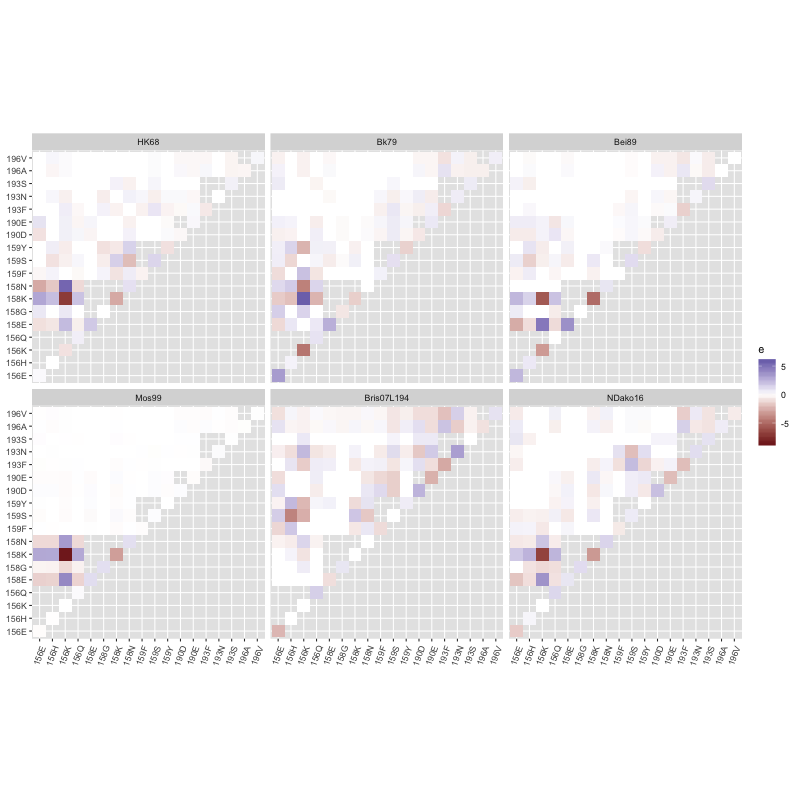

RObject{VecSxp}


In [112]:
dubdf(m, s) = vcat(DataFrame(e = m[:doubles].e, n1 = string.(m[:doubles].pos1).*m[:doubles].aa1, 
            n2 = string.(m[:doubles].pos2).*m[:doubles].aa2, strain=s), 
                DataFrame(e = m[:singles].e, n1 = string.(m[:singles].pos).*m[:singles].aa, 
            n2 = string.(m[:singles].pos).*m[:singles].aa, strain=s))
mbd = map((m,s) -> mapreduce(m->dubdf(m, s), vcat, m), m_nonlin_pair_boot, names)
mbd = reduce(vcat, mbd)
using StatsBase
mbd = by(mbd, [:n1, :n2, :strain], 
    d -> DataFrame(upper=percentile(d.e, 97.5),lower=percentile(d.e, 2.5)))
mdf = map(dubdf, m_nonlin_pair, names)
mdf = reduce(vcat, mdf)
mbd = join(mbd, mdf, on=[:n1,:n2, :strain], kind=:inner)
mbd.e[(mbd[:upper].>0) .& (mbd[:lower].<0)] .= 0

wtc = map( (w,s) -> DataFrame(strain = s, n1 = map(i->string(pos[i])*w[i], 1:6)), wt, names)
wtc = reduce(vcat, wtc)
wtc.n2 = wtc.n1
wtc.type = "WT"

smax = map(d -> d.ID[argmax(d.f)], data)
smaxd = map( (w,s) -> DataFrame(strain = s, n1 = map(i->string(pos[i])*w[i], 1:6)), smax, names)
smaxd = reduce(vcat, smaxd)
smaxd.n2 = smaxd.n1
smaxd.type = "BEST"

wtc = [wtc; smaxd]

R"""
p.nonlinpair = qplot(data=$mbd %>% mutate(strain = factor(strain, levels=$names)) %>%
    group_by(strain) %>% mutate(e = -e/sd(e)), 
    y=n2, x=n1, fill=e, geom="tile") + coord_fixed() + 
    scale_fill_gradient2() + facet_wrap(~strain) +
    #geom_tile(aes(x=n1,y=n2, color=type), size=.2, fill="black",alpha=0, inherit.aes=FALSE,data=$wtc%>% mutate(strain = factor(strain, levels=$names))) +
    theme(axis.text.x = element_text(angle=70, vjust=0.5), 
        panel.background = element_rect(fill="grey90"), axis.title = element_blank())
"""


## linear with pairwise

In [85]:
train1(d) = train(d.f, d.v2, d.ID, wt[1], 2, :linear)
m_lin_pair = map(train1, data)
map(m -> m[:rho], m_lin_pair)


 * Status: success

 * Candidate solution
    Minimizer: [7.26e-01, 9.14e-02, 1.98e-01,  ...]
    Minimum:   8.063159e-02

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.57e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.13e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.94e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.61e-16 ≰ 0.0e+00
    |g(x)|                 = 5.20e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    217
    ∇f(x) calls:   217


 * Status: success

 * Candidate solution
    Minimizer: [-1.56e+00, 2.44e+00, -8.30e-02,  ...]
    Minimum:   1.311933e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.68e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.56e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.46e-16 ≰ 0.0e+00
    |g(x)|                 = 7.68e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    229
    ∇f(x) calls:   229


 * Status: success

 * Candidate solution
    Minimizer: [-5.30e-01, 1.60e+00, 3.80e-01,  ...]
    Minimum:   5.831702e-02

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.77e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.34e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.91e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.00e-15 ≰ 0.0e+00
    |g(x)|                 = 5.40e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    234
    ∇f(x) calls:   234


 * Status: success

 * Candidate solution
    Minimizer: [-5.38e-01, -5.62e-01, -1.07e-01,  ...]
    Minimum:   2.718561e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.75e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.38e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.25e-15 ≰ 0.0e+00
    |g(x)|                 = 2.96e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    80
    f(x) calls:    242
    ∇f(x) calls:   242


 * Status: success

 * Candidate solution
    Minimizer: [5.13e-02, -2.91e-02, -4.19e-01,  ...]
    Minimum:   3.240831e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.96e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.28e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.56e-16 ≰ 0.0e+00
    |g(x)|                 = 9.77e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    225
    ∇f(x) calls:   225


 * Status: success

 * Candidate solution
    Minimizer: [2.28e-01, -4.96e-01, 2.28e-02,  ...]
    Minimum:   6.910365e-02

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.56e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.73e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.53e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.21e-15 ≰ 0.0e+00
    |g(x)|                 = 9.88e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    67
    f(x) calls:    205
    ∇f(x) calls:   205


6-element Array{Float64,1}:
 0.970580869171987 
 0.9802608788975593
 0.9876798614805461
 0.9579632121611231
 0.9538714773655245
 0.9763510753953643

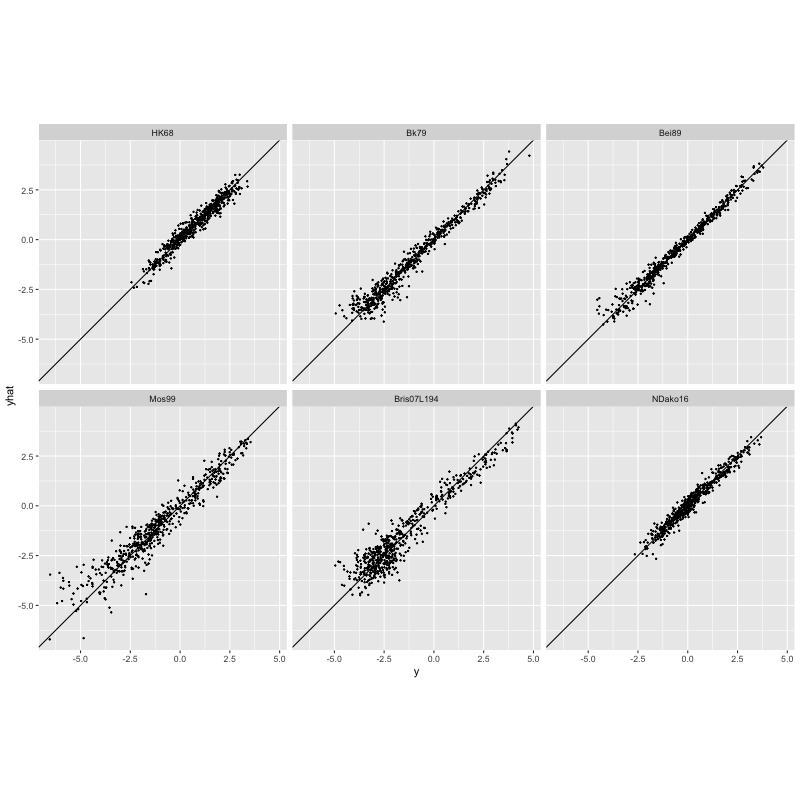

RObject{VecSxp}


In [86]:
mpred = map((m, s, d) -> DataFrame(y = d.f, yhat = m[:yhat], phi=m[:phi], 
                             seq = d.ID, strain = s), m_lin_pair, names, data)
mpred = reduce(vcat, mpred)
R"""
qplot(data=$mpred %>% mutate(strain = factor(strain, levels=$names)), x=y, y=yhat, geom="point", size=I(.3)) + 
    coord_fixed() + facet_wrap(~strain) + geom_abline()

"""

### plot coefs

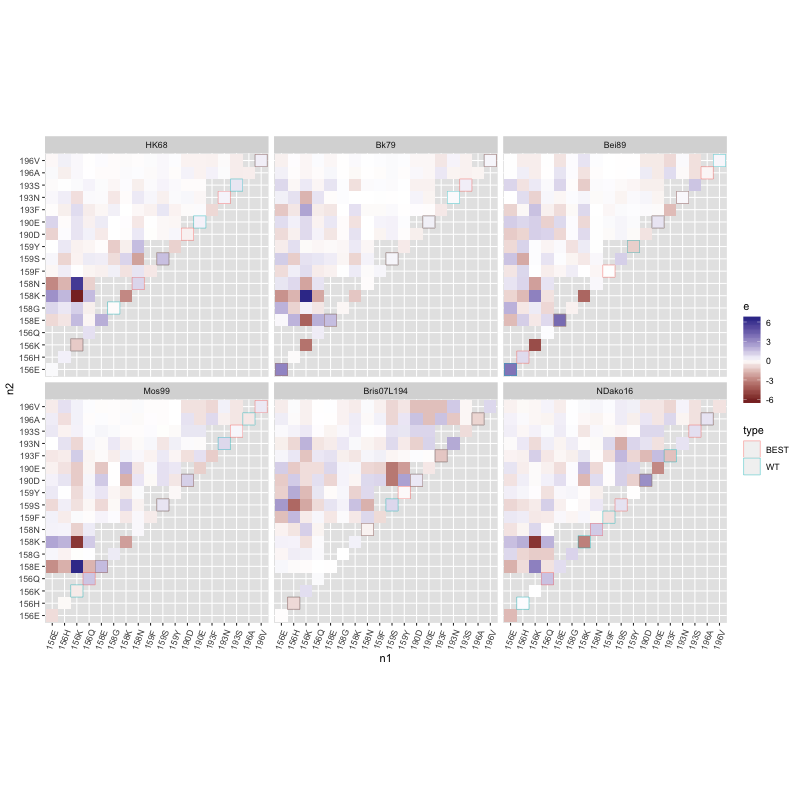

RObject{VecSxp}


In [87]:
m = m_lin_pair
doubles = map((m, s) -> DataFrame(e = m[:doubles].e, 
        n1 = ["$p$a" for (p,a) in zip(m[:doubles].pos1, m[:doubles].aa1)],
        n2 = ["$p$a" for (p,a) in zip(m[:doubles].pos2, m[:doubles].aa2)], strain = s), m, names)
doubles = reduce(vcat, doubles)

singles = map((m, s) -> DataFrame(e = m[:singles].e, 
        n = ["$p$a" for (p,a) in zip(m[:singles].pos, m[:singles].aa)], strain = s), m, names)
singles = reduce(vcat, singles)
singles.n2 = singles.n
rename!(singles, :n => :n1)
doubles = [doubles; singles]

wtc = map( (w,s) -> DataFrame(strain = s, n1 = map(i->string(pos[i])*w[i], 1:6)), wt, names)
wtc = reduce(vcat, wtc)
wtc.n2 = wtc.n1
wtc[!,:type] .= "WT"

smax = map(d -> d.ID[argmax(d.f)], data)
smaxd = map( (w,s) -> DataFrame(strain = s, n1 = map(i->string(pos[i])*w[i], 1:6)), smax, names)
smaxd = reduce(vcat, smaxd)
smaxd.n2 = smaxd.n1
smaxd[!,:type] .= "BEST"

wtc = [wtc; smaxd]
R"""
qplot(data=$doubles %>% mutate(strain = factor(strain, levels=$names)) %>%
    group_by(strain) %>% mutate(e =e/sd(e)), 
    y=n2, x=n1, fill=e, geom="tile") + coord_fixed() + 
    scale_fill_gradient2() + facet_wrap(~strain) +
    geom_tile(aes(x=n1,y=n2, color=type), size=.2, fill="black",alpha=0, inherit.aes=FALSE,data=$wtc%>% mutate(strain = factor(strain, levels=$names))) +
    theme(axis.text.x = element_text(angle=70, vjust=0.5), 
        panel.background = element_rect(fill="grey90"))
"""


### bootstrap

In [90]:

booty(y, v) = randn(length(y)).*sqrt.(v) .+ y
train1b(d) = train(booty(d.f, d.v2), d.v2, d.ID, wt[1], 2, :linear)
m_lin_pair_boot = map(d -> [train1b(d) for i = 1:100], data)

 * Status: success

 * Candidate solution
    Minimizer: [7.48e-01, 6.51e-02, 2.49e-01,  ...]
    Minimum:   1.459476e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.05e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.24e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.00e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.42e-15 ≰ 0.0e+00
    |g(x)|                 = 4.29e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    213
    ∇f(x) calls:   213


 * Status: success

 * Candidate solution
    Minimizer: [7.95e-01, 1.51e-01, 1.50e-01,  ...]
    Minimum:   1.766906e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.01e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.91e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.20e-15 ≰ 0.0e+00
    |g(x)|                 = 3.00e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    218
    ∇f(x) calls:   218


 * Status: success

 * Candidate solution
    Minimizer: [7.17e-01, 5.60e-02, 1.44e-01,  ...]
    Minimum:   1.479862e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.43e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.50e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.55e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.40e-14 ≰ 0.0e+00
    |g(x)|                 = 9.24e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    209
    ∇f(x) calls:   209


 * Status: success

 * Candidate solution
    Minimizer: [6.56e-01, 5.23e-02, 2.86e-01,  ...]
    Minimum:   1.701696e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.73e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.57e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.30e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.35e-14 ≰ 0.0e+00
    |g(x)|                 = 6.80e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    68
    f(x) calls:    201
    ∇f(x) calls:   201


 * Status: success

 * Candidate solution
    Minimizer: [6.78e-01, 9.35e-02, 1.19e-01,  ...]
    Minimum:   1.606039e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.05e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.34e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.64e-16 ≰ 0.0e+00
    |g(x)|                 = 7.65e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    214
    ∇f(x) calls:   214


 * Status: success

 * Candidate solution
    Minimizer: [8.98e-01, 1.56e-02, 2.79e-01,  ...]
    Minimum:   1.633471e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.14e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.71e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.05e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.87e-15 ≰ 0.0e+00
    |g(x)|                 = 5.70e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    225
    ∇f(x) calls:   225


 * Status: success

 * Candidate solution
    Minimizer: [6.46e-01, 1.67e-01, 1.02e-01,  ...]
    Minimum:   1.532697e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.15e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.88e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.03e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.70e-15 ≰ 0.0e+00
    |g(x)|                 = 5.25e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    226
    ∇f(x) calls:   226


 * Status: success

 * Candidate solution
    Minimizer: [7.12e-01, 1.25e-01, 2.58e-01,  ...]
    Minimum:   1.575281e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.55e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.35e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.08e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.96e-14 ≰ 0.0e+00
    |g(x)|                 = 6.47e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    214
    ∇f(x) calls:   214


 * Status: success

 * Candidate solution
    Minimizer: [6.36e-01, 9.91e-02, 3.88e-01,  ...]
    Minimum:   1.658133e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.51e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.31e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.55e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.54e-14 ≰ 0.0e+00
    |g(x)|                 = 6.09e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    210
    ∇f(x) calls:   210


 * Status: success

 * Candidate solution
    Minimizer: [7.28e-01, 1.05e-01, 2.27e-01,  ...]
    Minimum:   1.535159e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.17e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.65e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.44e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.15e-14 ≰ 0.0e+00
    |g(x)|                 = 9.37e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    68
    f(x) calls:    208
    ∇f(x) calls:   208


 * Status: success

 * Candidate solution
    Minimizer: [7.33e-01, 1.16e-01, 1.49e-01,  ...]
    Minimum:   1.574074e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.15e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.42e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.11e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.97e-14 ≰ 0.0e+00
    |g(x)|                 = 6.82e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    211
    ∇f(x) calls:   211


 * Status: success

 * Candidate solution
    Minimizer: [6.39e-01, 1.29e-01, 1.64e-01,  ...]
    Minimum:   1.660440e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.34e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.81e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.06e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.39e-14 ≰ 0.0e+00
    |g(x)|                 = 9.84e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    68
    f(x) calls:    203
    ∇f(x) calls:   203


 * Status: success

 * Candidate solution
    Minimizer: [6.58e-01, 2.40e-02, 1.81e-01,  ...]
    Minimum:   1.672552e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.75e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.99e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.94e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.16e-15 ≰ 0.0e+00
    |g(x)|                 = 2.23e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    209
    ∇f(x) calls:   209


 * Status: success

 * Candidate solution
    Minimizer: [8.46e-01, 9.29e-02, 8.11e-02,  ...]
    Minimum:   1.526765e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.44e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.86e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.45e-15 ≰ 0.0e+00
    |g(x)|                 = 8.59e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    218
    ∇f(x) calls:   218


 * Status: success

 * Candidate solution
    Minimizer: [7.27e-01, 1.47e-01, 1.52e-01,  ...]
    Minimum:   1.609270e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.36e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.44e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.72e-15 ≰ 0.0e+00
    |g(x)|                 = 7.77e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    71
    f(x) calls:    215
    ∇f(x) calls:   215


 * Status: success

 * Candidate solution
    Minimizer: [6.91e-01, 5.43e-02, 2.46e-01,  ...]
    Minimum:   1.778298e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.79e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.39e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.89e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.06e-14 ≰ 0.0e+00
    |g(x)|                 = 5.15e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    68
    f(x) calls:    205
    ∇f(x) calls:   205


 * Status: success

 * Candidate solution
    Minimizer: [7.02e-01, 1.76e-01, 4.27e-02,  ...]
    Minimum:   1.700711e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.58e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.80e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.61e-15 ≰ 0.0e+00
    |g(x)|                 = 3.76e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    211
    ∇f(x) calls:   211


 * Status: success

 * Candidate solution
    Minimizer: [6.68e-01, 1.11e-01, 1.61e-01,  ...]
    Minimum:   1.426992e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.27e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.37e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.50e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.45e-14 ≰ 0.0e+00
    |g(x)|                 = 1.00e-08 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    68
    f(x) calls:    206
    ∇f(x) calls:   206


 * Status: success

 * Candidate solution
    Minimizer: [6.04e-01, 1.92e-01, 1.33e-01,  ...]
    Minimum:   1.653989e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.35e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.42e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.83e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.52e-15 ≰ 0.0e+00
    |g(x)|                 = 4.51e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    216
    ∇f(x) calls:   216


 * Status: success

 * Candidate solution
    Minimizer: [7.06e-01, 4.05e-02, 3.09e-01,  ...]
    Minimum:   1.710734e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.58e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.92e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.46e-15 ≰ 0.0e+00
    |g(x)|                 = 4.32e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    212
    ∇f(x) calls:   212


 * Status: success

 * Candidate solution
    Minimizer: [6.52e-01, 1.90e-01, 2.93e-01,  ...]
    Minimum:   1.553753e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.74e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.50e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.93e-16 ≰ 0.0e+00
    |g(x)|                 = 6.95e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    210
    ∇f(x) calls:   210


 * Status: success

 * Candidate solution
    Minimizer: [6.59e-01, 4.95e-02, 3.41e-01,  ...]
    Minimum:   1.484373e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.90e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.71e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.50e-15 ≰ 0.0e+00
    |g(x)|                 = 4.01e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    218
    ∇f(x) calls:   218


 * Status: success

 * Candidate solution
    Minimizer: [7.92e-01, 6.14e-02, 2.18e-01,  ...]
    Minimum:   1.635508e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.14e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.25e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.71e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.94e-15 ≰ 0.0e+00
    |g(x)|                 = 4.46e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    215
    ∇f(x) calls:   215


 * Status: success

 * Candidate solution
    Minimizer: [6.40e-01, 2.05e-01, 1.33e-01,  ...]
    Minimum:   1.554644e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.08e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.20e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.14e-15 ≰ 0.0e+00
    |g(x)|                 = 3.65e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    210
    ∇f(x) calls:   210


 * Status: success

 * Candidate solution
    Minimizer: [6.10e-01, 1.70e-01, 1.19e-01,  ...]
    Minimum:   1.488674e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.08e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.92e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.16e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.80e-15 ≰ 0.0e+00
    |g(x)|                 = 6.38e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    212
    ∇f(x) calls:   212


 * Status: success

 * Candidate solution
    Minimizer: [7.82e-01, 1.91e-01, 1.89e-01,  ...]
    Minimum:   1.524684e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.51e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.50e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.64e-15 ≰ 0.0e+00
    |g(x)|                 = 4.67e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    205
    ∇f(x) calls:   205


 * Status: success

 * Candidate solution
    Minimizer: [8.55e-01, 1.31e-01, 1.87e-01,  ...]
    Minimum:   1.521946e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.19e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.40e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.19e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.44e-14 ≰ 0.0e+00
    |g(x)|                 = 5.64e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    216
    ∇f(x) calls:   216


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [6.87e-01, 1.74e-01, 2.38e-01,  ...]
    Minimum:   1.509818e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.69e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.01e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.35e-16 ≰ 0.0e+00
    |g(x)|                 = 1.48e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    220
    ∇f(x) calls:   220


 * Status: success

 * Candidate solution
    Minimizer: [7.22e-01, 4.83e-02, 2.92e-01,  ...]
    Minimum:   1.631496e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.13e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.93e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.00e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.06e-15 ≰ 0.0e+00
    |g(x)|                 = 4.64e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    230
    ∇f(x) calls:   230


 * Status: success

 * Candidate solution
    Minimizer: [7.39e-01, -4.86e-03, 2.32e-01,  ...]
    Minimum:   1.548067e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.37e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.81e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.69e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.38e-14 ≰ 0.0e+00
    |g(x)|                 = 9.69e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    207
    ∇f(x) calls:   207


 * Status: success

 * Candidate solution
    Minimizer: [6.89e-01, 4.00e-02, 7.69e-02,  ...]
    Minimum:   1.646872e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.51e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.20e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.16e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.56e-15 ≰ 0.0e+00
    |g(x)|                 = 8.16e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    68
    f(x) calls:    206
    ∇f(x) calls:   206


 * Status: success

 * Candidate solution
    Minimizer: [6.06e-01, 2.79e-02, 2.71e-01,  ...]
    Minimum:   1.487199e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.20e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.60e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.68e-15 ≰ 0.0e+00
    |g(x)|                 = 4.17e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    219
    ∇f(x) calls:   219


 * Status: success

 * Candidate solution
    Minimizer: [8.50e-01, 1.09e-02, 3.60e-01,  ...]
    Minimum:   1.739564e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.17e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.94e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.05e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.76e-15 ≰ 0.0e+00
    |g(x)|                 = 7.57e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    208
    ∇f(x) calls:   208


 * Status: success

 * Candidate solution
    Minimizer: [6.21e-01, 1.72e-01, 1.16e-01,  ...]
    Minimum:   1.655967e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.62e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.96e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.66e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.61e-14 ≰ 0.0e+00
    |g(x)|                 = 7.20e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    214
    ∇f(x) calls:   214


 * Status: success

 * Candidate solution
    Minimizer: [7.39e-01, 1.40e-01, 5.47e-02,  ...]
    Minimum:   1.498021e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.24e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.20e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.28e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.19e-14 ≰ 0.0e+00
    |g(x)|                 = 8.04e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    212
    ∇f(x) calls:   212


 * Status: success

 * Candidate solution
    Minimizer: [8.09e-01, 1.83e-01, 8.43e-02,  ...]
    Minimum:   1.663912e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.80e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.77e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.33e-15 ≰ 0.0e+00
    |g(x)|                 = 4.08e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    214
    ∇f(x) calls:   214


 * Status: success

 * Candidate solution
    Minimizer: [8.12e-01, 1.20e-01, 1.67e-01,  ...]
    Minimum:   1.571467e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.49e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.01e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.16e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.83e-15 ≰ 0.0e+00
    |g(x)|                 = 9.78e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    209
    ∇f(x) calls:   209


 * Status: success

 * Candidate solution
    Minimizer: [7.12e-01, 1.43e-01, 1.23e-01,  ...]
    Minimum:   1.442515e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.20e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.15e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.55e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.77e-14 ≰ 0.0e+00
    |g(x)|                 = 9.80e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    212
    ∇f(x) calls:   212


 * Status: success

 * Candidate solution
    Minimizer: [7.30e-01, 1.26e-01, 1.76e-01,  ...]
    Minimum:   1.700509e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.07e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.23e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.27e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.10e-15 ≰ 0.0e+00
    |g(x)|                 = 8.38e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    209
    ∇f(x) calls:   209


 * Status: success

 * Candidate solution
    Minimizer: [8.57e-01, 1.15e-01, 1.07e-01,  ...]
    Minimum:   1.481966e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.85e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.66e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.05e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.06e-14 ≰ 0.0e+00
    |g(x)|                 = 3.72e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    217
    ∇f(x) calls:   217


 * Status: success

 * Candidate solution
    Minimizer: [6.88e-01, 1.76e-01, 9.31e-02,  ...]
    Minimum:   1.608373e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.17e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.32e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.05e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.00e-15 ≰ 0.0e+00
    |g(x)|                 = 3.89e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    206
    ∇f(x) calls:   206


 * Status: success

 * Candidate solution
    Minimizer: [7.60e-01, 5.23e-02, 2.51e-01,  ...]
    Minimum:   1.525946e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.97e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.57e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.64e-15 ≰ 0.0e+00
    |g(x)|                 = 4.46e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    208
    ∇f(x) calls:   208


 * Status: success

 * Candidate solution
    Minimizer: [6.86e-01, 5.76e-02, 2.95e-01,  ...]
    Minimum:   1.518542e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.70e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.07e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.69e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.11e-14 ≰ 0.0e+00
    |g(x)|                 = 8.27e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    211
    ∇f(x) calls:   211


 * Status: success

 * Candidate solution
    Minimizer: [5.66e-01, 1.90e-01, 1.69e-01,  ...]
    Minimum:   1.673435e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.10e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.13e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.16e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.29e-14 ≰ 0.0e+00
    |g(x)|                 = 3.42e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    68
    f(x) calls:    209
    ∇f(x) calls:   209


 * Status: success

 * Candidate solution
    Minimizer: [6.70e-01, 8.11e-02, 1.46e-01,  ...]
    Minimum:   1.553183e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.81e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.86e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.94e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.25e-15 ≰ 0.0e+00
    |g(x)|                 = 8.67e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    204
    ∇f(x) calls:   204


 * Status: success

 * Candidate solution
    Minimizer: [7.39e-01, -6.69e-02, 3.17e-01,  ...]
    Minimum:   1.533755e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.06e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.41e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.24e-16 ≰ 0.0e+00
    |g(x)|                 = 3.56e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    210
    ∇f(x) calls:   210


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [7.98e-01, -3.48e-02, 2.41e-01,  ...]
    Minimum:   1.533802e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.11e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.60e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.09e-15 ≰ 0.0e+00
    |g(x)|                 = 1.22e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    214
    ∇f(x) calls:   214


 * Status: success

 * Candidate solution
    Minimizer: [7.67e-01, 1.27e-01, 2.15e-01,  ...]
    Minimum:   1.542312e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.00e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.49e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.72e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.06e-15 ≰ 0.0e+00
    |g(x)|                 = 7.53e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    213
    ∇f(x) calls:   213


 * Status: success

 * Candidate solution
    Minimizer: [6.12e-01, 2.12e-01, -6.63e-02,  ...]
    Minimum:   1.482872e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.47e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.68e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.25e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.52e-14 ≰ 0.0e+00
    |g(x)|                 = 6.53e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    215
    ∇f(x) calls:   215


 * Status: success

 * Candidate solution
    Minimizer: [8.18e-01, 1.19e-01, 1.19e-01,  ...]
    Minimum:   1.512246e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.00e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.15e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.94e-15 ≰ 0.0e+00
    |g(x)|                 = 4.78e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    217
    ∇f(x) calls:   217


 * Status: success

 * Candidate solution
    Minimizer: [7.40e-01, 1.42e-01, 2.87e-01,  ...]
    Minimum:   1.662125e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.02e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.38e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.50e-14 ≰ 0.0e+00
    |g(x)|                 = 8.41e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    209
    ∇f(x) calls:   209


 * Status: success

 * Candidate solution
    Minimizer: [7.31e-01, -1.55e-02, 2.28e-01,  ...]
    Minimum:   1.649127e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.02e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.24e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.36e-15 ≰ 0.0e+00
    |g(x)|                 = 8.68e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    214
    ∇f(x) calls:   214


 * Status: success

 * Candidate solution
    Minimizer: [7.47e-01, 1.72e-01, 2.00e-01,  ...]
    Minimum:   1.611714e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.30e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.89e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.25e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.75e-15 ≰ 0.0e+00
    |g(x)|                 = 5.36e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    218
    ∇f(x) calls:   218


 * Status: success

 * Candidate solution
    Minimizer: [7.70e-01, 1.15e-02, 1.90e-01,  ...]
    Minimum:   1.489459e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.73e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.68e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.94e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.98e-14 ≰ 0.0e+00
    |g(x)|                 = 6.53e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    224
    ∇f(x) calls:   224


 * Status: success

 * Candidate solution
    Minimizer: [7.30e-01, 8.43e-02, 1.84e-01,  ...]
    Minimum:   1.603981e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.06e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.22e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.05e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.02e-15 ≰ 0.0e+00
    |g(x)|                 = 5.80e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    208
    ∇f(x) calls:   208


 * Status: success

 * Candidate solution
    Minimizer: [6.56e-01, 5.15e-02, 2.03e-01,  ...]
    Minimum:   1.590704e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.55e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.09e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.17e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.33e-15 ≰ 0.0e+00
    |g(x)|                 = 5.41e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    215
    ∇f(x) calls:   215


 * Status: success

 * Candidate solution
    Minimizer: [7.25e-01, 7.74e-02, 3.15e-01,  ...]
    Minimum:   1.466566e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.28e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.62e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.08e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.42e-14 ≰ 0.0e+00
    |g(x)|                 = 8.22e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    208
    ∇f(x) calls:   208


 * Status: success

 * Candidate solution
    Minimizer: [6.39e-01, 1.90e-01, 2.65e-01,  ...]
    Minimum:   1.616076e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.19e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.08e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.66e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.12e-15 ≰ 0.0e+00
    |g(x)|                 = 5.17e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    210
    ∇f(x) calls:   210


 * Status: success

 * Candidate solution
    Minimizer: [6.17e-01, 9.90e-02, 2.74e-01,  ...]
    Minimum:   1.600365e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.49e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.01e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.43e-15 ≰ 0.0e+00
    |g(x)|                 = 9.35e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    218
    ∇f(x) calls:   218


 * Status: success

 * Candidate solution
    Minimizer: [8.04e-01, 1.00e-01, 1.44e-01,  ...]
    Minimum:   1.486241e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.42e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.43e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.35e-15 ≰ 0.0e+00
    |g(x)|                 = 4.32e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    212
    ∇f(x) calls:   212


 * Status: success

 * Candidate solution
    Minimizer: [7.60e-01, 7.26e-02, 1.83e-01,  ...]
    Minimum:   1.489031e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.86e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.90e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.12e-15 ≰ 0.0e+00
    |g(x)|                 = 5.25e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    218
    ∇f(x) calls:   218


 * Status: success

 * Candidate solution
    Minimizer: [5.90e-01, 1.60e-01, 2.41e-01,  ...]
    Minimum:   1.637542e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.69e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.66e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.94e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.19e-15 ≰ 0.0e+00
    |g(x)|                 = 4.42e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    220
    ∇f(x) calls:   220


 * Status: success

 * Candidate solution
    Minimizer: [7.34e-01, 1.08e-01, 1.23e-01,  ...]
    Minimum:   1.517120e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.04e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.16e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.83e-16 ≰ 0.0e+00
    |g(x)|                 = 7.35e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    222
    ∇f(x) calls:   222


 * Status: success

 * Candidate solution
    Minimizer: [7.15e-01, -9.16e-03, 2.15e-01,  ...]
    Minimum:   1.493075e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.08e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.47e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.67e-15 ≰ 0.0e+00
    |g(x)|                 = 7.12e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    209
    ∇f(x) calls:   209


 * Status: success

 * Candidate solution
    Minimizer: [6.77e-01, 2.99e-02, 2.68e-01,  ...]
    Minimum:   1.555035e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.30e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.09e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.55e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.00e-14 ≰ 0.0e+00
    |g(x)|                 = 4.44e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    211
    ∇f(x) calls:   211


 * Status: success

 * Candidate solution
    Minimizer: [7.48e-01, -1.85e-02, 1.36e-01,  ...]
    Minimum:   1.600100e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.01e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.37e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.64e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.02e-14 ≰ 0.0e+00
    |g(x)|                 = 6.23e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    207
    ∇f(x) calls:   207


 * Status: success

 * Candidate solution
    Minimizer: [7.37e-01, 4.53e-02, 2.38e-01,  ...]
    Minimum:   1.627904e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.84e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.24e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.05e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.88e-15 ≰ 0.0e+00
    |g(x)|                 = 9.47e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    208
    ∇f(x) calls:   208


 * Status: success

 * Candidate solution
    Minimizer: [8.32e-01, 8.92e-02, 1.92e-01,  ...]
    Minimum:   1.558256e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.73e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.99e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.47e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.59e-14 ≰ 0.0e+00
    |g(x)|                 = 6.93e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    215
    ∇f(x) calls:   215


 * Status: success

 * Candidate solution
    Minimizer: [7.65e-01, 5.85e-02, 1.80e-01,  ...]
    Minimum:   1.658886e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.80e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.67e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.99e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.02e-15 ≰ 0.0e+00
    |g(x)|                 = 3.89e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    218
    ∇f(x) calls:   218


 * Status: success

 * Candidate solution
    Minimizer: [8.01e-01, 6.89e-02, 1.89e-01,  ...]
    Minimum:   1.629324e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.77e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.12e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.55e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.54e-15 ≰ 0.0e+00
    |g(x)|                 = 4.12e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    212
    ∇f(x) calls:   212


 * Status: success

 * Candidate solution
    Minimizer: [8.14e-01, 3.47e-02, 1.48e-01,  ...]
    Minimum:   1.455819e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.04e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.86e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.08e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.43e-14 ≰ 0.0e+00
    |g(x)|                 = 5.36e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    212
    ∇f(x) calls:   212


 * Status: success

 * Candidate solution
    Minimizer: [6.83e-01, 9.70e-02, 2.93e-01,  ...]
    Minimum:   1.712671e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.77e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.74e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.59e-13 ≰ 0.0e+00
    |g(x)|                 = 9.60e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    67
    f(x) calls:    202
    ∇f(x) calls:   202


 * Status: success

 * Candidate solution
    Minimizer: [6.98e-01, 1.23e-01, 2.08e-01,  ...]
    Minimum:   1.576427e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.09e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.21e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.08e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.87e-15 ≰ 0.0e+00
    |g(x)|                 = 5.45e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    209
    ∇f(x) calls:   209


 * Status: success

 * Candidate solution
    Minimizer: [8.09e-01, 1.33e-01, 1.27e-01,  ...]
    Minimum:   1.497415e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.59e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.04e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.33e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.90e-15 ≰ 0.0e+00
    |g(x)|                 = 6.73e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    214
    ∇f(x) calls:   214


 * Status: success

 * Candidate solution
    Minimizer: [7.12e-01, 6.32e-02, 2.22e-01,  ...]
    Minimum:   1.671689e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.85e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.70e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.08e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.48e-15 ≰ 0.0e+00
    |g(x)|                 = 6.14e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    218
    ∇f(x) calls:   218


 * Status: success

 * Candidate solution
    Minimizer: [7.15e-01, 5.26e-02, 2.85e-01,  ...]
    Minimum:   1.652614e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.25e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.96e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.47e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.10e-14 ≰ 0.0e+00
    |g(x)|                 = 7.45e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    205
    ∇f(x) calls:   205


 * Status: success

 * Candidate solution
    Minimizer: [6.27e-01, 8.86e-02, 2.21e-01,  ...]
    Minimum:   1.590755e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.29e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.21e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.03e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.90e-14 ≰ 0.0e+00
    |g(x)|                 = 5.71e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    214
    ∇f(x) calls:   214


 * Status: success

 * Candidate solution
    Minimizer: [7.02e-01, 6.85e-02, 1.36e-01,  ...]
    Minimum:   1.502614e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.16e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.28e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.60e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.73e-15 ≰ 0.0e+00
    |g(x)|                 = 5.59e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    203
    ∇f(x) calls:   203


 * Status: success

 * Candidate solution
    Minimizer: [7.20e-01, 1.95e-01, 2.67e-01,  ...]
    Minimum:   1.548501e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.91e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.11e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.15e-15 ≰ 0.0e+00
    |g(x)|                 = 5.42e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    216
    ∇f(x) calls:   216


 * Status: success

 * Candidate solution
    Minimizer: [7.73e-01, 1.20e-01, 3.08e-01,  ...]
    Minimum:   1.527573e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.71e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.10e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.45e-15 ≰ 0.0e+00
    |g(x)|                 = 9.37e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    218
    ∇f(x) calls:   218


 * Status: success

 * Candidate solution
    Minimizer: [5.88e-01, 7.76e-02, 3.27e-01,  ...]
    Minimum:   1.410264e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.45e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.98e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.50e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.19e-14 ≰ 0.0e+00
    |g(x)|                 = 9.47e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    211
    ∇f(x) calls:   211


 * Status: success

 * Candidate solution
    Minimizer: [6.93e-01, 3.52e-02, 3.19e-01,  ...]
    Minimum:   1.557073e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.99e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.17e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.27e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.39e-15 ≰ 0.0e+00
    |g(x)|                 = 9.82e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    210
    ∇f(x) calls:   210


 * Status: success

 * Candidate solution
    Minimizer: [7.81e-01, 2.06e-03, 2.42e-01,  ...]
    Minimum:   1.709009e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.46e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.63e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.05e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.71e-15 ≰ 0.0e+00
    |g(x)|                 = 6.62e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    213
    ∇f(x) calls:   213


 * Status: success

 * Candidate solution
    Minimizer: [6.58e-01, 4.66e-02, 2.51e-01,  ...]
    Minimum:   1.579740e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.64e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.55e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.27e-15 ≰ 0.0e+00
    |g(x)|                 = 9.08e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    208
    ∇f(x) calls:   208


 * Status: success

 * Candidate solution
    Minimizer: [7.94e-01, 2.14e-01, 1.04e-01,  ...]
    Minimum:   1.671844e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.28e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.09e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.39e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.43e-14 ≰ 0.0e+00
    |g(x)|                 = 7.40e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    220
    ∇f(x) calls:   220


 * Status: success

 * Candidate solution
    Minimizer: [8.75e-01, 1.35e-03, 2.44e-01,  ...]
    Minimum:   1.648546e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.03e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.94e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.61e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.19e-15 ≰ 0.0e+00
    |g(x)|                 = 4.93e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    220
    ∇f(x) calls:   220


 * Status: success

 * Candidate solution
    Minimizer: [7.48e-01, 1.60e-01, 1.74e-01,  ...]
    Minimum:   1.571898e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.24e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.33e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.99e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.36e-15 ≰ 0.0e+00
    |g(x)|                 = 4.85e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    209
    ∇f(x) calls:   209


 * Status: success

 * Candidate solution
    Minimizer: [7.38e-01, -3.55e-02, 2.08e-01,  ...]
    Minimum:   1.877778e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.49e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.64e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.72e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.51e-15 ≰ 0.0e+00
    |g(x)|                 = 5.61e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    210
    ∇f(x) calls:   210


 * Status: success

 * Candidate solution
    Minimizer: [7.66e-01, 7.53e-02, 2.26e-01,  ...]
    Minimum:   1.566100e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.65e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.30e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.80e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.15e-14 ≰ 0.0e+00
    |g(x)|                 = 9.59e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    203
    ∇f(x) calls:   203


 * Status: success

 * Candidate solution
    Minimizer: [6.74e-01, 2.73e-02, 3.08e-01,  ...]
    Minimum:   1.509550e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.73e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.25e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.19e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.11e-14 ≰ 0.0e+00
    |g(x)|                 = 6.57e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    215
    ∇f(x) calls:   215


 * Status: success

 * Candidate solution
    Minimizer: [7.58e-01, 6.77e-02, 2.41e-01,  ...]
    Minimum:   1.603165e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.85e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.29e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.66e-16 ≰ 0.0e+00
    |g(x)|                 = 5.17e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    214
    ∇f(x) calls:   214


 * Status: success

 * Candidate solution
    Minimizer: [7.24e-01, 9.00e-02, 2.29e-01,  ...]
    Minimum:   1.515929e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.82e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.77e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.20e-15 ≰ 0.0e+00
    |g(x)|                 = 3.79e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    211
    ∇f(x) calls:   211


 * Status: success

 * Candidate solution
    Minimizer: [9.47e-01, 5.35e-02, 1.49e-01,  ...]
    Minimum:   1.468971e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.36e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.39e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.44e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.66e-14 ≰ 0.0e+00
    |g(x)|                 = 9.66e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    205
    ∇f(x) calls:   205


 * Status: success

 * Candidate solution
    Minimizer: [8.56e-01, 6.05e-02, 1.05e-01,  ...]
    Minimum:   1.687548e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.42e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.12e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.41e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.43e-14 ≰ 0.0e+00
    |g(x)|                 = 3.56e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    209
    ∇f(x) calls:   209


 * Status: success

 * Candidate solution
    Minimizer: [6.95e-01, 1.31e-01, 4.94e-02,  ...]
    Minimum:   1.649806e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.01e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.78e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.41e-16 ≰ 0.0e+00
    |g(x)|                 = 9.30e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    209
    ∇f(x) calls:   209


 * Status: success

 * Candidate solution
    Minimizer: [7.51e-01, -1.07e-02, 2.12e-01,  ...]
    Minimum:   1.657616e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.24e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.09e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.67e-16 ≰ 0.0e+00
    |g(x)|                 = 6.84e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    222
    ∇f(x) calls:   222


 * Status: success

 * Candidate solution
    Minimizer: [7.14e-01, 1.44e-01, 1.41e-01,  ...]
    Minimum:   1.700539e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.41e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.67e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.90e-16 ≰ 0.0e+00
    |g(x)|                 = 3.21e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    223
    ∇f(x) calls:   223


 * Status: success

 * Candidate solution
    Minimizer: [7.23e-01, 1.37e-01, 2.13e-01,  ...]
    Minimum:   1.409920e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.12e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.85e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.61e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.56e-15 ≰ 0.0e+00
    |g(x)|                 = 4.71e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    220
    ∇f(x) calls:   220


 * Status: success

 * Candidate solution
    Minimizer: [7.32e-01, 1.49e-01, 3.65e-02,  ...]
    Minimum:   1.574639e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.90e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.26e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.41e-14 ≰ 0.0e+00
    |g(x)|                 = 4.67e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    205
    ∇f(x) calls:   205


 * Status: success

 * Candidate solution
    Minimizer: [8.82e-01, 3.02e-02, 1.44e-01,  ...]
    Minimum:   1.615225e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.31e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.46e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.75e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.08e-14 ≰ 0.0e+00
    |g(x)|                 = 4.94e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    211
    ∇f(x) calls:   211


 * Status: success

 * Candidate solution
    Minimizer: [-1.42e+00, 2.49e+00, -2.56e-01,  ...]
    Minimum:   1.995775e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.46e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.79e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.34e-16 ≰ 0.0e+00
    |g(x)|                 = 9.03e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    236
    ∇f(x) calls:   236


 * Status: success

 * Candidate solution
    Minimizer: [-1.57e+00, 2.49e+00, -1.21e-01,  ...]
    Minimum:   2.217956e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.51e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.41e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.69e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.63e-15 ≰ 0.0e+00
    |g(x)|                 = 9.60e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    229
    ∇f(x) calls:   229


 * Status: success

 * Candidate solution
    Minimizer: [-1.72e+00, 2.53e+00, -2.52e-01,  ...]
    Minimum:   2.173468e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.63e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.04e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.17e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.36e-15 ≰ 0.0e+00
    |g(x)|                 = 8.70e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    234
    ∇f(x) calls:   234


 * Status: success

 * Candidate solution
    Minimizer: [-1.56e+00, 2.41e+00, -2.82e-02,  ...]
    Minimum:   2.280086e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.63e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.74e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.22e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.36e-15 ≰ 0.0e+00
    |g(x)|                 = 9.57e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    224
    ∇f(x) calls:   224


 * Status: success

 * Candidate solution
    Minimizer: [-1.58e+00, 2.42e+00, -2.03e-02,  ...]
    Minimum:   2.206102e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.45e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.43e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.78e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.05e-15 ≰ 0.0e+00
    |g(x)|                 = 6.95e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    219
    ∇f(x) calls:   219


 * Status: success

 * Candidate solution
    Minimizer: [-1.65e+00, 2.40e+00, -1.03e-01,  ...]
    Minimum:   2.352922e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.31e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.80e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.36e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.78e-15 ≰ 0.0e+00
    |g(x)|                 = 2.54e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    81
    f(x) calls:    246
    ∇f(x) calls:   246


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.74e+00, 2.50e+00, -6.51e-02,  ...]
    Minimum:   2.255441e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.39e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.75e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.15e-16 ≰ 0.0e+00
    |g(x)|                 = 1.42e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    230
    ∇f(x) calls:   230


 * Status: success

 * Candidate solution
    Minimizer: [-1.69e+00, 2.46e+00, 1.60e-03,  ...]
    Minimum:   2.304743e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.55e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.85e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.20e-14 ≰ 0.0e+00
    |g(x)|                 = 9.39e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    229
    ∇f(x) calls:   229


 * Status: success

 * Candidate solution
    Minimizer: [-1.52e+00, 2.46e+00, -1.56e-01,  ...]
    Minimum:   2.349687e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.58e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.27e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.61e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.54e-14 ≰ 0.0e+00
    |g(x)|                 = 9.31e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    236
    ∇f(x) calls:   236


 * Status: success

 * Candidate solution
    Minimizer: [-1.55e+00, 2.41e+00, -1.38e-01,  ...]
    Minimum:   2.174569e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.34e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.72e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.36e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.25e-15 ≰ 0.0e+00
    |g(x)|                 = 9.58e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    223
    ∇f(x) calls:   223


 * Status: success

 * Candidate solution
    Minimizer: [-1.44e+00, 2.42e+00, -1.15e-01,  ...]
    Minimum:   2.184799e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.90e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.83e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.16e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.19e-15 ≰ 0.0e+00
    |g(x)|                 = 6.50e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    224
    ∇f(x) calls:   224


 * Status: success

 * Candidate solution
    Minimizer: [-1.58e+00, 2.29e+00, -2.15e-01,  ...]
    Minimum:   1.942935e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.05e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.64e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.29e-15 ≰ 0.0e+00
    |g(x)|                 = 5.94e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    219
    ∇f(x) calls:   219


 * Status: success

 * Candidate solution
    Minimizer: [-1.46e+00, 2.31e+00, 4.77e-02,  ...]
    Minimum:   2.368472e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.07e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.63e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 4.01e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    234
    ∇f(x) calls:   234


 * Status: success

 * Candidate solution
    Minimizer: [-1.54e+00, 2.54e+00, -1.07e-01,  ...]
    Minimum:   1.970952e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.37e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.29e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.94e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.86e-16 ≰ 0.0e+00
    |g(x)|                 = 7.64e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    238
    ∇f(x) calls:   238


 * Status: success

 * Candidate solution
    Minimizer: [-1.63e+00, 2.54e+00, -9.48e-03,  ...]
    Minimum:   2.139740e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.20e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.26e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.03e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.80e-15 ≰ 0.0e+00
    |g(x)|                 = 6.18e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    241
    ∇f(x) calls:   241


 * Status: success

 * Candidate solution
    Minimizer: [-1.66e+00, 2.43e+00, 5.47e-02,  ...]
    Minimum:   2.265065e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.03e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.25e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.80e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.96e-15 ≰ 0.0e+00
    |g(x)|                 = 8.66e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    232
    ∇f(x) calls:   232


 * Status: success

 * Candidate solution
    Minimizer: [-1.69e+00, 2.50e+00, 6.14e-03,  ...]
    Minimum:   2.278981e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.42e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.67e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.44e-15 ≰ 0.0e+00
    |g(x)|                 = 6.18e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    229
    ∇f(x) calls:   229


 * Status: success

 * Candidate solution
    Minimizer: [-1.67e+00, 2.48e+00, -5.10e-02,  ...]
    Minimum:   2.249158e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.32e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.36e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.42e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.29e-15 ≰ 0.0e+00
    |g(x)|                 = 7.40e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    224
    ∇f(x) calls:   224


 * Status: success

 * Candidate solution
    Minimizer: [-1.43e+00, 2.32e+00, -1.51e-01,  ...]
    Minimum:   2.005120e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.91e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.23e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.03e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.12e-15 ≰ 0.0e+00
    |g(x)|                 = 9.01e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    221
    ∇f(x) calls:   221


 * Status: success

 * Candidate solution
    Minimizer: [-1.56e+00, 2.45e+00, -7.73e-02,  ...]
    Minimum:   2.010177e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.01e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.20e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.21e-15 ≰ 0.0e+00
    |g(x)|                 = 7.18e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    80
    f(x) calls:    239
    ∇f(x) calls:   239


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.58e+00, 2.41e+00, -1.08e-01,  ...]
    Minimum:   2.139076e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.15e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.92e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.49e-16 ≰ 0.0e+00
    |g(x)|                 = 1.83e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    223
    ∇f(x) calls:   223


 * Status: success

 * Candidate solution
    Minimizer: [-1.57e+00, 2.47e+00, -3.69e-02,  ...]
    Minimum:   2.256893e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.09e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.43e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.05e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.57e-15 ≰ 0.0e+00
    |g(x)|                 = 7.30e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    229
    ∇f(x) calls:   229


 * Status: success

 * Candidate solution
    Minimizer: [-1.71e+00, 2.50e+00, -1.32e-01,  ...]
    Minimum:   2.283575e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.07e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.28e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.14e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.98e-15 ≰ 0.0e+00
    |g(x)|                 = 8.14e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    238
    ∇f(x) calls:   238


 * Status: success

 * Candidate solution
    Minimizer: [-1.65e+00, 2.46e+00, -4.95e-02,  ...]
    Minimum:   2.185079e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.77e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.53e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.27e-15 ≰ 0.0e+00
    |g(x)|                 = 7.16e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    220
    ∇f(x) calls:   220


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.49e+00, 2.41e+00, -1.56e-01,  ...]
    Minimum:   2.047301e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.17e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.02e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.42e-16 ≰ 0.0e+00
    |g(x)|                 = 2.64e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    222
    ∇f(x) calls:   222


 * Status: success

 * Candidate solution
    Minimizer: [-1.43e+00, 2.37e+00, -2.54e-01,  ...]
    Minimum:   2.073216e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.10e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.63e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.61e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.74e-15 ≰ 0.0e+00
    |g(x)|                 = 2.66e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    238
    ∇f(x) calls:   238


 * Status: success

 * Candidate solution
    Minimizer: [-1.40e+00, 2.35e+00, -1.71e-01,  ...]
    Minimum:   2.263697e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.82e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.75e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.75e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.10e-14 ≰ 0.0e+00
    |g(x)|                 = 9.69e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    233
    ∇f(x) calls:   233


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.67e+00, 2.51e+00, -4.92e-02,  ...]
    Minimum:   2.175563e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.44e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.71e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.83e-16 ≰ 0.0e+00
    |g(x)|                 = 1.79e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    73
    f(x) calls:    219
    ∇f(x) calls:   219


 * Status: success

 * Candidate solution
    Minimizer: [-1.66e+00, 2.46e+00, -1.18e-01,  ...]
    Minimum:   2.107562e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.37e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.57e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.27e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.50e-15 ≰ 0.0e+00
    |g(x)|                 = 5.06e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    235
    ∇f(x) calls:   235


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.53e+00, 2.45e+00, -1.33e-01,  ...]
    Minimum:   2.157967e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.78e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.24e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.94e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.00e-16 ≰ 0.0e+00
    |g(x)|                 = 1.33e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    225
    ∇f(x) calls:   225


 * Status: success

 * Candidate solution
    Minimizer: [-1.60e+00, 2.26e+00, -3.61e-02,  ...]
    Minimum:   2.243598e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.93e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.40e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.94e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.20e-14 ≰ 0.0e+00
    |g(x)|                 = 9.77e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    227
    ∇f(x) calls:   227


 * Status: success

 * Candidate solution
    Minimizer: [-1.56e+00, 2.50e+00, -1.07e-01,  ...]
    Minimum:   2.225135e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.33e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.93e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.61e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.62e-15 ≰ 0.0e+00
    |g(x)|                 = 3.75e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    82
    f(x) calls:    249
    ∇f(x) calls:   249


 * Status: success

 * Candidate solution
    Minimizer: [-1.51e+00, 2.37e+00, -8.78e-02,  ...]
    Minimum:   2.283050e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.33e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.83e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.08e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.74e-15 ≰ 0.0e+00
    |g(x)|                 = 6.27e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    234
    ∇f(x) calls:   234


 * Status: success

 * Candidate solution
    Minimizer: [-1.58e+00, 2.46e+00, -1.73e-01,  ...]
    Minimum:   2.130633e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.95e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.91e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 9.12e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    226
    ∇f(x) calls:   226


 * Status: success

 * Candidate solution
    Minimizer: [-1.50e+00, 2.33e+00, -1.85e-01,  ...]
    Minimum:   2.113995e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.71e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.60e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.16e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.97e-15 ≰ 0.0e+00
    |g(x)|                 = 2.15e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    242
    ∇f(x) calls:   242


 * Status: success

 * Candidate solution
    Minimizer: [-1.65e+00, 2.34e+00, -4.24e-02,  ...]
    Minimum:   2.009312e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.75e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.18e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.03e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.11e-15 ≰ 0.0e+00
    |g(x)|                 = 4.58e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    239
    ∇f(x) calls:   239


 * Status: success

 * Candidate solution
    Minimizer: [-1.58e+00, 2.38e+00, -1.42e-01,  ...]
    Minimum:   2.212256e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.39e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.85e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.86e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.41e-15 ≰ 0.0e+00
    |g(x)|                 = 9.68e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    234
    ∇f(x) calls:   234


 * Status: success

 * Candidate solution
    Minimizer: [-1.50e+00, 2.31e+00, -1.09e-01,  ...]
    Minimum:   2.159462e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.53e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.12e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.00e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.31e-15 ≰ 0.0e+00
    |g(x)|                 = 4.95e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    237
    ∇f(x) calls:   237


 * Status: success

 * Candidate solution
    Minimizer: [-1.60e+00, 2.42e+00, -9.81e-02,  ...]
    Minimum:   2.346366e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.97e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.71e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.61e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.54e-15 ≰ 0.0e+00
    |g(x)|                 = 9.81e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    230
    ∇f(x) calls:   230


 * Status: success

 * Candidate solution
    Minimizer: [-1.52e+00, 2.43e+00, -1.31e-01,  ...]
    Minimum:   2.104452e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.83e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.81e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.96e-16 ≰ 0.0e+00
    |g(x)|                 = 7.96e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    226
    ∇f(x) calls:   226


 * Status: success

 * Candidate solution
    Minimizer: [-1.63e+00, 2.55e+00, -1.20e-01,  ...]
    Minimum:   2.153712e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.96e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.51e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.61e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.68e-15 ≰ 0.0e+00
    |g(x)|                 = 8.30e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    236
    ∇f(x) calls:   236


 * Status: success

 * Candidate solution
    Minimizer: [-1.62e+00, 2.65e+00, -2.10e-01,  ...]
    Minimum:   2.186554e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.44e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.43e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.08e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.95e-15 ≰ 0.0e+00
    |g(x)|                 = 6.70e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    223
    ∇f(x) calls:   223


 * Status: success

 * Candidate solution
    Minimizer: [-1.56e+00, 2.49e+00, -1.46e-01,  ...]
    Minimum:   2.335277e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.26e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.07e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.61e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.55e-15 ≰ 0.0e+00
    |g(x)|                 = 7.16e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    224
    ∇f(x) calls:   224


 * Status: success

 * Candidate solution
    Minimizer: [-1.57e+00, 2.53e+00, -9.24e-02,  ...]
    Minimum:   2.169893e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.48e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.84e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.56e-16 ≰ 0.0e+00
    |g(x)|                 = 8.27e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    225
    ∇f(x) calls:   225


 * Status: success

 * Candidate solution
    Minimizer: [-1.64e+00, 2.47e+00, -6.08e-02,  ...]
    Minimum:   2.490842e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.11e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.56e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.77e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.12e-15 ≰ 0.0e+00
    |g(x)|                 = 9.20e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    233
    ∇f(x) calls:   233


 * Status: success

 * Candidate solution
    Minimizer: [-1.60e+00, 2.41e+00, 1.32e-02,  ...]
    Minimum:   2.125849e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.32e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.48e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.80e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.26e-14 ≰ 0.0e+00
    |g(x)|                 = 9.08e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    236
    ∇f(x) calls:   236


 * Status: success

 * Candidate solution
    Minimizer: [-1.58e+00, 2.48e+00, -7.21e-02,  ...]
    Minimum:   2.087807e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.16e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.70e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.46e-15 ≰ 0.0e+00
    |g(x)|                 = 2.05e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    81
    f(x) calls:    248
    ∇f(x) calls:   248


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.41e+00, 2.43e+00, -1.80e-01,  ...]
    Minimum:   2.403004e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.61e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.64e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.93e-16 ≰ 0.0e+00
    |g(x)|                 = 1.64e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    222
    ∇f(x) calls:   222


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.56e+00, 2.36e+00, -5.69e-02,  ...]
    Minimum:   2.088293e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.91e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.08e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.33e-16 ≰ 0.0e+00
    |g(x)|                 = 1.44e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    225
    ∇f(x) calls:   225


 * Status: success

 * Candidate solution
    Minimizer: [-1.59e+00, 2.38e+00, -1.62e-01,  ...]
    Minimum:   2.298303e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.43e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.04e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.04e-16 ≰ 0.0e+00
    |g(x)|                 = 7.13e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    225
    ∇f(x) calls:   225


 * Status: success

 * Candidate solution
    Minimizer: [-1.45e+00, 2.45e+00, -3.23e-02,  ...]
    Minimum:   2.035480e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.44e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.90e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.77e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.82e-15 ≰ 0.0e+00
    |g(x)|                 = 9.26e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    232
    ∇f(x) calls:   232


 * Status: success

 * Candidate solution
    Minimizer: [-1.53e+00, 2.41e+00, -1.32e-01,  ...]
    Minimum:   2.237709e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.66e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.93e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.66e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.19e-14 ≰ 0.0e+00
    |g(x)|                 = 7.40e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    224
    ∇f(x) calls:   224


 * Status: success

 * Candidate solution
    Minimizer: [-1.50e+00, 2.29e+00, -9.37e-02,  ...]
    Minimum:   2.162048e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.31e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.73e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.27e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.83e-14 ≰ 0.0e+00
    |g(x)|                 = 8.87e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    236
    ∇f(x) calls:   236


 * Status: success

 * Candidate solution
    Minimizer: [-1.72e+00, 2.35e+00, -7.06e-02,  ...]
    Minimum:   2.409210e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.42e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.03e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.77e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.23e-15 ≰ 0.0e+00
    |g(x)|                 = 8.85e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    232
    ∇f(x) calls:   232


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.43e+00, 2.22e+00, -7.78e-02,  ...]
    Minimum:   2.170545e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.27e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.02e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.61e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.66e-15 ≰ 0.0e+00
    |g(x)|                 = 1.66e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    224
    ∇f(x) calls:   224


 * Status: success

 * Candidate solution
    Minimizer: [-1.57e+00, 2.39e+00, -7.18e-02,  ...]
    Minimum:   2.110504e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.18e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.10e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.47e-15 ≰ 0.0e+00
    |g(x)|                 = 6.28e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    237
    ∇f(x) calls:   237


 * Status: success

 * Candidate solution
    Minimizer: [-1.65e+00, 2.48e+00, -9.57e-02,  ...]
    Minimum:   2.209357e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.34e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.35e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.22e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.53e-15 ≰ 0.0e+00
    |g(x)|                 = 8.07e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    242
    ∇f(x) calls:   242


 * Status: success

 * Candidate solution
    Minimizer: [-1.58e+00, 2.44e+00, -1.40e-01,  ...]
    Minimum:   2.138341e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.50e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.89e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.14e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.47e-14 ≰ 0.0e+00
    |g(x)|                 = 7.81e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    239
    ∇f(x) calls:   239


 * Status: success

 * Candidate solution
    Minimizer: [-1.53e+00, 2.49e+00, -5.96e-02,  ...]
    Minimum:   2.014607e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.43e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.58e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.25e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.12e-14 ≰ 0.0e+00
    |g(x)|                 = 7.39e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    239
    ∇f(x) calls:   239


 * Status: success

 * Candidate solution
    Minimizer: [-1.35e+00, 2.44e+00, -2.68e-01,  ...]
    Minimum:   2.179356e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.56e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.41e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.85e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.06e-14 ≰ 0.0e+00
    |g(x)|                 = 9.82e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    221
    ∇f(x) calls:   221


 * Status: success

 * Candidate solution
    Minimizer: [-1.46e+00, 2.40e+00, -9.02e-03,  ...]
    Minimum:   2.179318e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.60e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.58e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.94e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.92e-16 ≰ 0.0e+00
    |g(x)|                 = 6.94e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    230
    ∇f(x) calls:   230


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.63e+00, 2.52e+00, -1.28e-01,  ...]
    Minimum:   2.169732e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.22e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.83e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.94e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.95e-16 ≰ 0.0e+00
    |g(x)|                 = 1.02e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    218
    ∇f(x) calls:   218


 * Status: success

 * Candidate solution
    Minimizer: [-1.68e+00, 2.43e+00, -2.16e-01,  ...]
    Minimum:   2.177742e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.41e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.40e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.16e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.91e-15 ≰ 0.0e+00
    |g(x)|                 = 8.40e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    230
    ∇f(x) calls:   230


 * Status: success

 * Candidate solution
    Minimizer: [-1.53e+00, 2.47e+00, -9.62e-02,  ...]
    Minimum:   2.344795e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.87e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.59e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.11e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.75e-14 ≰ 0.0e+00
    |g(x)|                 = 9.89e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    226
    ∇f(x) calls:   226


 * Status: success

 * Candidate solution
    Minimizer: [-1.59e+00, 2.29e+00, -1.80e-02,  ...]
    Minimum:   2.114793e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.34e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.02e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.58e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.48e-15 ≰ 0.0e+00
    |g(x)|                 = 8.44e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    232
    ∇f(x) calls:   232


 * Status: success

 * Candidate solution
    Minimizer: [-1.34e+00, 2.25e+00, -1.47e-01,  ...]
    Minimum:   2.257174e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.29e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.72e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.05e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.35e-15 ≰ 0.0e+00
    |g(x)|                 = 1.69e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    80
    f(x) calls:    243
    ∇f(x) calls:   243


 * Status: success

 * Candidate solution
    Minimizer: [-1.50e+00, 2.35e+00, -1.20e-01,  ...]
    Minimum:   2.238145e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.55e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.59e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.92e-16 ≰ 0.0e+00
    |g(x)|                 = 8.78e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    229
    ∇f(x) calls:   229


 * Status: success

 * Candidate solution
    Minimizer: [-1.69e+00, 2.51e+00, -9.70e-02,  ...]
    Minimum:   2.114691e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.08e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.31e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.33e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.99e-14 ≰ 0.0e+00
    |g(x)|                 = 1.00e-08 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    223
    ∇f(x) calls:   223


 * Status: success

 * Candidate solution
    Minimizer: [-1.50e+00, 2.44e+00, -7.61e-02,  ...]
    Minimum:   2.194340e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.28e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.23e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.83e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.66e-15 ≰ 0.0e+00
    |g(x)|                 = 7.05e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    233
    ∇f(x) calls:   233


 * Status: success

 * Candidate solution
    Minimizer: [-1.52e+00, 2.36e+00, -1.32e-01,  ...]
    Minimum:   2.104803e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.00e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.27e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.64e-16 ≰ 0.0e+00
    |g(x)|                 = 2.87e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    232
    ∇f(x) calls:   232


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.64e+00, 2.41e+00, 5.70e-02,  ...]
    Minimum:   2.045312e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.30e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.37e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.07e-16 ≰ 0.0e+00
    |g(x)|                 = 2.31e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    225
    ∇f(x) calls:   225


 * Status: success

 * Candidate solution
    Minimizer: [-1.44e+00, 2.50e+00, -2.11e-02,  ...]
    Minimum:   2.256757e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.09e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.23e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.55e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.89e-15 ≰ 0.0e+00
    |g(x)|                 = 7.19e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    232
    ∇f(x) calls:   232


 * Status: success

 * Candidate solution
    Minimizer: [-1.44e+00, 2.37e+00, -9.49e-02,  ...]
    Minimum:   2.040081e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.22e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.78e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.72e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.31e-15 ≰ 0.0e+00
    |g(x)|                 = 9.66e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    228
    ∇f(x) calls:   228


 * Status: success

 * Candidate solution
    Minimizer: [-1.46e+00, 2.47e+00, -9.25e-02,  ...]
    Minimum:   2.302507e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.72e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.72e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.08e-14 ≰ 0.0e+00
    |g(x)|                 = 3.16e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    80
    f(x) calls:    237
    ∇f(x) calls:   237


 * Status: success

 * Candidate solution
    Minimizer: [-1.62e+00, 2.51e+00, 2.68e-02,  ...]
    Minimum:   2.369611e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.54e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.01e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.16e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.87e-15 ≰ 0.0e+00
    |g(x)|                 = 8.48e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    234
    ∇f(x) calls:   234


 * Status: success

 * Candidate solution
    Minimizer: [-1.58e+00, 2.42e+00, 2.08e-02,  ...]
    Minimum:   2.064846e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.98e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.19e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.08e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.24e-15 ≰ 0.0e+00
    |g(x)|                 = 8.62e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    227
    ∇f(x) calls:   227


 * Status: success

 * Candidate solution
    Minimizer: [-1.53e+00, 2.55e+00, -1.62e-01,  ...]
    Minimum:   2.114695e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.80e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.67e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.89e-15 ≰ 0.0e+00
    |g(x)|                 = 8.03e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    223
    ∇f(x) calls:   223


 * Status: success

 * Candidate solution
    Minimizer: [-1.73e+00, 2.59e+00, -8.50e-02,  ...]
    Minimum:   2.070686e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.56e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.03e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.02e-16 ≰ 0.0e+00
    |g(x)|                 = 9.61e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    223
    ∇f(x) calls:   223


 * Status: success

 * Candidate solution
    Minimizer: [-1.35e+00, 2.34e+00, -2.80e-02,  ...]
    Minimum:   1.955986e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.12e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.34e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.66e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.41e-15 ≰ 0.0e+00
    |g(x)|                 = 3.41e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    240
    ∇f(x) calls:   240


 * Status: success

 * Candidate solution
    Minimizer: [-1.55e+00, 2.38e+00, -7.20e-02,  ...]
    Minimum:   2.173145e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.64e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.88e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.72e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.17e-15 ≰ 0.0e+00
    |g(x)|                 = 4.56e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    80
    f(x) calls:    242
    ∇f(x) calls:   242


 * Status: success

 * Candidate solution
    Minimizer: [-1.66e+00, 2.42e+00, -2.58e-03,  ...]
    Minimum:   2.062447e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.45e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.96e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.38e-16 ≰ 0.0e+00
    |g(x)|                 = 7.92e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    239
    ∇f(x) calls:   239


 * Status: success

 * Candidate solution
    Minimizer: [-1.44e+00, 2.36e+00, -1.32e-02,  ...]
    Minimum:   2.161487e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.64e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.12e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.05e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.72e-15 ≰ 0.0e+00
    |g(x)|                 = 3.74e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    231
    ∇f(x) calls:   231


 * Status: success

 * Candidate solution
    Minimizer: [-1.63e+00, 2.33e+00, -9.54e-02,  ...]
    Minimum:   2.139722e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.18e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.51e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.38e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.98e-15 ≰ 0.0e+00
    |g(x)|                 = 8.45e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    230
    ∇f(x) calls:   230


 * Status: success

 * Candidate solution
    Minimizer: [-1.52e+00, 2.53e+00, -2.78e-01,  ...]
    Minimum:   2.162575e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.18e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.04e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.55e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.19e-15 ≰ 0.0e+00
    |g(x)|                 = 9.74e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    232
    ∇f(x) calls:   232


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.66e+00, 2.50e+00, 2.64e-02,  ...]
    Minimum:   2.119939e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.95e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.18e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.62e-16 ≰ 0.0e+00
    |g(x)|                 = 2.48e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    224
    ∇f(x) calls:   224


 * Status: success

 * Candidate solution
    Minimizer: [-1.44e+00, 2.40e+00, -8.06e-02,  ...]
    Minimum:   2.321048e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.43e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.01e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.27e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.27e-15 ≰ 0.0e+00
    |g(x)|                 = 5.40e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    80
    f(x) calls:    244
    ∇f(x) calls:   244


 * Status: success

 * Candidate solution
    Minimizer: [-1.43e+00, 2.37e+00, -1.42e-01,  ...]
    Minimum:   2.149586e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.82e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.61e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.94e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.23e-15 ≰ 0.0e+00
    |g(x)|                 = 3.90e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    81
    f(x) calls:    246
    ∇f(x) calls:   246


 * Status: success

 * Candidate solution
    Minimizer: [-1.54e+00, 2.41e+00, -6.85e-02,  ...]
    Minimum:   2.290645e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.30e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.40e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.69e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.36e-14 ≰ 0.0e+00
    |g(x)|                 = 9.92e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    231
    ∇f(x) calls:   231


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-1.46e+00, 2.35e+00, -1.59e-01,  ...]
    Minimum:   2.319091e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.64e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.98e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.05e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.32e-15 ≰ 0.0e+00
    |g(x)|                 = 2.47e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    225
    ∇f(x) calls:   225


 * Status: success

 * Candidate solution
    Minimizer: [-1.46e+00, 2.35e+00, -2.34e-02,  ...]
    Minimum:   2.286760e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.12e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.79e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.36e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.78e-14 ≰ 0.0e+00
    |g(x)|                 = 7.35e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    215
    ∇f(x) calls:   215


 * Status: success

 * Candidate solution
    Minimizer: [-1.59e+00, 2.48e+00, -1.80e-01,  ...]
    Minimum:   2.160994e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.34e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.35e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.25e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.78e-15 ≰ 0.0e+00
    |g(x)|                 = 6.80e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    237
    ∇f(x) calls:   237


 * Status: success

 * Candidate solution
    Minimizer: [-1.52e+00, 2.42e+00, -1.08e-01,  ...]
    Minimum:   2.083912e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.87e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.25e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.33e-16 ≰ 0.0e+00
    |g(x)|                 = 2.67e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    80
    f(x) calls:    240
    ∇f(x) calls:   240


 * Status: success

 * Candidate solution
    Minimizer: [-1.64e+00, 2.37e+00, -8.67e-02,  ...]
    Minimum:   2.222943e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.29e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.08e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.61e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.62e-15 ≰ 0.0e+00
    |g(x)|                 = 7.46e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    234
    ∇f(x) calls:   234


 * Status: success

 * Candidate solution
    Minimizer: [-1.53e+00, 2.38e+00, -5.66e-02,  ...]
    Minimum:   2.094069e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.33e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.78e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.77e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.71e-15 ≰ 0.0e+00
    |g(x)|                 = 2.85e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    238
    ∇f(x) calls:   238


 * Status: success

 * Candidate solution
    Minimizer: [-1.63e+00, 2.37e+00, -7.11e-02,  ...]
    Minimum:   2.250510e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.31e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.53e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.97e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.32e-14 ≰ 0.0e+00
    |g(x)|                 = 4.77e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    229
    ∇f(x) calls:   229


 * Status: success

 * Candidate solution
    Minimizer: [-1.44e+00, 2.30e+00, -1.03e-01,  ...]
    Minimum:   2.124004e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.83e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.94e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.08e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.10e-15 ≰ 0.0e+00
    |g(x)|                 = 8.25e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    233
    ∇f(x) calls:   233


 * Status: success

 * Candidate solution
    Minimizer: [-1.76e+00, 2.50e+00, -4.73e-02,  ...]
    Minimum:   2.187158e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.81e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.53e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.08e-16 ≰ 0.0e+00
    |g(x)|                 = 8.98e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    227
    ∇f(x) calls:   227


 * Status: success

 * Candidate solution
    Minimizer: [-1.61e+00, 2.50e+00, -1.00e-01,  ...]
    Minimum:   2.494575e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.59e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.44e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.45e-15 ≰ 0.0e+00
    |g(x)|                 = 6.16e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    224
    ∇f(x) calls:   224


 * Status: success

 * Candidate solution
    Minimizer: [-1.61e+00, 2.44e+00, -7.25e-03,  ...]
    Minimum:   2.292049e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.83e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.98e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.33e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.02e-14 ≰ 0.0e+00
    |g(x)|                 = 9.44e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    236
    ∇f(x) calls:   236


 * Status: success

 * Candidate solution
    Minimizer: [-1.48e+00, 2.27e+00, -3.38e-02,  ...]
    Minimum:   2.135579e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.09e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.83e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.66e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.12e-15 ≰ 0.0e+00
    |g(x)|                 = 4.00e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    80
    f(x) calls:    241
    ∇f(x) calls:   241


 * Status: success

 * Candidate solution
    Minimizer: [-5.29e-01, 1.55e+00, 3.99e-01,  ...]
    Minimum:   1.450080e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.42e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.57e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 7.03e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    234
    ∇f(x) calls:   234


 * Status: success

 * Candidate solution
    Minimizer: [-6.27e-01, 1.56e+00, 4.36e-01,  ...]
    Minimum:   1.405483e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.14e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.82e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.11e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.21e-14 ≰ 0.0e+00
    |g(x)|                 = 7.53e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    225
    ∇f(x) calls:   225


 * Status: success

 * Candidate solution
    Minimizer: [-5.17e-01, 1.60e+00, 3.69e-01,  ...]
    Minimum:   1.402578e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.33e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.61e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.03e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.44e-14 ≰ 0.0e+00
    |g(x)|                 = 5.22e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    236
    ∇f(x) calls:   236


 * Status: success

 * Candidate solution
    Minimizer: [-4.57e-01, 1.62e+00, 3.43e-01,  ...]
    Minimum:   1.317265e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.03e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.74e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.72e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.10e-14 ≰ 0.0e+00
    |g(x)|                 = 9.36e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    219
    ∇f(x) calls:   219


 * Status: success

 * Candidate solution
    Minimizer: [-5.25e-01, 1.65e+00, 4.25e-01,  ...]
    Minimum:   1.549296e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.06e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.27e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.79e-16 ≰ 0.0e+00
    |g(x)|                 = 6.99e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    227
    ∇f(x) calls:   227


 * Status: success

 * Candidate solution
    Minimizer: [-4.19e-01, 1.62e+00, 4.07e-01,  ...]
    Minimum:   1.478984e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.05e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.07e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.41e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.34e-14 ≰ 0.0e+00
    |g(x)|                 = 6.53e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    219
    ∇f(x) calls:   219


 * Status: success

 * Candidate solution
    Minimizer: [-6.64e-01, 1.65e+00, 3.40e-01,  ...]
    Minimum:   1.617773e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.85e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.93e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.03e-15 ≰ 0.0e+00
    |g(x)|                 = 9.27e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    225
    ∇f(x) calls:   225


 * Status: success

 * Candidate solution
    Minimizer: [-5.10e-01, 1.51e+00, 3.90e-01,  ...]
    Minimum:   1.387781e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.69e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.39e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.61e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.60e-15 ≰ 0.0e+00
    |g(x)|                 = 7.35e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    216
    ∇f(x) calls:   216


 * Status: success

 * Candidate solution
    Minimizer: [-4.97e-01, 1.57e+00, 4.36e-01,  ...]
    Minimum:   1.400117e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.71e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.22e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.05e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.47e-14 ≰ 0.0e+00
    |g(x)|                 = 6.28e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    238
    ∇f(x) calls:   238


 * Status: success

 * Candidate solution
    Minimizer: [-4.52e-01, 1.49e+00, 4.03e-01,  ...]
    Minimum:   1.580033e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.19e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.69e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.51e-16 ≰ 0.0e+00
    |g(x)|                 = 8.36e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    227
    ∇f(x) calls:   227


 * Status: success

 * Candidate solution
    Minimizer: [-6.22e-01, 1.57e+00, 3.13e-01,  ...]
    Minimum:   1.330377e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.17e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.83e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.66e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.01e-15 ≰ 0.0e+00
    |g(x)|                 = 7.31e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    216
    ∇f(x) calls:   216


 * Status: success

 * Candidate solution
    Minimizer: [-4.90e-01, 1.53e+00, 4.57e-01,  ...]
    Minimum:   1.423233e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.30e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.13e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.63e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.36e-14 ≰ 0.0e+00
    |g(x)|                 = 6.11e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    231
    ∇f(x) calls:   231


 * Status: success

 * Candidate solution
    Minimizer: [-5.19e-01, 1.57e+00, 4.29e-01,  ...]
    Minimum:   1.277593e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.96e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.29e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.16e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.48e-14 ≰ 0.0e+00
    |g(x)|                 = 7.13e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    212
    ∇f(x) calls:   212


 * Status: success

 * Candidate solution
    Minimizer: [-4.86e-01, 1.56e+00, 4.29e-01,  ...]
    Minimum:   1.548915e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.26e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.61e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.02e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.60e-14 ≰ 0.0e+00
    |g(x)|                 = 9.76e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    224
    ∇f(x) calls:   224


 * Status: success

 * Candidate solution
    Minimizer: [-4.31e-01, 1.51e+00, 3.35e-01,  ...]
    Minimum:   1.470719e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.54e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.36e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.88e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.04e-15 ≰ 0.0e+00
    |g(x)|                 = 9.94e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    224
    ∇f(x) calls:   224


 * Status: success

 * Candidate solution
    Minimizer: [-4.42e-01, 1.48e+00, 4.18e-01,  ...]
    Minimum:   1.364841e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.13e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.34e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.02e-15 ≰ 0.0e+00
    |g(x)|                 = 6.77e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    232
    ∇f(x) calls:   232


 * Status: success

 * Candidate solution
    Minimizer: [-5.36e-01, 1.65e+00, 4.52e-01,  ...]
    Minimum:   1.568519e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.48e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.84e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.83e-15 ≰ 0.0e+00
    |g(x)|                 = 9.60e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    234
    ∇f(x) calls:   234


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-4.36e-01, 1.61e+00, 2.89e-01,  ...]
    Minimum:   1.498907e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.87e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.04e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.70e-16 ≰ 0.0e+00
    |g(x)|                 = 1.06e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    225
    ∇f(x) calls:   225


 * Status: success

 * Candidate solution
    Minimizer: [-4.33e-01, 1.55e+00, 3.95e-01,  ...]
    Minimum:   1.493638e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.89e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.16e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.29e-16 ≰ 0.0e+00
    |g(x)|                 = 9.06e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    227
    ∇f(x) calls:   227


 * Status: success

 * Candidate solution
    Minimizer: [-6.31e-01, 1.60e+00, 4.13e-01,  ...]
    Minimum:   1.435130e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.79e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.88e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.61e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.51e-15 ≰ 0.0e+00
    |g(x)|                 = 9.35e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    220
    ∇f(x) calls:   220


 * Status: success

 * Candidate solution
    Minimizer: [-5.70e-01, 1.65e+00, 3.61e-01,  ...]
    Minimum:   1.386598e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.59e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.96e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.47e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.06e-13 ≰ 0.0e+00
    |g(x)|                 = 7.67e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    213
    ∇f(x) calls:   213


 * Status: success

 * Candidate solution
    Minimizer: [-6.08e-01, 1.55e+00, 3.82e-01,  ...]
    Minimum:   1.563738e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.14e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.49e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.77e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.97e-15 ≰ 0.0e+00
    |g(x)|                 = 8.23e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    227
    ∇f(x) calls:   227


 * Status: success

 * Candidate solution
    Minimizer: [-3.96e-01, 1.71e+00, 3.28e-01,  ...]
    Minimum:   1.386663e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.40e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.08e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 9.49e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    225
    ∇f(x) calls:   225


 * Status: success

 * Candidate solution
    Minimizer: [-5.40e-01, 1.52e+00, 4.32e-01,  ...]
    Minimum:   1.405142e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.56e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.17e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.05e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.17e-15 ≰ 0.0e+00
    |g(x)|                 = 7.21e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    232
    ∇f(x) calls:   232


 * Status: success

 * Candidate solution
    Minimizer: [-5.64e-01, 1.54e+00, 3.42e-01,  ...]
    Minimum:   1.465963e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.07e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.88e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.75e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.19e-14 ≰ 0.0e+00
    |g(x)|                 = 8.42e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    223
    ∇f(x) calls:   223


 * Status: success

 * Candidate solution
    Minimizer: [-4.94e-01, 1.70e+00, 2.51e-01,  ...]
    Minimum:   1.318860e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.92e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.67e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.27e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.00e-15 ≰ 0.0e+00
    |g(x)|                 = 8.56e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    224
    ∇f(x) calls:   224


 * Status: success

 * Candidate solution
    Minimizer: [-4.86e-01, 1.55e+00, 3.61e-01,  ...]
    Minimum:   1.329683e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.47e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.41e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.09e-16 ≰ 0.0e+00
    |g(x)|                 = 6.31e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    225
    ∇f(x) calls:   225


 * Status: success

 * Candidate solution
    Minimizer: [-4.17e-01, 1.64e+00, 4.39e-01,  ...]
    Minimum:   1.419876e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.28e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.65e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.77e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.77e-14 ≰ 0.0e+00
    |g(x)|                 = 7.67e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    215
    ∇f(x) calls:   215


 * Status: success

 * Candidate solution
    Minimizer: [-5.17e-01, 1.53e+00, 4.56e-01,  ...]
    Minimum:   1.526164e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.07e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.79e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.61e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.36e-15 ≰ 0.0e+00
    |g(x)|                 = 9.71e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    223
    ∇f(x) calls:   223


 * Status: success

 * Candidate solution
    Minimizer: [-5.61e-01, 1.48e+00, 4.86e-01,  ...]
    Minimum:   1.430854e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.31e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.77e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.16e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.91e-15 ≰ 0.0e+00
    |g(x)|                 = 7.18e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    223
    ∇f(x) calls:   223


 * Status: success

 * Candidate solution
    Minimizer: [-3.68e-01, 1.60e+00, 3.96e-01,  ...]
    Minimum:   1.498939e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.06e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.35e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.97e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.31e-14 ≰ 0.0e+00
    |g(x)|                 = 9.62e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    223
    ∇f(x) calls:   223


 * Status: success

 * Candidate solution
    Minimizer: [-5.15e-01, 1.79e+00, 3.01e-01,  ...]
    Minimum:   1.531872e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.77e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.23e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.81e-15 ≰ 0.0e+00
    |g(x)|                 = 8.83e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    229
    ∇f(x) calls:   229


 * Status: success

 * Candidate solution
    Minimizer: [-5.71e-01, 1.59e+00, 4.71e-01,  ...]
    Minimum:   1.572359e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.25e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.32e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.41e-15 ≰ 0.0e+00
    |g(x)|                 = 6.91e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    228
    ∇f(x) calls:   228


 * Status: success

 * Candidate solution
    Minimizer: [-5.68e-01, 1.56e+00, 4.39e-01,  ...]
    Minimum:   1.508892e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.19e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.89e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.94e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.60e-15 ≰ 0.0e+00
    |g(x)|                 = 5.91e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    225
    ∇f(x) calls:   225


 * Status: success

 * Candidate solution
    Minimizer: [-4.90e-01, 1.53e+00, 3.18e-01,  ...]
    Minimum:   1.371980e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.96e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.75e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.09e-16 ≰ 0.0e+00
    |g(x)|                 = 7.87e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    228
    ∇f(x) calls:   228


 * Status: success

 * Candidate solution
    Minimizer: [-5.13e-01, 1.62e+00, 2.75e-01,  ...]
    Minimum:   1.463073e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.01e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.93e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.19e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.18e-14 ≰ 0.0e+00
    |g(x)|                 = 6.89e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    230
    ∇f(x) calls:   230


 * Status: success

 * Candidate solution
    Minimizer: [-4.81e-01, 1.56e+00, 4.34e-01,  ...]
    Minimum:   1.510279e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.01e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.90e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.83e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.86e-15 ≰ 0.0e+00
    |g(x)|                 = 8.23e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    222
    ∇f(x) calls:   222


 * Status: success

 * Candidate solution
    Minimizer: [-6.00e-01, 1.59e+00, 3.90e-01,  ...]
    Minimum:   1.612780e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.67e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.99e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.27e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.27e-15 ≰ 0.0e+00
    |g(x)|                 = 6.48e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    238
    ∇f(x) calls:   238


 * Status: success

 * Candidate solution
    Minimizer: [-5.08e-01, 1.63e+00, 3.40e-01,  ...]
    Minimum:   1.467103e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.18e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.80e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.27e-15 ≰ 0.0e+00
    |g(x)|                 = 6.55e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    239
    ∇f(x) calls:   239


 * Status: success

 * Candidate solution
    Minimizer: [-3.14e-01, 1.69e+00, 2.77e-01,  ...]
    Minimum:   1.414072e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.53e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.04e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.38e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.51e-15 ≰ 0.0e+00
    |g(x)|                 = 9.35e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    218
    ∇f(x) calls:   218


 * Status: success

 * Candidate solution
    Minimizer: [-6.56e-01, 1.62e+00, 2.96e-01,  ...]
    Minimum:   1.334715e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.23e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.54e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.87e-14 ≰ 0.0e+00
    |g(x)|                 = 6.94e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    229
    ∇f(x) calls:   229


 * Status: success

 * Candidate solution
    Minimizer: [-5.49e-01, 1.63e+00, 3.19e-01,  ...]
    Minimum:   1.452124e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.27e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.05e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.65e-16 ≰ 0.0e+00
    |g(x)|                 = 6.32e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    234
    ∇f(x) calls:   234


 * Status: success

 * Candidate solution
    Minimizer: [-6.01e-01, 1.54e+00, 3.28e-01,  ...]
    Minimum:   1.550494e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.51e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.54e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.43e-15 ≰ 0.0e+00
    |g(x)|                 = 5.99e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    216
    ∇f(x) calls:   216


 * Status: success

 * Candidate solution
    Minimizer: [-4.81e-01, 1.65e+00, 3.52e-01,  ...]
    Minimum:   1.582235e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.47e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.11e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.02e-16 ≰ 0.0e+00
    |g(x)|                 = 8.38e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    215
    ∇f(x) calls:   215


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-4.63e-01, 1.55e+00, 3.59e-01,  ...]
    Minimum:   1.543569e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.19e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.99e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.60e-16 ≰ 0.0e+00
    |g(x)|                 = 1.03e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    75
    f(x) calls:    228
    ∇f(x) calls:   228


 * Status: success

 * Candidate solution
    Minimizer: [-6.22e-01, 1.47e+00, 3.88e-01,  ...]
    Minimum:   1.423635e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.34e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.31e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.25e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.77e-15 ≰ 0.0e+00
    |g(x)|                 = 5.01e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    236
    ∇f(x) calls:   236


 * Status: success

 * Candidate solution
    Minimizer: [-4.71e-01, 1.55e+00, 3.83e-01,  ...]
    Minimum:   1.655632e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.29e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.33e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.88e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.36e-15 ≰ 0.0e+00
    |g(x)|                 = 6.07e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    231
    ∇f(x) calls:   231


 * Status: success

 * Candidate solution
    Minimizer: [-5.19e-01, 1.58e+00, 4.00e-01,  ...]
    Minimum:   1.444953e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.88e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.96e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.69e-15 ≰ 0.0e+00
    |g(x)|                 = 8.32e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    238
    ∇f(x) calls:   238


 * Status: success

 * Candidate solution
    Minimizer: [-5.36e-01, 1.57e+00, 4.97e-01,  ...]
    Minimum:   1.487102e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.89e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.85e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.49e-15 ≰ 0.0e+00
    |g(x)|                 = 5.14e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    230
    ∇f(x) calls:   230


 * Status: success

 * Candidate solution
    Minimizer: [-5.70e-01, 1.66e+00, 4.24e-01,  ...]
    Minimum:   1.584471e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.92e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.24e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.00e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.15e-15 ≰ 0.0e+00
    |g(x)|                 = 7.88e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    219
    ∇f(x) calls:   219


 * Status: success

 * Candidate solution
    Minimizer: [-4.86e-01, 1.67e+00, 3.61e-01,  ...]
    Minimum:   1.404516e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.07e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.23e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.08e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.71e-15 ≰ 0.0e+00
    |g(x)|                 = 6.44e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    227
    ∇f(x) calls:   227


 * Status: success

 * Candidate solution
    Minimizer: [-5.81e-01, 1.67e+00, 4.44e-01,  ...]
    Minimum:   1.315669e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.86e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.86e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.36e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.03e-14 ≰ 0.0e+00
    |g(x)|                 = 4.85e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    235
    ∇f(x) calls:   235


 * Status: success

 * Candidate solution
    Minimizer: [-5.30e-01, 1.57e+00, 4.09e-01,  ...]
    Minimum:   1.454103e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.09e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.89e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.24e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.98e-14 ≰ 0.0e+00
    |g(x)|                 = 9.77e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    225
    ∇f(x) calls:   225


 * Status: success

 * Candidate solution
    Minimizer: [-4.86e-01, 1.67e+00, 2.63e-01,  ...]
    Minimum:   1.467645e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.50e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.56e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.91e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.35e-14 ≰ 0.0e+00
    |g(x)|                 = 8.87e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    216
    ∇f(x) calls:   216


 * Status: success

 * Candidate solution
    Minimizer: [-5.38e-01, 1.60e+00, 3.84e-01,  ...]
    Minimum:   1.398863e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.57e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.48e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.79e-15 ≰ 0.0e+00
    |g(x)|                 = 8.53e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    233
    ∇f(x) calls:   233


 * Status: success

 * Candidate solution
    Minimizer: [-4.60e-01, 1.56e+00, 3.91e-01,  ...]
    Minimum:   1.430192e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.65e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.50e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.05e-15 ≰ 0.0e+00
    |g(x)|                 = 7.08e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    237
    ∇f(x) calls:   237


 * Status: success

 * Candidate solution
    Minimizer: [-5.89e-01, 1.64e+00, 4.75e-01,  ...]
    Minimum:   1.376635e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.19e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.92e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.66e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.84e-15 ≰ 0.0e+00
    |g(x)|                 = 7.41e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    234
    ∇f(x) calls:   234


 * Status: success

 * Candidate solution
    Minimizer: [-5.83e-01, 1.75e+00, 3.78e-01,  ...]
    Minimum:   1.442228e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.21e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.32e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.61e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.50e-15 ≰ 0.0e+00
    |g(x)|                 = 6.70e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    233
    ∇f(x) calls:   233


 * Status: success

 * Candidate solution
    Minimizer: [-4.90e-01, 1.67e+00, 3.11e-01,  ...]
    Minimum:   1.445143e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.65e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.50e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.00e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.46e-15 ≰ 0.0e+00
    |g(x)|                 = 8.93e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    230
    ∇f(x) calls:   230


 * Status: success

 * Candidate solution
    Minimizer: [-4.36e-01, 1.58e+00, 3.63e-01,  ...]
    Minimum:   1.350684e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.34e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.83e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.72e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.49e-15 ≰ 0.0e+00
    |g(x)|                 = 7.62e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    228
    ∇f(x) calls:   228


 * Status: success

 * Candidate solution
    Minimizer: [-4.62e-01, 1.58e+00, 3.56e-01,  ...]
    Minimum:   1.405285e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.90e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.89e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.37e-15 ≰ 0.0e+00
    |g(x)|                 = 6.72e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    237
    ∇f(x) calls:   237


 * Status: success

 * Candidate solution
    Minimizer: [-6.05e-01, 1.62e+00, 3.70e-01,  ...]
    Minimum:   1.448328e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.96e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.55e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.72e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.26e-15 ≰ 0.0e+00
    |g(x)|                 = 5.42e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    232
    ∇f(x) calls:   232


 * Status: success

 * Candidate solution
    Minimizer: [-5.23e-01, 1.74e+00, 4.52e-01,  ...]
    Minimum:   1.506207e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.43e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.49e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.58e-15 ≰ 0.0e+00
    |g(x)|                 = 8.48e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    229
    ∇f(x) calls:   229


 * Status: success

 * Candidate solution
    Minimizer: [-3.84e-01, 1.59e+00, 3.07e-01,  ...]
    Minimum:   1.556544e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.38e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.10e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.94e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.10e-14 ≰ 0.0e+00
    |g(x)|                 = 9.14e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    220
    ∇f(x) calls:   220


 * Status: success

 * Candidate solution
    Minimizer: [-6.36e-01, 1.64e+00, 4.78e-01,  ...]
    Minimum:   1.538260e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.48e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.17e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.02e-16 ≰ 0.0e+00
    |g(x)|                 = 6.20e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    229
    ∇f(x) calls:   229


 * Status: success

 * Candidate solution
    Minimizer: [-4.71e-01, 1.52e+00, 3.43e-01,  ...]
    Minimum:   1.592359e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.53e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.91e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.23e-16 ≰ 0.0e+00
    |g(x)|                 = 8.49e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    235
    ∇f(x) calls:   235


 * Status: success

 * Candidate solution
    Minimizer: [-5.72e-01, 1.69e+00, 4.30e-01,  ...]
    Minimum:   1.567642e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.70e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.71e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.77e-15 ≰ 0.0e+00
    |g(x)|                 = 8.98e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    217
    ∇f(x) calls:   217


 * Status: success

 * Candidate solution
    Minimizer: [-5.22e-01, 1.67e+00, 3.38e-01,  ...]
    Minimum:   1.577364e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.46e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.23e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.61e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.29e-15 ≰ 0.0e+00
    |g(x)|                 = 8.25e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    227
    ∇f(x) calls:   227


 * Status: success

 * Candidate solution
    Minimizer: [-5.29e-01, 1.65e+00, 2.42e-01,  ...]
    Minimum:   1.526784e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.60e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.83e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.18e-15 ≰ 0.0e+00
    |g(x)|                 = 5.22e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    236
    ∇f(x) calls:   236


 * Status: success

 * Candidate solution
    Minimizer: [-5.16e-01, 1.64e+00, 4.55e-01,  ...]
    Minimum:   1.496228e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.19e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.35e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.57e-16 ≰ 0.0e+00
    |g(x)|                 = 9.05e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    226
    ∇f(x) calls:   226


 * Status: success

 * Candidate solution
    Minimizer: [-4.75e-01, 1.67e+00, 2.54e-01,  ...]
    Minimum:   1.463012e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.51e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.48e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.58e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.76e-14 ≰ 0.0e+00
    |g(x)|                 = 7.37e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    221
    ∇f(x) calls:   221


 * Status: success

 * Candidate solution
    Minimizer: [-4.85e-01, 1.58e+00, 3.91e-01,  ...]
    Minimum:   1.461580e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.72e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.27e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.14e-15 ≰ 0.0e+00
    |g(x)|                 = 6.21e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    217
    ∇f(x) calls:   217


 * Status: success

 * Candidate solution
    Minimizer: [-4.83e-01, 1.57e+00, 3.42e-01,  ...]
    Minimum:   1.369202e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.49e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.54e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.82e-15 ≰ 0.0e+00
    |g(x)|                 = 9.67e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    223
    ∇f(x) calls:   223


 * Status: success

 * Candidate solution
    Minimizer: [-5.13e-01, 1.56e+00, 3.06e-01,  ...]
    Minimum:   1.429394e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.55e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.07e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.83e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.68e-14 ≰ 0.0e+00
    |g(x)|                 = 7.14e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    219
    ∇f(x) calls:   219


 * Status: success

 * Candidate solution
    Minimizer: [-6.22e-01, 1.58e+00, 4.19e-01,  ...]
    Minimum:   1.584351e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.91e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.82e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.75e-15 ≰ 0.0e+00
    |g(x)|                 = 8.36e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    232
    ∇f(x) calls:   232


 * Status: success

 * Candidate solution
    Minimizer: [-4.40e-01, 1.55e+00, 3.28e-01,  ...]
    Minimum:   1.367912e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.35e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.66e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.43e-15 ≰ 0.0e+00
    |g(x)|                 = 8.94e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    232
    ∇f(x) calls:   232


 * Status: success

 * Candidate solution
    Minimizer: [-5.61e-01, 1.66e+00, 3.33e-01,  ...]
    Minimum:   1.429093e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.73e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.00e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.77e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.44e-15 ≰ 0.0e+00
    |g(x)|                 = 6.16e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    232
    ∇f(x) calls:   232


 * Status: success

 * Candidate solution
    Minimizer: [-5.10e-01, 1.50e+00, 3.62e-01,  ...]
    Minimum:   1.420685e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.52e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.00e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.11e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.19e-14 ≰ 0.0e+00
    |g(x)|                 = 7.26e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    232
    ∇f(x) calls:   232


 * Status: success

 * Candidate solution
    Minimizer: [-4.06e-01, 1.57e+00, 3.70e-01,  ...]
    Minimum:   1.454630e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.14e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.89e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.49e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.15e-15 ≰ 0.0e+00
    |g(x)|                 = 4.76e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    80
    f(x) calls:    245
    ∇f(x) calls:   245


 * Status: success

 * Candidate solution
    Minimizer: [-4.62e-01, 1.58e+00, 3.40e-01,  ...]
    Minimum:   1.492415e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.23e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.39e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.19e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.47e-14 ≰ 0.0e+00
    |g(x)|                 = 7.16e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    225
    ∇f(x) calls:   225


 * Status: success

 * Candidate solution
    Minimizer: [-4.67e-01, 1.58e+00, 3.05e-01,  ...]
    Minimum:   1.387542e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.67e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.73e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.00e-16 ≰ 0.0e+00
    |g(x)|                 = 8.51e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    226
    ∇f(x) calls:   226


 * Status: success

 * Candidate solution
    Minimizer: [-3.60e-01, 1.64e+00, 3.67e-01,  ...]
    Minimum:   1.568572e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.58e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.54e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.30e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.93e-14 ≰ 0.0e+00
    |g(x)|                 = 6.76e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    212
    ∇f(x) calls:   212


 * Status: success

 * Candidate solution
    Minimizer: [-4.76e-01, 1.50e+00, 3.55e-01,  ...]
    Minimum:   1.324101e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.18e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.44e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.89e-15 ≰ 0.0e+00
    |g(x)|                 = 8.92e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    229
    ∇f(x) calls:   229


 * Status: success

 * Candidate solution
    Minimizer: [-5.61e-01, 1.54e+00, 4.01e-01,  ...]
    Minimum:   1.590840e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.94e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.12e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.71e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.11e-15 ≰ 0.0e+00
    |g(x)|                 = 6.55e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    228
    ∇f(x) calls:   228


 * Status: success

 * Candidate solution
    Minimizer: [-4.52e-01, 1.56e+00, 3.67e-01,  ...]
    Minimum:   1.526434e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.82e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.77e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.16e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.42e-14 ≰ 0.0e+00
    |g(x)|                 = 7.76e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    229
    ∇f(x) calls:   229


 * Status: success

 * Candidate solution
    Minimizer: [-5.24e-01, 1.60e+00, 3.43e-01,  ...]
    Minimum:   1.507609e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.53e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.62e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.41e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.60e-14 ≰ 0.0e+00
    |g(x)|                 = 7.91e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    224
    ∇f(x) calls:   224


 * Status: success

 * Candidate solution
    Minimizer: [-5.73e-01, 1.63e+00, 4.05e-01,  ...]
    Minimum:   1.404757e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.45e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.33e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.38e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.54e-14 ≰ 0.0e+00
    |g(x)|                 = 8.64e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    218
    ∇f(x) calls:   218


 * Status: success

 * Candidate solution
    Minimizer: [-4.12e-01, 1.60e+00, 3.48e-01,  ...]
    Minimum:   1.467586e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.23e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.20e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.89e-15 ≰ 0.0e+00
    |g(x)|                 = 7.00e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    227
    ∇f(x) calls:   227


 * Status: success

 * Candidate solution
    Minimizer: [-5.74e-01, 1.49e+00, 4.27e-01,  ...]
    Minimum:   1.535187e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.92e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.84e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.62e-16 ≰ 0.0e+00
    |g(x)|                 = 6.84e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    226
    ∇f(x) calls:   226


 * Status: success

 * Candidate solution
    Minimizer: [-5.71e-01, 1.59e+00, 3.88e-01,  ...]
    Minimum:   1.570273e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.31e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.57e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.41e-15 ≰ 0.0e+00
    |g(x)|                 = 7.37e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    234
    ∇f(x) calls:   234


 * Status: success

 * Candidate solution
    Minimizer: [-6.61e-01, 1.67e+00, 4.10e-01,  ...]
    Minimum:   1.474438e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.24e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.49e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.33e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.29e-14 ≰ 0.0e+00
    |g(x)|                 = 9.14e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    218
    ∇f(x) calls:   218


 * Status: success

 * Candidate solution
    Minimizer: [-4.25e-01, 1.46e+00, 5.16e-01,  ...]
    Minimum:   1.411238e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.53e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.04e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.64e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.87e-14 ≰ 0.0e+00
    |g(x)|                 = 9.40e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    213
    ∇f(x) calls:   213


 * Status: success

 * Candidate solution
    Minimizer: [-5.04e-01, 1.64e+00, 2.38e-01,  ...]
    Minimum:   1.605183e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.09e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.27e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.46e-16 ≰ 0.0e+00
    |g(x)|                 = 9.37e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    230
    ∇f(x) calls:   230


 * Status: success

 * Candidate solution
    Minimizer: [-4.39e-01, 1.61e+00, 3.87e-01,  ...]
    Minimum:   1.509873e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.07e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.40e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.04e-15 ≰ 0.0e+00
    |g(x)|                 = 9.59e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    227
    ∇f(x) calls:   227


 * Status: success

 * Candidate solution
    Minimizer: [-5.17e-01, 1.57e+00, 3.61e-01,  ...]
    Minimum:   1.380222e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.98e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.14e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.04e-15 ≰ 0.0e+00
    |g(x)|                 = 6.00e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    218
    ∇f(x) calls:   218


 * Status: success

 * Candidate solution
    Minimizer: [-5.80e-01, 1.52e+00, 4.64e-01,  ...]
    Minimum:   1.565415e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.09e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.13e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.53e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.75e-15 ≰ 0.0e+00
    |g(x)|                 = 6.58e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    221
    ∇f(x) calls:   221


 * Status: success

 * Candidate solution
    Minimizer: [-6.20e-01, 1.62e+00, 4.25e-01,  ...]
    Minimum:   1.514224e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.40e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.61e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.74e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.43e-14 ≰ 0.0e+00
    |g(x)|                 = 6.74e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    224
    ∇f(x) calls:   224


 * Status: success

 * Candidate solution
    Minimizer: [-4.98e-01, 1.74e+00, 2.49e-01,  ...]
    Minimum:   1.474244e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.55e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.18e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.01e-15 ≰ 0.0e+00
    |g(x)|                 = 6.04e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    234
    ∇f(x) calls:   234


 * Status: success

 * Candidate solution
    Minimizer: [-3.91e-01, 1.54e+00, 4.89e-01,  ...]
    Minimum:   1.394103e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.33e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.30e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.59e-15 ≰ 0.0e+00
    |g(x)|                 = 7.76e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    227
    ∇f(x) calls:   227


 * Status: success

 * Candidate solution
    Minimizer: [-5.98e-01, 1.58e+00, 3.85e-01,  ...]
    Minimum:   1.419239e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.33e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.56e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.69e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.31e-14 ≰ 0.0e+00
    |g(x)|                 = 9.45e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    218
    ∇f(x) calls:   218


 * Status: success

 * Candidate solution
    Minimizer: [-4.03e-01, -4.70e-01, -2.61e-01,  ...]
    Minimum:   3.673806e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.03e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.83e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.94e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.29e-15 ≰ 0.0e+00
    |g(x)|                 = 9.97e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    80
    f(x) calls:    244
    ∇f(x) calls:   244


 * Status: success

 * Candidate solution
    Minimizer: [-4.66e-01, -5.76e-01, -8.37e-02,  ...]
    Minimum:   3.296155e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.98e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.11e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.05e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.20e-15 ≰ 0.0e+00
    |g(x)|                 = 9.52e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    80
    f(x) calls:    241
    ∇f(x) calls:   241


 * Status: success

 * Candidate solution
    Minimizer: [-5.49e-01, -6.34e-01, -9.64e-02,  ...]
    Minimum:   3.352907e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.36e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.73e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.62e-16 ≰ 0.0e+00
    |g(x)|                 = 6.95e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    238
    ∇f(x) calls:   238


 * Status: success

 * Candidate solution
    Minimizer: [-4.23e-01, -6.99e-01, 2.56e-02,  ...]
    Minimum:   3.616726e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.33e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.22e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.66e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.84e-15 ≰ 0.0e+00
    |g(x)|                 = 8.75e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    83
    f(x) calls:    255
    ∇f(x) calls:   255


 * Status: success

 * Candidate solution
    Minimizer: [-4.67e-01, -5.13e-01, -2.26e-01,  ...]
    Minimum:   3.520395e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.27e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.08e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.37e-15 ≰ 0.0e+00
    |g(x)|                 = 5.24e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    81
    f(x) calls:    246
    ∇f(x) calls:   246


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-5.48e-01, -4.16e-01, -1.28e-01,  ...]
    Minimum:   3.601745e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.60e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.29e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.54e-16 ≰ 0.0e+00
    |g(x)|                 = 1.18e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    229
    ∇f(x) calls:   229


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-4.36e-01, -4.96e-01, -2.15e-01,  ...]
    Minimum:   3.960116e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.72e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.80e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.82e-15 ≰ 0.0e+00
    |g(x)|                 = 1.16e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    242
    ∇f(x) calls:   242


 * Status: success

 * Candidate solution
    Minimizer: [-5.88e-01, -6.00e-01, -2.10e-02,  ...]
    Minimum:   3.578538e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.11e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.60e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.24e-15 ≰ 0.0e+00
    |g(x)|                 = 9.03e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    240
    ∇f(x) calls:   240


 * Status: success

 * Candidate solution
    Minimizer: [-5.17e-01, -6.76e-01, -3.38e-02,  ...]
    Minimum:   3.681346e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.45e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.93e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.51e-16 ≰ 0.0e+00
    |g(x)|                 = 6.55e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    240
    ∇f(x) calls:   240


 * Status: success

 * Candidate solution
    Minimizer: [-6.20e-01, -5.09e-01, 2.31e-03,  ...]
    Minimum:   3.606275e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.98e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.05e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.08e-16 ≰ 0.0e+00
    |g(x)|                 = 7.05e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    230
    ∇f(x) calls:   230


 * Status: success

 * Candidate solution
    Minimizer: [-4.65e-01, -5.47e-01, -1.35e-01,  ...]
    Minimum:   3.534703e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.11e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.48e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.88e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.51e-15 ≰ 0.0e+00
    |g(x)|                 = 6.59e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    241
    ∇f(x) calls:   241


 * Status: success

 * Candidate solution
    Minimizer: [-4.16e-01, -5.50e-01, -2.23e-01,  ...]
    Minimum:   3.799610e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.22e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.95e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.22e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.47e-15 ≰ 0.0e+00
    |g(x)|                 = 9.24e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    81
    f(x) calls:    249
    ∇f(x) calls:   249


 * Status: success

 * Candidate solution
    Minimizer: [-3.30e-01, -6.19e-01, 2.40e-02,  ...]
    Minimum:   3.925468e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.97e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.53e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.90e-16 ≰ 0.0e+00
    |g(x)|                 = 8.61e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    80
    f(x) calls:    246
    ∇f(x) calls:   246


 * Status: success

 * Candidate solution
    Minimizer: [-6.23e-01, -4.74e-01, -2.01e-01,  ...]
    Minimum:   3.950570e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.37e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.56e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.05e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.20e-15 ≰ 0.0e+00
    |g(x)|                 = 6.43e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    83
    f(x) calls:    255
    ∇f(x) calls:   255


 * Status: success

 * Candidate solution
    Minimizer: [-4.79e-01, -6.23e-01, 3.23e-02,  ...]
    Minimum:   3.462348e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.29e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.29e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.66e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.70e-15 ≰ 0.0e+00
    |g(x)|                 = 8.00e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    243
    ∇f(x) calls:   243


 * Status: success

 * Candidate solution
    Minimizer: [-6.00e-01, -5.03e-01, -1.86e-02,  ...]
    Minimum:   3.959028e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.43e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.26e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.00e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.26e-15 ≰ 0.0e+00
    |g(x)|                 = 5.30e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    81
    f(x) calls:    248
    ∇f(x) calls:   248


 * Status: success

 * Candidate solution
    Minimizer: [-5.63e-01, -5.00e-01, -7.14e-02,  ...]
    Minimum:   3.521802e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.32e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.61e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.05e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.83e-15 ≰ 0.0e+00
    |g(x)|                 = 7.26e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    242
    ∇f(x) calls:   242


 * Status: success

 * Candidate solution
    Minimizer: [-6.39e-01, -4.26e-01, -2.00e-01,  ...]
    Minimum:   3.744128e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.42e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.18e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.90e-16 ≰ 0.0e+00
    |g(x)|                 = 8.36e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    80
    f(x) calls:    247
    ∇f(x) calls:   247


 * Status: success

 * Candidate solution
    Minimizer: [-4.11e-01, -5.04e-01, -3.18e-02,  ...]
    Minimum:   3.794626e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.01e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.04e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.50e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.18e-14 ≰ 0.0e+00
    |g(x)|                 = 9.86e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    247
    ∇f(x) calls:   247


 * Status: success

 * Candidate solution
    Minimizer: [-5.51e-01, -5.30e-01, -8.39e-02,  ...]
    Minimum:   3.420701e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.34e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.92e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.14e-15 ≰ 0.0e+00
    |g(x)|                 = 7.16e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    80
    f(x) calls:    248
    ∇f(x) calls:   248


 * Status: success

 * Candidate solution
    Minimizer: [-5.49e-01, -5.05e-01, -8.36e-03,  ...]
    Minimum:   3.607848e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.29e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.55e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.38e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.60e-14 ≰ 0.0e+00
    |g(x)|                 = 6.40e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    228
    ∇f(x) calls:   228


 * Status: success

 * Candidate solution
    Minimizer: [-6.25e-01, -5.03e-01, -1.22e-01,  ...]
    Minimum:   3.510154e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.53e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.33e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.44e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.80e-15 ≰ 0.0e+00
    |g(x)|                 = 8.85e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    244
    ∇f(x) calls:   244


 * Status: success

 * Candidate solution
    Minimizer: [-6.18e-01, -5.07e-01, -1.05e-01,  ...]
    Minimum:   3.751712e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.11e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.54e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.83e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.55e-15 ≰ 0.0e+00
    |g(x)|                 = 9.86e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    242
    ∇f(x) calls:   242


 * Status: success

 * Candidate solution
    Minimizer: [-5.31e-01, -5.48e-01, -1.29e-01,  ...]
    Minimum:   3.794280e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.36e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.69e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.39e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.29e-15 ≰ 0.0e+00
    |g(x)|                 = 9.46e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    245
    ∇f(x) calls:   245


 * Status: success

 * Candidate solution
    Minimizer: [-5.53e-01, -5.57e-01, -1.08e-01,  ...]
    Minimum:   3.518430e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.11e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.14e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.73e-15 ≰ 0.0e+00
    |g(x)|                 = 7.49e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    221
    ∇f(x) calls:   221


 * Status: success

 * Candidate solution
    Minimizer: [-5.26e-01, -4.74e-01, -1.63e-01,  ...]
    Minimum:   3.815369e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.91e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.92e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.72e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.51e-15 ≰ 0.0e+00
    |g(x)|                 = 8.62e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    81
    f(x) calls:    252
    ∇f(x) calls:   252


 * Status: success

 * Candidate solution
    Minimizer: [-5.13e-01, -5.91e-01, -8.91e-02,  ...]
    Minimum:   3.414698e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.74e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.07e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.50e-16 ≰ 0.0e+00
    |g(x)|                 = 7.08e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    222
    ∇f(x) calls:   222


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-6.29e-01, -4.00e-01, -1.73e-01,  ...]
    Minimum:   3.751356e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.19e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.45e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.48e-15 ≰ 0.0e+00
    |g(x)|                 = 1.45e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    230
    ∇f(x) calls:   230


 * Status: success

 * Candidate solution
    Minimizer: [-6.09e-01, -5.13e-01, -1.48e-01,  ...]
    Minimum:   3.480358e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.62e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.03e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.88e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.55e-15 ≰ 0.0e+00
    |g(x)|                 = 7.80e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    224
    ∇f(x) calls:   224


 * Status: success

 * Candidate solution
    Minimizer: [-5.67e-01, -6.53e-01, -4.62e-02,  ...]
    Minimum:   3.517823e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.87e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.98e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.78e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.05e-15 ≰ 0.0e+00
    |g(x)|                 = 8.19e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    236
    ∇f(x) calls:   236


 * Status: success

 * Candidate solution
    Minimizer: [-6.25e-01, -4.82e-01, -1.90e-01,  ...]
    Minimum:   3.839400e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.70e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.84e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.34e-16 ≰ 0.0e+00
    |g(x)|                 = 6.18e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    81
    f(x) calls:    250
    ∇f(x) calls:   250


 * Status: success

 * Candidate solution
    Minimizer: [-4.18e-01, -5.31e-01, -9.30e-02,  ...]
    Minimum:   3.378767e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.49e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.75e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.29e-15 ≰ 0.0e+00
    |g(x)|                 = 8.04e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    80
    f(x) calls:    247
    ∇f(x) calls:   247


 * Status: success

 * Candidate solution
    Minimizer: [-6.39e-01, -5.78e-01, 6.89e-02,  ...]
    Minimum:   3.502983e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.60e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.25e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.11e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.03e-14 ≰ 0.0e+00
    |g(x)|                 = 9.57e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    231
    ∇f(x) calls:   231


 * Status: success

 * Candidate solution
    Minimizer: [-4.90e-01, -5.55e-01, -4.87e-02,  ...]
    Minimum:   3.692256e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.15e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.48e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.00e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.72e-14 ≰ 0.0e+00
    |g(x)|                 = 9.20e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    236
    ∇f(x) calls:   236


 * Status: success

 * Candidate solution
    Minimizer: [-5.13e-01, -4.92e-01, -1.96e-01,  ...]
    Minimum:   3.659483e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.07e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.43e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.50e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.56e-15 ≰ 0.0e+00
    |g(x)|                 = 7.92e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    245
    ∇f(x) calls:   245


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-6.72e-01, -5.44e-01, 2.34e-02,  ...]
    Minimum:   3.559672e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.90e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.51e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.25e-15 ≰ 0.0e+00
    |g(x)|                 = 2.63e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    229
    ∇f(x) calls:   229


 * Status: success

 * Candidate solution
    Minimizer: [-5.41e-01, -5.58e-01, 6.76e-02,  ...]
    Minimum:   3.636682e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.66e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.61e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.05e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.90e-15 ≰ 0.0e+00
    |g(x)|                 = 9.80e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    80
    f(x) calls:    243
    ∇f(x) calls:   243


 * Status: success

 * Candidate solution
    Minimizer: [-5.24e-01, -6.97e-01, 8.22e-02,  ...]
    Minimum:   3.584260e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.88e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.18e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.72e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.80e-15 ≰ 0.0e+00
    |g(x)|                 = 6.91e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    81
    f(x) calls:    248
    ∇f(x) calls:   248


 * Status: success

 * Candidate solution
    Minimizer: [-4.69e-01, -6.66e-01, -1.83e-01,  ...]
    Minimum:   3.568888e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.16e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.12e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.66e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.03e-14 ≰ 0.0e+00
    |g(x)|                 = 8.84e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    234
    ∇f(x) calls:   234


 * Status: success

 * Candidate solution
    Minimizer: [-6.24e-01, -6.41e-01, 1.54e-02,  ...]
    Minimum:   3.773891e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.29e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.68e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.17e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.10e-14 ≰ 0.0e+00
    |g(x)|                 = 9.16e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    223
    ∇f(x) calls:   223


 * Status: success

 * Candidate solution
    Minimizer: [-4.50e-01, -5.53e-01, -1.30e-01,  ...]
    Minimum:   3.480655e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.81e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.84e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.55e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.47e-15 ≰ 0.0e+00
    |g(x)|                 = 6.16e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    80
    f(x) calls:    248
    ∇f(x) calls:   248


 * Status: success

 * Candidate solution
    Minimizer: [-5.20e-01, -5.97e-01, -2.02e-02,  ...]
    Minimum:   3.475834e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.30e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.77e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.28e-15 ≰ 0.0e+00
    |g(x)|                 = 7.27e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    236
    ∇f(x) calls:   236


 * Status: success

 * Candidate solution
    Minimizer: [-5.14e-01, -6.90e-01, -1.55e-01,  ...]
    Minimum:   3.440680e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.93e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.01e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.61e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.68e-14 ≰ 0.0e+00
    |g(x)|                 = 9.73e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    236
    ∇f(x) calls:   236


 * Status: success

 * Candidate solution
    Minimizer: [-5.32e-01, -3.71e-01, -1.75e-01,  ...]
    Minimum:   3.751774e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.07e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.33e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.16e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.18e-14 ≰ 0.0e+00
    |g(x)|                 = 6.71e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    241
    ∇f(x) calls:   241


 * Status: success

 * Candidate solution
    Minimizer: [-5.47e-01, -4.87e-01, 6.63e-02,  ...]
    Minimum:   3.686736e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.27e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.14e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.51e-16 ≰ 0.0e+00
    |g(x)|                 = 7.55e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    230
    ∇f(x) calls:   230


 * Status: success

 * Candidate solution
    Minimizer: [-5.35e-01, -5.08e-01, 1.40e-02,  ...]
    Minimum:   3.727618e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.12e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.57e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.94e-15 ≰ 0.0e+00
    |g(x)|                 = 8.26e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    224
    ∇f(x) calls:   224


 * Status: success

 * Candidate solution
    Minimizer: [-5.49e-01, -5.45e-01, -4.35e-03,  ...]
    Minimum:   3.576947e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.43e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.22e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.05e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.95e-15 ≰ 0.0e+00
    |g(x)|                 = 4.88e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    81
    f(x) calls:    252
    ∇f(x) calls:   252


 * Status: success

 * Candidate solution
    Minimizer: [-5.66e-01, -4.61e-01, -1.90e-01,  ...]
    Minimum:   3.623775e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.01e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.18e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.07e-15 ≰ 0.0e+00
    |g(x)|                 = 8.44e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    243
    ∇f(x) calls:   243


 * Status: success

 * Candidate solution
    Minimizer: [-5.78e-01, -5.71e-01, 7.38e-02,  ...]
    Minimum:   3.667277e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.67e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.01e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.33e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.63e-15 ≰ 0.0e+00
    |g(x)|                 = 7.00e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    239
    ∇f(x) calls:   239


 * Status: success

 * Candidate solution
    Minimizer: [-5.96e-01, -4.72e-01, -1.16e-01,  ...]
    Minimum:   3.440455e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.63e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.71e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.10e-15 ≰ 0.0e+00
    |g(x)|                 = 7.13e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    81
    f(x) calls:    249
    ∇f(x) calls:   249


 * Status: success

 * Candidate solution
    Minimizer: [-5.88e-01, -5.12e-01, -1.14e-01,  ...]
    Minimum:   3.421886e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.99e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.36e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.76e-15 ≰ 0.0e+00
    |g(x)|                 = 9.75e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    247
    ∇f(x) calls:   247


 * Status: success

 * Candidate solution
    Minimizer: [-6.26e-01, -6.09e-01, -1.86e-02,  ...]
    Minimum:   3.529601e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.97e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.22e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.38e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.53e-14 ≰ 0.0e+00
    |g(x)|                 = 8.04e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    236
    ∇f(x) calls:   236


 * Status: success

 * Candidate solution
    Minimizer: [-5.50e-01, -4.49e-01, -2.09e-01,  ...]
    Minimum:   3.567715e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.96e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.98e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.11e-15 ≰ 0.0e+00
    |g(x)|                 = 5.71e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    84
    f(x) calls:    261
    ∇f(x) calls:   261


 * Status: success

 * Candidate solution
    Minimizer: [-6.35e-01, -4.26e-01, -1.16e-01,  ...]
    Minimum:   3.282241e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.12e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.43e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.11e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.47e-15 ≰ 0.0e+00
    |g(x)|                 = 7.17e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    244
    ∇f(x) calls:   244


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-3.52e-01, -5.78e-01, -1.90e-01,  ...]
    Minimum:   3.537256e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.10e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.69e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.57e-16 ≰ 0.0e+00
    |g(x)|                 = 1.03e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    237
    ∇f(x) calls:   237


 * Status: success

 * Candidate solution
    Minimizer: [-5.69e-01, -6.63e-01, 1.69e-02,  ...]
    Minimum:   3.590030e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.72e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.45e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.08e-15 ≰ 0.0e+00
    |g(x)|                 = 8.38e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    226
    ∇f(x) calls:   226


 * Status: success

 * Candidate solution
    Minimizer: [-6.23e-01, -5.67e-01, -9.92e-03,  ...]
    Minimum:   3.664760e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.39e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.55e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.21e-15 ≰ 0.0e+00
    |g(x)|                 = 8.56e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    241
    ∇f(x) calls:   241


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-4.81e-01, -5.80e-01, -1.28e-01,  ...]
    Minimum:   3.584730e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.19e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.70e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.55e-16 ≰ 0.0e+00
    |g(x)|                 = 2.49e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    229
    ∇f(x) calls:   229


 * Status: success

 * Candidate solution
    Minimizer: [-5.11e-01, -6.29e-01, -1.64e-02,  ...]
    Minimum:   3.708804e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.84e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.50e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.00e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.39e-15 ≰ 0.0e+00
    |g(x)|                 = 8.94e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    237
    ∇f(x) calls:   237


 * Status: success

 * Candidate solution
    Minimizer: [-5.69e-01, -5.83e-01, -7.44e-02,  ...]
    Minimum:   3.668450e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.63e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.73e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.55e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.96e-15 ≰ 0.0e+00
    |g(x)|                 = 4.98e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    239
    ∇f(x) calls:   239


 * Status: success

 * Candidate solution
    Minimizer: [-4.90e-01, -4.73e-01, -1.54e-02,  ...]
    Minimum:   3.654340e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.22e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.96e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.60e-16 ≰ 0.0e+00
    |g(x)|                 = 2.25e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    81
    f(x) calls:    246
    ∇f(x) calls:   246


 * Status: success

 * Candidate solution
    Minimizer: [-6.11e-01, -6.52e-01, -1.47e-02,  ...]
    Minimum:   3.682009e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.33e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.12e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.14e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.11e-14 ≰ 0.0e+00
    |g(x)|                 = 8.98e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    230
    ∇f(x) calls:   230


 * Status: success

 * Candidate solution
    Minimizer: [-5.69e-01, -5.60e-01, 3.51e-02,  ...]
    Minimum:   3.456762e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.07e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.41e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.83e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.98e-14 ≰ 0.0e+00
    |g(x)|                 = 8.81e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    242
    ∇f(x) calls:   242


 * Status: success

 * Candidate solution
    Minimizer: [-5.46e-01, -5.74e-01, -1.05e-01,  ...]
    Minimum:   3.719286e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.40e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.19e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.73e-15 ≰ 0.0e+00
    |g(x)|                 = 3.90e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    81
    f(x) calls:    247
    ∇f(x) calls:   247


 * Status: success

 * Candidate solution
    Minimizer: [-4.97e-01, -6.42e-01, -4.59e-02,  ...]
    Minimum:   3.805636e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.67e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.33e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.50e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.94e-15 ≰ 0.0e+00
    |g(x)|                 = 7.77e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    223
    ∇f(x) calls:   223


 * Status: success

 * Candidate solution
    Minimizer: [-4.77e-01, -6.25e-01, 3.94e-03,  ...]
    Minimum:   3.410041e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.45e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.75e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.51e-16 ≰ 0.0e+00
    |g(x)|                 = 5.12e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    240
    ∇f(x) calls:   240


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-7.16e-01, -6.22e-01, -4.13e-02,  ...]
    Minimum:   3.563575e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.53e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.39e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.56e-16 ≰ 0.0e+00
    |g(x)|                 = 2.50e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    227
    ∇f(x) calls:   227


 * Status: success

 * Candidate solution
    Minimizer: [-6.98e-01, -4.10e-01, -1.25e-01,  ...]
    Minimum:   3.778361e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.33e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.49e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.22e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.23e-15 ≰ 0.0e+00
    |g(x)|                 = 8.50e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    232
    ∇f(x) calls:   232


 * Status: success

 * Candidate solution
    Minimizer: [-7.00e-01, -5.36e-01, -1.02e-01,  ...]
    Minimum:   3.796777e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.26e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.12e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.77e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.05e-15 ≰ 0.0e+00
    |g(x)|                 = 6.99e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    80
    f(x) calls:    241
    ∇f(x) calls:   241


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-5.19e-01, -5.50e-01, -1.86e-01,  ...]
    Minimum:   3.710095e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.15e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.22e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.99e-16 ≰ 0.0e+00
    |g(x)|                 = 1.41e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    81
    f(x) calls:    250
    ∇f(x) calls:   250


 * Status: success

 * Candidate solution
    Minimizer: [-4.70e-01, -4.87e-01, -1.06e-01,  ...]
    Minimum:   3.580320e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.84e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.12e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.66e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.02e-14 ≰ 0.0e+00
    |g(x)|                 = 4.73e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    81
    f(x) calls:    248
    ∇f(x) calls:   248


 * Status: success

 * Candidate solution
    Minimizer: [-5.75e-01, -5.69e-01, -9.07e-02,  ...]
    Minimum:   3.662773e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.60e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.84e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.58e-16 ≰ 0.0e+00
    |g(x)|                 = 7.52e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    222
    ∇f(x) calls:   222


 * Status: success

 * Candidate solution
    Minimizer: [-4.76e-01, -4.97e-01, -2.70e-01,  ...]
    Minimum:   3.436018e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.86e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.83e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.05e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.89e-15 ≰ 0.0e+00
    |g(x)|                 = 9.29e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    245
    ∇f(x) calls:   245


 * Status: success

 * Candidate solution
    Minimizer: [-5.09e-01, -5.12e-01, -9.44e-02,  ...]
    Minimum:   3.514714e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.61e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.29e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.72e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.74e-15 ≰ 0.0e+00
    |g(x)|                 = 9.43e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    234
    ∇f(x) calls:   234


 * Status: success

 * Candidate solution
    Minimizer: [-4.99e-01, -6.52e-01, -2.61e-02,  ...]
    Minimum:   3.783971e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.49e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.20e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.80e-16 ≰ 0.0e+00
    |g(x)|                 = 8.13e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    229
    ∇f(x) calls:   229


 * Status: success

 * Candidate solution
    Minimizer: [-4.34e-01, -5.64e-01, -1.32e-01,  ...]
    Minimum:   3.844159e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.87e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.54e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.66e-16 ≰ 0.0e+00
    |g(x)|                 = 7.32e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    82
    f(x) calls:    251
    ∇f(x) calls:   251


 * Status: success

 * Candidate solution
    Minimizer: [-5.12e-01, -5.67e-01, -1.16e-01,  ...]
    Minimum:   3.707851e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.13e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.07e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.44e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.59e-15 ≰ 0.0e+00
    |g(x)|                 = 8.46e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    80
    f(x) calls:    243
    ∇f(x) calls:   243


 * Status: success

 * Candidate solution
    Minimizer: [-5.97e-01, -5.83e-01, -2.29e-02,  ...]
    Minimum:   3.432144e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.63e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.28e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.29e-15 ≰ 0.0e+00
    |g(x)|                 = 8.34e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    237
    ∇f(x) calls:   237


 * Status: success

 * Candidate solution
    Minimizer: [-4.83e-01, -6.98e-01, -1.82e-01,  ...]
    Minimum:   3.807324e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.97e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.92e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.27e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.12e-14 ≰ 0.0e+00
    |g(x)|                 = 9.32e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    233
    ∇f(x) calls:   233


 * Status: success

 * Candidate solution
    Minimizer: [-4.12e-01, -4.91e-01, -6.97e-03,  ...]
    Minimum:   3.591295e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.61e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.27e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.86e-15 ≰ 0.0e+00
    |g(x)|                 = 5.07e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    80
    f(x) calls:    246
    ∇f(x) calls:   246


 * Status: success

 * Candidate solution
    Minimizer: [-5.74e-01, -5.76e-01, -1.78e-01,  ...]
    Minimum:   3.547659e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.69e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.93e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.56e-15 ≰ 0.0e+00
    |g(x)|                 = 7.55e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    80
    f(x) calls:    246
    ∇f(x) calls:   246


 * Status: success

 * Candidate solution
    Minimizer: [-5.39e-01, -6.33e-01, -3.64e-02,  ...]
    Minimum:   3.554501e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.49e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.58e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.05e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.98e-14 ≰ 0.0e+00
    |g(x)|                 = 5.89e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    243
    ∇f(x) calls:   243


 * Status: success

 * Candidate solution
    Minimizer: [-4.02e-01, -6.30e-01, -1.35e-01,  ...]
    Minimum:   3.478597e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.16e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.18e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.88e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.55e-15 ≰ 0.0e+00
    |g(x)|                 = 7.33e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    235
    ∇f(x) calls:   235


 * Status: success

 * Candidate solution
    Minimizer: [-4.80e-01, -4.91e-01, -9.23e-02,  ...]
    Minimum:   3.656670e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.67e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.32e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.59e-15 ≰ 0.0e+00
    |g(x)|                 = 4.37e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    81
    f(x) calls:    250
    ∇f(x) calls:   250


 * Status: success

 * Candidate solution
    Minimizer: [-5.97e-01, -4.17e-01, -9.39e-02,  ...]
    Minimum:   3.847252e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.28e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.58e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.77e-16 ≰ 0.0e+00
    |g(x)|                 = 8.84e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    240
    ∇f(x) calls:   240


 * Status: success

 * Candidate solution
    Minimizer: [-6.17e-01, -5.63e-01, 1.72e-02,  ...]
    Minimum:   3.530140e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.24e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.17e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.93e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.47e-14 ≰ 0.0e+00
    |g(x)|                 = 9.78e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    231
    ∇f(x) calls:   231


 * Status: success

 * Candidate solution
    Minimizer: [-6.11e-01, -4.31e-01, -8.83e-02,  ...]
    Minimum:   3.523272e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.92e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.81e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.39e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.77e-15 ≰ 0.0e+00
    |g(x)|                 = 7.24e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    242
    ∇f(x) calls:   242


 * Status: success

 * Candidate solution
    Minimizer: [-6.18e-01, -5.35e-01, -2.17e-02,  ...]
    Minimum:   3.653620e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.31e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.73e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.52e-16 ≰ 0.0e+00
    |g(x)|                 = 6.18e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    234
    ∇f(x) calls:   234


 * Status: success

 * Candidate solution
    Minimizer: [-5.84e-01, -5.24e-01, -1.21e-01,  ...]
    Minimum:   3.749515e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.51e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.80e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.88e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.37e-15 ≰ 0.0e+00
    |g(x)|                 = 5.92e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    80
    f(x) calls:    243
    ∇f(x) calls:   243


 * Status: success

 * Candidate solution
    Minimizer: [-2.96e-01, -5.10e-01, -2.17e-01,  ...]
    Minimum:   3.742920e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.36e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.52e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.05e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.16e-15 ≰ 0.0e+00
    |g(x)|                 = 7.32e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    81
    f(x) calls:    250
    ∇f(x) calls:   250


 * Status: success

 * Candidate solution
    Minimizer: [-5.88e-01, -6.42e-01, -8.84e-02,  ...]
    Minimum:   3.534145e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.53e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.53e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.11e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.80e-15 ≰ 0.0e+00
    |g(x)|                 = 8.44e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    242
    ∇f(x) calls:   242


 * Status: success

 * Candidate solution
    Minimizer: [-4.66e-01, -5.56e-01, -2.55e-02,  ...]
    Minimum:   3.464750e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.62e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.19e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.50e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.33e-15 ≰ 0.0e+00
    |g(x)|                 = 6.46e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    84
    f(x) calls:    261
    ∇f(x) calls:   261


 * Status: success

 * Candidate solution
    Minimizer: [-4.68e-01, -4.25e-01, -1.57e-01,  ...]
    Minimum:   3.566397e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.12e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.00e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.34e-15 ≰ 0.0e+00
    |g(x)|                 = 8.37e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    243
    ∇f(x) calls:   243


 * Status: success

 * Candidate solution
    Minimizer: [-5.14e-01, -7.51e-01, -5.51e-02,  ...]
    Minimum:   3.582430e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.65e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.31e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.01e-15 ≰ 0.0e+00
    |g(x)|                 = 7.85e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    81
    f(x) calls:    247
    ∇f(x) calls:   247


 * Status: success

 * Candidate solution
    Minimizer: [-4.86e-01, -5.91e-01, -1.28e-01,  ...]
    Minimum:   3.748901e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.86e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.52e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.17e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.11e-15 ≰ 0.0e+00
    |g(x)|                 = 9.50e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    238
    ∇f(x) calls:   238


 * Status: success

 * Candidate solution
    Minimizer: [-5.33e-01, -5.58e-01, -1.90e-01,  ...]
    Minimum:   3.563431e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.38e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.80e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.56e-15 ≰ 0.0e+00
    |g(x)|                 = 8.76e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    226
    ∇f(x) calls:   226


 * Status: success

 * Candidate solution
    Minimizer: [-4.97e-01, -6.59e-01, -2.07e-02,  ...]
    Minimum:   3.780688e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.74e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.95e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.00e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.93e-15 ≰ 0.0e+00
    |g(x)|                 = 5.72e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    81
    f(x) calls:    252
    ∇f(x) calls:   252


 * Status: success

 * Candidate solution
    Minimizer: [-5.52e-01, -5.60e-01, 5.70e-03,  ...]
    Minimum:   3.651449e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.03e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.30e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.12e-16 ≰ 0.0e+00
    |g(x)|                 = 9.17e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    240
    ∇f(x) calls:   240


 * Status: success

 * Candidate solution
    Minimizer: [-5.32e-01, -6.30e-01, -5.87e-02,  ...]
    Minimum:   3.531495e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.21e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.23e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.43e-16 ≰ 0.0e+00
    |g(x)|                 = 7.05e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    230
    ∇f(x) calls:   230


 * Status: success

 * Candidate solution
    Minimizer: [-4.04e-01, -6.63e-01, -1.75e-01,  ...]
    Minimum:   3.509777e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.44e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.80e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.74e-15 ≰ 0.0e+00
    |g(x)|                 = 8.66e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    237
    ∇f(x) calls:   237


 * Status: success

 * Candidate solution
    Minimizer: [7.52e-02, -8.67e-02, -5.11e-01,  ...]
    Minimum:   4.130179e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.19e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.76e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.39e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.20e-15 ≰ 0.0e+00
    |g(x)|                 = 9.84e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    210
    ∇f(x) calls:   210


 * Status: success

 * Candidate solution
    Minimizer: [4.72e-02, -1.44e-01, -4.29e-01,  ...]
    Minimum:   4.172698e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.18e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.32e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 8.29e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    235
    ∇f(x) calls:   235


 * Status: success

 * Candidate solution
    Minimizer: [1.59e-01, -4.43e-02, -4.64e-01,  ...]
    Minimum:   4.159066e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.91e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.27e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.67e-15 ≰ 0.0e+00
    |g(x)|                 = 9.64e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    226
    ∇f(x) calls:   226


 * Status: success

 * Candidate solution
    Minimizer: [1.07e-01, 3.37e-02, -3.96e-01,  ...]
    Minimum:   4.129639e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.68e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.61e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 6.92e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    232
    ∇f(x) calls:   232


 * Status: success

 * Candidate solution
    Minimizer: [6.23e-02, 7.01e-02, -3.00e-01,  ...]
    Minimum:   4.239916e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.24e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.05e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.24e-16 ≰ 0.0e+00
    |g(x)|                 = 5.51e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    235
    ∇f(x) calls:   235


 * Status: success

 * Candidate solution
    Minimizer: [-4.87e-02, -4.82e-02, -3.95e-01,  ...]
    Minimum:   4.065347e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.56e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.08e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.22e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.00e-15 ≰ 0.0e+00
    |g(x)|                 = 6.54e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    220
    ∇f(x) calls:   220


 * Status: success

 * Candidate solution
    Minimizer: [2.21e-02, 6.00e-03, -4.04e-01,  ...]
    Minimum:   4.317013e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.91e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.29e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.22e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.83e-15 ≰ 0.0e+00
    |g(x)|                 = 9.39e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    222
    ∇f(x) calls:   222


 * Status: success

 * Candidate solution
    Minimizer: [-1.19e-01, -8.69e-02, -2.46e-01,  ...]
    Minimum:   4.136469e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.82e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.65e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.68e-16 ≰ 0.0e+00
    |g(x)|                 = 8.14e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    218
    ∇f(x) calls:   218


 * Status: success

 * Candidate solution
    Minimizer: [-1.00e-01, -8.22e-03, -3.94e-01,  ...]
    Minimum:   3.819091e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.95e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.58e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.36e-15 ≰ 0.0e+00
    |g(x)|                 = 7.03e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    229
    ∇f(x) calls:   229


 * Status: success

 * Candidate solution
    Minimizer: [8.44e-02, 1.39e-02, -5.06e-01,  ...]
    Minimum:   3.944085e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.29e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.70e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.22e-15 ≰ 0.0e+00
    |g(x)|                 = 9.38e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    243
    ∇f(x) calls:   243


 * Status: success

 * Candidate solution
    Minimizer: [1.25e-01, 7.56e-02, -4.76e-01,  ...]
    Minimum:   4.369888e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.52e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.07e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.17e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.67e-15 ≰ 0.0e+00
    |g(x)|                 = 7.99e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    216
    ∇f(x) calls:   216


 * Status: success

 * Candidate solution
    Minimizer: [3.04e-02, -1.60e-02, -4.24e-01,  ...]
    Minimum:   4.048353e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.83e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.48e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.00e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.23e-15 ≰ 0.0e+00
    |g(x)|                 = 8.44e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    215
    ∇f(x) calls:   215


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.68e-01, -7.85e-02, -5.25e-01,  ...]
    Minimum:   4.060107e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.20e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.15e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.84e-16 ≰ 0.0e+00
    |g(x)|                 = 1.85e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    224
    ∇f(x) calls:   224


 * Status: success

 * Candidate solution
    Minimizer: [6.67e-02, 6.33e-03, -5.33e-01,  ...]
    Minimum:   4.139089e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.39e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.17e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.02e-16 ≰ 0.0e+00
    |g(x)|                 = 4.23e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    223
    ∇f(x) calls:   223


 * Status: success

 * Candidate solution
    Minimizer: [1.06e-01, -8.27e-02, -4.56e-01,  ...]
    Minimum:   4.006730e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.99e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.55e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.31e-16 ≰ 0.0e+00
    |g(x)|                 = 8.55e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    215
    ∇f(x) calls:   215


 * Status: success

 * Candidate solution
    Minimizer: [1.50e-01, -1.31e-02, -4.11e-01,  ...]
    Minimum:   4.142038e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.21e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.16e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.94e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.19e-14 ≰ 0.0e+00
    |g(x)|                 = 9.09e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    229
    ∇f(x) calls:   229


 * Status: success

 * Candidate solution
    Minimizer: [1.50e-01, 2.33e-02, -4.62e-01,  ...]
    Minimum:   4.155138e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.23e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.75e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.61e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.28e-15 ≰ 0.0e+00
    |g(x)|                 = 6.89e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    239
    ∇f(x) calls:   239


 * Status: success

 * Candidate solution
    Minimizer: [2.67e-02, 3.76e-02, -4.18e-01,  ...]
    Minimum:   4.233714e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.40e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.00e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.83e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.33e-15 ≰ 0.0e+00
    |g(x)|                 = 7.40e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    213
    ∇f(x) calls:   213


 * Status: success

 * Candidate solution
    Minimizer: [-8.84e-02, 9.13e-02, -4.32e-01,  ...]
    Minimum:   4.518802e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.59e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.72e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.91e-16 ≰ 0.0e+00
    |g(x)|                 = 6.42e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    228
    ∇f(x) calls:   228


 * Status: success

 * Candidate solution
    Minimizer: [-6.79e-02, 2.25e-02, -4.13e-01,  ...]
    Minimum:   4.183429e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.89e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.63e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.78e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.25e-15 ≰ 0.0e+00
    |g(x)|                 = 7.08e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    212
    ∇f(x) calls:   212


 * Status: success

 * Candidate solution
    Minimizer: [1.07e-01, 5.91e-02, -6.93e-01,  ...]
    Minimum:   4.445580e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.63e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.49e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.50e-16 ≰ 0.0e+00
    |g(x)|                 = 7.89e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    222
    ∇f(x) calls:   222


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-3.91e-03, -4.99e-02, -2.77e-01,  ...]
    Minimum:   4.189324e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.66e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.86e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.06e-15 ≰ 0.0e+00
    |g(x)|                 = 1.70e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    227
    ∇f(x) calls:   227


 * Status: success

 * Candidate solution
    Minimizer: [8.35e-02, -8.20e-02, -4.17e-01,  ...]
    Minimum:   4.290057e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.05e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.42e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.42e-15 ≰ 0.0e+00
    |g(x)|                 = 7.43e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    224
    ∇f(x) calls:   224


 * Status: success

 * Candidate solution
    Minimizer: [6.16e-02, -2.30e-02, -4.21e-01,  ...]
    Minimum:   4.405968e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.19e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.18e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.94e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.68e-15 ≰ 0.0e+00
    |g(x)|                 = 6.75e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    218
    ∇f(x) calls:   218


 * Status: success

 * Candidate solution
    Minimizer: [8.95e-03, -5.12e-02, -3.77e-01,  ...]
    Minimum:   4.250998e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.16e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.05e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.00e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.18e-15 ≰ 0.0e+00
    |g(x)|                 = 6.97e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    217
    ∇f(x) calls:   217


 * Status: success

 * Candidate solution
    Minimizer: [2.43e-02, -1.03e-01, -5.24e-01,  ...]
    Minimum:   4.474074e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.87e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.45e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.83e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.09e-15 ≰ 0.0e+00
    |g(x)|                 = 2.99e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    240
    ∇f(x) calls:   240


 * Status: success

 * Candidate solution
    Minimizer: [2.05e-01, -1.15e-01, -5.00e-01,  ...]
    Minimum:   4.187134e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.35e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.91e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.95e-16 ≰ 0.0e+00
    |g(x)|                 = 8.44e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    238
    ∇f(x) calls:   238


 * Status: success

 * Candidate solution
    Minimizer: [3.49e-02, -2.23e-01, -2.94e-01,  ...]
    Minimum:   4.125489e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.85e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.43e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.61e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.90e-15 ≰ 0.0e+00
    |g(x)|                 = 7.40e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    225
    ∇f(x) calls:   225


 * Status: success

 * Candidate solution
    Minimizer: [3.90e-02, 9.72e-02, -4.49e-01,  ...]
    Minimum:   4.154461e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.64e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.43e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.07e-15 ≰ 0.0e+00
    |g(x)|                 = 8.47e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    224
    ∇f(x) calls:   224


 * Status: success

 * Candidate solution
    Minimizer: [1.13e-01, -5.07e-02, -3.70e-01,  ...]
    Minimum:   4.288404e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.19e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.05e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.88e-16 ≰ 0.0e+00
    |g(x)|                 = 8.75e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    217
    ∇f(x) calls:   217


 * Status: success

 * Candidate solution
    Minimizer: [-1.75e-02, 3.50e-03, -3.72e-01,  ...]
    Minimum:   4.209276e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.58e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.23e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.28e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.03e-15 ≰ 0.0e+00
    |g(x)|                 = 7.89e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    220
    ∇f(x) calls:   220


 * Status: success

 * Candidate solution
    Minimizer: [-5.70e-02, 2.94e-02, -3.99e-01,  ...]
    Minimum:   4.196003e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.20e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.78e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.77e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.85e-15 ≰ 0.0e+00
    |g(x)|                 = 8.74e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    226
    ∇f(x) calls:   226


 * Status: success

 * Candidate solution
    Minimizer: [8.93e-02, -1.32e-02, -5.25e-01,  ...]
    Minimum:   4.165441e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.39e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.02e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.33e-16 ≰ 0.0e+00
    |g(x)|                 = 5.91e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    224
    ∇f(x) calls:   224


 * Status: success

 * Candidate solution
    Minimizer: [1.65e-01, -4.51e-02, -4.82e-01,  ...]
    Minimum:   4.115228e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.35e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.02e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.00e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.21e-15 ≰ 0.0e+00
    |g(x)|                 = 7.57e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    79
    f(x) calls:    246
    ∇f(x) calls:   246


 * Status: success

 * Candidate solution
    Minimizer: [9.53e-02, -9.06e-02, -3.18e-01,  ...]
    Minimum:   4.447403e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.10e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.90e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 8.97e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    218
    ∇f(x) calls:   218


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.69e-02, -1.21e-01, -5.07e-01,  ...]
    Minimum:   4.178091e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.54e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.33e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.99e-16 ≰ 0.0e+00
    |g(x)|                 = 1.03e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    223
    ∇f(x) calls:   223


 * Status: success

 * Candidate solution
    Minimizer: [-9.89e-04, 4.65e-02, -3.72e-01,  ...]
    Minimum:   4.078401e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.46e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.37e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.66e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.63e-15 ≰ 0.0e+00
    |g(x)|                 = 8.76e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    225
    ∇f(x) calls:   225


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.01e-02, 1.49e-01, -3.96e-01,  ...]
    Minimum:   4.455690e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.38e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.18e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.66e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.50e-15 ≰ 0.0e+00
    |g(x)|                 = 1.44e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    223
    ∇f(x) calls:   223


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.34e-02, -1.96e-01, -4.49e-01,  ...]
    Minimum:   4.175551e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.79e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.38e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.33e-16 ≰ 0.0e+00
    |g(x)|                 = 1.34e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    231
    ∇f(x) calls:   231


 * Status: success

 * Candidate solution
    Minimizer: [8.77e-02, -6.31e-04, -2.81e-01,  ...]
    Minimum:   4.301887e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.94e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.49e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.28e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.97e-15 ≰ 0.0e+00
    |g(x)|                 = 7.85e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    214
    ∇f(x) calls:   214


 * Status: success

 * Candidate solution
    Minimizer: [-6.27e-02, -4.64e-02, -5.14e-01,  ...]
    Minimum:   4.114206e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.58e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.43e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.05e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.56e-15 ≰ 0.0e+00
    |g(x)|                 = 8.28e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    219
    ∇f(x) calls:   219


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.05e-01, 6.19e-02, -5.21e-01,  ...]
    Minimum:   4.132748e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.81e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.57e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.03e-16 ≰ 0.0e+00
    |g(x)|                 = 1.42e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    225
    ∇f(x) calls:   225


 * Status: success

 * Candidate solution
    Minimizer: [1.22e-01, -1.82e-01, -3.47e-01,  ...]
    Minimum:   4.304705e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.58e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.03e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.44e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.26e-14 ≰ 0.0e+00
    |g(x)|                 = 9.42e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    223
    ∇f(x) calls:   223


 * Status: success

 * Candidate solution
    Minimizer: [-6.59e-03, 9.08e-02, -5.01e-01,  ...]
    Minimum:   4.021969e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.01e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.52e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.90e-16 ≰ 0.0e+00
    |g(x)|                 = 9.29e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    221
    ∇f(x) calls:   221


 * Status: success

 * Candidate solution
    Minimizer: [4.10e-03, 3.23e-02, -3.68e-01,  ...]
    Minimum:   4.333905e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.11e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.22e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.17e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.69e-15 ≰ 0.0e+00
    |g(x)|                 = 8.79e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    212
    ∇f(x) calls:   212


 * Status: success

 * Candidate solution
    Minimizer: [-1.13e-01, 5.10e-02, -3.77e-01,  ...]
    Minimum:   4.035173e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.80e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.24e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.25e-16 ≰ 0.0e+00
    |g(x)|                 = 8.78e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    223
    ∇f(x) calls:   223


 * Status: success

 * Candidate solution
    Minimizer: [-9.71e-03, -8.73e-02, -4.23e-01,  ...]
    Minimum:   4.409138e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.67e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.39e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.52e-15 ≰ 0.0e+00
    |g(x)|                 = 8.17e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    222
    ∇f(x) calls:   222


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.20e-01, 6.72e-02, -4.91e-01,  ...]
    Minimum:   4.278302e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.67e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.40e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.00e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.17e-15 ≰ 0.0e+00
    |g(x)|                 = 2.03e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    217
    ∇f(x) calls:   217


 * Status: success

 * Candidate solution
    Minimizer: [9.53e-02, -1.78e-01, -5.20e-01,  ...]
    Minimum:   4.078999e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.82e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.72e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.77e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.42e-14 ≰ 0.0e+00
    |g(x)|                 = 8.28e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    214
    ∇f(x) calls:   214


 * Status: success

 * Candidate solution
    Minimizer: [1.06e-01, -1.00e-01, -4.39e-01,  ...]
    Minimum:   4.148180e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.90e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.44e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.66e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.61e-15 ≰ 0.0e+00
    |g(x)|                 = 9.96e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    218
    ∇f(x) calls:   218


 * Status: success

 * Candidate solution
    Minimizer: [5.71e-02, -7.47e-02, -3.57e-01,  ...]
    Minimum:   4.100129e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.81e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.09e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.71e-15 ≰ 0.0e+00
    |g(x)|                 = 2.80e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    240
    ∇f(x) calls:   240


 * Status: success

 * Candidate solution
    Minimizer: [4.54e-02, -5.81e-02, -5.09e-01,  ...]
    Minimum:   4.225991e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.60e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.82e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.72e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.07e-15 ≰ 0.0e+00
    |g(x)|                 = 8.02e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    232
    ∇f(x) calls:   232


 * Status: success

 * Candidate solution
    Minimizer: [1.03e-01, -7.81e-02, -4.90e-01,  ...]
    Minimum:   4.251165e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.82e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.06e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.83e-16 ≰ 0.0e+00
    |g(x)|                 = 7.17e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    226
    ∇f(x) calls:   226


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [3.58e-02, -3.48e-02, -4.03e-01,  ...]
    Minimum:   4.006272e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.00e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.46e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.31e-16 ≰ 0.0e+00
    |g(x)|                 = 1.08e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    218
    ∇f(x) calls:   218


 * Status: success

 * Candidate solution
    Minimizer: [1.01e-01, 1.50e-02, -3.48e-01,  ...]
    Minimum:   4.318065e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.14e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.26e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.83e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.24e-15 ≰ 0.0e+00
    |g(x)|                 = 6.76e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    217
    ∇f(x) calls:   217


 * Status: success

 * Candidate solution
    Minimizer: [5.75e-02, -4.65e-02, -3.85e-01,  ...]
    Minimum:   4.008158e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.55e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.06e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.99e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.49e-15 ≰ 0.0e+00
    |g(x)|                 = 7.54e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    232
    ∇f(x) calls:   232


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.66e-01, -6.06e-02, -3.79e-01,  ...]
    Minimum:   4.365789e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.29e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.32e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.02e-15 ≰ 0.0e+00
    |g(x)|                 = 1.47e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    217
    ∇f(x) calls:   217


 * Status: success

 * Candidate solution
    Minimizer: [7.52e-02, -1.53e-01, -3.42e-01,  ...]
    Minimum:   4.178270e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.47e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.73e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.17e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.79e-15 ≰ 0.0e+00
    |g(x)|                 = 8.78e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    229
    ∇f(x) calls:   229


 * Status: success

 * Candidate solution
    Minimizer: [4.72e-02, 1.62e-03, -4.20e-01,  ...]
    Minimum:   4.087898e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.91e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.28e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.51e-16 ≰ 0.0e+00
    |g(x)|                 = 6.11e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    228
    ∇f(x) calls:   228


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.02e-01, -9.66e-02, -2.78e-01,  ...]
    Minimum:   4.556686e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.20e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.90e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.22e-16 ≰ 0.0e+00
    |g(x)|                 = 2.23e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    224
    ∇f(x) calls:   224


 * Status: success

 * Candidate solution
    Minimizer: [1.34e-01, 5.85e-02, -5.99e-01,  ...]
    Minimum:   4.162946e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.74e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.32e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.33e-15 ≰ 0.0e+00
    |g(x)|                 = 7.97e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    221
    ∇f(x) calls:   221


 * Status: success

 * Candidate solution
    Minimizer: [-9.47e-02, -5.21e-02, -3.53e-01,  ...]
    Minimum:   4.196600e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.06e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.81e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.16e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.54e-15 ≰ 0.0e+00
    |g(x)|                 = 8.77e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    216
    ∇f(x) calls:   216


 * Status: success

 * Candidate solution
    Minimizer: [4.21e-02, 7.01e-02, -5.16e-01,  ...]
    Minimum:   4.425518e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.51e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.18e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.28e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.88e-15 ≰ 0.0e+00
    |g(x)|                 = 5.26e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    78
    f(x) calls:    237
    ∇f(x) calls:   237


 * Status: success

 * Candidate solution
    Minimizer: [4.17e-05, 4.72e-02, -4.25e-01,  ...]
    Minimum:   3.923269e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.18e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.39e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.44e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.90e-14 ≰ 0.0e+00
    |g(x)|                 = 7.56e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    222
    ∇f(x) calls:   222


 * Status: success

 * Candidate solution
    Minimizer: [1.36e-01, -8.36e-02, -5.36e-01,  ...]
    Minimum:   3.814950e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.58e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.12e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.91e-16 ≰ 0.0e+00
    |g(x)|                 = 7.39e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    223
    ∇f(x) calls:   223


 * Status: success

 * Candidate solution
    Minimizer: [9.80e-03, 1.15e-01, -5.25e-01,  ...]
    Minimum:   4.175636e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.66e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.26e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.66e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.38e-15 ≰ 0.0e+00
    |g(x)|                 = 5.23e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    216
    ∇f(x) calls:   216


 * Status: success

 * Candidate solution
    Minimizer: [1.60e-01, 6.81e-03, -4.82e-01,  ...]
    Minimum:   4.288721e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.42e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.11e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.00e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.16e-15 ≰ 0.0e+00
    |g(x)|                 = 4.26e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    221
    ∇f(x) calls:   221


 * Status: success

 * Candidate solution
    Minimizer: [-1.42e-01, 1.78e-02, -4.58e-01,  ...]
    Minimum:   4.104105e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.62e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.37e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.61e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.92e-15 ≰ 0.0e+00
    |g(x)|                 = 9.56e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    215
    ∇f(x) calls:   215


 * Status: success

 * Candidate solution
    Minimizer: [3.13e-02, -1.72e-02, -3.47e-01,  ...]
    Minimum:   4.304062e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.51e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.77e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.50e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.48e-15 ≰ 0.0e+00
    |g(x)|                 = 7.43e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    236
    ∇f(x) calls:   236


 * Status: success

 * Candidate solution
    Minimizer: [-7.39e-02, -1.37e-01, -2.70e-01,  ...]
    Minimum:   4.010603e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.90e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.63e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.05e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.12e-15 ≰ 0.0e+00
    |g(x)|                 = 8.61e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    228
    ∇f(x) calls:   228


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.62e-01, -9.04e-02, -4.90e-01,  ...]
    Minimum:   4.306141e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.98e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.10e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.00e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.16e-15 ≰ 0.0e+00
    |g(x)|                 = 1.33e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    231
    ∇f(x) calls:   231


 * Status: success

 * Candidate solution
    Minimizer: [1.87e-01, 1.18e-01, -5.47e-01,  ...]
    Minimum:   4.119628e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.13e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.72e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.39e-16 ≰ 0.0e+00
    |g(x)|                 = 4.72e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    224
    ∇f(x) calls:   224


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-3.39e-02, 2.66e-02, -5.26e-01,  ...]
    Minimum:   4.040303e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.29e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.43e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.50e-16 ≰ 0.0e+00
    |g(x)|                 = 1.62e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    216
    ∇f(x) calls:   216


 * Status: success

 * Candidate solution
    Minimizer: [2.83e-02, -8.76e-02, -3.59e-01,  ...]
    Minimum:   4.646183e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.17e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.00e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.56e-16 ≰ 0.0e+00
    |g(x)|                 = 8.90e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    214
    ∇f(x) calls:   214


 * Status: success

 * Candidate solution
    Minimizer: [2.06e-02, 1.70e-01, -4.44e-01,  ...]
    Minimum:   4.165710e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.23e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.67e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.33e-15 ≰ 0.0e+00
    |g(x)|                 = 5.58e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    221
    ∇f(x) calls:   221


 * Status: success

 * Candidate solution
    Minimizer: [-1.11e-01, -2.42e-02, -3.92e-01,  ...]
    Minimum:   4.057226e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.52e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.17e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.84e-16 ≰ 0.0e+00
    |g(x)|                 = 8.65e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    219
    ∇f(x) calls:   219


 * Status: success

 * Candidate solution
    Minimizer: [1.27e-02, 1.67e-02, -4.12e-01,  ...]
    Minimum:   4.542397e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.29e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.37e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.78e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.91e-15 ≰ 0.0e+00
    |g(x)|                 = 6.39e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    237
    ∇f(x) calls:   237


 * Status: success

 * Candidate solution
    Minimizer: [-2.00e-02, -7.22e-02, -3.97e-01,  ...]
    Minimum:   4.028764e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.45e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.24e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.19e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.96e-14 ≰ 0.0e+00
    |g(x)|                 = 9.62e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    216
    ∇f(x) calls:   216


 * Status: success

 * Candidate solution
    Minimizer: [2.76e-01, -1.20e-02, -4.74e-01,  ...]
    Minimum:   4.257007e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.70e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.43e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.22e-15 ≰ 0.0e+00
    |g(x)|                 = 7.84e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    222
    ∇f(x) calls:   222


 * Status: success

 * Candidate solution
    Minimizer: [2.93e-02, 2.97e-02, -4.95e-01,  ...]
    Minimum:   4.110047e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.50e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.03e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.05e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.00e-15 ≰ 0.0e+00
    |g(x)|                 = 9.05e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    225
    ∇f(x) calls:   225


 * Status: success

 * Candidate solution
    Minimizer: [1.16e-01, -1.53e-01, -2.84e-01,  ...]
    Minimum:   4.293658e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.56e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.31e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.46e-16 ≰ 0.0e+00
    |g(x)|                 = 6.92e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    223
    ∇f(x) calls:   223


 * Status: success

 * Candidate solution
    Minimizer: [-1.11e-01, 6.03e-02, -3.36e-01,  ...]
    Minimum:   4.266851e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.30e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.91e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.83e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.29e-15 ≰ 0.0e+00
    |g(x)|                 = 9.62e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    222
    ∇f(x) calls:   222


 * Status: success

 * Candidate solution
    Minimizer: [-6.66e-02, 1.56e-02, -3.74e-01,  ...]
    Minimum:   4.411162e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.77e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.63e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.52e-16 ≰ 0.0e+00
    |g(x)|                 = 9.03e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    220
    ∇f(x) calls:   220


 * Status: success

 * Candidate solution
    Minimizer: [-3.25e-02, -2.89e-02, -3.87e-01,  ...]
    Minimum:   4.436667e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.81e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.40e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.38e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.21e-14 ≰ 0.0e+00
    |g(x)|                 = 8.39e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    215
    ∇f(x) calls:   215


 * Status: success

 * Candidate solution
    Minimizer: [-8.62e-02, -7.48e-02, -4.37e-01,  ...]
    Minimum:   4.265116e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.64e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.26e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.25e-15 ≰ 0.0e+00
    |g(x)|                 = 8.99e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    216
    ∇f(x) calls:   216


 * Status: success

 * Candidate solution
    Minimizer: [3.42e-02, -7.66e-02, -3.51e-01,  ...]
    Minimum:   4.193808e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.36e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.07e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.94e-16 ≰ 0.0e+00
    |g(x)|                 = 8.99e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    228
    ∇f(x) calls:   228


 * Status: success

 * Candidate solution
    Minimizer: [-1.42e-01, 6.26e-02, -4.81e-01,  ...]
    Minimum:   4.374222e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.87e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.10e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.00e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.14e-15 ≰ 0.0e+00
    |g(x)|                 = 6.03e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    225
    ∇f(x) calls:   225


 * Status: success

 * Candidate solution
    Minimizer: [6.97e-02, -7.15e-02, -4.76e-01,  ...]
    Minimum:   4.200502e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.12e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.88e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.29e-15 ≰ 0.0e+00
    |g(x)|                 = 5.34e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    228
    ∇f(x) calls:   228


 * Status: success

 * Candidate solution
    Minimizer: [-4.63e-02, 1.77e-01, -4.35e-01,  ...]
    Minimum:   4.291191e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.49e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.32e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.00e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.16e-15 ≰ 0.0e+00
    |g(x)|                 = 7.74e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    222
    ∇f(x) calls:   222


 * Status: success

 * Candidate solution
    Minimizer: [2.78e-02, -2.16e-02, -6.15e-01,  ...]
    Minimum:   4.007183e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.64e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.50e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.28e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.19e-15 ≰ 0.0e+00
    |g(x)|                 = 7.94e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    228
    ∇f(x) calls:   228


 * Status: success

 * Candidate solution
    Minimizer: [1.92e-01, -7.10e-02, -4.23e-01,  ...]
    Minimum:   4.034334e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.77e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.34e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.17e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.89e-15 ≰ 0.0e+00
    |g(x)|                 = 5.42e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    226
    ∇f(x) calls:   226


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.82e-01, -1.02e-01, -5.10e-01,  ...]
    Minimum:   4.118396e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.02e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.71e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.04e-16 ≰ 0.0e+00
    |g(x)|                 = 1.83e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    217
    ∇f(x) calls:   217


 * Status: success

 * Candidate solution
    Minimizer: [-1.09e-02, 1.66e-02, -2.92e-01,  ...]
    Minimum:   4.036720e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.37e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.21e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.50e-16 ≰ 0.0e+00
    |g(x)|                 = 9.44e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    219
    ∇f(x) calls:   219


 * Status: success

 * Candidate solution
    Minimizer: [6.65e-02, 1.56e-02, -4.44e-01,  ...]
    Minimum:   3.914786e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.74e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.54e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.13e-15 ≰ 0.0e+00
    |g(x)|                 = 8.88e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    75
    f(x) calls:    228
    ∇f(x) calls:   228


 * Status: success

 * Candidate solution
    Minimizer: [1.18e-01, 3.16e-02, -5.04e-01,  ...]
    Minimum:   4.111297e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.78e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.29e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.11e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.56e-15 ≰ 0.0e+00
    |g(x)|                 = 6.18e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    220
    ∇f(x) calls:   220


 * Status: success

 * Candidate solution
    Minimizer: [-1.00e-02, -2.19e-02, -6.18e-01,  ...]
    Minimum:   4.298977e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.41e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.02e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.78e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.13e-15 ≰ 0.0e+00
    |g(x)|                 = 8.16e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    214
    ∇f(x) calls:   214


 * Status: success

 * Candidate solution
    Minimizer: [-9.65e-03, -1.42e-01, -3.78e-01,  ...]
    Minimum:   4.331533e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.16e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.83e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.05e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.43e-15 ≰ 0.0e+00
    |g(x)|                 = 9.03e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    221
    ∇f(x) calls:   221


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.80e-02, -6.51e-03, -5.09e-01,  ...]
    Minimum:   4.290197e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.77e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.22e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.59e-16 ≰ 0.0e+00
    |g(x)|                 = 1.49e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    74
    f(x) calls:    226
    ∇f(x) calls:   226


 * Status: success

 * Candidate solution
    Minimizer: [4.79e-02, -6.63e-02, -2.98e-01,  ...]
    Minimum:   4.184402e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.95e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.03e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.96e-16 ≰ 0.0e+00
    |g(x)|                 = 7.15e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    77
    f(x) calls:    233
    ∇f(x) calls:   233


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [9.29e-02, -4.35e-02, -4.44e-01,  ...]
    Minimum:   4.036991e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.35e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.17e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.50e-16 ≰ 0.0e+00
    |g(x)|                 = 1.24e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    76
    f(x) calls:    235
    ∇f(x) calls:   235


 * Status: success

 * Candidate solution
    Minimizer: [3.93e-01, -5.33e-01, 3.12e-02,  ...]
    Minimum:   1.580026e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.48e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.73e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.66e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.22e-15 ≰ 0.0e+00
    |g(x)|                 = 6.41e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    210
    ∇f(x) calls:   210


 * Status: success

 * Candidate solution
    Minimizer: [4.29e-02, -3.65e-01, 1.67e-01,  ...]
    Minimum:   1.442016e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.26e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.11e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.77e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.31e-14 ≰ 0.0e+00
    |g(x)|                 = 8.33e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    67
    f(x) calls:    200
    ∇f(x) calls:   200


 * Status: success

 * Candidate solution
    Minimizer: [1.00e-01, -4.52e-01, 1.02e-01,  ...]
    Minimum:   1.627932e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.12e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.14e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.70e-15 ≰ 0.0e+00
    |g(x)|                 = 4.82e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    210
    ∇f(x) calls:   210


 * Status: success

 * Candidate solution
    Minimizer: [1.56e-01, -4.98e-01, 5.55e-02,  ...]
    Minimum:   1.484487e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.87e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.05e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.24e-13 ≰ 0.0e+00
    |g(x)|                 = 9.73e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    65
    f(x) calls:    200
    ∇f(x) calls:   200


 * Status: success

 * Candidate solution
    Minimizer: [1.37e-01, -4.99e-01, 1.64e-01,  ...]
    Minimum:   1.530773e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 7.98e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.44e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.92e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.25e-14 ≰ 0.0e+00
    |g(x)|                 = 6.84e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    207
    ∇f(x) calls:   207


 * Status: success

 * Candidate solution
    Minimizer: [3.21e-01, -5.91e-01, 9.56e-02,  ...]
    Minimum:   1.332965e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.70e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.76e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.61e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.71e-15 ≰ 0.0e+00
    |g(x)|                 = 7.20e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    68
    f(x) calls:    206
    ∇f(x) calls:   206


 * Status: success

 * Candidate solution
    Minimizer: [2.01e-01, -4.43e-01, 6.38e-02,  ...]
    Minimum:   1.481026e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.16e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.49e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.08e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.75e-14 ≰ 0.0e+00
    |g(x)|                 = 8.72e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    65
    f(x) calls:    194
    ∇f(x) calls:   194


 * Status: success

 * Candidate solution
    Minimizer: [2.44e-01, -4.69e-01, 1.60e-02,  ...]
    Minimum:   1.520881e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.73e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.93e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.00e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.28e-15 ≰ 0.0e+00
    |g(x)|                 = 6.70e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    212
    ∇f(x) calls:   212


 * Status: success

 * Candidate solution
    Minimizer: [2.04e-01, -5.41e-01, -3.32e-02,  ...]
    Minimum:   1.515080e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.18e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.01e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.83e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.21e-14 ≰ 0.0e+00
    |g(x)|                 = 8.08e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    67
    f(x) calls:    203
    ∇f(x) calls:   203


 * Status: success

 * Candidate solution
    Minimizer: [2.11e-01, -5.28e-01, 1.95e-02,  ...]
    Minimum:   1.340568e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.05e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.09e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.03e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.66e-15 ≰ 0.0e+00
    |g(x)|                 = 6.77e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    66
    f(x) calls:    198
    ∇f(x) calls:   198


 * Status: success

 * Candidate solution
    Minimizer: [3.16e-01, -5.13e-01, -1.43e-02,  ...]
    Minimum:   1.374905e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.75e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.52e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.16e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.03e-15 ≰ 0.0e+00
    |g(x)|                 = 9.91e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    209
    ∇f(x) calls:   209


 * Status: success

 * Candidate solution
    Minimizer: [6.41e-02, -4.20e-01, 8.07e-02,  ...]
    Minimum:   1.636103e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.19e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.49e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.97e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.20e-14 ≰ 0.0e+00
    |g(x)|                 = 4.82e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    68
    f(x) calls:    205
    ∇f(x) calls:   205


 * Status: success

 * Candidate solution
    Minimizer: [3.34e-01, -5.68e-01, 1.44e-01,  ...]
    Minimum:   1.650371e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.84e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.05e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.60e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.21e-15 ≰ 0.0e+00
    |g(x)|                 = 5.46e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    213
    ∇f(x) calls:   213


 * Status: success

 * Candidate solution
    Minimizer: [1.82e-01, -4.54e-01, 2.80e-02,  ...]
    Minimum:   1.574490e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.91e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.05e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.92e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.22e-14 ≰ 0.0e+00
    |g(x)|                 = 5.47e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    66
    f(x) calls:    201
    ∇f(x) calls:   201


 * Status: success

 * Candidate solution
    Minimizer: [2.48e-01, -5.22e-01, 5.60e-02,  ...]
    Minimum:   1.400606e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.51e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.61e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.54e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.10e-13 ≰ 0.0e+00
    |g(x)|                 = 8.67e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    65
    f(x) calls:    195
    ∇f(x) calls:   195


 * Status: success

 * Candidate solution
    Minimizer: [2.25e-01, -4.66e-01, 3.43e-03,  ...]
    Minimum:   1.411876e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.65e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.87e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.50e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.06e-14 ≰ 0.0e+00
    |g(x)|                 = 6.51e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    65
    f(x) calls:    192
    ∇f(x) calls:   192


 * Status: success

 * Candidate solution
    Minimizer: [1.28e-01, -4.88e-01, 5.59e-02,  ...]
    Minimum:   1.400297e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.59e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.07e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.98e-15 ≰ 0.0e+00
    |g(x)|                 = 4.09e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    218
    ∇f(x) calls:   218


 * Status: success

 * Candidate solution
    Minimizer: [3.45e-01, -4.60e-01, -8.82e-02,  ...]
    Minimum:   1.382058e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.92e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.68e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.64e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.35e-14 ≰ 0.0e+00
    |g(x)|                 = 6.91e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    66
    f(x) calls:    197
    ∇f(x) calls:   197


 * Status: success

 * Candidate solution
    Minimizer: [2.19e-01, -5.55e-01, -6.03e-02,  ...]
    Minimum:   1.439382e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.49e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.57e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.08e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.52e-15 ≰ 0.0e+00
    |g(x)|                 = 7.19e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    67
    f(x) calls:    205
    ∇f(x) calls:   205


 * Status: success

 * Candidate solution
    Minimizer: [1.45e-01, -4.30e-01, -1.78e-02,  ...]
    Minimum:   1.532753e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.30e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.37e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.74e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.36e-14 ≰ 0.0e+00
    |g(x)|                 = 8.99e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    66
    f(x) calls:    201
    ∇f(x) calls:   201


 * Status: success

 * Candidate solution
    Minimizer: [1.98e-01, -6.23e-01, 1.22e-01,  ...]
    Minimum:   1.611383e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.95e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.87e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.83e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.76e-14 ≰ 0.0e+00
    |g(x)|                 = 7.89e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    66
    f(x) calls:    200
    ∇f(x) calls:   200


 * Status: success

 * Candidate solution
    Minimizer: [1.32e-01, -6.01e-01, 3.70e-02,  ...]
    Minimum:   1.415239e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.29e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.52e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.33e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.41e-15 ≰ 0.0e+00
    |g(x)|                 = 5.44e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    208
    ∇f(x) calls:   208


 * Status: success

 * Candidate solution
    Minimizer: [2.14e-01, -5.02e-01, 3.26e-02,  ...]
    Minimum:   1.431879e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.92e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.41e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.55e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.09e-14 ≰ 0.0e+00
    |g(x)|                 = 6.39e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    67
    f(x) calls:    200
    ∇f(x) calls:   200


 * Status: success

 * Candidate solution
    Minimizer: [2.17e-01, -5.24e-01, 5.70e-02,  ...]
    Minimum:   1.623722e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.20e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.11e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.28e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.86e-15 ≰ 0.0e+00
    |g(x)|                 = 7.63e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    210
    ∇f(x) calls:   210


 * Status: success

 * Candidate solution
    Minimizer: [2.46e-01, -4.71e-01, -2.59e-02,  ...]
    Minimum:   1.520867e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.53e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.95e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.99e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.97e-13 ≰ 0.0e+00
    |g(x)|                 = 9.55e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    65
    f(x) calls:    195
    ∇f(x) calls:   195


 * Status: success

 * Candidate solution
    Minimizer: [1.60e-01, -4.67e-01, -3.11e-02,  ...]
    Minimum:   1.457849e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.86e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.98e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.50e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.03e-13 ≰ 0.0e+00
    |g(x)|                 = 7.30e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    65
    f(x) calls:    197
    ∇f(x) calls:   197


 * Status: success

 * Candidate solution
    Minimizer: [1.45e-01, -4.75e-01, 6.86e-02,  ...]
    Minimum:   1.550600e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.51e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.48e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.14e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.02e-14 ≰ 0.0e+00
    |g(x)|                 = 9.11e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    66
    f(x) calls:    200
    ∇f(x) calls:   200


 * Status: success

 * Candidate solution
    Minimizer: [3.26e-01, -6.03e-01, 8.96e-02,  ...]
    Minimum:   1.510203e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.00e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.18e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.72e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.12e-15 ≰ 0.0e+00
    |g(x)|                 = 5.78e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    211
    ∇f(x) calls:   211


 * Status: success

 * Candidate solution
    Minimizer: [3.39e-01, -5.04e-01, 1.07e-02,  ...]
    Minimum:   1.563359e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.16e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.31e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.44e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.84e-15 ≰ 0.0e+00
    |g(x)|                 = 5.74e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    68
    f(x) calls:    201
    ∇f(x) calls:   201


 * Status: success

 * Candidate solution
    Minimizer: [1.22e-01, -4.81e-01, 6.05e-02,  ...]
    Minimum:   1.519831e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.81e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.55e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.16e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.74e-15 ≰ 0.0e+00
    |g(x)|                 = 4.20e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    210
    ∇f(x) calls:   210


 * Status: success

 * Candidate solution
    Minimizer: [1.93e-01, -4.94e-01, 1.54e-01,  ...]
    Minimum:   1.562328e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.21e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.26e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.35e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.51e-13 ≰ 0.0e+00
    |g(x)|                 = 9.14e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    64
    f(x) calls:    194
    ∇f(x) calls:   194


 * Status: success

 * Candidate solution
    Minimizer: [2.91e-01, -4.21e-01, -7.83e-03,  ...]
    Minimum:   1.383124e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.55e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.47e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.99e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.22e-15 ≰ 0.0e+00
    |g(x)|                 = 8.19e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    68
    f(x) calls:    204
    ∇f(x) calls:   204


 * Status: success

 * Candidate solution
    Minimizer: [3.29e-01, -6.07e-01, 7.92e-02,  ...]
    Minimum:   1.507858e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.88e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.96e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.00e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.33e-14 ≰ 0.0e+00
    |g(x)|                 = 5.78e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    68
    f(x) calls:    207
    ∇f(x) calls:   207


 * Status: success

 * Candidate solution
    Minimizer: [1.72e-01, -4.70e-01, 4.59e-02,  ...]
    Minimum:   1.399899e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.95e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.13e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.72e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.23e-14 ≰ 0.0e+00
    |g(x)|                 = 5.25e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    66
    f(x) calls:    198
    ∇f(x) calls:   198


 * Status: success

 * Candidate solution
    Minimizer: [3.25e-01, -4.70e-01, -7.91e-02,  ...]
    Minimum:   1.468926e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.34e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.78e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.97e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.34e-14 ≰ 0.0e+00
    |g(x)|                 = 5.37e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    209
    ∇f(x) calls:   209


 * Status: success

 * Candidate solution
    Minimizer: [9.78e-02, -4.67e-01, 2.15e-02,  ...]
    Minimum:   1.531090e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.20e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.07e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.06e-16 ≰ 0.0e+00
    |g(x)|                 = 4.56e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    217
    ∇f(x) calls:   217


 * Status: success

 * Candidate solution
    Minimizer: [1.38e-01, -5.04e-01, 6.91e-02,  ...]
    Minimum:   1.497100e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.90e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.07e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.72e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.15e-15 ≰ 0.0e+00
    |g(x)|                 = 9.08e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    68
    f(x) calls:    204
    ∇f(x) calls:   204


 * Status: success

 * Candidate solution
    Minimizer: [2.76e-01, -5.33e-01, 1.38e-01,  ...]
    Minimum:   1.325333e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.41e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.37e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.28e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.72e-14 ≰ 0.0e+00
    |g(x)|                 = 9.60e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    66
    f(x) calls:    197
    ∇f(x) calls:   197


 * Status: success

 * Candidate solution
    Minimizer: [3.02e-01, -5.47e-01, 1.37e-01,  ...]
    Minimum:   1.630038e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.20e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.77e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.17e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.15e-15 ≰ 0.0e+00
    |g(x)|                 = 6.39e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    211
    ∇f(x) calls:   211


 * Status: success

 * Candidate solution
    Minimizer: [2.11e-01, -3.84e-01, -4.05e-02,  ...]
    Minimum:   1.519703e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.13e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.09e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.60e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.66e-15 ≰ 0.0e+00
    |g(x)|                 = 7.95e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    66
    f(x) calls:    198
    ∇f(x) calls:   198


 * Status: success

 * Candidate solution
    Minimizer: [2.09e-01, -4.60e-01, -1.50e-02,  ...]
    Minimum:   1.519323e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.78e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.98e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.92e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.92e-13 ≰ 0.0e+00
    |g(x)|                 = 5.66e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    65
    f(x) calls:    196
    ∇f(x) calls:   196


 * Status: success

 * Candidate solution
    Minimizer: [1.77e-01, -3.86e-01, 1.73e-02,  ...]
    Minimum:   1.589560e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.02e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.10e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.38e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.02e-15 ≰ 0.0e+00
    |g(x)|                 = 6.53e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    67
    f(x) calls:    200
    ∇f(x) calls:   200


 * Status: success

 * Candidate solution
    Minimizer: [2.79e-01, -5.13e-01, 1.67e-02,  ...]
    Minimum:   1.397311e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.07e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.20e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.71e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.95e-15 ≰ 0.0e+00
    |g(x)|                 = 8.18e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    68
    f(x) calls:    201
    ∇f(x) calls:   201


 * Status: success

 * Candidate solution
    Minimizer: [1.68e-01, -5.35e-01, 1.93e-02,  ...]
    Minimum:   1.460870e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.70e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.99e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.14e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.15e-14 ≰ 0.0e+00
    |g(x)|                 = 8.33e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    66
    f(x) calls:    200
    ∇f(x) calls:   200


 * Status: success

 * Candidate solution
    Minimizer: [2.72e-01, -5.06e-01, -1.17e-01,  ...]
    Minimum:   1.481026e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.82e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.14e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.69e-15 ≰ 0.0e+00
    |g(x)|                 = 7.08e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    216
    ∇f(x) calls:   216


 * Status: success

 * Candidate solution
    Minimizer: [2.28e-01, -5.23e-01, 8.01e-02,  ...]
    Minimum:   1.407145e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.17e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.04e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.87e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.33e-13 ≰ 0.0e+00
    |g(x)|                 = 8.97e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    65
    f(x) calls:    202
    ∇f(x) calls:   202


 * Status: success

 * Candidate solution
    Minimizer: [8.34e-02, -5.23e-01, 5.65e-02,  ...]
    Minimum:   1.427325e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.98e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.10e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.05e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.34e-14 ≰ 0.0e+00
    |g(x)|                 = 9.85e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    67
    f(x) calls:    202
    ∇f(x) calls:   202


 * Status: success

 * Candidate solution
    Minimizer: [1.91e-01, -3.89e-01, -5.48e-03,  ...]
    Minimum:   1.430430e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.75e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.04e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.83e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.07e-15 ≰ 0.0e+00
    |g(x)|                 = 8.42e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    67
    f(x) calls:    203
    ∇f(x) calls:   203


 * Status: success

 * Candidate solution
    Minimizer: [2.71e-01, -4.42e-01, -3.60e-02,  ...]
    Minimum:   1.453465e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.49e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.39e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.97e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.36e-14 ≰ 0.0e+00
    |g(x)|                 = 8.24e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    213
    ∇f(x) calls:   213


 * Status: success

 * Candidate solution
    Minimizer: [1.45e-01, -4.12e-01, -3.18e-02,  ...]
    Minimum:   1.415955e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.68e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.08e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.52e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.49e-14 ≰ 0.0e+00
    |g(x)|                 = 8.48e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    66
    f(x) calls:    200
    ∇f(x) calls:   200


 * Status: success

 * Candidate solution
    Minimizer: [3.85e-01, -5.03e-01, -5.17e-02,  ...]
    Minimum:   1.381989e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.58e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.62e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.03e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.47e-14 ≰ 0.0e+00
    |g(x)|                 = 8.57e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    68
    f(x) calls:    207
    ∇f(x) calls:   207


 * Status: success

 * Candidate solution
    Minimizer: [3.44e-01, -6.48e-01, 1.70e-01,  ...]
    Minimum:   1.423644e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.56e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.01e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.97e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.89e-14 ≰ 0.0e+00
    |g(x)|                 = 9.60e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    66
    f(x) calls:    200
    ∇f(x) calls:   200


 * Status: success

 * Candidate solution
    Minimizer: [2.79e-01, -4.81e-01, 9.74e-03,  ...]
    Minimum:   1.518477e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.35e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.31e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.58e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.02e-14 ≰ 0.0e+00
    |g(x)|                 = 8.80e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    207
    ∇f(x) calls:   207


 * Status: success

 * Candidate solution
    Minimizer: [2.03e-01, -4.58e-01, 2.73e-02,  ...]
    Minimum:   1.506693e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.07e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.89e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.05e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.34e-15 ≰ 0.0e+00
    |g(x)|                 = 7.16e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    65
    f(x) calls:    198
    ∇f(x) calls:   198


 * Status: success

 * Candidate solution
    Minimizer: [1.58e-01, -4.47e-01, 1.51e-01,  ...]
    Minimum:   1.587933e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.75e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.01e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.57e-13 ≰ 0.0e+00
    |g(x)|                 = 7.90e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    65
    f(x) calls:    194
    ∇f(x) calls:   194


 * Status: success

 * Candidate solution
    Minimizer: [3.11e-01, -4.36e-01, 3.65e-02,  ...]
    Minimum:   1.512236e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.13e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.75e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.65e-14 ≰ 0.0e+00
    |g(x)|                 = 6.09e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    68
    f(x) calls:    204
    ∇f(x) calls:   204


 * Status: success

 * Candidate solution
    Minimizer: [1.11e-01, -4.73e-01, 8.56e-02,  ...]
    Minimum:   1.518619e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.27e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.67e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.58e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.70e-14 ≰ 0.0e+00
    |g(x)|                 = 4.65e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    210
    ∇f(x) calls:   210


 * Status: success

 * Candidate solution
    Minimizer: [2.48e-01, -6.12e-01, 1.67e-01,  ...]
    Minimum:   1.457380e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.63e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.62e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.47e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.69e-14 ≰ 0.0e+00
    |g(x)|                 = 9.18e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    66
    f(x) calls:    197
    ∇f(x) calls:   197


 * Status: success

 * Candidate solution
    Minimizer: [3.25e-01, -4.57e-01, -1.22e-02,  ...]
    Minimum:   1.432931e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.52e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.87e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.53e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.07e-14 ≰ 0.0e+00
    |g(x)|                 = 6.56e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    215
    ∇f(x) calls:   215


 * Status: success

 * Candidate solution
    Minimizer: [2.68e-01, -5.15e-01, -2.61e-02,  ...]
    Minimum:   1.562163e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.99e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.30e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.78e-16 ≰ 0.0e+00
    |g(x)|                 = 4.41e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    222
    ∇f(x) calls:   222


 * Status: success

 * Candidate solution
    Minimizer: [2.15e-01, -4.35e-01, 1.35e-01,  ...]
    Minimum:   1.367826e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.28e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.44e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.69e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.24e-14 ≰ 0.0e+00
    |g(x)|                 = 5.65e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    66
    f(x) calls:    199
    ∇f(x) calls:   199


 * Status: success

 * Candidate solution
    Minimizer: [1.19e-01, -4.61e-01, -2.83e-02,  ...]
    Minimum:   1.422630e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.75e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.79e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.30e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.43e-14 ≰ 0.0e+00
    |g(x)|                 = 8.56e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    66
    f(x) calls:    204
    ∇f(x) calls:   204


 * Status: success

 * Candidate solution
    Minimizer: [2.75e-01, -4.01e-01, -1.05e-01,  ...]
    Minimum:   1.527852e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.77e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.04e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.27e-16 ≰ 0.0e+00
    |g(x)|                 = 4.50e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    214
    ∇f(x) calls:   214


 * Status: success

 * Candidate solution
    Minimizer: [2.31e-01, -4.96e-01, 1.54e-01,  ...]
    Minimum:   1.431845e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.43e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.26e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.89e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.32e-14 ≰ 0.0e+00
    |g(x)|                 = 7.89e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    67
    f(x) calls:    201
    ∇f(x) calls:   201


 * Status: success

 * Candidate solution
    Minimizer: [1.16e-01, -3.69e-01, -3.77e-03,  ...]
    Minimum:   1.471865e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.17e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.22e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.80e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.90e-14 ≰ 0.0e+00
    |g(x)|                 = 4.45e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    208
    ∇f(x) calls:   208


 * Status: success

 * Candidate solution
    Minimizer: [2.60e-01, -5.33e-01, -4.71e-02,  ...]
    Minimum:   1.649743e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.74e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.05e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.55e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.55e-14 ≰ 0.0e+00
    |g(x)|                 = 7.49e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    67
    f(x) calls:    202
    ∇f(x) calls:   202


 * Status: success

 * Candidate solution
    Minimizer: [2.67e-01, -5.90e-01, 1.23e-01,  ...]
    Minimum:   1.421941e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.33e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.24e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.49e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.27e-15 ≰ 0.0e+00
    |g(x)|                 = 5.67e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    211
    ∇f(x) calls:   211


 * Status: success

 * Candidate solution
    Minimizer: [3.17e-01, -6.08e-01, 8.28e-02,  ...]
    Minimum:   1.504642e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 8.35e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.94e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.58e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.38e-14 ≰ 0.0e+00
    |g(x)|                 = 8.95e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    67
    f(x) calls:    203
    ∇f(x) calls:   203


 * Status: success

 * Candidate solution
    Minimizer: [3.75e-01, -5.45e-01, 8.20e-02,  ...]
    Minimum:   1.494552e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.59e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.04e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.33e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.57e-16 ≰ 0.0e+00
    |g(x)|                 = 7.20e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    212
    ∇f(x) calls:   212


 * Status: success

 * Candidate solution
    Minimizer: [2.85e-01, -4.95e-01, 4.81e-02,  ...]
    Minimum:   1.415322e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.86e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.43e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.55e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.10e-14 ≰ 0.0e+00
    |g(x)|                 = 4.55e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    208
    ∇f(x) calls:   208


 * Status: success

 * Candidate solution
    Minimizer: [3.17e-01, -4.78e-01, -3.64e-02,  ...]
    Minimum:   1.454734e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.98e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.20e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.66e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.58e-15 ≰ 0.0e+00
    |g(x)|                 = 5.84e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    211
    ∇f(x) calls:   211


 * Status: success

 * Candidate solution
    Minimizer: [3.25e-01, -5.65e-01, 1.01e-01,  ...]
    Minimum:   1.481974e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.00e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.01e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.62e-15 ≰ 0.0e+00
    |g(x)|                 = 5.15e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    70
    f(x) calls:    211
    ∇f(x) calls:   211


 * Status: success

 * Candidate solution
    Minimizer: [3.46e-01, -5.33e-01, 1.75e-02,  ...]
    Minimum:   1.470187e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.96e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.06e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.94e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.72e-15 ≰ 0.0e+00
    |g(x)|                 = 6.25e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    209
    ∇f(x) calls:   209


 * Status: success

 * Candidate solution
    Minimizer: [1.09e-01, -4.65e-01, 1.16e-01,  ...]
    Minimum:   1.512378e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.24e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.57e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.05e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.97e-15 ≰ 0.0e+00
    |g(x)|                 = 6.62e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    67
    f(x) calls:    202
    ∇f(x) calls:   202


 * Status: success

 * Candidate solution
    Minimizer: [1.94e-01, -4.97e-01, -1.04e-02,  ...]
    Minimum:   1.481702e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.35e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.33e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.49e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.06e-15 ≰ 0.0e+00
    |g(x)|                 = 7.79e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    66
    f(x) calls:    198
    ∇f(x) calls:   198


 * Status: success

 * Candidate solution
    Minimizer: [4.23e-01, -5.40e-01, -7.19e-02,  ...]
    Minimum:   1.512080e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.03e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.82e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.89e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.57e-15 ≰ 0.0e+00
    |g(x)|                 = 6.29e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    209
    ∇f(x) calls:   209


 * Status: success

 * Candidate solution
    Minimizer: [3.04e-01, -5.76e-01, -1.62e-02,  ...]
    Minimum:   1.577914e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.94e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.01e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.16e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.64e-15 ≰ 0.0e+00
    |g(x)|                 = 9.87e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    67
    f(x) calls:    200
    ∇f(x) calls:   200


 * Status: success

 * Candidate solution
    Minimizer: [3.34e-01, -5.79e-01, 1.03e-02,  ...]
    Minimum:   1.547692e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.72e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.03e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.94e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.26e-15 ≰ 0.0e+00
    |g(x)|                 = 5.70e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    71
    f(x) calls:    208
    ∇f(x) calls:   208


 * Status: success

 * Candidate solution
    Minimizer: [2.78e-01, -5.22e-01, 4.82e-02,  ...]
    Minimum:   1.376958e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.40e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.13e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.47e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.07e-14 ≰ 0.0e+00
    |g(x)|                 = 4.93e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    72
    f(x) calls:    218
    ∇f(x) calls:   218


 * Status: success

 * Candidate solution
    Minimizer: [2.04e-01, -4.30e-01, -3.82e-03,  ...]
    Minimum:   1.542548e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.18e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.98e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.13e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.38e-13 ≰ 0.0e+00
    |g(x)|                 = 8.71e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    65
    f(x) calls:    197
    ∇f(x) calls:   197


 * Status: success

 * Candidate solution
    Minimizer: [2.32e-01, -5.26e-01, 1.44e-02,  ...]
    Minimum:   1.499557e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.32e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.35e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.25e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.50e-14 ≰ 0.0e+00
    |g(x)|                 = 4.55e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    211
    ∇f(x) calls:   211


 * Status: success

 * Candidate solution
    Minimizer: [2.11e-01, -4.37e-01, -3.04e-02,  ...]
    Minimum:   1.535469e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.27e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.25e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.22e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.10e-14 ≰ 0.0e+00
    |g(x)|                 = 9.27e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    66
    f(x) calls:    198
    ∇f(x) calls:   198


 * Status: success

 * Candidate solution
    Minimizer: [1.03e-01, -5.63e-01, 1.95e-01,  ...]
    Minimum:   1.416646e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.58e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.67e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.27e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.72e-15 ≰ 0.0e+00
    |g(x)|                 = 7.71e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    68
    f(x) calls:    202
    ∇f(x) calls:   202


 * Status: success

 * Candidate solution
    Minimizer: [8.45e-02, -5.59e-01, 9.45e-02,  ...]
    Minimum:   1.454847e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 4.87e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.27e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.29e-15 ≰ 0.0e+00
    |g(x)|                 = 8.95e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    68
    f(x) calls:    207
    ∇f(x) calls:   207


 * Status: success

 * Candidate solution
    Minimizer: [2.49e-01, -4.54e-01, 7.94e-02,  ...]
    Minimum:   1.529139e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.93e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.26e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.72e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.13e-14 ≰ 0.0e+00
    |g(x)|                 = 7.27e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    67
    f(x) calls:    203
    ∇f(x) calls:   203


 * Status: success

 * Candidate solution
    Minimizer: [2.39e-01, -5.38e-01, 9.08e-02,  ...]
    Minimum:   1.465435e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.50e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.58e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.69e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.20e-14 ≰ 0.0e+00
    |g(x)|                 = 8.50e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    66
    f(x) calls:    199
    ∇f(x) calls:   199


 * Status: success

 * Candidate solution
    Minimizer: [1.34e-01, -4.87e-01, -3.53e-02,  ...]
    Minimum:   1.551745e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.10e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.75e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.03e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.95e-14 ≰ 0.0e+00
    |g(x)|                 = 8.28e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    66
    f(x) calls:    202
    ∇f(x) calls:   202


 * Status: success

 * Candidate solution
    Minimizer: [2.18e-01, -5.56e-01, 3.78e-02,  ...]
    Minimum:   1.595077e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.45e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.42e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.55e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.48e-15 ≰ 0.0e+00
    |g(x)|                 = 9.21e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    68
    f(x) calls:    203
    ∇f(x) calls:   203


 * Status: success

 * Candidate solution
    Minimizer: [2.86e-01, -4.47e-01, 6.19e-02,  ...]
    Minimum:   1.440404e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.46e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.02e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.58e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.65e-14 ≰ 0.0e+00
    |g(x)|                 = 7.86e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    66
    f(x) calls:    197
    ∇f(x) calls:   197


 * Status: success

 * Candidate solution
    Minimizer: [2.71e-01, -4.76e-01, 3.48e-02,  ...]
    Minimum:   1.463140e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.31e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.31e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.58e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.08e-13 ≰ 0.0e+00
    |g(x)|                 = 9.87e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    65
    f(x) calls:    194
    ∇f(x) calls:   194


 * Status: success

 * Candidate solution
    Minimizer: [2.34e-01, -4.62e-01, -4.85e-02,  ...]
    Minimum:   1.391022e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.78e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.99e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.38e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.90e-14 ≰ 0.0e+00
    |g(x)|                 = 7.88e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    66
    f(x) calls:    200
    ∇f(x) calls:   200


 * Status: success

 * Candidate solution
    Minimizer: [3.38e-01, -5.29e-01, 3.27e-02,  ...]
    Minimum:   1.637103e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.12e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.41e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.00e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.66e-14 ≰ 0.0e+00
    |g(x)|                 = 8.98e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    66
    f(x) calls:    201
    ∇f(x) calls:   201


 * Status: success

 * Candidate solution
    Minimizer: [3.45e-01, -5.12e-01, 3.24e-02,  ...]
    Minimum:   1.464942e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.65e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.80e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.33e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.09e-15 ≰ 0.0e+00
    |g(x)|                 = 7.70e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    68
    f(x) calls:    205
    ∇f(x) calls:   205


 * Status: success

 * Candidate solution
    Minimizer: [3.04e-01, -5.27e-01, 1.02e-01,  ...]
    Minimum:   1.455357e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.13e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.16e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.83e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.63e-14 ≰ 0.0e+00
    |g(x)|                 = 6.96e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    212
    ∇f(x) calls:   212


 * Status: success

 * Candidate solution
    Minimizer: [1.40e-01, -5.54e-01, -1.83e-01,  ...]
    Minimum:   1.539940e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.09e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.73e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.47e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.60e-14 ≰ 0.0e+00
    |g(x)|                 = 8.87e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    66
    f(x) calls:    200
    ∇f(x) calls:   200


 * Status: success

 * Candidate solution
    Minimizer: [2.87e-01, -4.98e-01, -6.73e-03,  ...]
    Minimum:   1.434988e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.99e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.80e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.47e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.72e-14 ≰ 0.0e+00
    |g(x)|                 = 6.99e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    67
    f(x) calls:    207
    ∇f(x) calls:   207


 * Status: success

 * Candidate solution
    Minimizer: [1.52e-01, -5.47e-01, 5.74e-02,  ...]
    Minimum:   1.421546e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.29e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.09e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.17e-15 ≰ 0.0e+00
    |g(x)|                 = 7.39e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    68
    f(x) calls:    204
    ∇f(x) calls:   204


 * Status: success

 * Candidate solution
    Minimizer: [1.49e-01, -5.20e-01, 6.23e-02,  ...]
    Minimum:   1.453300e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.88e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.23e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.67e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.15e-14 ≰ 0.0e+00
    |g(x)|                 = 8.30e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    66
    f(x) calls:    198
    ∇f(x) calls:   198


 * Status: success

 * Candidate solution
    Minimizer: [2.15e-01, -4.09e-01, 3.18e-02,  ...]
    Minimum:   1.394047e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 6.11e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.96e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.64e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.32e-14 ≰ 0.0e+00
    |g(x)|                 = 6.23e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    66
    f(x) calls:    199
    ∇f(x) calls:   199


 * Status: success

 * Candidate solution
    Minimizer: [2.76e-01, -3.69e-01, 5.29e-02,  ...]
    Minimum:   1.599464e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 5.99e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.76e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.97e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.23e-14 ≰ 0.0e+00
    |g(x)|                 = 5.48e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    69
    f(x) calls:    209
    ∇f(x) calls:   209


6-element Array{Array{Dict{Symbol,Any},1},1}:
 [Dict(:p => [0.7479194867623462],:rho => 0.9493585257748477,:singles => 18×3 DataFrame
│ Row │ e          │ pos   │ aa   │
│     │ Float64    │ Int64 │ Char │
├─────┼────────────┼───────┼──────┤
│ 1   │ 0.0651042  │ 156   │ 'E'  │
│ 2   │ 0.248663   │ 156   │ 'H'  │
│ 3   │ 0.405931   │ 156   │ 'Q'  │
│ 4   │ -0.719699  │ 156   │ 'K'  │
│ 5   │ 1.08595    │ 158   │ 'E'  │
│ 6   │ -1.68946   │ 158   │ 'K'  │
│ 7   │ 0.611907   │ 158   │ 'N'  │
│ 8   │ -0.0083902 │ 158   │ 'G'  │
│ 9   │ -0.272041  │ 159   │ 'F'  │
│ 10  │ -0.606066  │ 159   │ 'Y'  │
│ 11  │ 0.878106   │ 159   │ 'S'  │
│ 12  │ -0.235155  │ 190   │ 'D'  │
│ 13  │ 0.235155   │ 190   │ 'E'  │
│ 14  │ -0.623666  │ 193   │ 'F'  │
│ 15  │ 0.235251   │ 193   │ 'N'  │
│ 16  │ 0.388415   │ 193   │ 'S'  │
│ 17  │ -0.238371  │ 196   │ 'A'  │
│ 18  │ 0.238371   │ 196   │ 'V'  │,:phi => [-1.1160492913454845, -1.2095806849810788, 0.13404285334331717, 0.14760636374642322, -0.35756907002199

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[101]:13
└ @ Core In[101]:13
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[101]:13
└ @ Core In[101]:13
┌ Warning: `setproperty!(df::DataFrame, col_ind::Symbol, v)` is deprecated, use `df[!, col_ind] .= v` instead.
│   caller = top-level scope at In[101]:18
└ @ Core In[101]:18
┌ Warning: `setproperty!(df::DataFrame, col_ind::Symbol, v)` is deprecated, use `df[!, col_ind] .= v` instead.
│   caller = top-level scope at In[101]:24
└ @ Core In[101]:24


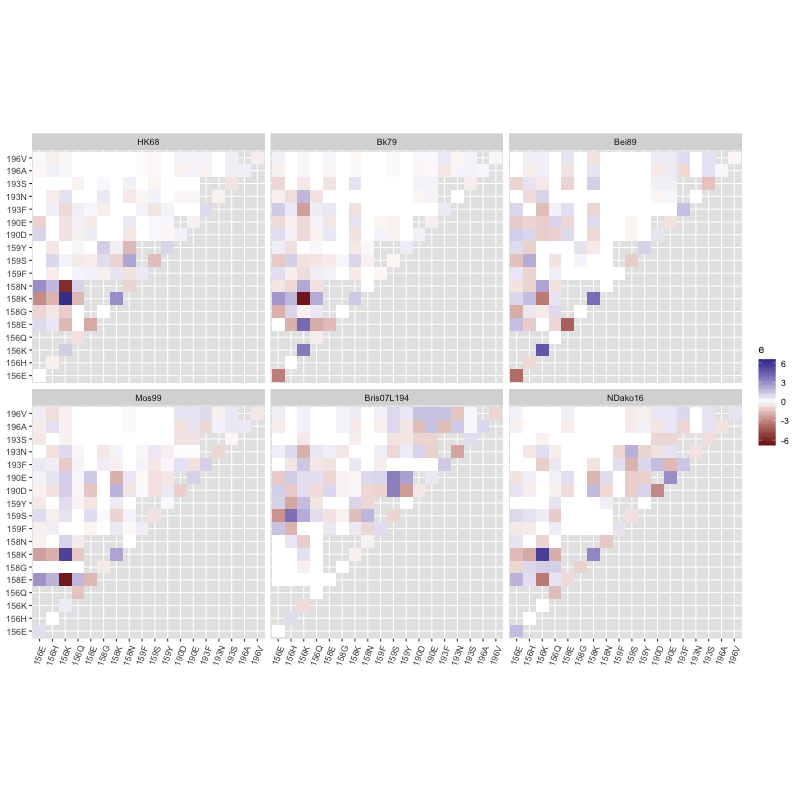

RObject{VecSxp}


In [101]:
dubdf(m, s) = vcat(DataFrame(e = m[:doubles].e, n1 = string.(m[:doubles].pos1).*m[:doubles].aa1, 
            n2 = string.(m[:doubles].pos2).*m[:doubles].aa2, strain=s), 
                DataFrame(e = m[:singles].e, n1 = string.(m[:singles].pos).*m[:singles].aa, 
            n2 = string.(m[:singles].pos).*m[:singles].aa, strain=s))
mbd = map((m,s) -> mapreduce(m->dubdf(m, s), vcat, m), m_lin_pair_boot, names)
mbd = reduce(vcat, mbd)
using StatsBase
mbd = by(mbd, [:n1, :n2, :strain], 
    d -> DataFrame(upper=percentile(d.e, 97.5),lower=percentile(d.e, 2.5)))
mdf = map(dubdf, m_lin_pair, names)
mdf = reduce(vcat, mdf)
mbd = join(mbd, mdf, on=[:n1,:n2, :strain], kind=:inner)
mbd.e[(mbd[:upper].>0) .& (mbd[:lower].<0)] .= 0

wtc = map( (w,s) -> DataFrame(strain = s, n1 = map(i->string(pos[i])*w[i], 1:6)), wt, names)
wtc = reduce(vcat, wtc)
wtc.n2 = wtc.n1
wtc.type = "WT"

smax = map(d -> d.ID[argmax(d.f)], data)
smaxd = map( (w,s) -> DataFrame(strain = s, n1 = map(i->string(pos[i])*w[i], 1:6)), smax, names)
smaxd = reduce(vcat, smaxd)
smaxd.n2 = smaxd.n1
smaxd.type = "BEST"

wtc = [wtc; smaxd]

R"""
p.linpair = qplot(data=$mbd %>% mutate(strain = factor(strain, levels=$names)) %>%
    group_by(strain) %>% mutate(e = -e/sd(e)), 
    y=n2, x=n1, fill=e, geom="tile") + coord_fixed() + 
    scale_fill_gradient2() + facet_wrap(~strain) +
    #geom_tile(aes(x=n1,y=n2, color=type), size=.2, fill="black",alpha=0, inherit.aes=FALSE,data=$wtc%>% mutate(strain = factor(strain, levels=$names))) +
    theme(axis.text.x = element_text(angle=70, vjust=0.5), 
        panel.background = element_rect(fill="grey90"), axis.title = element_blank())
"""
